In [1]:
import numpy as np
import pandas as pd
#import wfdb
import os
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import scipy.signal as signal
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
import torch.nn.functional as F


seed=2020
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
reclist=glob("./seg/*")
dtlist=glob("./seg/*/*.npy*")
reclist.sort()
dtlist.sort()
lab_list=[seg.split('_')[0][-1] for seg in dtlist]#shuffle by idx
(dtlist[0].split('_')[1]+'_'+dtlist[0].split('_')[-1].split('.')[0])

'a01_100'

In [3]:
def cheb_bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):    # 
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        #b, a = butter(filter_order, [low, high], btype="band")
        b, a = signal.cheby2(filter_order, 40, [low, high], 'band', analog=False)
        y = lfilter(b, a, data)
        return y

In [4]:
subjects=[['a11'],['a15'],['a17'],['b01'],['c07'],
          ['a11','a15','a17','b01','c07'],
          ['a14','a19','b05','c01','c07'],
          ['a04','a19','b05','c01','c09'],['b02','b03'],['x16','x21']]
len(subjects)

10

In [5]:
from sklearn.model_selection import KFold
def getTrainTestList(reclist,opt='rec_cv',fold=1):
    train_dtlist=[]
    test_dtlist=[]
    if opt=='rec_cv':#reclist is rec list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(reclist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_rec,test_rec=list(np.array(reclist)[train_idx]),list(np.array(reclist)[test_idx])
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        test_rec=[rec for rec in reclist if rec[-3]=='x']
        print(len(train_rec),len(test_rec))
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet_train':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        #print(len(train_rec),len(test_rec))
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
    elif opt=='blind':
        subjects=[['a11'],
                  ['a15','x27','x28'],
                  ['a17','x12'],
                  ['b01','x03'],
                  ['c07','x34'],
                  ['a11','a15','x27','x28','a17','x12','b01','x03','c07','x34'],
                  ['a14','a19','x05','x08','x25','b05','x11','c01','x35','c07','x34'],
                  ['a04','a19','x05','x08','x25','b05','x11','c01','x35','c09'],
                  ['b02','b03','x16','x21']]
        train_rec=[rec for rec in reclist if rec.split('/')[-1] not in subjects[fold-1]]
        test_rec=[rec for rec in reclist if rec.split('/')[-1] in subjects[fold-1]]
        print(len(train_rec),len(test_rec),test_rec)
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')

    else:#reclist is npy data list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
         
    return train_dtlist,test_dtlist

def dtclean(dt_path):
    dt=np.load(dt_path)
    if dt.std()<0.1:
#        print(dt_path)
        return 1      
    else:
        return 0

In [6]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
ApneaECGDict={'N':0,
              'A':1}
class ApneaECGDataset(Dataset):
    def __init__(self, filelist, istrain=False):
        # Get the filelist and img data
        self.filelist = filelist
        self.istrain = istrain
        
    def getFeature(self, dt):

        dt=cheb_bandpass_filter(dt, 0.01, 38, 100, 4)
    
# signal.spectrogram  normlizes raw data by default. 
        f, t, Sxx=signal.spectrogram(dt, fs=100.0, window=('hamming'), nperseg=128, noverlap=64, nfft=128, detrend='constant',
        return_onesided=True, scaling='density', axis=-1, mode='psd')
        return Sxx[0:26]

    def __getitem__(self, index):
        # return to the data of a Picture
        dt_path = self.filelist[index]
        label = ApneaECGDict.__getitem__(dt_path.split('_')[0][-1])
        data = np.load(dt_path)
        seg_id= dt_path.split('_')[1]+'_'+ dt_path.split('_')[-1].split('.')[0]

        if self.istrain:
            noise = np.random.normal(0, 0.1, data.shape[0])
            data = noise+data
        data=self.getFeature(data)
        return data, label,seg_id

    def __len__(self):
        return len(self.filelist)
    
class MyLSTM(nn.Module):
    def __init__(self, class_num,fs):
        super(MyLSTM, self).__init__()

#25 * 65
#12* 32
#b*64*6*16
#b*6*64*16
        self.branch1=nn.Sequential(nn.Conv2d(1,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                   nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                          
                                nn.LayerNorm([fs,26,92],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.25),
                                #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.MaxPool2d(kernel_size=2,stride=2),

                                nn.LayerNorm([fs,13,46],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.5),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False))
        
  
        self.avg = nn.Sequential(nn.AdaptiveMaxPool2d((8,8)),nn.LayerNorm([13,8,8],elementwise_affine=False))
    
        self.lstm = nn.LSTM(64, 8, 2,
                            bias=False,
                            batch_first=True,
                            dropout=0.5,
                            bidirectional=True)
        #self.conv2=nn.Sequential(nn.Conv1d(64,64,kernel_size=1,stride=1,padding=0, bias=False))
        
        self.fc=nn.Sequential(nn.Linear(16*2,class_num))
    def attention_net(self,lstm_output, final_state):
        hidden = final_state.view(-1, 16, 2)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        #print('hi',hidden.shape)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        #print('att',attn_weights.shape)
        soft_attn_weights = F.softmax(attn_weights, 1)

        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context#, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    def forward(self, x):
        x=x.unsqueeze(dim=1)#x.reshape(x.shape[0],1,-1)
        #x1=self.conv10(x)
        out=self.branch1(x)
        out=out.permute(0,2,1,3)
        out=self.avg(out)
        out=out.view(out.shape[0],out.shape[1],-1)
        out,(h,c) = self.lstm(out)
        out=self.attention_net(out, h)
        
        out = self.fc(out.reshape(out.shape[0],-1))
        return out

In [7]:
def eval(model,test_dtlist,criterion,my_device):
    test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    test_loader=DataLoader(test_dataset, batch_size=128, shuffle=False, sampler=None, num_workers=0)

    sft=nn.Softmax().to(my_device)
    all_pred_prob=torch.Tensor([]).to(my_device)
    all_label=torch.Tensor([]).long().to(my_device)
    all_seg=[]#torch.Tensor([]).to(my_device)
    flag=0
    with torch.no_grad():
        for fe, label,seg_id in test_loader:
            fe=fe.float().to(my_device)
            #fe=(fe-fe_mean)/fe_std
            label=label.long().to(my_device)
            pred_prob_no_softmax=model(fe)
            all_pred_prob=torch.cat((all_pred_prob,pred_prob_no_softmax),0)
            all_label=torch.cat((all_label,label),0)
            all_seg+=list(seg_id)
            loss=criterion(pred_prob_no_softmax,label)
            flag+=1
            if flag%8==0:
                print('Eval Loss: ',loss.item())
            #pos=(sft(pred_prob_no_softmax)[:,1]>0.5)
            #print("Acc: ", sum(label==pos).detach().numpy()/len(label))
    all_pred=sft(all_pred_prob)[:,1].detach().cpu().numpy()
    all_pred[all_pred>0.5]=1
    all_pred[all_pred<=0.5]=0
    all_label=all_label.detach().cpu().numpy()
    #all_seg=all_seg.detach().cpu().numpy()
    print(confusion_matrix(all_label,all_pred))
    print(classification_report(all_label,all_pred))
    print("acc: ",accuracy_score(all_label,all_pred))
    print("pre: ",precision_score(all_label,all_pred))
    print("rec: ",recall_score(all_label,all_pred))
    print("ma F1: ",f1_score(all_label,all_pred, average='macro'))
    print("mi F1: ",f1_score(all_label,all_pred, average='micro'))
    print("we F1: ",f1_score(all_label,all_pred, average='weighted'))
    return sft(all_pred_prob)[:,1].detach().cpu().numpy(),all_label, accuracy_score(all_label,all_pred),all_seg

  
kernel: 64
  
*********
29459 3432
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16256974637508392
Loss:  0.16868732869625092
Loss:  0.14803577959537506
0 **********
Epoch:  255.43885970115662  fold:  1  kers:  64
epoch:  1
29459 461
Loss:  0.14701445400714874
Loss:  0.10373757034540176
Loss:  0.11023624241352081
1 **********
Epoch:  298.71911215782166  fold:  1  kers:  64
epoch:  2
29459 461
Loss:  0.11872614920139313
Loss:  0.07696131616830826
Loss:  0.1076638251543045
2 **********
Epoch:  342.09311389923096  fold:  1  kers:  64
epoch:  3
Eval Loss:  0.4161815345287323
Eval Loss:  0.6385383605957031
Eval Loss:  0.1617898792028427


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 850  189]
 [ 799 1594]]
              precision    recall  f1-score   support

           0       0.52      0.82      0.63      1039
           1       0.89      0.67      0.76      2393

    accuracy                           0.71      3432
   macro avg       0.70      0.74      0.70      3432
weighted avg       0.78      0.71      0.72      3432

acc:  0.7121212121212122
pre:  0.8939988782950085
rec:  0.6661094860008357
ma F1:  0.69792521893815
mi F1:  0.7121212121212122
we F1:  0.7237604000804431
update!  Acc:  0.7121212121212122
Eval Loss:  0.40167608857154846
Eval Loss:  0.4496873915195465
Eval Loss:  0.5244254469871521
Eval Loss:  0.6020757555961609
Eval Loss:  0.41594165563583374
Eval Loss:  0.5731384754180908
Eval Loss:  0.3966715335845947
Eval Loss:  0.403361052274704
Eval Loss:  0.42943307757377625
Eval Loss:  0.4008931517601013
Eval Loss:  0.28366267681121826
Eval Loss:  0.48013514280319214
Eval Loss:  0.3960327208042145
Eval Loss:  0.4315473735332489
Eval Loss:  0.403777

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17495  1630]
 [ 3466  6868]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     19125
           1       0.81      0.66      0.73     10334

    accuracy                           0.83     29459
   macro avg       0.82      0.79      0.80     29459
weighted avg       0.83      0.83      0.82     29459

acc:  0.8270138158118062
pre:  0.8081901623911508
rec:  0.6646022837236307
ma F1:  0.8011350469048895
mi F1:  0.8270138158118062
we F1:  0.8225428061465104
29459 461
Loss:  0.06617613881826401
Loss:  0.10992496460676193
Loss:  0.08036520332098007
3 **********
Epoch:  423.3069179058075  fold:  1  kers:  64
epoch:  4
29459 461
Loss:  0.07843758910894394
Loss:  0.10786642134189606
Loss:  0.09725404530763626
4 **********
Epoch:  467.1137616634369  fold:  1  kers:  64
epoch:  5
29459 461
Loss:  0.07024883478879929
Loss:  0.05097294598817825
Loss:  0.08993468433618546
5 **********
Epoch:  511.01834416389465  fold:  1  kers:  64
epoch:  6
Ev

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 866  173]
 [ 809 1584]]
              precision    recall  f1-score   support

           0       0.52      0.83      0.64      1039
           1       0.90      0.66      0.76      2393

    accuracy                           0.71      3432
   macro avg       0.71      0.75      0.70      3432
weighted avg       0.79      0.71      0.73      3432

acc:  0.7138694638694638
pre:  0.9015367103016505
rec:  0.661930631007104
ma F1:  0.7007729665900151
mi F1:  0.7138694638694638
we F1:  0.7254702609025131
update!  Acc:  0.7138694638694638
Eval Loss:  0.359664648771286
Eval Loss:  0.4542022943496704
Eval Loss:  0.5669059157371521
Eval Loss:  0.5882550477981567
Eval Loss:  0.3963785171508789
Eval Loss:  0.5109214782714844
Eval Loss:  0.3658827543258667
Eval Loss:  0.3275151252746582
Eval Loss:  0.4007458984851837
Eval Loss:  0.35086002945899963
Eval Loss:  0.26395413279533386
Eval Loss:  0.46466097235679626
Eval Loss:  0.3905656039714813
Eval Loss:  0.40299203991889954
Eval Loss:  0.373467

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17993  1132]
 [ 3405  6929]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     19125
           1       0.86      0.67      0.75     10334

    accuracy                           0.85     29459
   macro avg       0.85      0.81      0.82     29459
weighted avg       0.85      0.85      0.84     29459

acc:  0.8459893411181643
pre:  0.8595707728569656
rec:  0.6705051287013741
ma F1:  0.8206978909765418
mi F1:  0.8459893411181644
we F1:  0.8407934385357431
29459 461
Loss:  0.09758708626031876
Loss:  0.08316242694854736
Loss:  0.07011011242866516
6 **********
Epoch:  592.585203409195  fold:  1  kers:  64
epoch:  7
29459 461
Loss:  0.08257696777582169
Loss:  0.060150016099214554
Loss:  0.06675669550895691
7 **********
Epoch:  636.4399197101593  fold:  1  kers:  64
epoch:  8
29459 461
Loss:  0.07759322226047516
Loss:  0.0935933068394661
Loss:  0.08572764694690704
8 **********
Epoch:  680.6377182006836  fold:  1  kers:  64
epoch:  9
Eval

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 929  110]
 [ 892 1501]]
              precision    recall  f1-score   support

           0       0.51      0.89      0.65      1039
           1       0.93      0.63      0.75      2393

    accuracy                           0.71      3432
   macro avg       0.72      0.76      0.70      3432
weighted avg       0.80      0.71      0.72      3432

acc:  0.708041958041958
pre:  0.9317194289261328
rec:  0.6272461345591308
ma F1:  0.6997002997002997
mi F1:  0.708041958041958
we F1:  0.7194461133272322
Eval Loss:  0.37965452671051025
Eval Loss:  0.47201085090637207
Eval Loss:  0.59019935131073
Eval Loss:  0.621257483959198
Eval Loss:  0.39259040355682373
Eval Loss:  0.5037729740142822
Eval Loss:  0.39256057143211365
Eval Loss:  0.32403048872947693
Eval Loss:  0.38846564292907715
Eval Loss:  0.37841227650642395
Eval Loss:  0.2749466896057129
Eval Loss:  0.46132081747055054
Eval Loss:  0.37397971749305725
Eval Loss:  0.45441603660583496
Eval Loss:  0.3656803369522095
Eval Loss:  0.577624

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18399   726]
 [ 3918  6416]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     19125
           1       0.90      0.62      0.73     10334

    accuracy                           0.84     29459
   macro avg       0.86      0.79      0.81     29459
weighted avg       0.85      0.84      0.83     29459

acc:  0.842357174377949
pre:  0.8983478017362083
rec:  0.6208631701180569
ma F1:  0.8111019524577967
mi F1:  0.8423571743779489
we F1:  0.8340314906285435
29459 461
Loss:  0.07271505147218704
Loss:  0.0885874480009079
Loss:  0.0719018280506134
9 **********
Epoch:  761.7807114124298  fold:  1  kers:  64
epoch:  10
29459 461
Loss:  0.04474213719367981
Loss:  0.07886730879545212
Loss:  0.10530903935432434
10 **********
Epoch:  805.7022485733032  fold:  1  kers:  64
epoch:  11
29459 461
Loss:  0.10847207903862
Loss:  0.050200242549180984
Loss:  0.06637883931398392
11 **********
Epoch:  849.6796364784241  fold:  1  kers:  64
epoch:  12
Eva

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 922  117]
 [ 838 1555]]
              precision    recall  f1-score   support

           0       0.52      0.89      0.66      1039
           1       0.93      0.65      0.77      2393

    accuracy                           0.72      3432
   macro avg       0.73      0.77      0.71      3432
weighted avg       0.81      0.72      0.73      3432

acc:  0.7217365967365967
pre:  0.9300239234449761
rec:  0.649811951525282
ma F1:  0.7119371836805184
mi F1:  0.7217365967365967
we F1:  0.7328983294592387
update!  Acc:  0.7217365967365967
Eval Loss:  0.38466334342956543
Eval Loss:  0.4575425088405609
Eval Loss:  0.5649458169937134
Eval Loss:  0.6077409982681274
Eval Loss:  0.39542466402053833
Eval Loss:  0.4852707087993622
Eval Loss:  0.4076487123966217
Eval Loss:  0.3167220652103424
Eval Loss:  0.3624584674835205
Eval Loss:  0.36348050832748413
Eval Loss:  0.2942686378955841
Eval Loss:  0.4358105957508087
Eval Loss:  0.38313573598861694
Eval Loss:  0.44006335735321045
Eval Loss:  0.3775

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18472   653]
 [ 3815  6519]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     19125
           1       0.91      0.63      0.74     10334

    accuracy                           0.85     29459
   macro avg       0.87      0.80      0.82     29459
weighted avg       0.86      0.85      0.84     29459

acc:  0.8483315794833497
pre:  0.9089514779698828
rec:  0.6308302690149022
ma F1:  0.8184408940875167
mi F1:  0.8483315794833497
we F1:  0.8404244141506614
29459 461
Loss:  0.0663449615240097
Loss:  0.1013585776090622
Loss:  0.07516950368881226
12 **********
Epoch:  930.5254247188568  fold:  1  kers:  64
epoch:  13
29459 461
Loss:  0.08927236497402191
Loss:  0.07845134288072586
Loss:  0.08356878161430359
13 **********
Epoch:  974.3611912727356  fold:  1  kers:  64
epoch:  14
29459 461
Loss:  0.08162444829940796
Loss:  0.10242560505867004
Loss:  0.1136971041560173
14 **********
Epoch:  1018.4353206157684  fold:  1  kers:  64
epoch:  15

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 892  147]
 [ 718 1675]]
              precision    recall  f1-score   support

           0       0.55      0.86      0.67      1039
           1       0.92      0.70      0.79      2393

    accuracy                           0.75      3432
   macro avg       0.74      0.78      0.73      3432
weighted avg       0.81      0.75      0.76      3432

acc:  0.747960372960373
pre:  0.9193194291986828
rec:  0.6999582114500627
ma F1:  0.7341211146622173
mi F1:  0.7479603729603731
we F1:  0.7580526034689896
update!  Acc:  0.747960372960373
Eval Loss:  0.2965349555015564
Eval Loss:  0.37456515431404114
Eval Loss:  0.4967564344406128
Eval Loss:  0.4372599124908447
Eval Loss:  0.316586434841156
Eval Loss:  0.4304376542568207
Eval Loss:  0.3109636604785919
Eval Loss:  0.24350611865520477
Eval Loss:  0.32006800174713135
Eval Loss:  0.3346380293369293
Eval Loss:  0.2118474245071411
Eval Loss:  0.36616843938827515
Eval Loss:  0.3262243866920471
Eval Loss:  0.38376009464263916
Eval Loss:  0.300939

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18241   884]
 [ 2982  7352]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     19125
           1       0.89      0.71      0.79     10334

    accuracy                           0.87     29459
   macro avg       0.88      0.83      0.85     29459
weighted avg       0.87      0.87      0.86     29459

acc:  0.8687667605825045
pre:  0.8926663428848955
rec:  0.7114379717437584
ma F1:  0.8479991788190188
mi F1:  0.8687667605825045
we F1:  0.8647654393831481
29459 461
Loss:  0.046601057052612305
Loss:  0.07607680559158325
Loss:  0.07435963302850723
15 **********
Epoch:  1099.25816988945  fold:  1  kers:  64
epoch:  16
29459 461
Loss:  0.09246616065502167
Loss:  0.09753287583589554
Loss:  0.07910216599702835
16 **********
Epoch:  1143.047061920166  fold:  1  kers:  64
epoch:  17
29459 461
Loss:  0.07024772465229034
Loss:  0.07718774676322937
Loss:  0.07741273939609528
17 **********
Epoch:  1186.6693994998932  fold:  1  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 857  182]
 [ 579 1814]]
              precision    recall  f1-score   support

           0       0.60      0.82      0.69      1039
           1       0.91      0.76      0.83      2393

    accuracy                           0.78      3432
   macro avg       0.75      0.79      0.76      3432
weighted avg       0.81      0.78      0.79      3432

acc:  0.7782634032634033
pre:  0.908817635270541
rec:  0.7580442958629335
ma F1:  0.7595686185159869
mi F1:  0.7782634032634033
we F1:  0.7860187110426343
update!  Acc:  0.7782634032634033
Eval Loss:  0.26213034987449646
Eval Loss:  0.3350909650325775
Eval Loss:  0.43388575315475464
Eval Loss:  0.35165390372276306
Eval Loss:  0.26102617383003235
Eval Loss:  0.3582838177680969
Eval Loss:  0.28007397055625916
Eval Loss:  0.2243318110704422
Eval Loss:  0.31153595447540283
Eval Loss:  0.29528719186782837
Eval Loss:  0.19431747496128082
Eval Loss:  0.33235085010528564
Eval Loss:  0.2836451232433319
Eval Loss:  0.33947524428367615
Eval Loss:  0

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18068  1057]
 [ 2412  7922]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     19125
           1       0.88      0.77      0.82     10334

    accuracy                           0.88     29459
   macro avg       0.88      0.86      0.87     29459
weighted avg       0.88      0.88      0.88     29459

acc:  0.8822431175532095
pre:  0.8822808776032965
rec:  0.7665957035029998
ma F1:  0.8663950520607588
mi F1:  0.8822431175532095
we F1:  0.8801266057512904
29459 461
Loss:  0.06345673650503159
Loss:  0.06799475103616714
Loss:  0.06398559361696243
18 **********
Epoch:  1267.4463713169098  fold:  1  kers:  64
epoch:  19
29459 461
Loss:  0.05161444470286369
Loss:  0.10145726054906845
Loss:  0.08148013055324554
19 **********
Epoch:  1311.0667145252228  fold:  1  kers:  64
epoch:  20
29459 461
Loss:  0.06127173826098442
Loss:  0.06347095221281052
Loss:  0.08029711246490479
20 **********
Epoch:  1354.605275630951  fold:  1  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 875  164]
 [ 686 1707]]
              precision    recall  f1-score   support

           0       0.56      0.84      0.67      1039
           1       0.91      0.71      0.80      2393

    accuracy                           0.75      3432
   macro avg       0.74      0.78      0.74      3432
weighted avg       0.81      0.75      0.76      3432

acc:  0.7523310023310024
pre:  0.9123463388562266
rec:  0.7133305474300041
ma F1:  0.7368667917448405
mi F1:  0.7523310023310024
we F1:  0.7620333075304933
Eval Loss:  0.2827073633670807
Eval Loss:  0.36293745040893555
Eval Loss:  0.4584048390388489
Eval Loss:  0.4001195430755615
Eval Loss:  0.2865501642227173
Eval Loss:  0.39078137278556824
Eval Loss:  0.2937996983528137
Eval Loss:  0.23705752193927765
Eval Loss:  0.30864307284355164
Eval Loss:  0.30032774806022644
Eval Loss:  0.21065343916416168
Eval Loss:  0.35638555884361267
Eval Loss:  0.32290127873420715
Eval Loss:  0.3696937561035156
Eval Loss:  0.3072228729724884
Eval Loss:  0.479

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18354   771]
 [ 2877  7457]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     19125
           1       0.91      0.72      0.80     10334

    accuracy                           0.88     29459
   macro avg       0.89      0.84      0.86     29459
weighted avg       0.88      0.88      0.87     29459

acc:  0.8761668759971486
pre:  0.9062955760816723
rec:  0.7215986065415134
ma F1:  0.8565369867483352
mi F1:  0.8761668759971486
we F1:  0.8723731211326903
29459 461
Loss:  0.06224927306175232
Loss:  0.06976433098316193
Loss:  0.05527910962700844
21 **********
Epoch:  1435.7552502155304  fold:  1  kers:  64
epoch:  22
29459 461
Loss:  0.07818245887756348
Loss:  0.060645949095487595
Loss:  0.05832141265273094
22 **********
Epoch:  1479.4324407577515  fold:  1  kers:  64
epoch:  23
29459 461
Loss:  0.0839771181344986
Loss:  0.07209571450948715
Loss:  0.086933933198452
23 **********
Epoch:  1523.188421010971  fold:  1  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 899  140]
 [ 671 1722]]
              precision    recall  f1-score   support

           0       0.57      0.87      0.69      1039
           1       0.92      0.72      0.81      2393

    accuracy                           0.76      3432
   macro avg       0.75      0.79      0.75      3432
weighted avg       0.82      0.76      0.77      3432

acc:  0.7636946386946387
pre:  0.924812030075188
rec:  0.7195988299206018
ma F1:  0.749276818605397
mi F1:  0.7636946386946387
we F1:  0.7729970232236635
Eval Loss:  0.2529973089694977
Eval Loss:  0.3376289904117584
Eval Loss:  0.48446136713027954
Eval Loss:  0.3996826112270355
Eval Loss:  0.28476375341415405
Eval Loss:  0.3841843605041504
Eval Loss:  0.30147358775138855
Eval Loss:  0.22413970530033112
Eval Loss:  0.2892422080039978
Eval Loss:  0.29065215587615967
Eval Loss:  0.18929870426654816
Eval Loss:  0.32895201444625854
Eval Loss:  0.31296053528785706
Eval Loss:  0.3824489116668701
Eval Loss:  0.2743403911590576
Eval Loss:  0.48189

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18449   676]
 [ 2842  7492]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     19125
           1       0.92      0.72      0.81     10334

    accuracy                           0.88     29459
   macro avg       0.89      0.84      0.86     29459
weighted avg       0.88      0.88      0.88     29459

acc:  0.8805797888590923
pre:  0.9172380019588638
rec:  0.7249854848074317
ma F1:  0.8614068294643287
mi F1:  0.8805797888590923
we F1:  0.8767896428292431
29459 461
Loss:  0.09343236684799194
Loss:  0.06624425202608109
Loss:  0.09736711531877518
24 **********
Epoch:  1604.0581450462341  fold:  1  kers:  64
epoch:  25
29459 461
Loss:  0.0671098530292511
Loss:  0.07052239030599594
Loss:  0.06800942867994308
25 **********
Epoch:  1647.8659863471985  fold:  1  kers:  64
epoch:  26
29459 461
Loss:  0.05892965942621231
Loss:  0.09899798035621643
Loss:  0.06859894841909409
26 **********
Epoch:  1691.5970332622528  fold:  1  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 827  212]
 [ 507 1886]]
              precision    recall  f1-score   support

           0       0.62      0.80      0.70      1039
           1       0.90      0.79      0.84      2393

    accuracy                           0.79      3432
   macro avg       0.76      0.79      0.77      3432
weighted avg       0.81      0.79      0.80      3432

acc:  0.7905011655011654
pre:  0.8989513822688274
rec:  0.7881320518178019
ma F1:  0.7684550165086459
mi F1:  0.7905011655011654
we F1:  0.7966424440212725
update!  Acc:  0.7905011655011654
Eval Loss:  0.215142622590065
Eval Loss:  0.3035535216331482
Eval Loss:  0.406441330909729
Eval Loss:  0.27634719014167786
Eval Loss:  0.26989033818244934
Eval Loss:  0.3403610289096832
Eval Loss:  0.24933475255966187
Eval Loss:  0.1804659515619278
Eval Loss:  0.28282853960990906
Eval Loss:  0.24268309772014618
Eval Loss:  0.17999175190925598
Eval Loss:  0.2843018174171448
Eval Loss:  0.28420624136924744
Eval Loss:  0.3366134464740753
Eval Loss:  0.242

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18071  1054]
 [ 2133  8201]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     19125
           1       0.89      0.79      0.84     10334

    accuracy                           0.89     29459
   macro avg       0.89      0.87      0.88     29459
weighted avg       0.89      0.89      0.89     29459

acc:  0.8918157439152721
pre:  0.8861156131820638
rec:  0.7935939616798916
ma F1:  0.8781361502250953
mi F1:  0.8918157439152721
we F1:  0.890320274655728
29459 461
Loss:  0.06713073700666428
Loss:  0.052841830998659134
Loss:  0.057100605219602585
27 **********
Epoch:  1772.6921544075012  fold:  1  kers:  64
epoch:  28
29459 461
Loss:  0.07943753153085709
Loss:  0.043474212288856506
Loss:  0.09143294394016266
28 **********
Epoch:  1816.5119633674622  fold:  1  kers:  64
epoch:  29
29459 461
Loss:  0.03318009153008461
Loss:  0.08727885037660599
Loss:  0.04590938240289688
29 **********
Epoch:  1860.4374899864197  fold:  1  kers:  64
epo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 830  209]
 [ 442 1951]]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      1039
           1       0.90      0.82      0.86      2393

    accuracy                           0.81      3432
   macro avg       0.78      0.81      0.79      3432
weighted avg       0.83      0.81      0.82      3432

acc:  0.8103146853146853
pre:  0.9032407407407408
rec:  0.8152946092770581
ma F1:  0.7876605579005402
mi F1:  0.8103146853146852
we F1:  0.8150233487290438
update!  Acc:  0.8103146853146853
Eval Loss:  0.21393229067325592
Eval Loss:  0.29407647252082825
Eval Loss:  0.37387585639953613
Eval Loss:  0.2584730088710785
Eval Loss:  0.22123342752456665
Eval Loss:  0.29994437098503113
Eval Loss:  0.2670533359050751
Eval Loss:  0.1919364482164383
Eval Loss:  0.2731519639492035
Eval Loss:  0.2264641970396042
Eval Loss:  0.15967756509780884
Eval Loss:  0.2700422704219818
Eval Loss:  0.25948360562324524
Eval Loss:  0.30183300375938416
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18028  1097]
 [ 1915  8419]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     19125
           1       0.88      0.81      0.85     10334

    accuracy                           0.90     29459
   macro avg       0.89      0.88      0.89     29459
weighted avg       0.90      0.90      0.90     29459

acc:  0.8977562035371194
pre:  0.8847204707860445
rec:  0.81468937487904
ma F1:  0.8855828099504344
mi F1:  0.8977562035371194
we F1:  0.8967199004926913
29459 461
Loss:  0.06451266258955002
Loss:  0.08207222819328308
Loss:  0.04537965729832649
30 **********
Epoch:  1941.5954434871674  fold:  1  kers:  64
epoch:  31
29459 461
Loss:  0.08940444141626358
Loss:  0.08081764727830887
Loss:  0.0704883560538292
31 **********
Epoch:  1985.4701058864594  fold:  1  kers:  64
epoch:  32
29459 461
Loss:  0.0836389884352684
Loss:  0.048425447195768356
Loss:  0.057591281831264496
32 **********
Epoch:  2029.1552755832672  fold:  1  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 855  184]
 [ 619 1774]]
              precision    recall  f1-score   support

           0       0.58      0.82      0.68      1039
           1       0.91      0.74      0.82      2393

    accuracy                           0.77      3432
   macro avg       0.74      0.78      0.75      3432
weighted avg       0.81      0.77      0.77      3432

acc:  0.7660256410256411
pre:  0.906026557711951
rec:  0.7413288758880067
ma F1:  0.7479531625160747
mi F1:  0.7660256410256411
we F1:  0.774580078622661
Eval Loss:  0.23014768958091736
Eval Loss:  0.28250885009765625
Eval Loss:  0.4092998206615448
Eval Loss:  0.3024066090583801
Eval Loss:  0.25195303559303284
Eval Loss:  0.3046664893627167
Eval Loss:  0.2530050277709961
Eval Loss:  0.17963434755802155
Eval Loss:  0.26000523567199707
Eval Loss:  0.22838254272937775
Eval Loss:  0.1726190745830536
Eval Loss:  0.2732004225254059
Eval Loss:  0.2771530747413635
Eval Loss:  0.28874537348747253
Eval Loss:  0.24698245525360107
Eval Loss:  0.35185

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18281   844]
 [ 2283  8051]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     19125
           1       0.91      0.78      0.84     10334

    accuracy                           0.89     29459
   macro avg       0.90      0.87      0.88     29459
weighted avg       0.89      0.89      0.89     29459

acc:  0.8938524729284769
pre:  0.905115233277122
rec:  0.7790787691116702
ma F1:  0.87929673283627
mi F1:  0.8938524729284769
we F1:  0.8918049939458096
29459 461
Loss:  0.03772502765059471
Loss:  0.07680109888315201
Loss:  0.07591915875673294
33 **********
Epoch:  2109.8963437080383  fold:  1  kers:  64
epoch:  34
29459 461
Loss:  0.06566832959651947
Loss:  0.0565047562122345
Loss:  0.0588807687163353
34 **********
Epoch:  2153.3461425304413  fold:  1  kers:  64
epoch:  35
29459 461
Loss:  0.05517739802598953
Loss:  0.06867635995149612
Loss:  0.048086073249578476
35 **********
Epoch:  2196.8886930942535  fold:  1  kers:  64
epoch:  3

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 883  156]
 [ 656 1737]]
              precision    recall  f1-score   support

           0       0.57      0.85      0.69      1039
           1       0.92      0.73      0.81      2393

    accuracy                           0.76      3432
   macro avg       0.75      0.79      0.75      3432
weighted avg       0.81      0.76      0.77      3432

acc:  0.7634032634032634
pre:  0.9175911251980983
rec:  0.7258671124111993
ma F1:  0.7477865582170394
mi F1:  0.7634032634032634
we F1:  0.7725465334186169
Eval Loss:  0.24052931368350983
Eval Loss:  0.32967621088027954
Eval Loss:  0.4376586377620697
Eval Loss:  0.37451449036598206
Eval Loss:  0.30518749356269836
Eval Loss:  0.33597567677497864
Eval Loss:  0.3156210780143738
Eval Loss:  0.18219970166683197
Eval Loss:  0.2905069589614868
Eval Loss:  0.27243033051490784
Eval Loss:  0.18517105281352997
Eval Loss:  0.30488690733909607
Eval Loss:  0.3040546774864197
Eval Loss:  0.3334454596042633
Eval Loss:  0.31818217039108276
Eval Loss:  0.4

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18547   578]
 [ 2751  7583]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     19125
           1       0.93      0.73      0.82     10334

    accuracy                           0.89     29459
   macro avg       0.90      0.85      0.87     29459
weighted avg       0.89      0.89      0.88     29459

acc:  0.8869954852506874
pre:  0.929175346158559
rec:  0.7337913682988194
ma F1:  0.8688256507653248
mi F1:  0.8869954852506874
we F1:  0.8833943314439843
29459 461
Loss:  0.055924590677022934
Loss:  0.04769156500697136
Loss:  0.0852351263165474
36 **********
Epoch:  2277.2218523025513  fold:  1  kers:  64
epoch:  37
29459 461
Loss:  0.08391567319631577
Loss:  0.07094081491231918
Loss:  0.06292001157999039
37 **********
Epoch:  2320.7195234298706  fold:  1  kers:  64
epoch:  38
29459 461
Loss:  0.05299893021583557
Loss:  0.07337280362844467
Loss:  0.09132842719554901
38 **********
Epoch:  2364.151370048523  fold:  1  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 765  274]
 [ 390 2003]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1039
           1       0.88      0.84      0.86      2393

    accuracy                           0.81      3432
   macro avg       0.77      0.79      0.78      3432
weighted avg       0.81      0.81      0.81      3432

acc:  0.8065268065268065
pre:  0.8796662274923145
rec:  0.837024655244463
ma F1:  0.7775861362212302
mi F1:  0.8065268065268065
we F1:  0.8092385333082661
Eval Loss:  0.1833920180797577
Eval Loss:  0.25471025705337524
Eval Loss:  0.36246463656425476
Eval Loss:  0.25887179374694824
Eval Loss:  0.2118678241968155
Eval Loss:  0.26353925466537476
Eval Loss:  0.2650928795337677
Eval Loss:  0.16226573288440704
Eval Loss:  0.25288358330726624
Eval Loss:  0.20165756344795227
Eval Loss:  0.15586236119270325
Eval Loss:  0.23828615248203278
Eval Loss:  0.23274362087249756
Eval Loss:  0.29411792755126953
Eval Loss:  0.21234865486621857
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17996  1129]
 [ 1750  8584]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     19125
           1       0.88      0.83      0.86     10334

    accuracy                           0.90     29459
   macro avg       0.90      0.89      0.89     29459
weighted avg       0.90      0.90      0.90     29459

acc:  0.9022709528497234
pre:  0.8837640275918872
rec:  0.8306560867040836
ma F1:  0.8911609953495396
mi F1:  0.9022709528497234
we F1:  0.9015379222921783
29459 461
Loss:  0.04467954486608505
Loss:  0.06971629709005356
Loss:  0.05294039472937584
39 **********
Epoch:  2444.538384914398  fold:  1  kers:  64
epoch:  40
29459 461
Loss:  0.08034437894821167
Loss:  0.06386734545230865
Loss:  0.02674858272075653
40 **********
Epoch:  2488.002146244049  fold:  1  kers:  64
epoch:  41
29459 461
Loss:  0.08137926459312439
Loss:  0.058380044996738434
Loss:  0.08977731317281723
41 **********
Epoch:  2536.1783051490784  fold:  1  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 802  237]
 [ 601 1792]]
              precision    recall  f1-score   support

           0       0.57      0.77      0.66      1039
           1       0.88      0.75      0.81      2393

    accuracy                           0.76      3432
   macro avg       0.73      0.76      0.73      3432
weighted avg       0.79      0.76      0.76      3432

acc:  0.7558275058275058
pre:  0.8831936914736324
rec:  0.7488508148767238
ma F1:  0.733665823218062
mi F1:  0.7558275058275058
we F1:  0.7639758416556246
Eval Loss:  0.19247053563594818
Eval Loss:  0.2347303330898285
Eval Loss:  0.37137264013290405
Eval Loss:  0.2924243211746216
Eval Loss:  0.22229380905628204
Eval Loss:  0.2708379328250885
Eval Loss:  0.28194206953048706
Eval Loss:  0.15630760788917542
Eval Loss:  0.24549977481365204
Eval Loss:  0.22695469856262207
Eval Loss:  0.1606922149658203
Eval Loss:  0.237143874168396
Eval Loss:  0.2803065776824951
Eval Loss:  0.29381033778190613
Eval Loss:  0.2558092176914215
Eval Loss:  0.33278

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18321   804]
 [ 2131  8203]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     19125
           1       0.91      0.79      0.85     10334

    accuracy                           0.90     29459
   macro avg       0.90      0.88      0.89     29459
weighted avg       0.90      0.90      0.90     29459

acc:  0.9003700057707322
pre:  0.9107360941489953
rec:  0.7937874975808012
ma F1:  0.8870452990323553
mi F1:  0.9003700057707322
we F1:  0.8986224384805734
29459 461
Loss:  0.04394165426492691
Loss:  0.03700670227408409
Loss:  0.061341676861047745
42 **********
Epoch:  2617.0270853042603  fold:  1  kers:  64
epoch:  43
29459 461
Loss:  0.07521647959947586
Loss:  0.08401446044445038
Loss:  0.0519796758890152
43 **********
Epoch:  2660.5307400226593  fold:  1  kers:  64
epoch:  44
29459 461
Loss:  0.04450805112719536
Loss:  0.05479149892926216
Loss:  0.027996378019452095
44 **********
Epoch:  2703.921696662903  fold:  1  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 696  343]
 [ 295 2098]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1039
           1       0.86      0.88      0.87      2393

    accuracy                           0.81      3432
   macro avg       0.78      0.77      0.78      3432
weighted avg       0.81      0.81      0.81      3432

acc:  0.8141025641025641
pre:  0.8594838181073331
rec:  0.8767237776849144
ma F1:  0.776866245049944
mi F1:  0.8141025641025641
we F1:  0.8128277115244431
update!  Acc:  0.8141025641025641
Eval Loss:  0.17369748651981354
Eval Loss:  0.2161933183670044
Eval Loss:  0.35398948192596436
Eval Loss:  0.23920981585979462
Eval Loss:  0.17628814280033112
Eval Loss:  0.2586659789085388
Eval Loss:  0.2374090999364853
Eval Loss:  0.15717440843582153
Eval Loss:  0.22448471188545227
Eval Loss:  0.1916572004556656
Eval Loss:  0.15666896104812622
Eval Loss:  0.197175532579422
Eval Loss:  0.24465370178222656
Eval Loss:  0.2803371846675873
Eval Loss:  0.19

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17774  1351]
 [ 1308  9026]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     19125
           1       0.87      0.87      0.87     10334

    accuracy                           0.91     29459
   macro avg       0.90      0.90      0.90     29459
weighted avg       0.91      0.91      0.91     29459

acc:  0.9097389592314743
pre:  0.8698082297388455
rec:  0.8734275208051093
ma F1:  0.9010097705957507
mi F1:  0.9097389592314743
we F1:  0.9097818667659203
29459 461
Loss:  0.049944233149290085
Loss:  0.07182984054088593
Loss:  0.07224723696708679
45 **********
Epoch:  2784.6647593975067  fold:  1  kers:  64
epoch:  46
29459 461
Loss:  0.05130290240049362
Loss:  0.03419642522931099
Loss:  0.04512038454413414
46 **********
Epoch:  2828.111566066742  fold:  1  kers:  64
epoch:  47
29459 461
Loss:  0.08856917172670364
Loss:  0.06674826890230179
Loss:  0.07674118876457214
47 **********
Epoch:  2871.606244802475  fold:  1  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 803  236]
 [ 447 1946]]
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      1039
           1       0.89      0.81      0.85      2393

    accuracy                           0.80      3432
   macro avg       0.77      0.79      0.78      3432
weighted avg       0.82      0.80      0.81      3432

acc:  0.800990675990676
pre:  0.8918423464711274
rec:  0.8132051817801922
ma F1:  0.7761634044503649
mi F1:  0.8009906759906759
we F1:  0.8055738381035418
Eval Loss:  0.16536231338977814
Eval Loss:  0.21707452833652496
Eval Loss:  0.33726683259010315
Eval Loss:  0.2462872713804245
Eval Loss:  0.18863944709300995
Eval Loss:  0.23280438780784607
Eval Loss:  0.24555248022079468
Eval Loss:  0.1444866806268692
Eval Loss:  0.22862569987773895
Eval Loss:  0.18971626460552216
Eval Loss:  0.14106400310993195
Eval Loss:  0.22137929499149323
Eval Loss:  0.2637188136577606
Eval Loss:  0.2603243589401245
Eval Loss:  0.24220888316631317
Eval Loss:  0.2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18284   841]
 [ 1754  8580]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     19125
           1       0.91      0.83      0.87     10334

    accuracy                           0.91     29459
   macro avg       0.91      0.89      0.90     29459
weighted avg       0.91      0.91      0.91     29459

acc:  0.9119114701788927
pre:  0.9107313448678485
rec:  0.8302690149022643
ma F1:  0.9011896640311656
mi F1:  0.9119114701788927
we F1:  0.9109027099755873
29459 461
Loss:  0.06701281666755676
Loss:  0.050425928086042404
Loss:  0.0542946420609951
48 **********
Epoch:  2952.1278998851776  fold:  1  kers:  64
epoch:  49
29459 461
Loss:  0.06675060838460922
Loss:  0.027352193370461464
Loss:  0.03807820752263069
49 **********
Epoch:  2995.6086163520813  fold:  1  kers:  64
epoch:  50
29459 461
Loss:  0.05678509548306465
Loss:  0.09986865520477295
Loss:  0.05741284787654877
50 **********
Epoch:  3039.174105644226  fold:  1  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 732  307]
 [ 325 2068]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      1039
           1       0.87      0.86      0.87      2393

    accuracy                           0.82      3432
   macro avg       0.78      0.78      0.78      3432
weighted avg       0.82      0.82      0.82      3432

acc:  0.8158508158508159
pre:  0.8707368421052631
rec:  0.8641872127037192
ma F1:  0.7829614734361392
mi F1:  0.8158508158508159
we F1:  0.8162939357336484
update!  Acc:  0.8158508158508159
Eval Loss:  0.1609252244234085
Eval Loss:  0.21796244382858276
Eval Loss:  0.34529489278793335
Eval Loss:  0.24058504402637482
Eval Loss:  0.16037790477275848
Eval Loss:  0.23524993658065796
Eval Loss:  0.23983685672283173
Eval Loss:  0.1403077393770218
Eval Loss:  0.22080209851264954
Eval Loss:  0.20483939349651337
Eval Loss:  0.1433102786540985
Eval Loss:  0.20116299390792847
Eval Loss:  0.2494671791791916
Eval Loss:  0.26711782813072205
Eval Loss:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17866  1259]
 [ 1345  8989]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     19125
           1       0.88      0.87      0.87     10334

    accuracy                           0.91     29459
   macro avg       0.90      0.90      0.90     29459
weighted avg       0.91      0.91      0.91     29459

acc:  0.911605960826912
pre:  0.8771467603434816
rec:  0.8698471066382814
ma F1:  0.9027779867540708
mi F1:  0.911605960826912
we F1:  0.9115204357880178
29459 461
Loss:  0.04584846645593643
Loss:  0.0544716976583004
Loss:  0.05739009007811546
51 **********
Epoch:  3119.5970244407654  fold:  1  kers:  64
epoch:  52
29459 461
Loss:  0.029158543795347214
Loss:  0.04583534225821495
Loss:  0.04808623716235161
52 **********
Epoch:  3163.168498277664  fold:  1  kers:  64
epoch:  53
29459 461
Loss:  0.05718366429209709
Loss:  0.0746065303683281
Loss:  0.04701705649495125
53 **********
Epoch:  3206.7339873313904  fold:  1  kers:  64
epoch:  5

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 744  295]
 [ 465 1928]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.66      1039
           1       0.87      0.81      0.84      2393

    accuracy                           0.78      3432
   macro avg       0.74      0.76      0.75      3432
weighted avg       0.79      0.78      0.78      3432

acc:  0.7785547785547785
pre:  0.8672964462438146
rec:  0.8056832427914752
ma F1:  0.7486384970734625
mi F1:  0.7785547785547784
we F1:  0.7828501905917917
Eval Loss:  0.16650667786598206
Eval Loss:  0.17424333095550537
Eval Loss:  0.3163476586341858
Eval Loss:  0.23579184710979462
Eval Loss:  0.14809758961200714
Eval Loss:  0.21305517852306366
Eval Loss:  0.23395541310310364
Eval Loss:  0.12536273896694183
Eval Loss:  0.176449716091156
Eval Loss:  0.1862950623035431
Eval Loss:  0.13074401021003723
Eval Loss:  0.17570917308330536
Eval Loss:  0.2704164683818817
Eval Loss:  0.25280869007110596
Eval Loss:  0.2398044615983963
Eval Loss:  0.26

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18065  1060]
 [ 1421  8913]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     19125
           1       0.89      0.86      0.88     10334

    accuracy                           0.92     29459
   macro avg       0.91      0.90      0.91     29459
weighted avg       0.92      0.92      0.92     29459

acc:  0.9157812553039818
pre:  0.8937130251679535
rec:  0.8624927424037159
ma F1:  0.9067845401962831
mi F1:  0.9157812553039818
we F1:  0.9154263805056995
29459 461
Loss:  0.026426851749420166
Loss:  0.039043400436639786
Loss:  0.05016177520155907
54 **********
Epoch:  3287.5009863376617  fold:  1  kers:  64
epoch:  55
29459 461
Loss:  0.04354843869805336
Loss:  0.0436265729367733
Loss:  0.034175895154476166
55 **********
Epoch:  3331.13130235672  fold:  1  kers:  64
epoch:  56
29459 461
Loss:  0.06688131392002106
Loss:  0.0674176886677742
Loss:  0.06789063662290573
56 **********
Epoch:  3374.7287061214447  fold:  1  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 749  290]
 [ 408 1985]]
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1039
           1       0.87      0.83      0.85      2393

    accuracy                           0.80      3432
   macro avg       0.76      0.78      0.77      3432
weighted avg       0.80      0.80      0.80      3432

acc:  0.7966200466200466
pre:  0.8725274725274725
rec:  0.8295027162557459
ma F1:  0.7663103281966277
mi F1:  0.7966200466200466
we F1:  0.7995136928772985
Eval Loss:  0.15171760320663452
Eval Loss:  0.17949777841567993
Eval Loss:  0.3311730623245239
Eval Loss:  0.22360482811927795
Eval Loss:  0.15899507701396942
Eval Loss:  0.21105585992336273
Eval Loss:  0.22488616406917572
Eval Loss:  0.12981492280960083
Eval Loss:  0.16161544620990753
Eval Loss:  0.17406612634658813
Eval Loss:  0.12408091872930527
Eval Loss:  0.1922565996646881
Eval Loss:  0.26584580540657043
Eval Loss:  0.27017942070961
Eval Loss:  0.21146970987319946
Eval Loss:  0.2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18118  1007]
 [ 1409  8925]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     19125
           1       0.90      0.86      0.88     10334

    accuracy                           0.92     29459
   macro avg       0.91      0.91      0.91     29459
weighted avg       0.92      0.92      0.92     29459

acc:  0.9179877117349536
pre:  0.898610551751913
rec:  0.8636539578091736
ma F1:  0.9091395420928556
mi F1:  0.9179877117349536
we F1:  0.9176007907955298
29459 461
Loss:  0.05717599391937256
Loss:  0.038748420774936676
Loss:  0.045344073325395584
57 **********
Epoch:  3455.2822761535645  fold:  1  kers:  64
epoch:  58
29459 461
Loss:  0.056866876780986786
Loss:  0.043956149369478226
Loss:  0.07298355549573898
58 **********
Epoch:  3498.829813480377  fold:  1  kers:  64
epoch:  59
29459 461
Loss:  0.05823396146297455
Loss:  0.07208916544914246
Loss:  0.10404767841100693
59 **********
Epoch:  3543.1851902008057  fold:  1  kers:  64
Eva

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 739  300]
 [ 424 1969]]
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1039
           1       0.87      0.82      0.84      2393

    accuracy                           0.79      3432
   macro avg       0.75      0.77      0.76      3432
weighted avg       0.80      0.79      0.79      3432

acc:  0.789044289044289
pre:  0.8677831643895989
rec:  0.8228165482657752
ma F1:  0.7579549187178616
mi F1:  0.789044289044289
we F1:  0.7921785019877663
update!  Acc:  0.8158508158508159
Epoch:  3547.862681388855  fold:  1  kers:  64


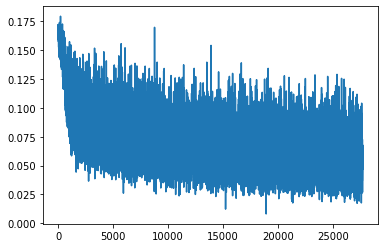

------
*********
29797 3094
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.16098514199256897
Loss:  0.15927579998970032
Loss:  0.15680444240570068
0 **********
Epoch:  64.93334245681763  fold:  2  kers:  64
epoch:  1
29797 466
Loss:  0.14349278807640076
Loss:  0.12168614566326141
Loss:  0.11824166774749756
1 **********
Epoch:  115.91001152992249  fold:  2  kers:  64
epoch:  2
29797 466
Loss:  0.10895661264657974
Loss:  0.09722188860177994
Loss:  0.10440198332071304
2 **********
Epoch:  160.59450840950012  fold:  2  kers:  64
epoch:  3
Eval Loss:  0.9053584933280945
Eval Loss:  0.23401831090450287
Eval Loss:  0.7339860200881958
[[1151  279]
 [ 546 1118]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.74      1430

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.3482365906238556
Eval Loss:  0.41781434416770935
Eval Loss:  0.36358746886253357
Eval Loss:  0.3666561543941498
Eval Loss:  0.38779526948928833
Eval Loss:  0.5019661784172058
Eval Loss:  0.4025493264198303
Eval Loss:  0.4050351679325104
Eval Loss:  0.2973322868347168
Eval Loss:  0.4416317641735077
Eval Loss:  0.40638184547424316
Eval Loss:  0.3386165201663971
Eval Loss:  0.3647615313529968
Eval Loss:  0.3221954107284546
Eval Loss:  0.30085858702659607
Eval Loss:  0.3299921751022339
Eval Loss:  0.3199613690376282
Eval Loss:  0.33689576387405396
Eval Loss:  0.3685949742794037
Eval Loss:  0.3854062855243683
Eval Loss:  0.28836047649383545
Eval Loss:  0.3381737768650055
Eval Loss:  0.32209163904190063
Eval Loss:  0.5471765398979187
Eval Loss:  0.32242467999458313
Eval Loss:  0.27210521697998047
Eval Loss:  0.37339046597480774
Eval Loss:  0.334642231464386
Eval Loss:  0.2889479100704193


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16260  2474]
 [ 2291  8772]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     18734
           1       0.78      0.79      0.79     11063

    accuracy                           0.84     29797
   macro avg       0.83      0.83      0.83     29797
weighted avg       0.84      0.84      0.84     29797

acc:  0.8400845722723764
pre:  0.7800106704606082
rec:  0.7929133146524451
ma F1:  0.8293048447208314
mi F1:  0.8400845722723765
we F1:  0.8403480191396218
29797 466


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.10903187841176987
Loss:  0.09109050780534744
Loss:  0.13000451028347015
3 **********
Epoch:  245.57025122642517  fold:  2  kers:  64
epoch:  4
29797 466
Loss:  0.09856515377759933
Loss:  0.08075088262557983
Loss:  0.10424723476171494
4 **********
Epoch:  290.01339387893677  fold:  2  kers:  64
epoch:  5
29797 466
Loss:  0.06166989728808403
Loss:  0.07792339473962784
Loss:  0.08368344604969025
5 **********
Epoch:  334.52834367752075  fold:  2  kers:  64
epoch:  6
Eval Loss:  1.0075370073318481
Eval Loss:  0.15120862424373627
Eval Loss:  0.7993054986000061
[[1265  165]
 [ 737  927]]
              precision    recall  f1-score   support

           0       0.63      0.88      0.74      1430
           1       0.85      0.56      0.67      1664

    accuracy                           0.71      3094
   macro avg       0.74      0.72      0.70      3094
weighted avg       0.75      0.71      0.70      3094

acc:  0.7084680025856497
pre:  0.8489010989010989
rec:  0.5570913461538461
m

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.3745470941066742
Eval Loss:  0.3955463171005249
Eval Loss:  0.3720731735229492
Eval Loss:  0.3666215240955353
Eval Loss:  0.32056891918182373
Eval Loss:  0.5458535552024841
Eval Loss:  0.3679565191268921
Eval Loss:  0.35455143451690674
Eval Loss:  0.2846479117870331
Eval Loss:  0.5074341297149658
Eval Loss:  0.39567264914512634
Eval Loss:  0.3174254298210144
Eval Loss:  0.34504032135009766
Eval Loss:  0.3576465845108032
Eval Loss:  0.2844981551170349
Eval Loss:  0.3103219270706177
Eval Loss:  0.37902483344078064
Eval Loss:  0.3406916558742523
Eval Loss:  0.317585825920105
Eval Loss:  0.2841561734676361
Eval Loss:  0.3011414408683777
Eval Loss:  0.29385560750961304
Eval Loss:  0.3057548701763153
Eval Loss:  0.6282902956008911
Eval Loss:  0.3188823163509369
Eval Loss:  0.24183087050914764
Eval Loss:  0.3554275929927826
Eval Loss:  0.35605400800704956
Eval Loss:  0.2498467117547989


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17446  1288]
 [ 2951  8112]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     18734
           1       0.86      0.73      0.79     11063

    accuracy                           0.86     29797
   macro avg       0.86      0.83      0.84     29797
weighted avg       0.86      0.86      0.85     29797

acc:  0.8577373561096755
pre:  0.8629787234042553
rec:  0.7332549941245593
ma F1:  0.8422585942764452
mi F1:  0.8577373561096755
we F1:  0.8549795694235106
29797 466


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.09210821986198425
Loss:  0.07075470685958862
Loss:  0.06940632313489914
6 **********
Epoch:  419.6347372531891  fold:  2  kers:  64
epoch:  7
29797 466
Loss:  0.1040073111653328
Loss:  0.06406362354755402
Loss:  0.07453480362892151
7 **********
Epoch:  464.28233337402344  fold:  2  kers:  64
epoch:  8
29797 466
Loss:  0.06247108057141304
Loss:  0.07563666254281998
Loss:  0.09981630742549896
8 **********
Epoch:  508.81922483444214  fold:  2  kers:  64
epoch:  9
Eval Loss:  0.9722327589988708
Eval Loss:  0.22125911712646484
Eval Loss:  0.5702859163284302
[[1252  178]
 [ 699  965]]
              precision    recall  f1-score   support

           0       0.64      0.88      0.74      1430
           1       0.84      0.58      0.69      1664

    accuracy                           0.72      3094
   macro avg       0.74      0.73      0.71      3094
weighted avg       0.75      0.72      0.71      3094

acc:  0.7165481577246283
pre:  0.8442694663167104
rec:  0.5799278846153846
ma 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.3378056287765503
Eval Loss:  0.35161420702934265
Eval Loss:  0.36082056164741516
Eval Loss:  0.351798415184021
Eval Loss:  0.2960193455219269
Eval Loss:  0.4508027136325836
Eval Loss:  0.35794857144355774
Eval Loss:  0.3539801836013794
Eval Loss:  0.28795287013053894
Eval Loss:  0.5087859630584717
Eval Loss:  0.3391636610031128
Eval Loss:  0.27871468663215637
Eval Loss:  0.3242660164833069
Eval Loss:  0.33595481514930725
Eval Loss:  0.2949219346046448
Eval Loss:  0.31881511211395264
Eval Loss:  0.30625098943710327
Eval Loss:  0.2827000617980957
Eval Loss:  0.28387272357940674
Eval Loss:  0.242500901222229
Eval Loss:  0.289257675409317
Eval Loss:  0.25565341114997864
Eval Loss:  0.29291239380836487
Eval Loss:  0.5613737106323242
Eval Loss:  0.3200695812702179
Eval Loss:  0.22886589169502258
Eval Loss:  0.3569704294204712
Eval Loss:  0.35642343759536743
Eval Loss:  0.2456383854150772


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17640  1094]
 [ 2811  8252]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     18734
           1       0.88      0.75      0.81     11063

    accuracy                           0.87     29797
   macro avg       0.87      0.84      0.85     29797
weighted avg       0.87      0.87      0.87     29797

acc:  0.8689465382421049
pre:  0.8829445752193452
rec:  0.7459097893880503
ma F1:  0.8545036822049694
mi F1:  0.8689465382421049
we F1:  0.8663050401790711
29797 466


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.07694954425096512
Loss:  0.08455447852611542
Loss:  0.09413890540599823
9 **********
Epoch:  593.9864554405212  fold:  2  kers:  64
epoch:  10
29797 466
Loss:  0.09586494415998459
Loss:  0.10771938413381577
Loss:  0.06352929770946503
10 **********
Epoch:  638.3328564167023  fold:  2  kers:  64
epoch:  11
29797 466
Loss:  0.08261921256780624
Loss:  0.08447588980197906
Loss:  0.07065320760011673
11 **********
Epoch:  682.8059189319611  fold:  2  kers:  64
epoch:  12
Eval Loss:  0.9106976985931396
Eval Loss:  0.24172139167785645
Eval Loss:  0.9821907877922058
[[1267  163]
 [ 828  836]]
              precision    recall  f1-score   support

           0       0.60      0.89      0.72      1430
           1       0.84      0.50      0.63      1664

    accuracy                           0.68      3094
   macro avg       0.72      0.69      0.67      3094
weighted avg       0.73      0.68      0.67      3094

acc:  0.6797026502908856
pre:  0.8368368368368369
rec:  0.5024038461538461

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.3451157510280609
Eval Loss:  0.34251460433006287
Eval Loss:  0.39302048087120056
Eval Loss:  0.3869149684906006
Eval Loss:  0.2872145175933838
Eval Loss:  0.44773995876312256
Eval Loss:  0.36437085270881653
Eval Loss:  0.35223188996315
Eval Loss:  0.29174479842185974
Eval Loss:  0.5404991507530212
Eval Loss:  0.35040637850761414
Eval Loss:  0.26843228936195374
Eval Loss:  0.3285631537437439
Eval Loss:  0.3782680630683899
Eval Loss:  0.26879143714904785
Eval Loss:  0.3109736144542694
Eval Loss:  0.3479122519493103
Eval Loss:  0.299618124961853
Eval Loss:  0.27153557538986206
Eval Loss:  0.24618375301361084
Eval Loss:  0.3250207304954529
Eval Loss:  0.23272943496704102
Eval Loss:  0.3516773283481598
Eval Loss:  0.5676455497741699
Eval Loss:  0.36257705092430115
Eval Loss:  0.24932549893856049
Eval Loss:  0.33900976181030273
Eval Loss:  0.383042573928833
Eval Loss:  0.2693915367126465


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17898   836]
 [ 3185  7878]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     18734
           1       0.90      0.71      0.80     11063

    accuracy                           0.87     29797
   macro avg       0.88      0.83      0.85     29797
weighted avg       0.87      0.87      0.86     29797

acc:  0.8650535288787462
pre:  0.904062428276337
rec:  0.7121034077555817
ma F1:  0.8478480000139283
mi F1:  0.8650535288787462
we F1:  0.8610200171718144
29797 466
Loss:  0.1127161979675293
Loss:  0.09263721853494644
Loss:  0.08571930974721909
12 **********
Epoch:  771.4917395114899  fold:  2  kers:  64
epoch:  13
29797 466
Loss:  0.11032315343618393
Loss:  0.07291907072067261
Loss:  0.08191788196563721
13 **********
Epoch:  816.0914633274078  fold:  2  kers:  64
epoch:  14
29797 466
Loss:  0.05362202227115631
Loss:  0.06400734186172485
Loss:  0.051183201372623444
14 **********
Epoch:  860.1566164493561  fold:  2  kers:  64
epoch:  1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.28543874621391296
Eval Loss:  0.3110697269439697
Eval Loss:  0.321679025888443
Eval Loss:  0.3118879199028015
Eval Loss:  0.2520272433757782
Eval Loss:  0.3870033919811249
Eval Loss:  0.2767564058303833
Eval Loss:  0.3393101394176483
Eval Loss:  0.2641502618789673
Eval Loss:  0.44955000281333923
Eval Loss:  0.2939475476741791
Eval Loss:  0.23946000635623932
Eval Loss:  0.26936811208724976
Eval Loss:  0.2985694408416748
Eval Loss:  0.24291068315505981
Eval Loss:  0.2672407031059265
Eval Loss:  0.2367328256368637
Eval Loss:  0.23383261263370514
Eval Loss:  0.24083159863948822
Eval Loss:  0.20937448740005493
Eval Loss:  0.28718695044517517
Eval Loss:  0.20946703851222992
Eval Loss:  0.2975333034992218
Eval Loss:  0.4680386483669281
Eval Loss:  0.284354031085968
Eval Loss:  0.20117735862731934
Eval Loss:  0.3303021192550659
Eval Loss:  0.30316874384880066
Eval Loss:  0.23493637144565582
[[17641  1093]
 [ 2369  8694]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.88      0.94      0.91     18734
           1       0.89      0.79      0.83     11063

    accuracy                           0.88     29797
   macro avg       0.88      0.86      0.87     29797
weighted avg       0.88      0.88      0.88     29797

acc:  0.8838138067590697
pre:  0.8883212424644937
rec:  0.7858627858627859
ma F1:  0.872300531658093
mi F1:  0.8838138067590697
we F1:  0.8821718106677716
29797 466
Loss:  0.061477236449718475
Loss:  0.049966201186180115
Loss:  0.06042090058326721
15 **********
Epoch:  941.1170978546143  fold:  2  kers:  64
epoch:  16
29797 466
Loss:  0.0685550644993782
Loss:  0.04512525722384453
Loss:  0.06363876909017563
16 **********
Epoch:  985.1194190979004  fold:  2  kers:  64
epoch:  17
29797 466
Loss:  0.06860605627298355
Loss:  0.03161672502756119
Loss:  0.04683121666312218
17 **********
Epoch:  1029.1835749149323  fold:  2  kers:  64
epoch:  18
Eval Loss:  0.699671924114

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.24775664508342743
Eval Loss:  0.28269121050834656
Eval Loss:  0.2789821922779083
Eval Loss:  0.24456360936164856
Eval Loss:  0.23816831409931183
Eval Loss:  0.3307567834854126
Eval Loss:  0.2642826735973358
Eval Loss:  0.31194743514060974
Eval Loss:  0.2403448075056076
Eval Loss:  0.35275426506996155
Eval Loss:  0.27860674262046814
Eval Loss:  0.23681722581386566
Eval Loss:  0.2404235303401947
Eval Loss:  0.26669853925704956
Eval Loss:  0.2214079052209854
Eval Loss:  0.2509661018848419
Eval Loss:  0.21510818600654602
Eval Loss:  0.22934243083000183
Eval Loss:  0.22183486819267273
Eval Loss:  0.2210502177476883
Eval Loss:  0.27451422810554504
Eval Loss:  0.19739271700382233
Eval Loss:  0.2892480790615082
Eval Loss:  0.45236319303512573
Eval Loss:  0.26842692494392395
Eval Loss:  0.18903204798698425
Eval Loss:  0.3056611716747284
Eval Loss:  0.25361621379852295
Eval Loss:  0.218789204955101
[[17564  1170]
 [ 2105  8958]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.89      0.94      0.91     18734
           1       0.88      0.81      0.85     11063

    accuracy                           0.89     29797
   macro avg       0.89      0.87      0.88     29797
weighted avg       0.89      0.89      0.89     29797

acc:  0.8900896063362084
pre:  0.884478672985782
rec:  0.8097261140739401
ma F1:  0.8800867313047486
mi F1:  0.8900896063362084
we F1:  0.8890028426650005
29797 466
Loss:  0.08209345489740372
Loss:  0.060917533934116364
Loss:  0.05609852075576782
18 **********
Epoch:  1110.4153306484222  fold:  2  kers:  64
epoch:  19
29797 466
Loss:  0.08417242765426636
Loss:  0.09516985714435577
Loss:  0.07270001620054245
19 **********
Epoch:  1154.6171185970306  fold:  2  kers:  64
epoch:  20
29797 466
Loss:  0.07886283099651337
Loss:  0.08535325527191162
Loss:  0.06910475343465805
20 **********
Epoch:  1198.711194038391  fold:  2  kers:  64
epoch:  21
Eval Loss:  1.29949378967

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.30142641067504883
Eval Loss:  0.3237125873565674
Eval Loss:  0.4073609411716461
Eval Loss:  0.32167020440101624
Eval Loss:  0.2817705571651459
Eval Loss:  0.3963269293308258
Eval Loss:  0.364113986492157
Eval Loss:  0.33087989687919617
Eval Loss:  0.27145546674728394
Eval Loss:  0.5018271207809448
Eval Loss:  0.3291240930557251
Eval Loss:  0.2736240029335022
Eval Loss:  0.3322131037712097
Eval Loss:  0.3533676564693451
Eval Loss:  0.23812352120876312
Eval Loss:  0.3151260018348694
Eval Loss:  0.30715706944465637
Eval Loss:  0.2742755115032196
Eval Loss:  0.275470107793808
Eval Loss:  0.19262586534023285
Eval Loss:  0.3343110680580139
Eval Loss:  0.2306753545999527
Eval Loss:  0.42002326250076294
Eval Loss:  0.5870577096939087
Eval Loss:  0.3317759335041046
Eval Loss:  0.2031419277191162
Eval Loss:  0.3063197731971741
Eval Loss:  0.35574376583099365
Eval Loss:  0.2597403824329376
[[18203   531]
 [ 3453  7610]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.84      0.97      0.90     18734
           1       0.93      0.69      0.79     11063

    accuracy                           0.87     29797
   macro avg       0.89      0.83      0.85     29797
weighted avg       0.88      0.87      0.86     29797

acc:  0.8662952646239555
pre:  0.9347745977152684
rec:  0.6878785139654705
ma F1:  0.8469524716806389
mi F1:  0.8662952646239553
we F1:  0.8609596995356545
29797 466
Loss:  0.11733253300189972
Loss:  0.05468136817216873
Loss:  0.0772026777267456
21 **********
Epoch:  1279.9190139770508  fold:  2  kers:  64
epoch:  22
29797 466
Loss:  0.07960488647222519
Loss:  0.05877586826682091
Loss:  0.0580398365855217
22 **********
Epoch:  1323.9223325252533  fold:  2  kers:  64
epoch:  23
29797 466
Loss:  0.05130079388618469
Loss:  0.05969873443245888
Loss:  0.046430669724941254
23 **********
Epoch:  1368.0503177642822  fold:  2  kers:  64
epoch:  24
Eval Loss:  0.77197647094

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.23079237341880798
Eval Loss:  0.2691730260848999
Eval Loss:  0.2920297682285309
Eval Loss:  0.2352307140827179
Eval Loss:  0.23367291688919067
Eval Loss:  0.31423336267471313
Eval Loss:  0.27911821007728577
Eval Loss:  0.26497411727905273
Eval Loss:  0.2235465943813324
Eval Loss:  0.35973548889160156
Eval Loss:  0.2726653516292572
Eval Loss:  0.21055549383163452
Eval Loss:  0.2338809072971344
Eval Loss:  0.2748761773109436
Eval Loss:  0.21499797701835632
Eval Loss:  0.22019673883914948
Eval Loss:  0.19116035103797913
Eval Loss:  0.20305347442626953
Eval Loss:  0.217921644449234
Eval Loss:  0.18947161734104156
Eval Loss:  0.24598921835422516
Eval Loss:  0.182495579123497
Eval Loss:  0.2990911602973938
Eval Loss:  0.464152455329895
Eval Loss:  0.2810108959674835
Eval Loss:  0.16922347247600555
Eval Loss:  0.2885904610157013
Eval Loss:  0.2363838255405426
Eval Loss:  0.22727185487747192
[[17780   954]
 [ 2174  8889]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18734
           1       0.90      0.80      0.85     11063

    accuracy                           0.90     29797
   macro avg       0.90      0.88      0.88     29797
weighted avg       0.90      0.90      0.89     29797

acc:  0.8950229888914991
pre:  0.9030783297775069
rec:  0.803489107836934
ma F1:  0.8847629690962984
mi F1:  0.8950229888914991
we F1:  0.8936151355397789
29797 466
Loss:  0.07824978232383728
Loss:  0.06177926063537598
Loss:  0.07462780922651291
24 **********
Epoch:  1449.2122604846954  fold:  2  kers:  64
epoch:  25
29797 466
Loss:  0.07518626749515533
Loss:  0.03367985785007477
Loss:  0.06776809692382812
25 **********
Epoch:  1493.311322927475  fold:  2  kers:  64
epoch:  26
29797 466
Loss:  0.06136729568243027
Loss:  0.05569157376885414
Loss:  0.09380341321229935
26 **********
Epoch:  1537.5799317359924  fold:  2  kers:  64
epoch:  27
Eval Loss:  0.922363102436

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2276550680398941
Eval Loss:  0.2568448483943939
Eval Loss:  0.3057248592376709
Eval Loss:  0.23404549062252045
Eval Loss:  0.2329896241426468
Eval Loss:  0.30592024326324463
Eval Loss:  0.26679250597953796
Eval Loss:  0.25209668278694153
Eval Loss:  0.20360638201236725
Eval Loss:  0.35947108268737793
Eval Loss:  0.2665823996067047
Eval Loss:  0.23061099648475647
Eval Loss:  0.2570759057998657
Eval Loss:  0.23361575603485107
Eval Loss:  0.21213363111019135
Eval Loss:  0.22381970286369324
Eval Loss:  0.21053513884544373
Eval Loss:  0.22405630350112915
Eval Loss:  0.23546463251113892
Eval Loss:  0.187586709856987
Eval Loss:  0.25705409049987793
Eval Loss:  0.18961670994758606
Eval Loss:  0.2859300673007965
Eval Loss:  0.46157336235046387
Eval Loss:  0.27634915709495544
Eval Loss:  0.17559507489204407
Eval Loss:  0.2783910632133484
Eval Loss:  0.23317568004131317
Eval Loss:  0.186213418841362
[[17960   774]
 [ 2395  8668]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.88      0.96      0.92     18734
           1       0.92      0.78      0.85     11063

    accuracy                           0.89     29797
   macro avg       0.90      0.87      0.88     29797
weighted avg       0.90      0.89      0.89     29797

acc:  0.8936470114441051
pre:  0.9180258419826308
rec:  0.7835126095995661
ma F1:  0.8821904637694324
mi F1:  0.8936470114441051
we F1:  0.8916484036330153
29797 466
Loss:  0.04645891115069389
Loss:  0.056067176163196564
Loss:  0.06439638882875443
27 **********
Epoch:  1618.5194690227509  fold:  2  kers:  64
epoch:  28
29797 466
Loss:  0.07647711783647537
Loss:  0.05257395654916763
Loss:  0.06741338223218918
28 **********
Epoch:  1662.651443719864  fold:  2  kers:  64
epoch:  29
29797 466
Loss:  0.08596315234899521
Loss:  0.06632495671510696
Loss:  0.04418047517538071
29 **********
Epoch:  1706.7165968418121  fold:  2  kers:  64
epoch:  30
Eval Loss:  0.6329247951

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2063925862312317
Eval Loss:  0.22525803744792938
Eval Loss:  0.256735622882843
Eval Loss:  0.21655318140983582
Eval Loss:  0.2025514841079712
Eval Loss:  0.28475329279899597
Eval Loss:  0.25577595829963684
Eval Loss:  0.2517404556274414
Eval Loss:  0.21671521663665771
Eval Loss:  0.3214747905731201
Eval Loss:  0.25241735577583313
Eval Loss:  0.18240293860435486
Eval Loss:  0.20133987069129944
Eval Loss:  0.23589572310447693
Eval Loss:  0.21773730218410492
Eval Loss:  0.2367914319038391
Eval Loss:  0.16323231160640717
Eval Loss:  0.1909991055727005
Eval Loss:  0.20289292931556702
Eval Loss:  0.18642033636569977
Eval Loss:  0.23217450082302094
Eval Loss:  0.18770389258861542
Eval Loss:  0.2763264775276184
Eval Loss:  0.43303635716438293
Eval Loss:  0.26893213391304016
Eval Loss:  0.16604207456111908
Eval Loss:  0.26348116993904114
Eval Loss:  0.2151304930448532
Eval Loss:  0.16774259507656097
[[17759   975]
 [ 1934  9129]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18734
           1       0.90      0.83      0.86     11063

    accuracy                           0.90     29797
   macro avg       0.90      0.89      0.89     29797
weighted avg       0.90      0.90      0.90     29797

acc:  0.9023727220861161
pre:  0.9035035629453682
rec:  0.8251830425743469
ma F1:  0.8934335565108621
mi F1:  0.9023727220861161
we F1:  0.9013793663750305
29797 466
Loss:  0.05121950805187225
Loss:  0.08345451205968857
Loss:  0.04500016197562218
30 **********
Epoch:  1787.8386461734772  fold:  2  kers:  64
epoch:  31
29797 466
Loss:  0.056180793792009354
Loss:  0.03752423822879791
Loss:  0.052596308290958405
31 **********
Epoch:  1831.8928289413452  fold:  2  kers:  64
epoch:  32
29797 466
Loss:  0.07842756807804108
Loss:  0.06559859216213226
Loss:  0.05326288938522339
32 **********
Epoch:  1880.3701820373535  fold:  2  kers:  64
epoch:  33
Eval Loss:  0.70850235

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.19683773815631866
Eval Loss:  0.22320225834846497
Eval Loss:  0.23046591877937317
Eval Loss:  0.18225255608558655
Eval Loss:  0.1958445906639099
Eval Loss:  0.2582891583442688
Eval Loss:  0.22852467000484467
Eval Loss:  0.2484525740146637
Eval Loss:  0.18618129193782806
Eval Loss:  0.31220126152038574
Eval Loss:  0.22826360166072845
Eval Loss:  0.18625245988368988
Eval Loss:  0.18994732201099396
Eval Loss:  0.21357488632202148
Eval Loss:  0.1929619163274765
Eval Loss:  0.2182808667421341
Eval Loss:  0.16279330849647522
Eval Loss:  0.19652993977069855
Eval Loss:  0.19409674406051636
Eval Loss:  0.18602916598320007
Eval Loss:  0.2244732677936554
Eval Loss:  0.17550484836101532
Eval Loss:  0.2629428803920746
Eval Loss:  0.4013499617576599
Eval Loss:  0.2727590799331665
Eval Loss:  0.16491757333278656
Eval Loss:  0.28057801723480225
Eval Loss:  0.19263222813606262
Eval Loss:  0.17323526740074158
[[17762   972]
 [ 1768  9295]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18734
           1       0.91      0.84      0.87     11063

    accuracy                           0.91     29797
   macro avg       0.91      0.89      0.90     29797
weighted avg       0.91      0.91      0.91     29797

acc:  0.9080444340034232
pre:  0.9053277490990552
rec:  0.8401880141010576
ma F1:  0.8999673254794901
mi F1:  0.9080444340034232
we F1:  0.9072850884991062
29797 466
Loss:  0.06237039715051651
Loss:  0.053681544959545135
Loss:  0.08470398187637329
33 **********
Epoch:  1961.9749400615692  fold:  2  kers:  64
epoch:  34
29797 466
Loss:  0.08413799107074738
Loss:  0.07324936240911484
Loss:  0.06590583920478821
34 **********
Epoch:  2006.135837316513  fold:  2  kers:  64
epoch:  35
29797 466
Loss:  0.08779244124889374
Loss:  0.07031995803117752
Loss:  0.07130485028028488
35 **********
Epoch:  2050.2289156913757  fold:  2  kers:  64
epoch:  36
Eval Loss:  0.6349632143

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2023264616727829
Eval Loss:  0.21185918152332306
Eval Loss:  0.22050467133522034
Eval Loss:  0.1763971745967865
Eval Loss:  0.20586249232292175
Eval Loss:  0.235725998878479
Eval Loss:  0.195815309882164
Eval Loss:  0.24947167932987213
Eval Loss:  0.17388281226158142
Eval Loss:  0.2919777035713196
Eval Loss:  0.21326078474521637
Eval Loss:  0.1653875857591629
Eval Loss:  0.17948631942272186
Eval Loss:  0.18795424699783325
Eval Loss:  0.2139466404914856
Eval Loss:  0.21965281665325165
Eval Loss:  0.14140985906124115
Eval Loss:  0.17479291558265686
Eval Loss:  0.17931970953941345
Eval Loss:  0.19564689695835114
Eval Loss:  0.20384734869003296
Eval Loss:  0.1895742118358612
Eval Loss:  0.26675644516944885
Eval Loss:  0.37503108382225037
Eval Loss:  0.256833016872406
Eval Loss:  0.16377492249011993
Eval Loss:  0.2576860785484314
Eval Loss:  0.19210046529769897
Eval Loss:  0.17678678035736084
[[17601  1133]
 [ 1573  9490]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18734
           1       0.89      0.86      0.88     11063

    accuracy                           0.91     29797
   macro avg       0.91      0.90      0.90     29797
weighted avg       0.91      0.91      0.91     29797

acc:  0.9091854884719939
pre:  0.8933446295773322
rec:  0.8578143360752056
ma F1:  0.9019178430806004
mi F1:  0.9091854884719939
we F1:  0.9087912381980185
29797 466
Loss:  0.0554785430431366
Loss:  0.0501825325191021
Loss:  0.05745357275009155
36 **********
Epoch:  2131.4497010707855  fold:  2  kers:  64
epoch:  37
29797 466
Loss:  0.0597144179046154
Loss:  0.0729285478591919
Loss:  0.07492877542972565
37 **********
Epoch:  2175.5567421913147  fold:  2  kers:  64
epoch:  38
29797 466
Loss:  0.07049217820167542
Loss:  0.05037549138069153
Loss:  0.08346802741289139
38 **********
Epoch:  2219.657799243927  fold:  2  kers:  64
epoch:  39
Eval Loss:  0.928642928600311

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.20022007822990417
Eval Loss:  0.20125529170036316
Eval Loss:  0.24450010061264038
Eval Loss:  0.17690697312355042
Eval Loss:  0.19057722389698029
Eval Loss:  0.2313176542520523
Eval Loss:  0.2206033617258072
Eval Loss:  0.24573437869548798
Eval Loss:  0.1742495894432068
Eval Loss:  0.30849456787109375
Eval Loss:  0.23887434601783752
Eval Loss:  0.17798767983913422
Eval Loss:  0.19550301134586334
Eval Loss:  0.214152991771698
Eval Loss:  0.1868954598903656
Eval Loss:  0.21266135573387146
Eval Loss:  0.17439015209674835
Eval Loss:  0.20529620349407196
Eval Loss:  0.19778820872306824
Eval Loss:  0.16278602182865143
Eval Loss:  0.24058128893375397
Eval Loss:  0.18380340933799744
Eval Loss:  0.2715183198451996
Eval Loss:  0.3808113634586334
Eval Loss:  0.25955677032470703
Eval Loss:  0.15241609513759613
Eval Loss:  0.2634793817996979
Eval Loss:  0.1891859769821167
Eval Loss:  0.17202888429164886


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17878   856]
 [ 1880  9183]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     18734
           1       0.91      0.83      0.87     11063

    accuracy                           0.91     29797
   macro avg       0.91      0.89      0.90     29797
weighted avg       0.91      0.91      0.91     29797

acc:  0.908178675705608
pre:  0.9147325430819803
rec:  0.8300641778902649
ma F1:  0.899632169172456
mi F1:  0.908178675705608
we F1:  0.9071721636078566
29797 466
Loss:  0.09818515181541443
Loss:  0.06854886561632156
Loss:  0.07345883548259735
39 **********
Epoch:  2301.147864341736  fold:  2  kers:  64
epoch:  40
29797 466
Loss:  0.06326816231012344
Loss:  0.05857298523187637
Loss:  0.039859410375356674
40 **********
Epoch:  2345.1840949058533  fold:  2  kers:  64
epoch:  41
29797 466
Loss:  0.05017702654004097
Loss:  0.051719147711992264
Loss:  0.053423285484313965
41 **********
Epoch:  2389.342997312546  fold:  2  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.1944756805896759
Eval Loss:  0.1799466460943222
Eval Loss:  0.24437202513217926
Eval Loss:  0.19010302424430847
Eval Loss:  0.20627427101135254
Eval Loss:  0.22348754107952118
Eval Loss:  0.20473693311214447
Eval Loss:  0.25055113434791565
Eval Loss:  0.16285201907157898
Eval Loss:  0.33244436979293823
Eval Loss:  0.2091798484325409
Eval Loss:  0.1820392608642578
Eval Loss:  0.19481714069843292
Eval Loss:  0.21991534531116486
Eval Loss:  0.19048263132572174
Eval Loss:  0.2132549285888672
Eval Loss:  0.15244269371032715
Eval Loss:  0.18402646481990814
Eval Loss:  0.19182784855365753
Eval Loss:  0.16681228578090668
Eval Loss:  0.21382689476013184
Eval Loss:  0.18091464042663574
Eval Loss:  0.29886484146118164
Eval Loss:  0.3852834701538086
Eval Loss:  0.26963669061660767
Eval Loss:  0.1661403477191925
Eval Loss:  0.26946592330932617
Eval Loss:  0.21268710494041443
Eval Loss:  0.17496700584888458
[[17857   877]
 [ 1868  9195]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18734
           1       0.91      0.83      0.87     11063

    accuracy                           0.91     29797
   macro avg       0.91      0.89      0.90     29797
weighted avg       0.91      0.91      0.91     29797

acc:  0.9078766318756922
pre:  0.9129269261318507
rec:  0.8311488746271355
ma F1:  0.8993729711072216
mi F1:  0.9078766318756922
we F1:  0.9069037471121787
29797 466
Loss:  0.05502767115831375
Loss:  0.06520473957061768
Loss:  0.03742176294326782
42 **********
Epoch:  2470.576747894287  fold:  2  kers:  64
epoch:  43
29797 466
Loss:  0.09010198712348938
Loss:  0.09323741495609283
Loss:  0.0647549033164978
43 **********
Epoch:  2514.718695640564  fold:  2  kers:  64
epoch:  44
29797 466
Loss:  0.05456976965069771
Loss:  0.06091708689928055
Loss:  0.07613324373960495
44 **********
Epoch:  2566.831327199936  fold:  2  kers:  64
epoch:  45
Eval Loss:  0.62526160478591

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.20176121592521667
Eval Loss:  0.2068728804588318
Eval Loss:  0.2604406177997589
Eval Loss:  0.18118305504322052
Eval Loss:  0.21278731524944305
Eval Loss:  0.24575166404247284
Eval Loss:  0.24019889533519745
Eval Loss:  0.2473626583814621
Eval Loss:  0.1830328404903412
Eval Loss:  0.3219949007034302
Eval Loss:  0.22798173129558563
Eval Loss:  0.17528517544269562
Eval Loss:  0.21147453784942627
Eval Loss:  0.2229975014925003
Eval Loss:  0.18753670156002045
Eval Loss:  0.24208509922027588
Eval Loss:  0.16281889379024506
Eval Loss:  0.19276367127895355
Eval Loss:  0.22297582030296326
Eval Loss:  0.15898621082305908
Eval Loss:  0.20704950392246246
Eval Loss:  0.17504368722438812
Eval Loss:  0.32177507877349854
Eval Loss:  0.45118868350982666
Eval Loss:  0.2777824103832245
Eval Loss:  0.15090668201446533
Eval Loss:  0.25973084568977356
Eval Loss:  0.2027178853750229
Eval Loss:  0.16653971374034882
[[18005   729]
 [ 2059  9004]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.90      0.96      0.93     18734
           1       0.93      0.81      0.87     11063

    accuracy                           0.91     29797
   macro avg       0.91      0.89      0.90     29797
weighted avg       0.91      0.91      0.91     29797

acc:  0.9064335335772058
pre:  0.9251001746635159
rec:  0.8138841182319443
ma F1:  0.8970381913408881
mi F1:  0.9064335335772058
we F1:  0.9050452650321216
29797 466
Loss:  0.06820851564407349
Loss:  0.1034405305981636
Loss:  0.04383343458175659
45 **********
Epoch:  2648.960682153702  fold:  2  kers:  64
epoch:  46
29797 466
Loss:  0.0758320540189743
Loss:  0.046938542276620865
Loss:  0.07044174522161484
46 **********
Epoch:  2693.10462474823  fold:  2  kers:  64
epoch:  47
29797 466
Loss:  0.04147149249911308
Loss:  0.06075819581747055
Loss:  0.052843451499938965
47 **********
Epoch:  2737.3223695755005  fold:  2  kers:  64
epoch:  48
Eval Loss:  0.7453172802925

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.19577990472316742
Eval Loss:  0.1980706751346588
Eval Loss:  0.24371397495269775
Eval Loss:  0.1553451120853424
Eval Loss:  0.20126965641975403
Eval Loss:  0.22609765827655792
Eval Loss:  0.199103444814682
Eval Loss:  0.23465168476104736
Eval Loss:  0.1730574071407318
Eval Loss:  0.27695178985595703
Eval Loss:  0.19753384590148926
Eval Loss:  0.13751746714115143
Eval Loss:  0.18635383248329163
Eval Loss:  0.18563173711299896
Eval Loss:  0.18022876977920532
Eval Loss:  0.22845593094825745
Eval Loss:  0.1513872593641281
Eval Loss:  0.18948113918304443
Eval Loss:  0.20685236155986786
Eval Loss:  0.16640719771385193
Eval Loss:  0.1906273365020752
Eval Loss:  0.16719293594360352
Eval Loss:  0.2574823796749115
Eval Loss:  0.3873026967048645
Eval Loss:  0.26525676250457764
Eval Loss:  0.1499006748199463
Eval Loss:  0.2502608001232147
Eval Loss:  0.17860783636569977
Eval Loss:  0.1613364815711975
[[17862   872]
 [ 1651  9412]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.92      0.95      0.93     18734
           1       0.92      0.85      0.88     11063

    accuracy                           0.92     29797
   macro avg       0.92      0.90      0.91     29797
weighted avg       0.92      0.92      0.91     29797

acc:  0.9153270463469477
pre:  0.9152080902372618
rec:  0.8507638072855465
ma F1:  0.9079220661482343
mi F1:  0.9153270463469477
we F1:  0.9146443860422379
29797 466
Loss:  0.0495784655213356
Loss:  0.06566514074802399
Loss:  0.0625569298863411
48 **********
Epoch:  2818.4533948898315  fold:  2  kers:  64
epoch:  49
29797 466
Loss:  0.05026016756892204
Loss:  0.06128902733325958
Loss:  0.07141625881195068
49 **********
Epoch:  2862.6202762126923  fold:  2  kers:  64
epoch:  50
29797 466
Loss:  0.07869363576173782
Loss:  0.05668490380048752
Loss:  0.05759669095277786
50 **********
Epoch:  2906.7183413505554  fold:  2  kers:  64
epoch:  51
Eval Loss:  0.580082893371

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.1903766244649887
Eval Loss:  0.18685615062713623
Eval Loss:  0.24718710780143738
Eval Loss:  0.18802545964717865
Eval Loss:  0.1884012073278427
Eval Loss:  0.22723613679409027
Eval Loss:  0.19362252950668335
Eval Loss:  0.22862058877944946
Eval Loss:  0.17137108743190765
Eval Loss:  0.28591659665107727
Eval Loss:  0.1964513659477234
Eval Loss:  0.1468326896429062
Eval Loss:  0.20699669420719147
Eval Loss:  0.18276619911193848
Eval Loss:  0.1954476535320282
Eval Loss:  0.2225514054298401
Eval Loss:  0.15597449243068695
Eval Loss:  0.18704594671726227
Eval Loss:  0.21605220437049866
Eval Loss:  0.14195004105567932
Eval Loss:  0.21086432039737701
Eval Loss:  0.17991037666797638
Eval Loss:  0.2526876628398895
Eval Loss:  0.3664877116680145
Eval Loss:  0.2602304518222809
Eval Loss:  0.1519843339920044
Eval Loss:  0.26257044076919556
Eval Loss:  0.18701964616775513
Eval Loss:  0.15829020738601685
[[17963   771]
 [ 1811  9252]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.91      0.96      0.93     18734
           1       0.92      0.84      0.88     11063

    accuracy                           0.91     29797
   macro avg       0.92      0.90      0.91     29797
weighted avg       0.91      0.91      0.91     29797

acc:  0.9133469812397221
pre:  0.9230769230769231
rec:  0.8363011841272711
ma F1:  0.9052490411558176
mi F1:  0.9133469812397221
we F1:  0.9123801740204291
29797 466
Loss:  0.05583329126238823
Loss:  0.07037239521741867
Loss:  0.053546417504549026
51 **********
Epoch:  2988.203419446945  fold:  2  kers:  64
epoch:  52
29797 466
Loss:  0.10360635071992874
Loss:  0.0688667893409729
Loss:  0.04744010791182518
52 **********
Epoch:  3032.343372821808  fold:  2  kers:  64
epoch:  53
29797 466
Loss:  0.053648386150598526
Loss:  0.07344057410955429
Loss:  0.04072992131114006
53 **********
Epoch:  3076.5461580753326  fold:  2  kers:  64
epoch:  54
Eval Loss:  0.53230643272

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.18095716834068298
Eval Loss:  0.20005019009113312
Eval Loss:  0.20746338367462158
Eval Loss:  0.14635618031024933
Eval Loss:  0.18274573981761932
Eval Loss:  0.2074536830186844
Eval Loss:  0.18552666902542114
Eval Loss:  0.23908057808876038
Eval Loss:  0.16421373188495636
Eval Loss:  0.24984042346477509
Eval Loss:  0.2072024941444397
Eval Loss:  0.1419038623571396
Eval Loss:  0.17846569418907166
Eval Loss:  0.15865516662597656
Eval Loss:  0.18536172807216644
Eval Loss:  0.2267610728740692
Eval Loss:  0.1418021023273468
Eval Loss:  0.19181311130523682
Eval Loss:  0.2059185951948166
Eval Loss:  0.18863758444786072
Eval Loss:  0.18789586424827576
Eval Loss:  0.17329056560993195
Eval Loss:  0.2337818145751953
Eval Loss:  0.3373989760875702
Eval Loss:  0.24986816942691803
Eval Loss:  0.16259798407554626
Eval Loss:  0.24472925066947937
Eval Loss:  0.16574813425540924
Eval Loss:  0.15597164630889893
[[17763   971]
 [ 1447  9616]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.92      0.95      0.94     18734
           1       0.91      0.87      0.89     11063

    accuracy                           0.92     29797
   macro avg       0.92      0.91      0.91     29797
weighted avg       0.92      0.92      0.92     29797

acc:  0.9188508910292983
pre:  0.9082837442146028
rec:  0.8692036518123475
ma F1:  0.9122942987818684
mi F1:  0.9188508910292983
we F1:  0.9184678128520826
29797 466
Loss:  0.09973856061697006
Loss:  0.06607355177402496
Loss:  0.03556540608406067
54 **********
Epoch:  3157.7001214027405  fold:  2  kers:  64
epoch:  55
29797 466
Loss:  0.0478324256837368
Loss:  0.054472051560878754
Loss:  0.04015687480568886
55 **********
Epoch:  3201.8640105724335  fold:  2  kers:  64
epoch:  56
29797 466
Loss:  0.07188108563423157
Loss:  0.05500761419534683
Loss:  0.057673484086990356
56 **********
Epoch:  3245.8194575309753  fold:  2  kers:  64
epoch:  57
Eval Loss:  0.884892642

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.1859060525894165
Eval Loss:  0.17741970717906952
Eval Loss:  0.2277776598930359
Eval Loss:  0.17930015921592712
Eval Loss:  0.19431465864181519
Eval Loss:  0.1997322291135788
Eval Loss:  0.18475285172462463
Eval Loss:  0.25105491280555725
Eval Loss:  0.1647416204214096
Eval Loss:  0.29042571783065796
Eval Loss:  0.19842369854450226
Eval Loss:  0.13295277953147888
Eval Loss:  0.16055701673030853
Eval Loss:  0.1941499263048172
Eval Loss:  0.17531566321849823
Eval Loss:  0.2199942022562027
Eval Loss:  0.1419011354446411
Eval Loss:  0.20564928650856018
Eval Loss:  0.18204155564308167
Eval Loss:  0.13972601294517517
Eval Loss:  0.22101564705371857
Eval Loss:  0.18304754793643951
Eval Loss:  0.26567021012306213
Eval Loss:  0.32883530855178833
Eval Loss:  0.24641264975070953
Eval Loss:  0.15566755831241608
Eval Loss:  0.2216876894235611
Eval Loss:  0.18553756177425385
Eval Loss:  0.16754375398159027
[[17930   804]
 [ 1691  9372]]

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



              precision    recall  f1-score   support

           0       0.91      0.96      0.93     18734
           1       0.92      0.85      0.88     11063

    accuracy                           0.92     29797
   macro avg       0.92      0.90      0.91     29797
weighted avg       0.92      0.92      0.92     29797

acc:  0.9162667382622411
pre:  0.9209905660377359
rec:  0.8471481514959776
ma F1:  0.9087386184690395
mi F1:  0.9162667382622411
we F1:  0.9154864809291527
29797 466
Loss:  0.08775372803211212
Loss:  0.055697858333587646
Loss:  0.04140101745724678
57 **********
Epoch:  3327.197821378708  fold:  2  kers:  64
epoch:  58
29797 466
Loss:  0.04027592018246651
Loss:  0.04043382406234741
Loss:  0.0742797777056694
58 **********
Epoch:  3371.3337852954865  fold:  2  kers:  64
epoch:  59
29797 466
Loss:  0.06809145212173462
Loss:  0.07347721606492996
Loss:  0.038894347846508026
59 **********
Epoch:  3415.381983280182  fold:  2  kers:  64
Eval Loss:  0.6636431813240051
Eval 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


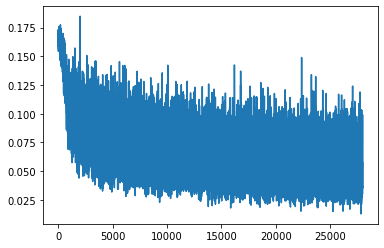

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.16469532251358032
Loss:  0.15258769690990448
Loss:  0.14922232925891876
0 **********
Epoch:  55.219321727752686  fold:  3  kers:  64
epoch:  1
29460 461
Loss:  0.13541482388973236
Loss:  0.11909094452857971
Loss:  0.12629076838493347
1 **********
Epoch:  98.95036840438843  fold:  3  kers:  64
epoch:  2
29460 461
Loss:  0.10130810737609863
Loss:  0.11163927614688873
Loss:  0.09622282534837723
2 **********
Epoch:  142.72629523277283  fold:  3  kers:  64
epoch:  3
Eval Loss:  0.9156139492988586
Eval Loss:  0.8488739728927612
Eval Loss:  0.3438592553138733


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1289  247]
 [ 594 1301]]
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1536
           1       0.84      0.69      0.76      1895

    accuracy                           0.75      3431
   macro avg       0.76      0.76      0.75      3431
weighted avg       0.77      0.75      0.75      3431

acc:  0.7548819586126494
pre:  0.8404392764857881
rec:  0.6865435356200528
ma F1:  0.7548789601292669
mi F1:  0.7548819586126494
we F1:  0.754968664757127
update!  Acc:  0.7548819586126494
Eval Loss:  0.4069671332836151
Eval Loss:  0.5919111967086792
Eval Loss:  0.3470635712146759
Eval Loss:  0.3357400596141815
Eval Loss:  0.43608376383781433
Eval Loss:  0.33556488156318665
Eval Loss:  0.5098763108253479
Eval Loss:  0.4085848927497864
Eval Loss:  0.39851298928260803
Eval Loss:  0.4238952696323395
Eval Loss:  0.4123859703540802
Eval Loss:  0.46464651823043823
Eval Loss:  0.470847487449646
Eval Loss:  0.30875831842422485
Eval Loss:  0.35148

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16371  2257]
 [ 2943  7889]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     18628
           1       0.78      0.73      0.75     10832

    accuracy                           0.82     29460
   macro avg       0.81      0.80      0.81     29460
weighted avg       0.82      0.82      0.82     29460

acc:  0.823489477257298
pre:  0.7775478020894934
rec:  0.7283050221565731
ma F1:  0.8075349905462834
mi F1:  0.823489477257298
we F1:  0.8221991238166289
29460 461
Loss:  0.12566740810871124
Loss:  0.0923333689570427
Loss:  0.12184661626815796
3 **********
Epoch:  225.6874258518219  fold:  3  kers:  64
epoch:  4
29460 461
Loss:  0.09310811012983322
Loss:  0.1096043512225151
Loss:  0.10519690811634064
4 **********
Epoch:  269.5650806427002  fold:  3  kers:  64
epoch:  5
29460 461
Loss:  0.09343037754297256
Loss:  0.0891290009021759
Loss:  0.08448101580142975
5 **********
Epoch:  315.5301525592804  fold:  3  kers:  64
epoch:  6
Eval Los

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1376  160]
 [ 705 1190]]
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      1536
           1       0.88      0.63      0.73      1895

    accuracy                           0.75      3431
   macro avg       0.77      0.76      0.75      3431
weighted avg       0.78      0.75      0.75      3431

acc:  0.747886913436316
pre:  0.8814814814814815
rec:  0.6279683377308707
ma F1:  0.7471437949453723
mi F1:  0.747886913436316
we F1:  0.7457094963526368
Eval Loss:  0.4124993681907654
Eval Loss:  0.6787745356559753
Eval Loss:  0.26927927136421204
Eval Loss:  0.33867231011390686
Eval Loss:  0.44384053349494934
Eval Loss:  0.27757298946380615
Eval Loss:  0.4950660765171051
Eval Loss:  0.4086255729198456
Eval Loss:  0.38405099511146545
Eval Loss:  0.42847439646720886
Eval Loss:  0.41264623403549194
Eval Loss:  0.4552895128726959
Eval Loss:  0.49774184823036194
Eval Loss:  0.29294490814208984
Eval Loss:  0.35705387592315674
Eval Loss:  0.400

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17526  1102]
 [ 3597  7235]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     18628
           1       0.87      0.67      0.75     10832

    accuracy                           0.84     29460
   macro avg       0.85      0.80      0.82     29460
weighted avg       0.84      0.84      0.84     29460

acc:  0.8404955872369314
pre:  0.8678181600095958
rec:  0.6679283604135894
ma F1:  0.8183268812781286
mi F1:  0.8404955872369314
we F1:  0.8351208985412544
29460 461
Loss:  0.0885770246386528
Loss:  0.10109344124794006
Loss:  0.053633999079465866
6 **********
Epoch:  401.48826837539673  fold:  3  kers:  64
epoch:  7
29460 461
Loss:  0.11378484219312668
Loss:  0.09189079701900482
Loss:  0.09107848256826401
7 **********
Epoch:  445.7638590335846  fold:  3  kers:  64
epoch:  8
29460 461
Loss:  0.08741994202136993
Loss:  0.10806699842214584
Loss:  0.06852657347917557
8 **********
Epoch:  489.6913800239563  fold:  3  kers:  64
epoch:  9
Ev

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1305  231]
 [ 522 1373]]
              precision    recall  f1-score   support

           0       0.71      0.85      0.78      1536
           1       0.86      0.72      0.78      1895

    accuracy                           0.78      3431
   macro avg       0.79      0.79      0.78      3431
weighted avg       0.79      0.78      0.78      3431

acc:  0.7805304575925386
pre:  0.8559850374064838
rec:  0.7245382585751979
ma F1:  0.7804442151051696
mi F1:  0.7805304575925386
we F1:  0.7808995247076032
update!  Acc:  0.7805304575925386
Eval Loss:  0.34783244132995605
Eval Loss:  0.5377157926559448
Eval Loss:  0.22014521062374115
Eval Loss:  0.26254913210868835
Eval Loss:  0.4107317626476288
Eval Loss:  0.23094624280929565
Eval Loss:  0.40255415439605713
Eval Loss:  0.3056165874004364
Eval Loss:  0.3377600610256195
Eval Loss:  0.3772185444831848
Eval Loss:  0.38163530826568604
Eval Loss:  0.3496777415275574
Eval Loss:  0.47040343284606934
Eval Loss:  0.25487270951271057
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17344  1284]
 [ 2696  8136]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18628
           1       0.86      0.75      0.80     10832

    accuracy                           0.86     29460
   macro avg       0.86      0.84      0.85     29460
weighted avg       0.86      0.86      0.86     29460

acc:  0.8649015614392397
pre:  0.8636942675159236
rec:  0.7511078286558346
ma F1:  0.8502743573111821
mi F1:  0.8649015614392398
we F1:  0.8626585540295071
29460 461
Loss:  0.09649115800857544
Loss:  0.06823543459177017
Loss:  0.05995915085077286
9 **********
Epoch:  572.2416098117828  fold:  3  kers:  64
epoch:  10
29460 461
Loss:  0.06453118473291397
Loss:  0.06209954991936684
Loss:  0.04691474139690399
10 **********
Epoch:  616.7146725654602  fold:  3  kers:  64
epoch:  11
29460 461
Loss:  0.09240784496068954
Loss:  0.05279037728905678
Loss:  0.07904880493879318
11 **********
Epoch:  661.556747674942  fold:  3  kers:  64
epoch:  12

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1303  233]
 [ 565 1330]]
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1536
           1       0.85      0.70      0.77      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.78      0.77      3431
weighted avg       0.78      0.77      0.77      3431

acc:  0.7674147478869134
pre:  0.8509277031349968
rec:  0.7018469656992085
ma F1:  0.7674003434873
mi F1:  0.7674147478869136
we F1:  0.7675918686525305
Eval Loss:  0.3725006878376007
Eval Loss:  0.5854833126068115
Eval Loss:  0.19337725639343262
Eval Loss:  0.2551600933074951
Eval Loss:  0.4023766815662384
Eval Loss:  0.2303926944732666
Eval Loss:  0.42226070165634155
Eval Loss:  0.3135501742362976
Eval Loss:  0.34396177530288696
Eval Loss:  0.377547025680542
Eval Loss:  0.376064658164978
Eval Loss:  0.35651278495788574
Eval Loss:  0.48309168219566345
Eval Loss:  0.2586374282836914
Eval Loss:  0.33063915371894836
Eval Loss:  0.3176760375

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17592  1036]
 [ 2844  7988]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     18628
           1       0.89      0.74      0.80     10832

    accuracy                           0.87     29460
   macro avg       0.87      0.84      0.85     29460
weighted avg       0.87      0.87      0.87     29460

acc:  0.868295994568907
pre:  0.8851950354609929
rec:  0.7374446085672083
ma F1:  0.8526344420767473
mi F1:  0.868295994568907
we F1:  0.8653476306678424
29460 461
Loss:  0.06955935060977936
Loss:  0.05755314230918884
Loss:  0.11650889366865158
12 **********
Epoch:  745.585024356842  fold:  3  kers:  64
epoch:  13
29460 461
Loss:  0.06557709723711014
Loss:  0.10647544264793396
Loss:  0.07165185362100601
13 **********
Epoch:  790.6764330863953  fold:  3  kers:  64
epoch:  14
29460 461
Loss:  0.05919933691620827
Loss:  0.07594721764326096
Loss:  0.07252907007932663
14 **********
Epoch:  835.7010202407837  fold:  3  kers:  64
epoch:  15


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1335  201]
 [ 641 1254]]
              precision    recall  f1-score   support

           0       0.68      0.87      0.76      1536
           1       0.86      0.66      0.75      1895

    accuracy                           0.75      3431
   macro avg       0.77      0.77      0.75      3431
weighted avg       0.78      0.75      0.75      3431

acc:  0.7545904983969688
pre:  0.8618556701030928
rec:  0.6617414248021108
ma F1:  0.7544536429469962
mi F1:  0.7545904983969688
we F1:  0.75384708607613
Eval Loss:  0.39678671956062317
Eval Loss:  0.6380395293235779
Eval Loss:  0.2011735737323761
Eval Loss:  0.28800565004348755
Eval Loss:  0.3865422308444977
Eval Loss:  0.2482573390007019
Eval Loss:  0.4215528070926666
Eval Loss:  0.347582072019577
Eval Loss:  0.33421891927719116
Eval Loss:  0.40709465742111206
Eval Loss:  0.3602128028869629
Eval Loss:  0.4011307954788208
Eval Loss:  0.47612303495407104
Eval Loss:  0.28229498863220215
Eval Loss:  0.3482213318347931
Eval Loss:  0.34487897

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17834   794]
 [ 3186  7646]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     18628
           1       0.91      0.71      0.79     10832

    accuracy                           0.86     29460
   macro avg       0.88      0.83      0.85     29460
weighted avg       0.87      0.86      0.86     29460

acc:  0.8649015614392397
pre:  0.9059241706161137
rec:  0.7058714918759232
ma F1:  0.8465496996231846
mi F1:  0.8649015614392398
we F1:  0.8605928007929887
29460 461
Loss:  0.06525667756795883
Loss:  0.0797441378235817
Loss:  0.08182615786790848
15 **********
Epoch:  917.7934744358063  fold:  3  kers:  64
epoch:  16
29460 461
Loss:  0.08352284878492355
Loss:  0.08172138035297394
Loss:  0.11036982387304306
16 **********
Epoch:  961.5265157222748  fold:  3  kers:  64
epoch:  17
29460 461
Loss:  0.07308352738618851
Loss:  0.12449689954519272
Loss:  0.11861484497785568
17 **********
Epoch:  1005.5118823051453  fold:  3  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1250  286]
 [ 489 1406]]
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1536
           1       0.83      0.74      0.78      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.78      0.77      3431
weighted avg       0.78      0.77      0.77      3431

acc:  0.7741183328475663
pre:  0.8309692671394799
rec:  0.7419525065963061
ma F1:  0.7736503957250207
mi F1:  0.7741183328475664
we F1:  0.7747272510262637
Eval Loss:  0.3140128552913666
Eval Loss:  0.3996325731277466
Eval Loss:  0.1707240641117096
Eval Loss:  0.23264068365097046
Eval Loss:  0.3454586863517761
Eval Loss:  0.2108113318681717
Eval Loss:  0.3330390155315399
Eval Loss:  0.2844589948654175
Eval Loss:  0.27950143814086914
Eval Loss:  0.33628639578819275
Eval Loss:  0.35150861740112305
Eval Loss:  0.2821260094642639
Eval Loss:  0.4223990738391876
Eval Loss:  0.21192023158073425
Eval Loss:  0.27677610516548157
Eval Loss:  0.27557

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17365  1263]
 [ 2077  8755]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     18628
           1       0.87      0.81      0.84     10832

    accuracy                           0.89     29460
   macro avg       0.88      0.87      0.88     29460
weighted avg       0.89      0.89      0.89     29460

acc:  0.8866259334691107
pre:  0.8739269315232582
rec:  0.8082533234859675
ma F1:  0.8760375151415511
mi F1:  0.8866259334691107
we F1:  0.8856248913647398
29460 461
Loss:  0.07394683361053467
Loss:  0.06656108796596527
Loss:  0.08865843713283539
18 **********
Epoch:  1087.4218242168427  fold:  3  kers:  64
epoch:  19
29460 461
Loss:  0.08980168402194977
Loss:  0.09126373380422592
Loss:  0.06848136335611343
19 **********
Epoch:  1131.1020069122314  fold:  3  kers:  64
epoch:  20
29460 461
Loss:  0.05736197903752327
Loss:  0.062246594578027725
Loss:  0.04131074622273445
20 **********
Epoch:  1174.711379289627  fold:  3  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1211  325]
 [ 465 1430]]
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1536
           1       0.81      0.75      0.78      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.77      0.77      3431
weighted avg       0.77      0.77      0.77      3431

acc:  0.769746429612358
pre:  0.8148148148148148
rec:  0.7546174142480211
ma F1:  0.768804483188045
mi F1:  0.769746429612358
we F1:  0.7703485871438823
Eval Loss:  0.2778341472148895
Eval Loss:  0.35819390416145325
Eval Loss:  0.16562777757644653
Eval Loss:  0.23442253470420837
Eval Loss:  0.3306201100349426
Eval Loss:  0.19769573211669922
Eval Loss:  0.2878532409667969
Eval Loss:  0.2954142689704895
Eval Loss:  0.26735445857048035
Eval Loss:  0.2938404977321625
Eval Loss:  0.36567187309265137
Eval Loss:  0.2615894675254822
Eval Loss:  0.415982186794281
Eval Loss:  0.20574596524238586
Eval Loss:  0.2196422964334488
Eval Loss:  0.26597136

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17198  1430]
 [ 1769  9063]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     18628
           1       0.86      0.84      0.85     10832

    accuracy                           0.89     29460
   macro avg       0.89      0.88      0.88     29460
weighted avg       0.89      0.89      0.89     29460

acc:  0.8914120841819416
pre:  0.8637186695892499
rec:  0.8366875923190547
ma F1:  0.8824485870651715
mi F1:  0.8914120841819416
we F1:  0.8910385592252625
29460 461
Loss:  0.07228536158800125
Loss:  0.06353569775819778
Loss:  0.08340757340192795
21 **********
Epoch:  1256.611347913742  fold:  3  kers:  64
epoch:  22
29460 461
Loss:  0.04643111303448677
Loss:  0.05268843099474907
Loss:  0.07566861063241959
22 **********
Epoch:  1300.3334186077118  fold:  3  kers:  64
epoch:  23
29460 461
Loss:  0.09998081624507904
Loss:  0.06026265397667885
Loss:  0.09685317426919937
23 **********
Epoch:  1344.1971106529236  fold:  3  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1253  283]
 [ 527 1368]]
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      1536
           1       0.83      0.72      0.77      1895

    accuracy                           0.76      3431
   macro avg       0.77      0.77      0.76      3431
weighted avg       0.77      0.76      0.76      3431

acc:  0.7639172252987467
pre:  0.8285887341005451
rec:  0.7218997361477573
ma F1:  0.7636516994972843
mi F1:  0.7639172252987467
we F1:  0.7644806017818494
Eval Loss:  0.31026482582092285
Eval Loss:  0.4055023193359375
Eval Loss:  0.1528569757938385
Eval Loss:  0.1976780742406845
Eval Loss:  0.3253815472126007
Eval Loss:  0.1918238401412964
Eval Loss:  0.31062835454940796
Eval Loss:  0.2686026096343994
Eval Loss:  0.24666856229305267
Eval Loss:  0.2943640947341919
Eval Loss:  0.33206480741500854
Eval Loss:  0.270940899848938
Eval Loss:  0.4045830965042114
Eval Loss:  0.2034090906381607
Eval Loss:  0.24436068534851074
Eval Loss:  0.2548010

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17544  1084]
 [ 2052  8780]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     18628
           1       0.89      0.81      0.85     10832

    accuracy                           0.89     29460
   macro avg       0.89      0.88      0.88     29460
weighted avg       0.89      0.89      0.89     29460

acc:  0.8935505770536321
pre:  0.8901054339010543
rec:  0.8105612998522895
ma F1:  0.8832152196083616
mi F1:  0.8935505770536321
we F1:  0.8924090177191932
29460 461
Loss:  0.04758751392364502
Loss:  0.04684172943234444
Loss:  0.0361894816160202
24 **********
Epoch:  1425.9674260616302  fold:  3  kers:  64
epoch:  25
29460 461
Loss:  0.0654011145234108
Loss:  0.05933946371078491
Loss:  0.051077116280794144
25 **********
Epoch:  1469.4810543060303  fold:  3  kers:  64
epoch:  26
29460 461
Loss:  0.07873060554265976
Loss:  0.04521023854613304
Loss:  0.056973639875650406
26 **********
Epoch:  1512.9627680778503  fold:  3  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1226  310]
 [ 494 1401]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      1536
           1       0.82      0.74      0.78      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.77      0.77      3431
weighted avg       0.77      0.77      0.77      3431

acc:  0.76566598659283
pre:  0.8188194038573934
rec:  0.7393139841688654
ma F1:  0.7650547613110009
mi F1:  0.76566598659283
we F1:  0.7663086463177248
Eval Loss:  0.31207773089408875
Eval Loss:  0.3935874402523041
Eval Loss:  0.1544809192419052
Eval Loss:  0.20830227434635162
Eval Loss:  0.31299692392349243
Eval Loss:  0.1857951134443283
Eval Loss:  0.286825954914093
Eval Loss:  0.2824353575706482
Eval Loss:  0.2598731815814972
Eval Loss:  0.27491506934165955
Eval Loss:  0.35177385807037354
Eval Loss:  0.24388696253299713
Eval Loss:  0.39243099093437195
Eval Loss:  0.19182828068733215
Eval Loss:  0.21748246252536774
Eval Loss:  0.2429604

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17368  1260]
 [ 1719  9113]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     18628
           1       0.88      0.84      0.86     10832

    accuracy                           0.90     29460
   macro avg       0.89      0.89      0.89     29460
weighted avg       0.90      0.90      0.90     29460

acc:  0.8988798370672098
pre:  0.8785308011182879
rec:  0.8413035450516987
ma F1:  0.8902635625541754
mi F1:  0.8988798370672098
we F1:  0.8984007492414698
29460 461
Loss:  0.08116745948791504
Loss:  0.0732700377702713
Loss:  0.0711015835404396
27 **********
Epoch:  1594.5336167812347  fold:  3  kers:  64
epoch:  28
29460 461
Loss:  0.05940576642751694
Loss:  0.09148120135068893
Loss:  0.04843085631728172
28 **********
Epoch:  1638.0362741947174  fold:  3  kers:  64
epoch:  29
29460 461
Loss:  0.04422914609313011
Loss:  0.07231420278549194
Loss:  0.05385323241353035
29 **********
Epoch:  1681.5329480171204  fold:  3  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1253  283]
 [ 543 1352]]
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      1536
           1       0.83      0.71      0.77      1895

    accuracy                           0.76      3431
   macro avg       0.76      0.76      0.76      3431
weighted avg       0.77      0.76      0.76      3431

acc:  0.7592538618478578
pre:  0.8269113149847095
rec:  0.7134564643799473
ma F1:  0.7590532530292571
mi F1:  0.7592538618478578
we F1:  0.7597807132906477
Eval Loss:  0.29272305965423584
Eval Loss:  0.381645530462265
Eval Loss:  0.1482210010290146
Eval Loss:  0.16457930207252502
Eval Loss:  0.2972394526004791
Eval Loss:  0.18159940838813782
Eval Loss:  0.27733197808265686
Eval Loss:  0.24306721985340118
Eval Loss:  0.23105745017528534
Eval Loss:  0.2588704526424408
Eval Loss:  0.31819143891334534
Eval Loss:  0.24288880825042725
Eval Loss:  0.37019750475883484
Eval Loss:  0.17497022449970245
Eval Loss:  0.21713553369045258
Eval Loss:  0.2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17679   949]
 [ 1884  8948]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     18628
           1       0.90      0.83      0.86     10832

    accuracy                           0.90     29460
   macro avg       0.90      0.89      0.89     29460
weighted avg       0.90      0.90      0.90     29460

acc:  0.9038357094365241
pre:  0.9041123572799838
rec:  0.8260709010339734
ma F1:  0.8945758919491573
mi F1:  0.9038357094365241
we F1:  0.9028440785407862
29460 461
Loss:  0.06636698544025421
Loss:  0.06008240953087807
Loss:  0.045981306582689285
30 **********
Epoch:  1763.4528634548187  fold:  3  kers:  64
epoch:  31
29460 461
Loss:  0.08191031962633133
Loss:  0.06413061171770096
Loss:  0.05155586823821068
31 **********
Epoch:  1806.935574054718  fold:  3  kers:  64
epoch:  32
29460 461
Loss:  0.04064870625734329
Loss:  0.09541764110326767
Loss:  0.02198217064142227
32 **********
Epoch:  1850.5758635997772  fold:  3  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1339  197]
 [ 665 1230]]
              precision    recall  f1-score   support

           0       0.67      0.87      0.76      1536
           1       0.86      0.65      0.74      1895

    accuracy                           0.75      3431
   macro avg       0.77      0.76      0.75      3431
weighted avg       0.78      0.75      0.75      3431

acc:  0.7487612940833577
pre:  0.861948142957253
rec:  0.6490765171503958
ma F1:  0.7485074677632764
mi F1:  0.7487612940833577
we F1:  0.7476714709842937
Eval Loss:  0.3686223030090332
Eval Loss:  0.5068472027778625
Eval Loss:  0.16868700087070465
Eval Loss:  0.21747761964797974
Eval Loss:  0.347096711397171
Eval Loss:  0.20606793463230133
Eval Loss:  0.3340713083744049
Eval Loss:  0.29668912291526794
Eval Loss:  0.23427142202854156
Eval Loss:  0.3249753415584564
Eval Loss:  0.30079010128974915
Eval Loss:  0.3190723657608032
Eval Loss:  0.36741477251052856
Eval Loss:  0.19812391698360443
Eval Loss:  0.2702482342720032
Eval Loss:  0.28090

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[18039   589]
 [ 2832  8000]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     18628
           1       0.93      0.74      0.82     10832

    accuracy                           0.88     29460
   macro avg       0.90      0.85      0.87     29460
weighted avg       0.89      0.88      0.88     29460

acc:  0.8838764426340802
pre:  0.9314239143089998
rec:  0.7385524372230429
ma F1:  0.8686203417749645
mi F1:  0.8838764426340802
we F1:  0.8804677929451672
29460 461
Loss:  0.10297539830207825
Loss:  0.08685872703790665
Loss:  0.05191450193524361
33 **********
Epoch:  1932.2883336544037  fold:  3  kers:  64
epoch:  34
29460 461
Loss:  0.04737917706370354
Loss:  0.047206632792949677
Loss:  0.08630950003862381
34 **********
Epoch:  1975.808943271637  fold:  3  kers:  64
epoch:  35
29460 461
Loss:  0.09053989499807358
Loss:  0.07795697450637817
Loss:  0.047330886125564575
35 **********
Epoch:  2019.368448972702  fold:  3  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1203  333]
 [ 507 1388]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1536
           1       0.81      0.73      0.77      1895

    accuracy                           0.76      3431
   macro avg       0.76      0.76      0.75      3431
weighted avg       0.76      0.76      0.76      3431

acc:  0.7551734188283299
pre:  0.8065078442765834
rec:  0.7324538258575198
ma F1:  0.7544595390378355
mi F1:  0.7551734188283299
we F1:  0.7558448517123625
Eval Loss:  0.30196502804756165
Eval Loss:  0.3105423152446747
Eval Loss:  0.15408146381378174
Eval Loss:  0.2045634388923645
Eval Loss:  0.2795756161212921
Eval Loss:  0.19369103014469147
Eval Loss:  0.2572326064109802
Eval Loss:  0.2458788901567459
Eval Loss:  0.22944653034210205
Eval Loss:  0.21041813492774963
Eval Loss:  0.3598901927471161
Eval Loss:  0.2072327584028244
Eval Loss:  0.35298657417297363
Eval Loss:  0.15159748494625092
Eval Loss:  0.21905015408992767
Eval Loss:  0.203

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17220  1408]
 [ 1294  9538]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     18628
           1       0.87      0.88      0.88     10832

    accuracy                           0.91     29460
   macro avg       0.90      0.90      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9082824168363883
pre:  0.8713685364516719
rec:  0.8805391432791728
ma F1:  0.9015910024041733
mi F1:  0.9082824168363883
we F1:  0.9083817166600375
29460 461
Loss:  0.08740770816802979
Loss:  0.05480610206723213
Loss:  0.06030827388167381
36 **********
Epoch:  2102.4831688404083  fold:  3  kers:  64
epoch:  37
29460 461
Loss:  0.0715557187795639
Loss:  0.06182204186916351
Loss:  0.05767456069588661
37 **********
Epoch:  2146.0267169475555  fold:  3  kers:  64
epoch:  38
29460 461
Loss:  0.06491328030824661
Loss:  0.052552103996276855
Loss:  0.0525827631354332
38 **********
Epoch:  2189.6570332050323  fold:  3  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1236  300]
 [ 501 1394]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.76      1536
           1       0.82      0.74      0.78      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.77      0.77      3431
weighted avg       0.77      0.77      0.77      3431

acc:  0.7665403672398717
pre:  0.8229043683589138
rec:  0.7356200527704485
ma F1:  0.7660442246511965
mi F1:  0.7665403672398717
we F1:  0.7671715359760981
Eval Loss:  0.28835251927375793
Eval Loss:  0.3387945890426636
Eval Loss:  0.15522022545337677
Eval Loss:  0.193772554397583
Eval Loss:  0.2761315405368805
Eval Loss:  0.17401008307933807
Eval Loss:  0.23865553736686707
Eval Loss:  0.26058000326156616
Eval Loss:  0.17927822470664978
Eval Loss:  0.19369326531887054
Eval Loss:  0.3089347183704376
Eval Loss:  0.22493340075016022
Eval Loss:  0.3245828151702881
Eval Loss:  0.14492391049861908
Eval Loss:  0.21141184866428375
Eval Loss:  0.20

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17550  1078]
 [ 1617  9215]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18628
           1       0.90      0.85      0.87     10832

    accuracy                           0.91     29460
   macro avg       0.91      0.90      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.908520027155465
pre:  0.8952686291654522
rec:  0.8507200886262924
ma F1:  0.9005601536160116
mi F1:  0.908520027155465
we F1:  0.9080052854832676
29460 461
Loss:  0.0406276099383831
Loss:  0.035993825644254684
Loss:  0.057872746139764786
39 **********
Epoch:  2269.9911890029907  fold:  3  kers:  64
epoch:  40
29460 461
Loss:  0.09178373217582703
Loss:  0.03797803446650505
Loss:  0.06853016465902328
40 **********
Epoch:  2313.5666522979736  fold:  3  kers:  64
epoch:  41
29460 461
Loss:  0.04678665101528168
Loss:  0.05257122963666916
Loss:  0.07249339669942856
41 **********
Epoch:  2357.1111977100372  fold:  3  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1281  255]
 [ 613 1282]]
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1536
           1       0.83      0.68      0.75      1895

    accuracy                           0.75      3431
   macro avg       0.76      0.76      0.75      3431
weighted avg       0.76      0.75      0.75      3431

acc:  0.7470125327892743
pre:  0.8340923877683799
rec:  0.6765171503957783
ma F1:  0.7470125112982255
mi F1:  0.7470125327892742
we F1:  0.7470202265847018
Eval Loss:  0.27983954548835754
Eval Loss:  0.3641832768917084
Eval Loss:  0.1579606980085373
Eval Loss:  0.20127931237220764
Eval Loss:  0.27852165699005127
Eval Loss:  0.21160294115543365
Eval Loss:  0.2572973668575287
Eval Loss:  0.24379432201385498
Eval Loss:  0.1915736198425293
Eval Loss:  0.19953255355358124
Eval Loss:  0.29178401827812195
Eval Loss:  0.24045801162719727
Eval Loss:  0.32712799310684204
Eval Loss:  0.14913542568683624
Eval Loss:  0.2211730182170868
Eval Loss:  0.2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17800   828]
 [ 1898  8934]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     18628
           1       0.92      0.82      0.87     10832

    accuracy                           0.91     29460
   macro avg       0.91      0.89      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9074677528852682
pre:  0.915181315304241
rec:  0.8247784342688331
ma F1:  0.8982523493104353
mi F1:  0.9074677528852682
we F1:  0.9063555848472497
29460 461
Loss:  0.0768221840262413
Loss:  0.028448032215237617
Loss:  0.037969447672367096
42 **********
Epoch:  2437.5650339126587  fold:  3  kers:  64
epoch:  43
29460 461
Loss:  0.033171720802783966
Loss:  0.06046157330274582
Loss:  0.05572753772139549
43 **********
Epoch:  2481.2272646427155  fold:  3  kers:  64
epoch:  44
29460 461
Loss:  0.03604617714881897
Loss:  0.040170785039663315
Loss:  0.0416388213634491
44 **********
Epoch:  2524.7229409217834  fold:  3  kers:  64
epoc

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1224  312]
 [ 509 1386]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      1536
           1       0.82      0.73      0.77      1895

    accuracy                           0.76      3431
   macro avg       0.76      0.76      0.76      3431
weighted avg       0.77      0.76      0.76      3431

acc:  0.7607111629262606
pre:  0.8162544169611308
rec:  0.7313984168865435
ma F1:  0.7601764996806866
mi F1:  0.7607111629262606
we F1:  0.7613613398360015
Eval Loss:  0.2757033705711365
Eval Loss:  0.2878192961215973
Eval Loss:  0.16305528581142426
Eval Loss:  0.1887255609035492
Eval Loss:  0.26949161291122437
Eval Loss:  0.18134082853794098
Eval Loss:  0.23577623069286346
Eval Loss:  0.23875407874584198
Eval Loss:  0.19705305993556976
Eval Loss:  0.16381309926509857
Eval Loss:  0.30853593349456787
Eval Loss:  0.22128203511238098
Eval Loss:  0.34338000416755676
Eval Loss:  0.13894976675510406
Eval Loss:  0.20821289718151093
Eval Loss:  0

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17336  1292]
 [ 1266  9566]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     18628
           1       0.88      0.88      0.88     10832

    accuracy                           0.91     29460
   macro avg       0.91      0.91      0.91     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9131704005431093
pre:  0.8810093939952109
rec:  0.8831240768094535
ma F1:  0.9066787183999578
mi F1:  0.9131704005431093
we F1:  0.9131921230316192
29460 461
Loss:  0.03363119438290596
Loss:  0.03040068969130516
Loss:  0.07344307005405426
45 **********
Epoch:  2605.217668056488  fold:  3  kers:  64
epoch:  46
29460 461
Loss:  0.0496886782348156
Loss:  0.07077688723802567
Loss:  0.048084549605846405
46 **********
Epoch:  2650.5863349437714  fold:  3  kers:  64
epoch:  47
29460 461
Loss:  0.0403071865439415
Loss:  0.03390626609325409
Loss:  0.05663251504302025
47 **********
Epoch:  2696.124548435211  fold:  3  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1276  260]
 [ 606 1289]]
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1536
           1       0.83      0.68      0.75      1895

    accuracy                           0.75      3431
   macro avg       0.76      0.76      0.75      3431
weighted avg       0.76      0.75      0.75      3431

acc:  0.7475954532206354
pre:  0.8321497740477728
rec:  0.6802110817941952
ma F1:  0.7475918295503275
mi F1:  0.7475954532206353
we F1:  0.7476918985995963
Eval Loss:  0.29113665223121643
Eval Loss:  0.3217543065547943
Eval Loss:  0.1682245135307312
Eval Loss:  0.18138852715492249
Eval Loss:  0.24908672273159027
Eval Loss:  0.19976940751075745
Eval Loss:  0.24915318191051483
Eval Loss:  0.21738532185554504
Eval Loss:  0.1945081204175949
Eval Loss:  0.18537260591983795
Eval Loss:  0.2757476568222046
Eval Loss:  0.233534574508667
Eval Loss:  0.31060054898262024
Eval Loss:  0.14943039417266846
Eval Loss:  0.21489277482032776
Eval Loss:  0.19

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17811   817]
 [ 1746  9086]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     18628
           1       0.92      0.84      0.88     10832

    accuracy                           0.91     29460
   macro avg       0.91      0.90      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.913000678886626
pre:  0.9174997475512471
rec:  0.8388109305760709
ma F1:  0.904635987925599
mi F1:  0.9130006788866261
we F1:  0.9121100430238417
29460 461
Loss:  0.042252663522958755
Loss:  0.07368892431259155
Loss:  0.06586799025535583
48 **********
Epoch:  2777.629573583603  fold:  3  kers:  64
epoch:  49
29460 461
Loss:  0.061617203056812286
Loss:  0.07165946066379547
Loss:  0.06666096299886703
49 **********
Epoch:  2821.5321617126465  fold:  3  kers:  64
epoch:  50
29460 461
Loss:  0.06175772845745087
Loss:  0.04527087137103081
Loss:  0.056038010865449905
50 **********
Epoch:  2865.336013317108  fold:  3  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1207  329]
 [ 505 1390]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.74      1536
           1       0.81      0.73      0.77      1895

    accuracy                           0.76      3431
   macro avg       0.76      0.76      0.76      3431
weighted avg       0.76      0.76      0.76      3431

acc:  0.7569221801224133
pre:  0.8086096567771961
rec:  0.7335092348284961
ma F1:  0.7562286851079955
mi F1:  0.7569221801224133
we F1:  0.7575891480051321
Eval Loss:  0.258405476808548
Eval Loss:  0.26110023260116577
Eval Loss:  0.17804862558841705
Eval Loss:  0.19349201023578644
Eval Loss:  0.2489304542541504
Eval Loss:  0.18060952425003052
Eval Loss:  0.20918400585651398
Eval Loss:  0.22662679851055145
Eval Loss:  0.21833719313144684
Eval Loss:  0.1583113819360733
Eval Loss:  0.30229949951171875
Eval Loss:  0.2099728286266327
Eval Loss:  0.31224900484085083
Eval Loss:  0.13430628180503845
Eval Loss:  0.19744980335235596
Eval Loss:  0.1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17198  1430]
 [ 1001  9831]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     18628
           1       0.87      0.91      0.89     10832

    accuracy                           0.92     29460
   macro avg       0.91      0.92      0.91     29460
weighted avg       0.92      0.92      0.92     29460

acc:  0.9174813306177868
pre:  0.8730130539028506
rec:  0.9075886262924667
ma F1:  0.9119768984818987
mi F1:  0.9174813306177868
we F1:  0.9178018683382014
29460 461
Loss:  0.03616315498948097
Loss:  0.053256578743457794
Loss:  0.040417592972517014
51 **********
Epoch:  2946.5099239349365  fold:  3  kers:  64
epoch:  52
29460 461
Loss:  0.0627727210521698
Loss:  0.05821114033460617
Loss:  0.03746112808585167
52 **********
Epoch:  2990.6129760742188  fold:  3  kers:  64
epoch:  53
29460 461
Loss:  0.05110981687903404
Loss:  0.06098027527332306
Loss:  0.04672377556562424
53 **********
Epoch:  3034.72500371933  fold:  3  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1227  309]
 [ 528 1367]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      1536
           1       0.82      0.72      0.77      1895

    accuracy                           0.76      3431
   macro avg       0.76      0.76      0.76      3431
weighted avg       0.76      0.76      0.76      3431

acc:  0.7560477994753716
pre:  0.8156324582338902
rec:  0.7213720316622692
ma F1:  0.7556409412702907
mi F1:  0.7560477994753715
we F1:  0.7566842419533198
Eval Loss:  0.29591190814971924
Eval Loss:  0.3054710030555725
Eval Loss:  0.16431988775730133
Eval Loss:  0.19306990504264832
Eval Loss:  0.2733671963214874
Eval Loss:  0.17255830764770508
Eval Loss:  0.227024644613266
Eval Loss:  0.2299574613571167
Eval Loss:  0.2153039574623108
Eval Loss:  0.1726459562778473
Eval Loss:  0.2821705639362335
Eval Loss:  0.22510024905204773
Eval Loss:  0.30648118257522583
Eval Loss:  0.1413138508796692
Eval Loss:  0.21653366088867188
Eval Loss:  0.17039

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17454  1174]
 [ 1332  9500]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18628
           1       0.89      0.88      0.88     10832

    accuracy                           0.91     29460
   macro avg       0.91      0.91      0.91     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9149355057705363
pre:  0.8900131159827619
rec:  0.8770310192023634
ma F1:  0.9082470522397723
mi F1:  0.9149355057705363
we F1:  0.9148026448630859
29460 461
Loss:  0.0619230717420578
Loss:  0.04147614166140556
Loss:  0.041117895394563675
54 **********
Epoch:  3115.9787006378174  fold:  3  kers:  64
epoch:  55
29460 461
Loss:  0.039985839277505875
Loss:  0.059620801359415054
Loss:  0.040760330855846405
55 **********
Epoch:  3160.6941151618958  fold:  3  kers:  64
epoch:  56
29460 461
Loss:  0.06943252682685852
Loss:  0.03868955746293068
Loss:  0.05111189931631088
56 **********
Epoch:  3206.2103872299194  fold:  3  kers:  64
ep

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1257  279]
 [ 580 1315]]
              precision    recall  f1-score   support

           0       0.68      0.82      0.75      1536
           1       0.82      0.69      0.75      1895

    accuracy                           0.75      3431
   macro avg       0.75      0.76      0.75      3431
weighted avg       0.76      0.75      0.75      3431

acc:  0.7496356747303993
pre:  0.8249686323713927
rec:  0.6939313984168866
ma F1:  0.7495641080089328
mi F1:  0.7496356747303993
we F1:  0.750007081336631
Eval Loss:  0.2919323444366455
Eval Loss:  0.30441686511039734
Eval Loss:  0.14140507578849792
Eval Loss:  0.19577530026435852
Eval Loss:  0.25208041071891785
Eval Loss:  0.17513491213321686
Eval Loss:  0.2401786893606186
Eval Loss:  0.22243571281433105
Eval Loss:  0.21809779107570648
Eval Loss:  0.16099900007247925
Eval Loss:  0.28593817353248596
Eval Loss:  0.21088798344135284
Eval Loss:  0.2999843955039978
Eval Loss:  0.1423702985048294
Eval Loss:  0.21980613470077515
Eval Loss:  0.1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17550  1078]
 [ 1373  9459]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18628
           1       0.90      0.87      0.89     10832

    accuracy                           0.92     29460
   macro avg       0.91      0.91      0.91     29460
weighted avg       0.92      0.92      0.92     29460

acc:  0.9168024439918534
pre:  0.897693840751637
rec:  0.8732459379615952
ma F1:  0.9100149530178196
mi F1:  0.9168024439918534
we F1:  0.916554970275707
29460 461
Loss:  0.06709931045770645
Loss:  0.06644903123378754
Loss:  0.060230277478694916
57 **********
Epoch:  3289.7599444389343  fold:  3  kers:  64
epoch:  58
29460 461
Loss:  0.06542520970106125
Loss:  0.05919073149561882
Loss:  0.058167293667793274
58 **********
Epoch:  3333.6844737529755  fold:  3  kers:  64
epoch:  59
29460 461
Loss:  0.05477526783943176
Loss:  0.056127458810806274
Loss:  0.05928642675280571
59 **********
Epoch:  3377.6588699817657  fold:  3  kers:  64
Eval

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


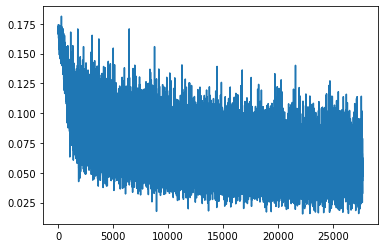

------
*********
29520 3371
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.16984258592128754
Loss:  0.1651126593351364
Loss:  0.16130998730659485
0 **********
Epoch:  57.492241859436035  fold:  4  kers:  64
epoch:  1
29520 462
Loss:  0.1515062004327774
Loss:  0.11600435525178909
Loss:  0.13366878032684326
1 **********
Epoch:  102.72626948356628  fold:  4  kers:  64
epoch:  2
29520 462
Loss:  0.11701112985610962
Loss:  0.09762576967477798
Loss:  0.09986038506031036
2 **********
Epoch:  147.4237322807312  fold:  4  kers:  64
epoch:  3
Eval Loss:  0.3650134205818176
Eval Loss:  0.33631229400634766
Eval Loss:  0.12069930136203766


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2839  298]
 [ 165   69]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.92      3137
           1       0.19      0.29      0.23       234

    accuracy                           0.86      3371
   macro avg       0.57      0.60      0.58      3371
weighted avg       0.89      0.86      0.88      3371

acc:  0.8626520320379709
pre:  0.1880108991825613
rec:  0.2948717948717949
ma F1:  0.5771112088331314
mi F1:  0.8626520320379709
we F1:  0.8763621148849904
update!  Acc:  0.8626520320379709
Eval Loss:  0.43116194009780884
Eval Loss:  0.43603771924972534
Eval Loss:  0.31232014298439026
Eval Loss:  0.33764761686325073
Eval Loss:  0.3658904731273651
Eval Loss:  0.34613752365112305
Eval Loss:  0.4504857361316681
Eval Loss:  0.3219551742076874
Eval Loss:  0.445011168718338
Eval Loss:  0.4175216853618622
Eval Loss:  0.5189298391342163
Eval Loss:  0.40158015489578247
Eval Loss:  0.5069758892059326
Eval Loss:  0.4373270869255066
Eval Loss:  0.431

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[14688  2339]
 [ 3005  9488]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85     17027
           1       0.80      0.76      0.78     12493

    accuracy                           0.82     29520
   macro avg       0.82      0.81      0.81     29520
weighted avg       0.82      0.82      0.82     29520

acc:  0.8189701897018971
pre:  0.8022321806037034
rec:  0.7594653005683183
ma F1:  0.8131730536017463
mi F1:  0.8189701897018971
we F1:  0.8182277103475316
29520 462
Loss:  0.10763256251811981
Loss:  0.10201726853847504
Loss:  0.0922783687710762
3 **********
Epoch:  229.7565426826477  fold:  4  kers:  64
epoch:  4
29520 462
Loss:  0.1124800443649292
Loss:  0.10720005631446838
Loss:  0.09974930435419083
4 **********
Epoch:  273.92741322517395  fold:  4  kers:  64
epoch:  5
29520 462
Loss:  0.10455374419689178
Loss:  0.14025820791721344
Loss:  0.07937388122081757
5 **********
Epoch:  318.09628891944885  fold:  4  kers:  64
epoch:  6
Eva

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3084   53]
 [ 220   14]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3137
           1       0.21      0.06      0.09       234

    accuracy                           0.92      3371
   macro avg       0.57      0.52      0.53      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.9190151290418274
pre:  0.208955223880597
rec:  0.05982905982905983
ma F1:  0.5253192664724169
mi F1:  0.9190151290418275
we F1:  0.8975991000356086
update!  Acc:  0.9190151290418274
Eval Loss:  0.46162137389183044
Eval Loss:  0.4515906870365143
Eval Loss:  0.30278313159942627
Eval Loss:  0.4192143678665161
Eval Loss:  0.40897136926651
Eval Loss:  0.3623087704181671
Eval Loss:  0.5153566598892212
Eval Loss:  0.3518690764904022
Eval Loss:  0.45293128490448
Eval Loss:  0.3983461856842041
Eval Loss:  0.5258300304412842
Eval Loss:  0.4270683825016022
Eval Loss:  0.5280987620353699
Eval Loss:  0.39549314975738525
Eval Loss:  0.435171872

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16061   966]
 [ 4187  8306]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     17027
           1       0.90      0.66      0.76     12493

    accuracy                           0.83     29520
   macro avg       0.84      0.80      0.81     29520
weighted avg       0.84      0.83      0.82     29520

acc:  0.825440379403794
pre:  0.8958153580672994
rec:  0.6648523172976867
ma F1:  0.812500474937842
mi F1:  0.825440379403794
we F1:  0.8200658555759628
29520 462
Loss:  0.10336188971996307
Loss:  0.07354825735092163
Loss:  0.08488265424966812
6 **********
Epoch:  399.8137459754944  fold:  4  kers:  64
epoch:  7
29520 462
Loss:  0.09282618016004562
Loss:  0.0992036685347557
Loss:  0.06707629561424255
7 **********
Epoch:  443.9527015686035  fold:  4  kers:  64
epoch:  8
29520 462
Loss:  0.08986381441354752
Loss:  0.07512246817350388
Loss:  0.09955330938100815
8 **********
Epoch:  488.324036359787  fold:  4  kers:  64
epoch:  9
Eval Los

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3089   48]
 [ 224   10]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3137
           1       0.17      0.04      0.07       234

    accuracy                           0.92      3371
   macro avg       0.55      0.51      0.51      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.919311776920795
pre:  0.1724137931034483
rec:  0.042735042735042736
ma F1:  0.5131613040246363
mi F1:  0.919311776920795
we F1:  0.8960956407630413
update!  Acc:  0.919311776920795
Eval Loss:  0.41134560108184814
Eval Loss:  0.4252261519432068
Eval Loss:  0.32741987705230713
Eval Loss:  0.40316057205200195
Eval Loss:  0.3680573105812073
Eval Loss:  0.36784905195236206
Eval Loss:  0.5156110525131226
Eval Loss:  0.3316787779331207
Eval Loss:  0.4195902347564697
Eval Loss:  0.3880011737346649
Eval Loss:  0.5219550728797913
Eval Loss:  0.43535229563713074
Eval Loss:  0.5016295313835144
Eval Loss:  0.3820399343967438
Eval Loss:  0.4042

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16157   870]
 [ 4070  8423]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     17027
           1       0.91      0.67      0.77     12493

    accuracy                           0.83     29520
   macro avg       0.85      0.81      0.82     29520
weighted avg       0.84      0.83      0.83     29520

acc:  0.8326558265582655
pre:  0.9063811470999678
rec:  0.6742175618346274
ma F1:  0.820322832515535
mi F1:  0.8326558265582655
we F1:  0.8275529585809269
29520 462
Loss:  0.07873275130987167
Loss:  0.07146503031253815
Loss:  0.07068724930286407
9 **********
Epoch:  569.9646980762482  fold:  4  kers:  64
epoch:  10
29520 462
Loss:  0.10026507824659348
Loss:  0.07630153000354767
Loss:  0.09151923656463623
10 **********
Epoch:  613.9311153888702  fold:  4  kers:  64
epoch:  11
29520 462
Loss:  0.10303977876901627
Loss:  0.06019207090139389
Loss:  0.08564188331365585
11 **********
Epoch:  657.8297140598297  fold:  4  kers:  64
epoch:  12

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3083   54]
 [ 219   15]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3137
           1       0.22      0.06      0.10       234

    accuracy                           0.92      3371
   macro avg       0.58      0.52      0.53      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.9190151290418274
pre:  0.21739130434782608
rec:  0.0641025641025641
ma F1:  0.5283060065596559
mi F1:  0.9190151290418275
we F1:  0.8980024154793897
Eval Loss:  0.3645055890083313
Eval Loss:  0.3757472336292267
Eval Loss:  0.2956151068210602
Eval Loss:  0.3617057502269745
Eval Loss:  0.3175103962421417
Eval Loss:  0.34463179111480713
Eval Loss:  0.4706850051879883
Eval Loss:  0.2974986732006073
Eval Loss:  0.36379125714302063
Eval Loss:  0.3452933132648468
Eval Loss:  0.48338449001312256
Eval Loss:  0.3631918132305145
Eval Loss:  0.4506208598613739
Eval Loss:  0.3144267499446869
Eval Loss:  0.36358535289764404
Eval Loss:  0.325028

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16091   936]
 [ 3506  8987]]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     17027
           1       0.91      0.72      0.80     12493

    accuracy                           0.85     29520
   macro avg       0.86      0.83      0.84     29520
weighted avg       0.86      0.85      0.85     29520

acc:  0.8495257452574526
pre:  0.9056736873929255
rec:  0.7193628431921876
ma F1:  0.8402756924234047
mi F1:  0.8495257452574526
we F1:  0.846179371977117
29520 462
Loss:  0.09010904282331467
Loss:  0.05009063333272934
Loss:  0.0987800657749176
12 **********
Epoch:  739.2090752124786  fold:  4  kers:  64
epoch:  13
29520 462
Loss:  0.05160055682063103
Loss:  0.07234456390142441
Loss:  0.05954957753419876
13 **********
Epoch:  783.1585376262665  fold:  4  kers:  64
epoch:  14
29520 462
Loss:  0.1031094640493393
Loss:  0.07207921147346497
Loss:  0.08328796923160553
14 **********
Epoch:  827.1199684143066  fold:  4  kers:  64
epoch:  15


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3073   64]
 [ 212   22]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.26      0.09      0.14       234

    accuracy                           0.92      3371
   macro avg       0.60      0.54      0.55      3371
weighted avg       0.89      0.92      0.90      3371

acc:  0.9181251854049244
pre:  0.2558139534883721
rec:  0.09401709401709402
ma F1:  0.5472613671753348
mi F1:  0.9181251854049244
we F1:  0.9001350690175173
Eval Loss:  0.32989275455474854
Eval Loss:  0.3195362091064453
Eval Loss:  0.2739376723766327
Eval Loss:  0.3201735317707062
Eval Loss:  0.27302244305610657
Eval Loss:  0.321368008852005
Eval Loss:  0.39009231328964233
Eval Loss:  0.29646873474121094
Eval Loss:  0.30002349615097046
Eval Loss:  0.35354653000831604
Eval Loss:  0.4268835783004761
Eval Loss:  0.3398902714252472
Eval Loss:  0.38501518964767456
Eval Loss:  0.29623445868492126
Eval Loss:  0.31705427169799805
Eval Loss:  0.27

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15856  1171]
 [ 2926  9567]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.89     17027
           1       0.89      0.77      0.82     12493

    accuracy                           0.86     29520
   macro avg       0.87      0.85      0.85     29520
weighted avg       0.86      0.86      0.86     29520

acc:  0.8612127371273712
pre:  0.8909480350158316
rec:  0.7657888417513807
ma F1:  0.8546141234582301
mi F1:  0.8612127371273712
we F1:  0.8593713367474471
29520 462
Loss:  0.05724858492612839
Loss:  0.06672313809394836
Loss:  0.06623562425374985
15 **********
Epoch:  908.2240655422211  fold:  4  kers:  64
epoch:  16
29520 462
Loss:  0.08538536727428436
Loss:  0.07682366669178009
Loss:  0.09255718439817429
16 **********
Epoch:  951.8663494586945  fold:  4  kers:  64
epoch:  17
29520 462
Loss:  0.07663864642381668
Loss:  0.06798066198825836
Loss:  0.08435600996017456
17 **********
Epoch:  995.3829698562622  fold:  4  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3058   79]
 [ 209   25]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3137
           1       0.24      0.11      0.15       234

    accuracy                           0.91      3371
   macro avg       0.59      0.54      0.55      3371
weighted avg       0.89      0.91      0.90      3371

acc:  0.9145654108573124
pre:  0.2403846153846154
rec:  0.10683760683760683
ma F1:  0.5514785507578474
mi F1:  0.9145654108573124
we F1:  0.8990028352513347
Eval Loss:  0.29323339462280273
Eval Loss:  0.2859005331993103
Eval Loss:  0.24001654982566833
Eval Loss:  0.294989675283432
Eval Loss:  0.2700727581977844
Eval Loss:  0.28440555930137634
Eval Loss:  0.31831222772598267
Eval Loss:  0.2729141414165497
Eval Loss:  0.2782320976257324
Eval Loss:  0.3322042226791382
Eval Loss:  0.3910660445690155
Eval Loss:  0.3195807635784149
Eval Loss:  0.3141700327396393
Eval Loss:  0.28797271847724915
Eval Loss:  0.2718183398246765
Eval Loss:  0.229231

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15660  1367]
 [ 2440 10053]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     17027
           1       0.88      0.80      0.84     12493

    accuracy                           0.87     29520
   macro avg       0.87      0.86      0.87     29520
weighted avg       0.87      0.87      0.87     29520

acc:  0.8710365853658537
pre:  0.8802977232924694
rec:  0.8046906267509806
ma F1:  0.8662098608609168
mi F1:  0.8710365853658538
we F1:  0.8701129050744683
29520 462
Loss:  0.06531541794538498
Loss:  0.12231706082820892
Loss:  0.08752493560314178
18 **********
Epoch:  1076.1439843177795  fold:  4  kers:  64
epoch:  19
29520 462
Loss:  0.0638645738363266
Loss:  0.0612005777657032
Loss:  0.09973803162574768
19 **********
Epoch:  1119.8351383209229  fold:  4  kers:  64
epoch:  20
29520 462
Loss:  0.08523467928171158
Loss:  0.07507116347551346
Loss:  0.0820188894867897
20 **********
Epoch:  1163.5472354888916  fold:  4  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3094   43]
 [ 215   19]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3137
           1       0.31      0.08      0.13       234

    accuracy                           0.92      3371
   macro avg       0.62      0.53      0.54      3371
weighted avg       0.89      0.92      0.90      3371

acc:  0.9234648472263424
pre:  0.3064516129032258
rec:  0.0811965811965812
ma F1:  0.5441767783917955
mi F1:  0.9234648472263424
we F1:  0.9022493845142963
update!  Acc:  0.9234648472263424
Eval Loss:  0.2949104309082031
Eval Loss:  0.29329004883766174
Eval Loss:  0.26879584789276123
Eval Loss:  0.30699118971824646
Eval Loss:  0.2710253596305847
Eval Loss:  0.2905330955982208
Eval Loss:  0.3177890181541443
Eval Loss:  0.2659565806388855
Eval Loss:  0.2703798711299896
Eval Loss:  0.33710238337516785
Eval Loss:  0.42968854308128357
Eval Loss:  0.35015562176704407
Eval Loss:  0.3724428713321686
Eval Loss:  0.2924588620662689
Eval Loss:  0.27

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16003  1024]
 [ 2841  9652]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     17027
           1       0.90      0.77      0.83     12493

    accuracy                           0.87     29520
   macro avg       0.88      0.86      0.86     29520
weighted avg       0.87      0.87      0.87     29520

acc:  0.8690718157181572
pre:  0.9040839265642563
rec:  0.7725926518850557
ma F1:  0.8627175320742047
mi F1:  0.8690718157181572
we F1:  0.8672538762785316
29520 462
Loss:  0.09634479880332947
Loss:  0.08830853551626205
Loss:  0.06356369704008102
21 **********
Epoch:  1246.5851609706879  fold:  4  kers:  64
epoch:  22
29520 462
Loss:  0.03171343356370926
Loss:  0.08826737850904465
Loss:  0.07165487855672836
22 **********
Epoch:  1290.1297063827515  fold:  4  kers:  64
epoch:  23
29520 462
Loss:  0.07097973674535751
Loss:  0.10264512896537781
Loss:  0.06460025906562805
23 **********
Epoch:  1333.8148756027222  fold:  4  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3065   72]
 [ 208   26]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.27      0.11      0.16       234

    accuracy                           0.92      3371
   macro avg       0.60      0.54      0.56      3371
weighted avg       0.89      0.92      0.90      3371

acc:  0.9169385938890537
pre:  0.2653061224489796
rec:  0.1111111111111111
ma F1:  0.5564723793771028
mi F1:  0.9169385938890537
we F1:  0.9008071673758502
Eval Loss:  0.29499033093452454
Eval Loss:  0.26266708970069885
Eval Loss:  0.21719694137573242
Eval Loss:  0.2993020713329315
Eval Loss:  0.2646222412586212
Eval Loss:  0.2617533802986145
Eval Loss:  0.3065345287322998
Eval Loss:  0.23525802791118622
Eval Loss:  0.2443634569644928
Eval Loss:  0.2956724762916565
Eval Loss:  0.36832958459854126
Eval Loss:  0.302831768989563
Eval Loss:  0.33626753091812134
Eval Loss:  0.2583763599395752
Eval Loss:  0.2604336142539978
Eval Loss:  0.200784

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15862  1165]
 [ 2467 10026]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     17027
           1       0.90      0.80      0.85     12493

    accuracy                           0.88     29520
   macro avg       0.88      0.87      0.87     29520
weighted avg       0.88      0.88      0.88     29520

acc:  0.8769647696476964
pre:  0.8958984898579215
rec:  0.802529416473225
ma F1:  0.8719604864891606
mi F1:  0.8769647696476964
we F1:  0.8758483240218544
29520 462
Loss:  0.08655114471912384
Loss:  0.060964979231357574
Loss:  0.06602306663990021
24 **********
Epoch:  1414.4552133083344  fold:  4  kers:  64
epoch:  25
29520 462
Loss:  0.06976352632045746
Loss:  0.05883268639445305
Loss:  0.056864745914936066
25 **********
Epoch:  1458.313918352127  fold:  4  kers:  64
epoch:  26
29520 462
Loss:  0.07838722318410873
Loss:  0.13631077110767365
Loss:  0.09209341555833817
26 **********
Epoch:  1502.1048049926758  fold:  4  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3038   99]
 [ 201   33]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3137
           1       0.25      0.14      0.18       234

    accuracy                           0.91      3371
   macro avg       0.59      0.55      0.57      3371
weighted avg       0.89      0.91      0.90      3371

acc:  0.9110056363097004
pre:  0.25
rec:  0.14102564102564102
ma F1:  0.5666382129707715
mi F1:  0.9110056363097004
we F1:  0.8993166256006919
Eval Loss:  0.24998964369297028
Eval Loss:  0.24611175060272217
Eval Loss:  0.20064693689346313
Eval Loss:  0.2822517156600952
Eval Loss:  0.25435084104537964
Eval Loss:  0.25690770149230957
Eval Loss:  0.2509461045265198
Eval Loss:  0.22345373034477234
Eval Loss:  0.2041042298078537
Eval Loss:  0.29285624623298645
Eval Loss:  0.3270381987094879
Eval Loss:  0.2708472013473511
Eval Loss:  0.2994258403778076
Eval Loss:  0.25391340255737305
Eval Loss:  0.2376752346754074
Eval Loss:  0.1753980070352554

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15635  1392]
 [ 1895 10598]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     17027
           1       0.88      0.85      0.87     12493

    accuracy                           0.89     29520
   macro avg       0.89      0.88      0.89     29520
weighted avg       0.89      0.89      0.89     29520

acc:  0.8886517615176152
pre:  0.8839032527105921
rec:  0.8483150564316017
ma F1:  0.8853126833415954
mi F1:  0.8886517615176152
we F1:  0.8883183177370836
29520 462
Loss:  0.06465630233287811
Loss:  0.06812579184770584
Loss:  0.05879764258861542
27 **********
Epoch:  1582.7022573947906  fold:  4  kers:  64
epoch:  28
29520 462
Loss:  0.08895588666200638
Loss:  0.07457465678453445
Loss:  0.07676270604133606
28 **********
Epoch:  1626.431309223175  fold:  4  kers:  64
epoch:  29
29520 462
Loss:  0.07280467450618744
Loss:  0.07086572796106339
Loss:  0.06396947056055069
29 **********
Epoch:  1670.0346982479095  fold:  4  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3071   66]
 [ 206   28]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.30      0.12      0.17       234

    accuracy                           0.92      3371
   macro avg       0.62      0.55      0.56      3371
weighted avg       0.89      0.92      0.90      3371

acc:  0.919311776920795
pre:  0.2978723404255319
rec:  0.11965811965811966
ma F1:  0.5641622365709158
mi F1:  0.919311776920795
we F1:  0.9029723304373961
Eval Loss:  0.2561461627483368
Eval Loss:  0.251472532749176
Eval Loss:  0.20296341180801392
Eval Loss:  0.2821034789085388
Eval Loss:  0.256050169467926
Eval Loss:  0.2940541207790375
Eval Loss:  0.26730623841285706
Eval Loss:  0.23017632961273193
Eval Loss:  0.2179902195930481
Eval Loss:  0.2966611981391907
Eval Loss:  0.34626099467277527
Eval Loss:  0.2761257588863373
Eval Loss:  0.30427268147468567
Eval Loss:  0.2564117908477783
Eval Loss:  0.22284868359565735
Eval Loss:  0.20660655

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15641  1386]
 [ 1942 10551]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     17027
           1       0.88      0.84      0.86     12493

    accuracy                           0.89     29520
   macro avg       0.89      0.88      0.88     29520
weighted avg       0.89      0.89      0.89     29520

acc:  0.8872628726287263
pre:  0.8838904247298316
rec:  0.844552949651805
ma F1:  0.883808434147745
mi F1:  0.8872628726287263
we F1:  0.8868855312150866
29520 462
Loss:  0.07437993586063385
Loss:  0.043911878019571304
Loss:  0.0781516581773758
30 **********
Epoch:  1750.6670560836792  fold:  4  kers:  64
epoch:  31
29520 462
Loss:  0.05320164933800697
Loss:  0.03986567631363869
Loss:  0.059766970574855804
31 **********
Epoch:  1794.4220390319824  fold:  4  kers:  64
epoch:  32
29520 462
Loss:  0.048900894820690155
Loss:  0.06478667259216309
Loss:  0.08776088804006577
32 **********
Epoch:  1838.0852670669556  fold:  4  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3025  112]
 [ 184   50]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3137
           1       0.31      0.21      0.25       234

    accuracy                           0.91      3371
   macro avg       0.63      0.59      0.60      3371
weighted avg       0.90      0.91      0.90      3371

acc:  0.9121922278255711
pre:  0.30864197530864196
rec:  0.21367521367521367
ma F1:  0.6029408487649899
mi F1:  0.9121922278255711
we F1:  0.904707824702088
Eval Loss:  0.2708320915699005
Eval Loss:  0.23992756009101868
Eval Loss:  0.19554580748081207
Eval Loss:  0.2821997106075287
Eval Loss:  0.24848347902297974
Eval Loss:  0.30727729201316833
Eval Loss:  0.24003472924232483
Eval Loss:  0.23761923611164093
Eval Loss:  0.20456555485725403
Eval Loss:  0.2863066494464874
Eval Loss:  0.33656132221221924
Eval Loss:  0.2553943693637848
Eval Loss:  0.3058742880821228
Eval Loss:  0.23396168649196625
Eval Loss:  0.20773223042488098
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15336  1691]
 [ 1511 10982]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     17027
           1       0.87      0.88      0.87     12493

    accuracy                           0.89     29520
   macro avg       0.89      0.89      0.89     29520
weighted avg       0.89      0.89      0.89     29520

acc:  0.8915311653116531
pre:  0.8665667166416792
rec:  0.8790522692707916
ma F1:  0.8891190328772891
mi F1:  0.8915311653116531
we F1:  0.891630885991071
29520 462
Loss:  0.06918862462043762
Loss:  0.0654580369591713
Loss:  0.05948280543088913
33 **********
Epoch:  1918.6847138404846  fold:  4  kers:  64
epoch:  34
29520 462
Loss:  0.139335036277771
Loss:  0.06113765388727188
Loss:  0.028999611735343933
34 **********
Epoch:  1962.209312915802  fold:  4  kers:  64
epoch:  35
29520 462
Loss:  0.0434550940990448
Loss:  0.07364040613174438
Loss:  0.06301741302013397
35 **********
Epoch:  2005.8845088481903  fold:  4  kers:  64
epoch:  36

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3062   75]
 [ 196   38]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.34      0.16      0.22       234

    accuracy                           0.92      3371
   macro avg       0.64      0.57      0.59      3371
weighted avg       0.90      0.92      0.91      3371

acc:  0.9196084247997627
pre:  0.336283185840708
rec:  0.1623931623931624
ma F1:  0.5883216579955973
mi F1:  0.9196084247997627
we F1:  0.9063525720275062
Eval Loss:  0.2696307897567749
Eval Loss:  0.22855979204177856
Eval Loss:  0.19476240873336792
Eval Loss:  0.2919944226741791
Eval Loss:  0.2449074685573578
Eval Loss:  0.28693217039108276
Eval Loss:  0.22626620531082153
Eval Loss:  0.20381847023963928
Eval Loss:  0.20858946442604065
Eval Loss:  0.26886704564094543
Eval Loss:  0.33052077889442444
Eval Loss:  0.2666049301624298
Eval Loss:  0.3410104513168335
Eval Loss:  0.22755806148052216
Eval Loss:  0.21382541954517365
Eval Loss:  0.21

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15655  1372]
 [ 1720 10773]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17027
           1       0.89      0.86      0.87     12493

    accuracy                           0.90     29520
   macro avg       0.89      0.89      0.89     29520
weighted avg       0.90      0.90      0.90     29520

acc:  0.8952574525745257
pre:  0.8870317002881845
rec:  0.8623229008244617
ma F1:  0.8923121525578406
mi F1:  0.8952574525745258
we F1:  0.8950475049289284
29520 462
Loss:  0.06952361762523651
Loss:  0.05142807215452194
Loss:  0.06253071874380112
36 **********
Epoch:  2086.706361055374  fold:  4  kers:  64
epoch:  37
29520 462
Loss:  0.07764288038015366
Loss:  0.04953855276107788
Loss:  0.08020802587270737
37 **********
Epoch:  2130.50821852684  fold:  4  kers:  64
epoch:  38
29520 462
Loss:  0.022045211866497993
Loss:  0.07413659244775772
Loss:  0.0618731752038002
38 **********
Epoch:  2174.167457342148  fold:  4  kers:  64
epoch:  3

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3080   57]
 [ 207   27]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.32      0.12      0.17       234

    accuracy                           0.92      3371
   macro avg       0.63      0.55      0.56      3371
weighted avg       0.89      0.92      0.90      3371

acc:  0.9216849599525363
pre:  0.32142857142857145
rec:  0.11538461538461539
ma F1:  0.564357715171879
mi F1:  0.9216849599525363
we F1:  0.9041287572938076
Eval Loss:  0.26173135638237
Eval Loss:  0.241516575217247
Eval Loss:  0.21543385088443756
Eval Loss:  0.26691606640815735
Eval Loss:  0.22809001803398132
Eval Loss:  0.27028366923332214
Eval Loss:  0.22627675533294678
Eval Loss:  0.19630524516105652
Eval Loss:  0.2311653196811676
Eval Loss:  0.27522987127304077
Eval Loss:  0.3261476159095764
Eval Loss:  0.2650422751903534
Eval Loss:  0.32104697823524475
Eval Loss:  0.2406911551952362
Eval Loss:  0.21649011969566345
Eval Loss:  0.2156

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15867  1160]
 [ 1976 10517]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     17027
           1       0.90      0.84      0.87     12493

    accuracy                           0.89     29520
   macro avg       0.89      0.89      0.89     29520
weighted avg       0.89      0.89      0.89     29520

acc:  0.8937669376693766
pre:  0.9006594159458765
rec:  0.841831425598335
ma F1:  0.8901591691297626
mi F1:  0.8937669376693766
we F1:  0.8932166686734281
29520 462
Loss:  0.05971674248576164
Loss:  0.06115381419658661
Loss:  0.1076890081167221
39 **********
Epoch:  2254.7908396720886  fold:  4  kers:  64
epoch:  40
29520 462
Loss:  0.040578823536634445
Loss:  0.06145142763853073
Loss:  0.06413055211305618
40 **********
Epoch:  2300.696072101593  fold:  4  kers:  64
epoch:  41
29520 462
Loss:  0.05757715553045273
Loss:  0.08884067833423615
Loss:  0.07305513322353363
41 **********
Epoch:  2345.582030057907  fold:  4  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3096   41]
 [ 210   24]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3137
           1       0.37      0.10      0.16       234

    accuracy                           0.93      3371
   macro avg       0.65      0.54      0.56      3371
weighted avg       0.90      0.93      0.91      3371

acc:  0.925541382379116
pre:  0.36923076923076925
rec:  0.10256410256410256
ma F1:  0.5607890547258516
mi F1:  0.925541382379116
we F1:  0.9054752549789201
update!  Acc:  0.925541382379116
Eval Loss:  0.2517277002334595
Eval Loss:  0.2407379150390625
Eval Loss:  0.22075645625591278
Eval Loss:  0.28690797090530396
Eval Loss:  0.21461084485054016
Eval Loss:  0.2829332947731018
Eval Loss:  0.21540498733520508
Eval Loss:  0.20339950919151306
Eval Loss:  0.22390173375606537
Eval Loss:  0.26194658875465393
Eval Loss:  0.33622729778289795
Eval Loss:  0.27797773480415344
Eval Loss:  0.3395736813545227
Eval Loss:  0.24277567863464355
Eval Loss:  0

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15978  1049]
 [ 2036 10457]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     17027
           1       0.91      0.84      0.87     12493

    accuracy                           0.90     29520
   macro avg       0.90      0.89      0.89     29520
weighted avg       0.90      0.90      0.89     29520

acc:  0.8954945799457995
pre:  0.9088301755605771
rec:  0.8370287360922116
ma F1:  0.8917066261568438
mi F1:  0.8954945799457995
we F1:  0.8948174000164933
29520 462
Loss:  0.06718398630619049
Loss:  0.0813484862446785
Loss:  0.08381837606430054
42 **********
Epoch:  2426.275226354599  fold:  4  kers:  64
epoch:  43
29520 462
Loss:  0.05370486527681351
Loss:  0.06905754655599594
Loss:  0.05933462083339691
43 **********
Epoch:  2470.0361926555634  fold:  4  kers:  64
epoch:  44
29520 462
Loss:  0.08168955147266388
Loss:  0.07952094078063965
Loss:  0.10874956846237183
44 **********
Epoch:  2513.751282453537  fold:  4  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3049   88]
 [ 189   45]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3137
           1       0.34      0.19      0.25       234

    accuracy                           0.92      3371
   macro avg       0.64      0.58      0.60      3371
weighted avg       0.90      0.92      0.91      3371

acc:  0.9178285375259567
pre:  0.3383458646616541
rec:  0.19230769230769232
ma F1:  0.6008903136186354
mi F1:  0.9178285375259567
we F1:  0.9071724920483802
Eval Loss:  0.22911593317985535
Eval Loss:  0.2312018722295761
Eval Loss:  0.21614715456962585
Eval Loss:  0.26975178718566895
Eval Loss:  0.23686712980270386
Eval Loss:  0.3063459098339081
Eval Loss:  0.20159226655960083
Eval Loss:  0.2329549640417099
Eval Loss:  0.19275979697704315
Eval Loss:  0.2939320206642151
Eval Loss:  0.31934553384780884
Eval Loss:  0.24678154289722443
Eval Loss:  0.30618879199028015
Eval Loss:  0.23179969191551208
Eval Loss:  0.18447372317314148
Eval Loss:  0

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15148  1879]
 [ 1208 11285]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     17027
           1       0.86      0.90      0.88     12493

    accuracy                           0.90     29520
   macro avg       0.89      0.90      0.89     29520
weighted avg       0.90      0.90      0.90     29520

acc:  0.8954268292682926
pre:  0.8572622303251292
rec:  0.9033058512767149
ma F1:  0.8936048708712556
mi F1:  0.8954268292682926
we F1:  0.8957433019797636
29520 462
Loss:  0.07147182524204254
Loss:  0.05617378652095795
Loss:  0.06851674616336823
45 **********
Epoch:  2594.2320466041565  fold:  4  kers:  64
epoch:  46
29520 462
Loss:  0.0836813673377037
Loss:  0.04276684671640396
Loss:  0.10027941316366196
46 **********
Epoch:  2637.9062452316284  fold:  4  kers:  64
epoch:  47
29520 462
Loss:  0.10198807716369629
Loss:  0.08206760883331299
Loss:  0.053332313895225525
47 **********
Epoch:  2681.5924117565155  fold:  4  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3069   68]
 [ 194   40]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.37      0.17      0.23       234

    accuracy                           0.92      3371
   macro avg       0.66      0.57      0.60      3371
weighted avg       0.90      0.92      0.91      3371

acc:  0.9222782557104716
pre:  0.37037037037037035
rec:  0.17094017094017094
ma F1:  0.5964903143274853
mi F1:  0.9222782557104716
we F1:  0.9087261657090665
Eval Loss:  0.2560998499393463
Eval Loss:  0.21760781109333038
Eval Loss:  0.20131322741508484
Eval Loss:  0.2559824585914612
Eval Loss:  0.21903131902217865
Eval Loss:  0.285634845495224
Eval Loss:  0.20471246540546417
Eval Loss:  0.186502143740654
Eval Loss:  0.21311986446380615
Eval Loss:  0.2701813578605652
Eval Loss:  0.2948923707008362
Eval Loss:  0.24410408735275269
Eval Loss:  0.3096245229244232
Eval Loss:  0.21944889426231384
Eval Loss:  0.19586336612701416
Eval Loss:  0.189

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15784  1243]
 [ 1672 10821]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     17027
           1       0.90      0.87      0.88     12493

    accuracy                           0.90     29520
   macro avg       0.90      0.90      0.90     29520
weighted avg       0.90      0.90      0.90     29520

acc:  0.9012533875338753
pre:  0.8969661803713528
rec:  0.8661650524293605
ma F1:  0.8983810835277161
mi F1:  0.9012533875338753
we F1:  0.9010051065710218
29520 462
Loss:  0.044475018978118896
Loss:  0.07049699127674103
Loss:  0.11317607015371323
48 **********
Epoch:  2762.270647764206  fold:  4  kers:  64
epoch:  49
29520 462
Loss:  0.11240436881780624
Loss:  0.06433035433292389
Loss:  0.047707557678222656
49 **********
Epoch:  2805.8331456184387  fold:  4  kers:  64
epoch:  50
29520 462
Loss:  0.03390201926231384
Loss:  0.07839000970125198
Loss:  0.04780181497335434
50 **********
Epoch:  2849.532278060913  fold:  4  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3064   73]
 [ 198   36]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.33      0.15      0.21       234

    accuracy                           0.92      3371
   macro avg       0.63      0.57      0.58      3371
weighted avg       0.90      0.92      0.91      3371

acc:  0.9196084247997627
pre:  0.3302752293577982
rec:  0.15384615384615385
ma F1:  0.5837810845991334
mi F1:  0.9196084247997627
we F1:  0.9057450108218635
Eval Loss:  0.2429627925157547
Eval Loss:  0.20656290650367737
Eval Loss:  0.19702394306659698
Eval Loss:  0.2747840881347656
Eval Loss:  0.2185884714126587
Eval Loss:  0.27444079518318176
Eval Loss:  0.19538721442222595
Eval Loss:  0.19270992279052734
Eval Loss:  0.1988305151462555
Eval Loss:  0.268343985080719
Eval Loss:  0.31201988458633423
Eval Loss:  0.24459590017795563
Eval Loss:  0.2985832989215851
Eval Loss:  0.2474292367696762
Eval Loss:  0.19768422842025757
Eval Loss:  0.187

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15697  1330]
 [ 1524 10969]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     17027
           1       0.89      0.88      0.88     12493

    accuracy                           0.90     29520
   macro avg       0.90      0.90      0.90     29520
weighted avg       0.90      0.90      0.90     29520

acc:  0.903319783197832
pre:  0.8918611269208879
rec:  0.8780116865444649
ma F1:  0.9007744433688287
mi F1:  0.9033197831978321
we F1:  0.9032153424349668
29520 462
Loss:  0.04256502911448479
Loss:  0.07503285259008408
Loss:  0.0689525231719017
51 **********
Epoch:  2930.2693569660187  fold:  4  kers:  64
epoch:  52
29520 462
Loss:  0.06733354926109314
Loss:  0.04199233278632164
Loss:  0.05076304450631142
52 **********
Epoch:  2973.8537950515747  fold:  4  kers:  64
epoch:  53
29520 462
Loss:  0.07916750013828278
Loss:  0.07331185042858124
Loss:  0.0793704092502594
53 **********
Epoch:  3025.7749383449554  fold:  4  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3089   48]
 [ 200   34]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.41      0.15      0.22       234

    accuracy                           0.93      3371
   macro avg       0.68      0.56      0.59      3371
weighted avg       0.90      0.93      0.91      3371

acc:  0.926431326016019
pre:  0.4146341463414634
rec:  0.1452991452991453
ma F1:  0.5882983291769591
mi F1:  0.926431326016019
we F1:  0.9096076875480853
update!  Acc:  0.926431326016019
Eval Loss:  0.2363695651292801
Eval Loss:  0.22309543192386627
Eval Loss:  0.19123579561710358
Eval Loss:  0.2741336226463318
Eval Loss:  0.20705674588680267
Eval Loss:  0.27439936995506287
Eval Loss:  0.1943131387233734
Eval Loss:  0.16917316615581512
Eval Loss:  0.19325001537799835
Eval Loss:  0.26813432574272156
Eval Loss:  0.30608153343200684
Eval Loss:  0.24035637080669403
Eval Loss:  0.2878856062889099
Eval Loss:  0.2349570095539093
Eval Loss:  0.17

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15937  1090]
 [ 1756 10737]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17027
           1       0.91      0.86      0.88     12493

    accuracy                           0.90     29520
   macro avg       0.90      0.90      0.90     29520
weighted avg       0.90      0.90      0.90     29520

acc:  0.9035907859078591
pre:  0.9078379978016403
rec:  0.8594412871207876
ma F1:  0.9005034638006306
mi F1:  0.9035907859078591
we F1:  0.9031953711918179
29520 462
Loss:  0.0450134202837944
Loss:  0.045642804354429245
Loss:  0.05533893033862114
54 **********
Epoch:  3106.7892758846283  fold:  4  kers:  64
epoch:  55
29520 462
Loss:  0.07659226655960083
Loss:  0.06917942315340042
Loss:  0.0774511992931366
55 **********
Epoch:  3150.4794318675995  fold:  4  kers:  64
epoch:  56
29520 462
Loss:  0.05940620228648186
Loss:  0.052555494010448456
Loss:  0.08743921667337418
56 **********
Epoch:  3194.2064893245697  fold:  4  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[3092   45]
 [ 202   32]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3137
           1       0.42      0.14      0.21       234

    accuracy                           0.93      3371
   macro avg       0.68      0.56      0.58      3371
weighted avg       0.90      0.93      0.91      3371

acc:  0.9267279738949866
pre:  0.4155844155844156
rec:  0.13675213675213677
ma F1:  0.5836900343542958
mi F1:  0.9267279738949867
we F1:  0.9091276613107094
update!  Acc:  0.9267279738949866
Eval Loss:  0.23190627992153168
Eval Loss:  0.22978034615516663
Eval Loss:  0.19953161478042603
Eval Loss:  0.2804107367992401
Eval Loss:  0.2075800895690918
Eval Loss:  0.26506179571151733
Eval Loss:  0.196991428732872
Eval Loss:  0.18793025612831116
Eval Loss:  0.20054183900356293
Eval Loss:  0.2564619481563568
Eval Loss:  0.3131723701953888
Eval Loss:  0.21564063429832458
Eval Loss:  0.2814459204673767
Eval Loss:  0.22357749938964844
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15912  1115]
 [ 1585 10908]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     17027
           1       0.91      0.87      0.89     12493

    accuracy                           0.91     29520
   macro avg       0.91      0.90      0.91     29520
weighted avg       0.91      0.91      0.91     29520

acc:  0.9085365853658537
pre:  0.9072610829243949
rec:  0.8731289522132394
ma F1:  0.9058306881709564
mi F1:  0.9085365853658537
we F1:  0.9082824343503457
29520 462
Loss:  0.05808631330728531
Loss:  0.063782699406147
Loss:  0.05530938133597374
57 **********
Epoch:  3274.7949657440186  fold:  4  kers:  64
epoch:  58
29520 462
Loss:  0.059537265449762344
Loss:  0.06814682483673096
Loss:  0.04092635214328766
58 **********
Epoch:  3318.4601883888245  fold:  4  kers:  64
epoch:  59
29520 462
Loss:  0.060151875019073486
Loss:  0.06849190592765808
Loss:  0.04666414111852646
59 **********
Epoch:  3362.1353845596313  fold:  4  kers:  64
Eval 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


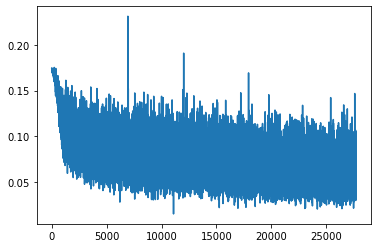

------
*********
29673 3218
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.17086435854434967
Loss:  0.16602854430675507
Loss:  0.16484199464321136
0 **********
Epoch:  55.505555391311646  fold:  5  kers:  64
epoch:  1
29673 464
Loss:  0.1527160406112671
Loss:  0.13762372732162476
Loss:  0.123893141746521
1 **********
Epoch:  99.26552486419678  fold:  5  kers:  64
epoch:  2
29673 464
Loss:  0.13625375926494598
Loss:  0.08205471187829971
Loss:  0.11858280748128891
2 **********
Epoch:  143.1950409412384  fold:  5  kers:  64
epoch:  3
Eval Loss:  0.15852271020412445
Eval Loss:  0.3223634958267212
Eval Loss:  0.21630039811134338
[[2832  265]
 [  34   87]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3097
  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


we F1:  0.9279739477559984
update!  Acc:  0.9070851460534494
Eval Loss:  0.4736692011356354
Eval Loss:  0.3547274172306061
Eval Loss:  0.4422791302204132
Eval Loss:  0.3377552032470703
Eval Loss:  0.39335402846336365
Eval Loss:  0.40600141882896423
Eval Loss:  0.4356811046600342
Eval Loss:  0.4268091022968292
Eval Loss:  0.4780327081680298
Eval Loss:  0.4029184579849243
Eval Loss:  0.4082893431186676
Eval Loss:  0.6168006062507629
Eval Loss:  0.36384934186935425
Eval Loss:  0.4492799639701843
Eval Loss:  0.41099292039871216
Eval Loss:  0.4888266324996948
Eval Loss:  0.39613690972328186
Eval Loss:  0.4518055319786072
Eval Loss:  0.47117888927459717
Eval Loss:  0.43277356028556824
Eval Loss:  0.47667497396469116
Eval Loss:  0.46904146671295166
Eval Loss:  0.3685019016265869
Eval Loss:  0.34464171528816223
Eval Loss:  0.45772668719291687
Eval Loss:  0.3666386604309082
Eval Loss:  0.43673190474510193
Eval Loss:  0.44748008251190186
Eval Loss:  0.3687492311000824
[[14926  2141]
 [ 3181  942

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.10155507922172546
Loss:  0.1323375552892685
Loss:  0.09223117679357529
3 **********
Epoch:  224.35598635673523  fold:  5  kers:  64
epoch:  4
29673 464
Loss:  0.08818388730287552
Loss:  0.08953146636486053
Loss:  0.10912452638149261
4 **********
Epoch:  268.269544839859  fold:  5  kers:  64
epoch:  5
29673 464
Loss:  0.08103843033313751
Loss:  0.08688663691282272
Loss:  0.10733125358819962
5 **********
Epoch:  312.1920793056488  fold:  5  kers:  64
epoch:  6
Eval Loss:  0.1427288055419922
Eval Loss:  0.284889280796051
Eval Loss:  0.19117774069309235
[[2931  166]
 [  34   87]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3097
           1       0.34      0.72      0.47       121

    accuracy                           0.94      3218
   macro avg       0.67      0.83      0.72      3218
weighted avg       0.96      0.94      0.95      3218

acc:  0.9378495960223742
pre:  0.3438735177865613
rec:  0.71900826446281
ma F1:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 Acc:  0.9378495960223742
Eval Loss:  0.3986026346683502
Eval Loss:  0.32528942823410034
Eval Loss:  0.43126094341278076
Eval Loss:  0.2629435956478119
Eval Loss:  0.3700256943702698
Eval Loss:  0.3590402603149414
Eval Loss:  0.42569202184677124
Eval Loss:  0.3777034878730774
Eval Loss:  0.4215499758720398
Eval Loss:  0.3871331214904785
Eval Loss:  0.373832106590271
Eval Loss:  0.5085580348968506
Eval Loss:  0.32133936882019043
Eval Loss:  0.4074726104736328
Eval Loss:  0.3317570090293884
Eval Loss:  0.4214918315410614
Eval Loss:  0.3870605230331421
Eval Loss:  0.39968493580818176
Eval Loss:  0.4507733881473541
Eval Loss:  0.38329586386680603
Eval Loss:  0.3895791471004486
Eval Loss:  0.4182411730289459
Eval Loss:  0.3495617210865021
Eval Loss:  0.2810971140861511
Eval Loss:  0.40616995096206665
Eval Loss:  0.3355463445186615
Eval Loss:  0.4169814884662628
Eval Loss:  0.4654393494129181
Eval Loss:  0.35823240876197815
[[15554  1513]
 [ 3264  9342]]
              precision    recall  f1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.05876543000340462
Loss:  0.08072856813669205
Loss:  0.0944693461060524
6 **********
Epoch:  393.36798453330994  fold:  5  kers:  64
epoch:  7
29673 464
Loss:  0.11104052513837814
Loss:  0.11079828441143036
Loss:  0.09389165043830872
7 **********
Epoch:  437.25660967826843  fold:  5  kers:  64
epoch:  8
29673 464
Loss:  0.09528408944606781
Loss:  0.06495402008295059
Loss:  0.07227784395217896
8 **********
Epoch:  481.2669095993042  fold:  5  kers:  64
epoch:  9
Eval Loss:  0.13600607216358185
Eval Loss:  0.22429008781909943
Eval Loss:  0.16874952614307404
[[2968  129]
 [  35   86]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3097
           1       0.40      0.71      0.51       121

    accuracy                           0.95      3218
   macro avg       0.69      0.83      0.74      3218
weighted avg       0.97      0.95      0.96      3218

acc:  0.9490366687383468
pre:  0.4
rec:  0.7107438016528925
ma F1:  0.742509

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 0.955772799761684
update!  Acc:  0.9490366687383468
Eval Loss:  0.4348040819168091
Eval Loss:  0.3285166621208191
Eval Loss:  0.3955681025981903
Eval Loss:  0.26882514357566833
Eval Loss:  0.40293699502944946
Eval Loss:  0.33888161182403564
Eval Loss:  0.41814282536506653
Eval Loss:  0.36966776847839355
Eval Loss:  0.4114278256893158
Eval Loss:  0.37555110454559326
Eval Loss:  0.36584609746932983
Eval Loss:  0.47425273060798645
Eval Loss:  0.30202341079711914
Eval Loss:  0.41093167662620544
Eval Loss:  0.3111542761325836
Eval Loss:  0.40130025148391724
Eval Loss:  0.37823888659477234
Eval Loss:  0.37953898310661316
Eval Loss:  0.4419441819190979
Eval Loss:  0.37875446677207947
Eval Loss:  0.36374881863594055
Eval Loss:  0.40604907274246216
Eval Loss:  0.3590922951698303
Eval Loss:  0.28276586532592773
Eval Loss:  0.3755169212818146
Eval Loss:  0.33486565947532654
Eval Loss:  0.42402032017707825
Eval Loss:  0.4777251183986664
Eval Loss:  0.34044110774993896
[[15901  1166]
 [ 3504  9102

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.11859699338674545
Loss:  0.08090212196111679
Loss:  0.08553951978683472
9 **********
Epoch:  562.2563138008118  fold:  5  kers:  64
epoch:  10
29673 464
Loss:  0.07519304007291794
Loss:  0.07472121715545654
Loss:  0.07497699558734894
10 **********
Epoch:  606.1997926235199  fold:  5  kers:  64
epoch:  11
29673 464
Loss:  0.08576836436986923
Loss:  0.11199541389942169
Loss:  0.12253992259502411
11 **********
Epoch:  650.0515160560608  fold:  5  kers:  64
epoch:  12
Eval Loss:  0.14403483271598816
Eval Loss:  0.33184847235679626
Eval Loss:  0.1832813173532486
[[2919  178]
 [  20  101]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3097
           1       0.36      0.83      0.50       121

    accuracy                           0.94      3218
   macro avg       0.68      0.89      0.74      3218
weighted avg       0.97      0.94      0.95      3218

acc:  0.9384711000621504
pre:  0.36200716845878134
rec:  0.83471074380165

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.35183286666870117
Eval Loss:  0.2543101906776428
Eval Loss:  0.30311518907546997
Eval Loss:  0.24528436362743378
Eval Loss:  0.3580038845539093
Eval Loss:  0.2979651987552643
Eval Loss:  0.35733023285865784
Eval Loss:  0.34320300817489624
Eval Loss:  0.3472220003604889
Eval Loss:  0.34776270389556885
Eval Loss:  0.34008365869522095
Eval Loss:  0.4016696810722351
Eval Loss:  0.2715534567832947
Eval Loss:  0.3518451452255249
Eval Loss:  0.23923969268798828
Eval Loss:  0.33382508158683777
Eval Loss:  0.31189122796058655
Eval Loss:  0.38578200340270996
Eval Loss:  0.34459275007247925
Eval Loss:  0.3443390727043152
Eval Loss:  0.3063742220401764
Eval Loss:  0.33594393730163574
Eval Loss:  0.3410080671310425
Eval Loss:  0.2548082172870636
Eval Loss:  0.26797646284103394
Eval Loss:  0.2780478298664093
Eval Loss:  0.37222814559936523
Eval Loss:  0.3446088135242462
Eval Loss:  0.2849884331226349
[[15205  1862]
 [ 2202 10404]]
              precision    recall  f1-score   support



C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.0826103687286377
Loss:  0.10409729927778244
Loss:  0.10143771022558212
12 **********
Epoch:  738.6106767654419  fold:  5  kers:  64
epoch:  13
29673 464
Loss:  0.08970252424478531
Loss:  0.09715067595243454
Loss:  0.06431145966053009
13 **********
Epoch:  782.5930500030518  fold:  5  kers:  64
epoch:  14
29673 464
Loss:  0.05059216544032097
Loss:  0.06721113622188568
Loss:  0.07160834968090057
14 **********
Epoch:  826.687126159668  fold:  5  kers:  64
epoch:  15
Eval Loss:  0.12958543002605438
Eval Loss:  0.2208881676197052
Eval Loss:  0.14825598895549774
[[2969  128]
 [  27   94]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3097
           1       0.42      0.78      0.55       121

    accuracy                           0.95      3218
   macro avg       0.71      0.87      0.76      3218
weighted avg       0.97      0.95      0.96      3218

acc:  0.95183343691734
pre:  0.42342342342342343
rec:  0.7768595041322314


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


update!  Acc:  0.95183343691734
Eval Loss:  0.41096922755241394
Eval Loss:  0.25448259711265564
Eval Loss:  0.2984471321105957
Eval Loss:  0.2277597188949585
Eval Loss:  0.3821779489517212
Eval Loss:  0.2733927071094513
Eval Loss:  0.3402128219604492
Eval Loss:  0.3144364655017853
Eval Loss:  0.34965264797210693
Eval Loss:  0.36364269256591797
Eval Loss:  0.34069326519966125
Eval Loss:  0.38014575839042664
Eval Loss:  0.2462204098701477
Eval Loss:  0.3431892395019531
Eval Loss:  0.21111896634101868
Eval Loss:  0.3301329016685486
Eval Loss:  0.32096627354621887
Eval Loss:  0.3552192151546478
Eval Loss:  0.35085076093673706
Eval Loss:  0.3346901535987854
Eval Loss:  0.2786932587623596
Eval Loss:  0.3508787453174591
Eval Loss:  0.3354286551475525
Eval Loss:  0.2545570433139801
Eval Loss:  0.27390778064727783
Eval Loss:  0.2722699046134949
Eval Loss:  0.39289093017578125
Eval Loss:  0.4026324450969696
Eval Loss:  0.2888422906398773
[[15749  1318]
 [ 2698  9908]]
              precision    

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.07813180238008499
Loss:  0.08180437982082367
Loss:  0.06330067664384842
15 **********
Epoch:  907.5748023986816  fold:  5  kers:  64
epoch:  16
29673 464
Loss:  0.11562655866146088
Loss:  0.08587078750133514
Loss:  0.0670461431145668
16 **********
Epoch:  951.4185473918915  fold:  5  kers:  64
epoch:  17
29673 464
Loss:  0.062107618898153305
Loss:  0.11675214022397995
Loss:  0.12193471193313599
17 **********
Epoch:  995.1944744586945  fold:  5  kers:  64
epoch:  18
Eval Loss:  0.10824094712734222
Eval Loss:  0.14414195716381073
Eval Loss:  0.10181345790624619
[[3026   71]
 [  49   72]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3097
           1       0.50      0.60      0.55       121

    accuracy                           0.96      3218
   macro avg       0.74      0.79      0.76      3218
weighted avg       0.97      0.96      0.96      3218

acc:  0.9627097576134245
pre:  0.5034965034965035
rec:  0.5950413223140

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


update!  Acc:  0.9627097576134245
Eval Loss:  0.4723341464996338
Eval Loss:  0.3050474524497986
Eval Loss:  0.38752859830856323
Eval Loss:  0.24252936244010925
Eval Loss:  0.4617418646812439
Eval Loss:  0.2971554100513458
Eval Loss:  0.417610764503479
Eval Loss:  0.3317168354988098
Eval Loss:  0.40188440680503845
Eval Loss:  0.3725350797176361
Eval Loss:  0.401597797870636
Eval Loss:  0.4362529516220093
Eval Loss:  0.2708323895931244
Eval Loss:  0.40271177887916565
Eval Loss:  0.253431111574173
Eval Loss:  0.37694716453552246
Eval Loss:  0.3730693757534027
Eval Loss:  0.36222246289253235
Eval Loss:  0.4161410927772522
Eval Loss:  0.34938865900039673
Eval Loss:  0.2829364240169525
Eval Loss:  0.4060409963130951
Eval Loss:  0.35715317726135254
Eval Loss:  0.28354763984680176
Eval Loss:  0.3172578513622284
Eval Loss:  0.32722824811935425
Eval Loss:  0.4465793967247009
Eval Loss:  0.5181972980499268
Eval Loss:  0.36343473196029663
[[16275   792]
 [ 3585  9021]]
              precision    r

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.06434900313615799
Loss:  0.06283003836870193
Loss:  0.08835543692111969
18 **********
Epoch:  1076.1788914203644  fold:  5  kers:  64
epoch:  19
29673 464
Loss:  0.07169734686613083
Loss:  0.08539225906133652
Loss:  0.0609707348048687
19 **********
Epoch:  1120.0555489063263  fold:  5  kers:  64
epoch:  20
29673 464
Loss:  0.0866139605641365
Loss:  0.09504664689302444
Loss:  0.10636042803525925
20 **********
Epoch:  1163.8454382419586  fold:  5  kers:  64
epoch:  21
Eval Loss:  0.12672099471092224
Eval Loss:  0.21721234917640686
Eval Loss:  0.1537916213274002
[[2971  126]
 [  27   94]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3097
           1       0.43      0.78      0.55       121

    accuracy                           0.95      3218
   macro avg       0.71      0.87      0.76      3218
weighted avg       0.97      0.95      0.96      3218

acc:  0.9524549409571162
pre:  0.42727272727272725
rec:  0.776859504132

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.352407842874527
Eval Loss:  0.23954162001609802
Eval Loss:  0.2915286123752594
Eval Loss:  0.2392224371433258
Eval Loss:  0.37188783288002014
Eval Loss:  0.25384390354156494
Eval Loss:  0.3204283118247986
Eval Loss:  0.27251067757606506
Eval Loss:  0.34271565079689026
Eval Loss:  0.31838539242744446
Eval Loss:  0.33880043029785156
Eval Loss:  0.362575501203537
Eval Loss:  0.19393162429332733
Eval Loss:  0.34831544756889343
Eval Loss:  0.1822223961353302
Eval Loss:  0.30202391743659973
Eval Loss:  0.2953488528728485
Eval Loss:  0.36397913098335266
Eval Loss:  0.32727620005607605
Eval Loss:  0.35640421509742737
Eval Loss:  0.2430618703365326
Eval Loss:  0.29915672540664673
Eval Loss:  0.3042171001434326
Eval Loss:  0.24804365634918213
Eval Loss:  0.24327300488948822
Eval Loss:  0.234133780002594
Eval Loss:  0.3816315531730652
Eval Loss:  0.3916018009185791
Eval Loss:  0.2913214862346649
[[15583  1484]
 [ 2189 10417]]
              precision    recall  f1-score   support

  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.09082980453968048
Loss:  0.030043423175811768
Loss:  0.08839131891727448
21 **********
Epoch:  1244.5725433826447  fold:  5  kers:  64
epoch:  22
29673 464
Loss:  0.07975845038890839
Loss:  0.06180969253182411
Loss:  0.054098520427942276
22 **********
Epoch:  1288.2128326892853  fold:  5  kers:  64
epoch:  23
29673 464
Loss:  0.08995278924703598
Loss:  0.0826156958937645
Loss:  0.11551998555660248
23 **********
Epoch:  1331.9957411289215  fold:  5  kers:  64
epoch:  24
Eval Loss:  0.10997600108385086
Eval Loss:  0.14552727341651917
Eval Loss:  0.10463488101959229
[[3019   78]
 [  36   85]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3097
           1       0.52      0.70      0.60       121

    accuracy                           0.96      3218
   macro avg       0.75      0.84      0.79      3218
weighted avg       0.97      0.96      0.97      3218

acc:  0.9645742697327533
pre:  0.5214723926380368
rec:  0.702479338

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 0.967072851374228
update!  Acc:  0.9645742697327533
Eval Loss:  0.40842390060424805
Eval Loss:  0.2727484703063965
Eval Loss:  0.3235911726951599
Eval Loss:  0.24927867949008942
Eval Loss:  0.3966255784034729
Eval Loss:  0.2627759575843811
Eval Loss:  0.33584898710250854
Eval Loss:  0.30913031101226807
Eval Loss:  0.3753892481327057
Eval Loss:  0.3367236852645874
Eval Loss:  0.3401225209236145
Eval Loss:  0.37287473678588867
Eval Loss:  0.22827380895614624
Eval Loss:  0.3650161623954773
Eval Loss:  0.1964055895805359
Eval Loss:  0.33765488862991333
Eval Loss:  0.3303990066051483
Eval Loss:  0.3293510675430298
Eval Loss:  0.37830477952957153
Eval Loss:  0.359652578830719
Eval Loss:  0.23173707723617554
Eval Loss:  0.34646958112716675
Eval Loss:  0.31809884309768677
Eval Loss:  0.27153104543685913
Eval Loss:  0.27385205030441284
Eval Loss:  0.2899266481399536
Eval Loss:  0.41939565539360046
Eval Loss:  0.4893243610858917
Eval Loss:  0.30218037962913513
[[16090   977]
 [ 2974  9632]]
   

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.09703655540943146
Loss:  0.11039780080318451
Loss:  0.08315417170524597
24 **********
Epoch:  1412.6949210166931  fold:  5  kers:  64
epoch:  25
29673 464
Loss:  0.08725452423095703
Loss:  0.13169708847999573
Loss:  0.07546097785234451
25 **********
Epoch:  1466.418244600296  fold:  5  kers:  64
epoch:  26
29673 464
Loss:  0.08587034046649933
Loss:  0.05435242876410484
Loss:  0.09732292592525482
26 **********
Epoch:  1510.519302368164  fold:  5  kers:  64
epoch:  27
Eval Loss:  0.1306275725364685
Eval Loss:  0.23569798469543457
Eval Loss:  0.16853991150856018
[[2951  146]
 [  32   89]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3097
           1       0.38      0.74      0.50       121

    accuracy                           0.94      3218
   macro avg       0.68      0.84      0.74      3218
weighted avg       0.97      0.94      0.95      3218

acc:  0.944686140459913
pre:  0.37872340425531914
rec:  0.7355371900826

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 0.9530240055935364
Eval Loss:  0.3180168867111206
Eval Loss:  0.2117399424314499
Eval Loss:  0.26650646328926086
Eval Loss:  0.20539410412311554
Eval Loss:  0.35800889134407043
Eval Loss:  0.27368709444999695
Eval Loss:  0.3006795048713684
Eval Loss:  0.25614091753959656
Eval Loss:  0.30399391055107117
Eval Loss:  0.32120588421821594
Eval Loss:  0.33510372042655945
Eval Loss:  0.3334377110004425
Eval Loss:  0.19202104210853577
Eval Loss:  0.30988752841949463
Eval Loss:  0.17491215467453003
Eval Loss:  0.2852938175201416
Eval Loss:  0.27367717027664185
Eval Loss:  0.3382391631603241
Eval Loss:  0.2831239104270935
Eval Loss:  0.314339816570282
Eval Loss:  0.22884301841259003
Eval Loss:  0.2700068950653076
Eval Loss:  0.2789391875267029
Eval Loss:  0.23318128287792206
Eval Loss:  0.24510252475738525
Eval Loss:  0.23248843848705292
Eval Loss:  0.37180882692337036
Eval Loss:  0.36454930901527405
Eval Loss:  0.27183666825294495
[[15468  1599]
 [ 1868 10738]]
              precision    recal

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.07706460356712341
Loss:  0.07707950472831726
Loss:  0.12536239624023438
27 **********
Epoch:  1591.402988910675  fold:  5  kers:  64
epoch:  28
29673 464
Loss:  0.0745885968208313
Loss:  0.07322312146425247
Loss:  0.06373593956232071
28 **********
Epoch:  1635.2357637882233  fold:  5  kers:  64
epoch:  29
29673 464
Loss:  0.08594020456075668
Loss:  0.04342816025018692
Loss:  0.0648835077881813
29 **********
Epoch:  1679.1363563537598  fold:  5  kers:  64
epoch:  30
Eval Loss:  0.12342467159032822
Eval Loss:  0.2346227765083313
Eval Loss:  0.17871572077274323
[[2962  135]
 [  34   87]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3097
           1       0.39      0.72      0.51       121

    accuracy                           0.95      3218
   macro avg       0.69      0.84      0.74      3218
weighted avg       0.97      0.95      0.95      3218

acc:  0.9474829086389062
pre:  0.3918918918918919
rec:  0.71900826446281

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.30333319306373596
Eval Loss:  0.21284808218479156
Eval Loss:  0.26313236355781555
Eval Loss:  0.19726717472076416
Eval Loss:  0.37338975071907043
Eval Loss:  0.2577466070652008
Eval Loss:  0.3104713559150696
Eval Loss:  0.26728177070617676
Eval Loss:  0.3253333270549774
Eval Loss:  0.3089275360107422
Eval Loss:  0.3722808063030243
Eval Loss:  0.32259318232536316
Eval Loss:  0.19068126380443573
Eval Loss:  0.3050414025783539
Eval Loss:  0.17030492424964905
Eval Loss:  0.26922664046287537
Eval Loss:  0.26421403884887695
Eval Loss:  0.33641090989112854
Eval Loss:  0.2869134545326233
Eval Loss:  0.3416692018508911
Eval Loss:  0.22846673429012299
Eval Loss:  0.24790504574775696
Eval Loss:  0.2892567813396454
Eval Loss:  0.22758544981479645
Eval Loss:  0.226591557264328
Eval Loss:  0.21775740385055542
Eval Loss:  0.3571356534957886
Eval Loss:  0.37269750237464905
Eval Loss:  0.2751447260379791
[[15448  1619]
 [ 1765 10841]]
              precision    recall  f1-score   support


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.06918679922819138
Loss:  0.05467669665813446
Loss:  0.06422502547502518
30 **********
Epoch:  1759.73979306221  fold:  5  kers:  64
epoch:  31
29673 464
Loss:  0.06041056662797928
Loss:  0.09631574153900146
Loss:  0.051122721284627914
31 **********
Epoch:  1803.5566103458405  fold:  5  kers:  64
epoch:  32
29673 464
Loss:  0.08410205692052841
Loss:  0.07325129956007004
Loss:  0.09748876094818115
32 **********
Epoch:  1847.390382528305  fold:  5  kers:  64
epoch:  33
Eval Loss:  0.1379513442516327
Eval Loss:  0.30306899547576904
Eval Loss:  0.16808778047561646
[[2933  164]
 [  33   88]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3097
           1       0.35      0.73      0.47       121

    accuracy                           0.94      3218
   macro avg       0.67      0.84      0.72      3218
weighted avg       0.96      0.94      0.95      3218

acc:  0.9387818520820386
pre:  0.3492063492063492
rec:  0.7272727272727

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2984594404697418
Eval Loss:  0.22371496260166168
Eval Loss:  0.2779940664768219
Eval Loss:  0.21235431730747223
Eval Loss:  0.34806400537490845
Eval Loss:  0.27847522497177124
Eval Loss:  0.27659377455711365
Eval Loss:  0.2646526098251343
Eval Loss:  0.2986921966075897
Eval Loss:  0.3527540862560272
Eval Loss:  0.34356242418289185
Eval Loss:  0.3083721995353699
Eval Loss:  0.2316705733537674
Eval Loss:  0.28685006499290466
Eval Loss:  0.16123300790786743
Eval Loss:  0.27965542674064636
Eval Loss:  0.27650484442710876
Eval Loss:  0.31499621272087097
Eval Loss:  0.26423877477645874
Eval Loss:  0.35182350873947144
Eval Loss:  0.24106699228286743
Eval Loss:  0.2597314417362213
Eval Loss:  0.31100356578826904
Eval Loss:  0.2514350414276123
Eval Loss:  0.25367918610572815
Eval Loss:  0.24072855710983276
Eval Loss:  0.36150962114334106
Eval Loss:  0.35494235157966614
Eval Loss:  0.2955412268638611
[[15302  1765]
 [ 1682 10924]]
              precision    recall  f1-score   suppo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.057040758430957794
Loss:  0.05077917501330376
Loss:  0.035612739622592926
33 **********
Epoch:  1928.145412683487  fold:  5  kers:  64
epoch:  34
29673 464
Loss:  0.10011610388755798
Loss:  0.054392050951719284
Loss:  0.06738953292369843
34 **********
Epoch:  1971.8724703788757  fold:  5  kers:  64
epoch:  35
29673 464
Loss:  0.040906570851802826
Loss:  0.0648178905248642
Loss:  0.06423191726207733
35 **********
Epoch:  2015.5755915641785  fold:  5  kers:  64
epoch:  36
Eval Loss:  0.0992373526096344
Eval Loss:  0.13985919952392578
Eval Loss:  0.1049593910574913
[[3013   84]
 [  30   91]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3097
           1       0.52      0.75      0.61       121

    accuracy                           0.96      3218
   macro avg       0.76      0.86      0.80      3218
weighted avg       0.97      0.96      0.97      3218

acc:  0.9645742697327533
pre: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 0.52
rec:  0.7520661157024794
ma F1:  0.7981490448102826
mi F1:  0.9645742697327533
we F1:  0.9676498899058584
Eval Loss:  0.284477561712265
Eval Loss:  0.2250847965478897
Eval Loss:  0.25904709100723267
Eval Loss:  0.20705273747444153
Eval Loss:  0.3579227030277252
Eval Loss:  0.23961670696735382
Eval Loss:  0.30082380771636963
Eval Loss:  0.24692563712596893
Eval Loss:  0.3518061637878418
Eval Loss:  0.2991209030151367
Eval Loss:  0.35874223709106445
Eval Loss:  0.316674143075943
Eval Loss:  0.2065131664276123
Eval Loss:  0.278780996799469
Eval Loss:  0.1705627739429474
Eval Loss:  0.2796113193035126
Eval Loss:  0.24456793069839478
Eval Loss:  0.3076656758785248
Eval Loss:  0.2855512499809265
Eval Loss:  0.34657052159309387
Eval Loss:  0.21483834087848663
Eval Loss:  0.2435714602470398
Eval Loss:  0.2711363136768341
Eval Loss:  0.24621617794036865
Eval Loss:  0.25387346744537354
Eval Loss:  0.20263849198818207
Eval Loss:  0.34797054529190063
Eval Loss:  0.39212566614151
Eval Loss:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.03584996983408928
Loss:  0.04704040288925171
Loss:  0.06739920377731323
36 **********
Epoch:  2096.383481025696  fold:  5  kers:  64
epoch:  37
29673 464
Loss:  0.08234342187643051
Loss:  0.0797429084777832
Loss:  0.0630941390991211
37 **********
Epoch:  2140.05269408226  fold:  5  kers:  64
epoch:  38
29673 464
Loss:  0.06995997577905655
Loss:  0.08154796063899994
Loss:  0.05519505590200424
38 **********
Epoch:  2183.8485667705536  fold:  5  kers:  64
epoch:  39
Eval Loss:  0.10598370432853699
Eval Loss:  0.16335263848304749
Eval Loss:  0.14487037062644958
[[2988  109]
 [  29   92]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3097
           1       0.46      0.76      0.57       121

    accuracy                           0.96      3218
   macro avg       0.72      0.86      0.77      3218
weighted avg       0.97      0.96      0.96      3218

acc:  0.9571162212554382
pre:  0.4577114427860697
rec:  0.760330578512396

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2650578022003174
Eval Loss:  0.18601064383983612
Eval Loss:  0.2559884786605835
Eval Loss:  0.19748514890670776
Eval Loss:  0.30968207120895386
Eval Loss:  0.26240813732147217
Eval Loss:  0.29400211572647095
Eval Loss:  0.24964284896850586
Eval Loss:  0.30128222703933716
Eval Loss:  0.2695467174053192
Eval Loss:  0.35234469175338745
Eval Loss:  0.3007962703704834
Eval Loss:  0.19661761820316315
Eval Loss:  0.2694541811943054
Eval Loss:  0.15233498811721802
Eval Loss:  0.26907864212989807
Eval Loss:  0.24050462245941162
Eval Loss:  0.28832969069480896
Eval Loss:  0.2644244432449341
Eval Loss:  0.3092406988143921
Eval Loss:  0.19448448717594147
Eval Loss:  0.23595598340034485
Eval Loss:  0.25784626603126526
Eval Loss:  0.22865267097949982
Eval Loss:  0.26720359921455383
Eval Loss:  0.20807181298732758
Eval Loss:  0.32093167304992676
Eval Loss:  0.357214093208313
Eval Loss:  0.2726578712463379
[[15567  1500]
 [ 1604 11002]]
              precision    recall  f1-score   suppo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.09601771086454391
Loss:  0.05908537656068802
Loss:  0.08180440962314606
39 **********
Epoch:  2264.8220131397247  fold:  5  kers:  64
epoch:  40
29673 464
Loss:  0.07717078924179077
Loss:  0.07745357602834702
Loss:  0.09053081274032593
40 **********
Epoch:  2308.4902279376984  fold:  5  kers:  64
epoch:  41
29673 464
Loss:  0.067124143242836
Loss:  0.04996873810887337
Loss:  0.0476476326584816
41 **********
Epoch:  2352.2103037834167  fold:  5  kers:  64
epoch:  42
Eval Loss:  0.10146761685609818
Eval Loss:  0.20364491641521454
Eval Loss:  0.16944392025470734
[[2985  112]
 [  33   88]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3097
           1       0.44      0.73      0.55       121

    accuracy                           0.95      3218
   macro avg       0.71      0.85      0.76      3218
weighted avg       0.97      0.95      0.96      3218

acc:  0.9549409571162213
pre:  0.44
rec:  0.7272727272727273
ma F1:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Eval Loss:  0.23868976533412933
Eval Loss:  0.2089977264404297
Eval Loss:  0.2607762813568115
Eval Loss:  0.18883410096168518
Eval Loss:  0.32011792063713074
Eval Loss:  0.2669193148612976
Eval Loss:  0.2684456706047058
Eval Loss:  0.23130865395069122
Eval Loss:  0.3044514060020447
Eval Loss:  0.29765576124191284
Eval Loss:  0.3636341392993927
Eval Loss:  0.2995275855064392
Eval Loss:  0.20806464552879333
Eval Loss:  0.2712155282497406
Eval Loss:  0.14703240990638733
Eval Loss:  0.2612563669681549
Eval Loss:  0.24079793691635132
Eval Loss:  0.2684025168418884
Eval Loss:  0.2718472480773926
Eval Loss:  0.30009958148002625
Eval Loss:  0.2119070589542389
Eval Loss:  0.2330211102962494
Eval Loss:  0.25102105736732483
Eval Loss:  0.23366668820381165
Eval Loss:  0.25204893946647644
Eval Loss:  0.19823552668094635
Eval Loss:  0.3311997652053833
Eval Loss:  0.35356536507606506
Eval Loss:  0.265995591878891
[[15472  1595]
 [ 1555 11051]]
              precision    recall  f1-score   support

 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.06505796313285828
Loss:  0.06343777477741241
Loss:  0.10420863330364227
42 **********
Epoch:  2432.9035000801086  fold:  5  kers:  64
epoch:  43
29673 464
Loss:  0.0816994309425354
Loss:  0.05567999184131622
Loss:  0.07276014238595963
43 **********
Epoch:  2476.707352399826  fold:  5  kers:  64
epoch:  44
29673 464
Loss:  0.1103844866156578
Loss:  0.06295415759086609
Loss:  0.07310716062784195
44 **********
Epoch:  2521.3150548934937  fold:  5  kers:  64
epoch:  45
Eval Loss:  0.08998845517635345
Eval Loss:  0.09290648996829987
Eval Loss:  0.10217710584402084
[[3038   59]
 [  34   87]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3097
           1       0.60      0.72      0.65       121

    accuracy                           0.97      3218
   macro avg       0.79      0.85      0.82      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.971100062150404
pre:  0.5958904109589042
rec: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 0.71900826446281
ma F1:  0.8183050081870025
mi F1:  0.971100062150404
we F1:  0.9723944966977048
update!  Acc:  0.971100062150404
Eval Loss:  0.260044664144516
Eval Loss:  0.20358406007289886
Eval Loss:  0.2680146098136902
Eval Loss:  0.1859380155801773
Eval Loss:  0.3303280174732208
Eval Loss:  0.23458893597126007
Eval Loss:  0.3020372688770294
Eval Loss:  0.2146003544330597
Eval Loss:  0.31626197695732117
Eval Loss:  0.29876771569252014
Eval Loss:  0.3357921242713928
Eval Loss:  0.2812900245189667
Eval Loss:  0.19252753257751465
Eval Loss:  0.28826281428337097
Eval Loss:  0.1520289182662964
Eval Loss:  0.2602226138114929
Eval Loss:  0.23778784275054932
Eval Loss:  0.25463059544563293
Eval Loss:  0.2836991846561432
Eval Loss:  0.3054625391960144
Eval Loss:  0.19314855337142944
Eval Loss:  0.23523499071598053
Eval Loss:  0.23481374979019165
Eval Loss:  0.22973977029323578
Eval Loss:  0.24661120772361755
Eval Loss:  0.19681374728679657
Eval Loss:  0.324613481760025
Eval Loss:  0.404904

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.047801777720451355
Loss:  0.08941742777824402
Loss:  0.0803947001695633
45 **********
Epoch:  2603.7146866321564  fold:  5  kers:  64
epoch:  46
29673 464
Loss:  0.05353027582168579
Loss:  0.08024018257856369
Loss:  0.05685124173760414
46 **********
Epoch:  2647.546464443207  fold:  5  kers:  64
epoch:  47
29673 464
Loss:  0.07422591745853424
Loss:  0.06905090063810349
Loss:  0.10154647380113602
47 **********
Epoch:  2691.3483216762543  fold:  5  kers:  64
epoch:  48
Eval Loss:  0.08995332568883896
Eval Loss:  0.11660642176866531
Eval Loss:  0.07901877164840698
[[3034   63]
 [  32   89]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3097
           1       0.59      0.74      0.65       121

    accuracy                           0.97      3218
   macro avg       0.79      0.86      0.82      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.9704785581106277
pre:  0.5855263157894737
rec:  0.73553719008

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2499619573354721
Eval Loss:  0.2134067863225937
Eval Loss:  0.2545190155506134
Eval Loss:  0.19177934527397156
Eval Loss:  0.31605467200279236
Eval Loss:  0.232639342546463
Eval Loss:  0.2802472412586212
Eval Loss:  0.19387978315353394
Eval Loss:  0.29914236068725586
Eval Loss:  0.26911264657974243
Eval Loss:  0.31482213735580444
Eval Loss:  0.2560819685459137
Eval Loss:  0.19626060128211975
Eval Loss:  0.2644583284854889
Eval Loss:  0.16860413551330566
Eval Loss:  0.2628777027130127
Eval Loss:  0.22607776522636414
Eval Loss:  0.2306797057390213
Eval Loss:  0.2866169214248657
Eval Loss:  0.2810327410697937
Eval Loss:  0.21440880000591278
Eval Loss:  0.22715561091899872
Eval Loss:  0.23212584853172302
Eval Loss:  0.22810928523540497
Eval Loss:  0.24215835332870483
Eval Loss:  0.19787275791168213
Eval Loss:  0.33262160420417786
Eval Loss:  0.3755747079849243
Eval Loss:  0.2642084062099457
[[15864  1203]
 [ 1789 10817]]
              precision    recall  f1-score   support



C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.0751103013753891
Loss:  0.09295513480901718
Loss:  0.05275961756706238
48 **********
Epoch:  2771.9008934497833  fold:  5  kers:  64
epoch:  49
29673 464
Loss:  0.10908274352550507
Loss:  0.04726695641875267
Loss:  0.0690096989274025
49 **********
Epoch:  2815.613988161087  fold:  5  kers:  64
epoch:  50
29673 464
Loss:  0.057254042476415634
Loss:  0.07769669592380524
Loss:  0.0618717223405838
50 **********
Epoch:  2859.263253927231  fold:  5  kers:  64
epoch:  51
Eval Loss:  0.09109006822109222
Eval Loss:  0.1421288549900055
Eval Loss:  0.2876742482185364
[[2941  156]
 [  19  102]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3097
           1       0.40      0.84      0.54       121

    accuracy                           0.95      3218
   macro avg       0.69      0.90      0.75      3218
weighted avg       0.97      0.95      0.95      3218

acc:  0.9456183965195774
pre:  0.3953488372093023
rec:  0.8429752066115702

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.22376514971256256
Eval Loss:  0.22875912487506866
Eval Loss:  0.2565399706363678
Eval Loss:  0.2196183055639267
Eval Loss:  0.33301928639411926
Eval Loss:  0.2738640308380127
Eval Loss:  0.2834097743034363
Eval Loss:  0.24434572458267212
Eval Loss:  0.3346136212348938
Eval Loss:  0.3428939878940582
Eval Loss:  0.3898927569389343
Eval Loss:  0.3334616720676422
Eval Loss:  0.2078242003917694
Eval Loss:  0.2657483220100403
Eval Loss:  0.1685221940279007
Eval Loss:  0.2736477553844452
Eval Loss:  0.24588361382484436
Eval Loss:  0.3165276050567627
Eval Loss:  0.25659623742103577
Eval Loss:  0.3092619776725769
Eval Loss:  0.254486620426178
Eval Loss:  0.24107864499092102
Eval Loss:  0.2536885142326355
Eval Loss:  0.27925851941108704
Eval Loss:  0.31043973565101624
Eval Loss:  0.2332143932580948
Eval Loss:  0.31211844086647034
Eval Loss:  0.3531906008720398
Eval Loss:  0.2817835211753845
[[14819  2248]
 [ 1068 11538]]
              precision    recall  f1-score   support

      

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.04918226599693298
Loss:  0.05805681273341179
Loss:  0.0732947513461113
51 **********
Epoch:  2940.0521943569183  fold:  5  kers:  64
epoch:  52
29673 464
Loss:  0.08694321662187576
Loss:  0.05719062685966492
Loss:  0.07140552997589111
52 **********
Epoch:  2983.8231341838837  fold:  5  kers:  64
epoch:  53
29673 464
Loss:  0.07034043222665787
Loss:  0.056246280670166016
Loss:  0.07150006294250488
53 **********
Epoch:  3027.6618926525116  fold:  5  kers:  64
epoch:  54
Eval Loss:  0.08516258746385574
Eval Loss:  0.12848690152168274
Eval Loss:  0.09785889089107513
[[3031   66]
 [  31   90]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3097
           1       0.58      0.74      0.65       121

    accuracy                           0.97      3218
   macro avg       0.78      0.86      0.82      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.9698570540708514
pre:  0.5769230769230769
rec:  0.7438016528

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.24745261669158936
Eval Loss:  0.21548157930374146
Eval Loss:  0.24516387283802032
Eval Loss:  0.190187007188797
Eval Loss:  0.30022311210632324
Eval Loss:  0.2435183972120285
Eval Loss:  0.2719663381576538
Eval Loss:  0.19928985834121704
Eval Loss:  0.30165454745292664
Eval Loss:  0.3067924380302429
Eval Loss:  0.36122170090675354
Eval Loss:  0.2675617039203644
Eval Loss:  0.2356366366147995
Eval Loss:  0.25598952174186707
Eval Loss:  0.1542837917804718
Eval Loss:  0.2561243772506714
Eval Loss:  0.2213565856218338
Eval Loss:  0.23977777361869812
Eval Loss:  0.27264684438705444
Eval Loss:  0.2627123296260834
Eval Loss:  0.21363496780395508
Eval Loss:  0.217851459980011
Eval Loss:  0.2303358018398285
Eval Loss:  0.25276270508766174
Eval Loss:  0.2647373676300049
Eval Loss:  0.21585749089717865
Eval Loss:  0.3377668261528015
Eval Loss:  0.3461804986000061
Eval Loss:  0.2732336223125458
[[15507  1560]
 [ 1527 11079]]
              precision    recall  f1-score   support

    

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.07506602257490158
Loss:  0.04130338132381439
Loss:  0.05445585772395134
54 **********
Epoch:  3108.3461124897003  fold:  5  kers:  64
epoch:  55
29673 464
Loss:  0.040308572351932526
Loss:  0.05109657719731331
Loss:  0.057725921273231506
55 **********
Epoch:  3152.0193140506744  fold:  5  kers:  64
epoch:  56
29673 464
Loss:  0.06713905930519104
Loss:  0.057594671845436096
Loss:  0.046069078147411346
56 **********
Epoch:  3195.772302389145  fold:  5  kers:  64
epoch:  57
Eval Loss:  0.07831031829118729
Eval Loss:  0.07151520997285843
Eval Loss:  0.07664988189935684
[[3045   52]
 [  31   90]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3097
           1       0.63      0.74      0.68       121

    accuracy                           0.97      3218
   macro avg       0.81      0.86      0.84      3218
weighted avg       0.98      0.97      0.98      3218

acc:  0.9742075823492853
pre:  0.6338028169014085
rec:  0.7438016

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 Acc:  0.9742075823492853
Eval Loss:  0.25929832458496094
Eval Loss:  0.20913487672805786
Eval Loss:  0.2467215657234192
Eval Loss:  0.2123301774263382
Eval Loss:  0.3184920847415924
Eval Loss:  0.2205943763256073
Eval Loss:  0.2504880130290985
Eval Loss:  0.20403887331485748
Eval Loss:  0.3181494474411011
Eval Loss:  0.26352643966674805
Eval Loss:  0.3283196687698364
Eval Loss:  0.2928520739078522
Eval Loss:  0.22040894627571106
Eval Loss:  0.2599681615829468
Eval Loss:  0.18333077430725098
Eval Loss:  0.25865018367767334
Eval Loss:  0.21100212633609772
Eval Loss:  0.259208619594574
Eval Loss:  0.28784453868865967
Eval Loss:  0.3006238639354706
Eval Loss:  0.18655885756015778
Eval Loss:  0.22338418662548065
Eval Loss:  0.2218649685382843
Eval Loss:  0.22939646244049072
Eval Loss:  0.2566157281398773
Eval Loss:  0.2159414440393448
Eval Loss:  0.3009675443172455
Eval Loss:  0.37069323658943176
Eval Loss:  0.2914801239967346
[[15766  1301]
 [ 1795 10811]]
              precision    recal

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.0781121551990509
Loss:  0.060877829790115356
Loss:  0.0685306042432785
57 **********
Epoch:  3281.2108075618744  fold:  5  kers:  64
epoch:  58
29673 464
Loss:  0.06668969243764877
Loss:  0.04511170834302902
Loss:  0.0664941743016243
58 **********
Epoch:  3325.0346059799194  fold:  5  kers:  64
epoch:  59
29673 464
Loss:  0.045377738773822784
Loss:  0.05058399960398674
Loss:  0.07568372786045074
59 **********
Epoch:  3368.9332048892975  fold:  5  kers:  64
Eval Loss:  0.0952170267701149
Eval Loss:  0.14372718334197998
Eval Loss:  0.08665502071380615
[[3005   92]
 [  19  102]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3097
           1       0.53      0.84      0.65       121

    accuracy                           0.97      3218
   macro avg       0.76      0.91      0.81      3218
weighted avg       0.98      0.97      0.97      3218

acc:  0.9655065257924177
pre:  0.5257731958762887
rec:  0.8429752066115702
ma F1:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


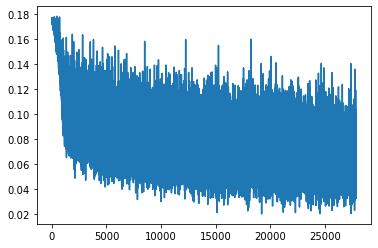

------
*********
29479 3412
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.16816695034503937
Loss:  0.17086562514305115
Loss:  0.15072278678417206
0 **********
Epoch:  55.2073540687561  fold:  6  kers:  64
epoch:  1
29479 461
Loss:  0.13291312754154205
Loss:  0.1543029397726059
Loss:  0.12761735916137695
1 **********
Epoch:  99.16280031204224  fold:  6  kers:  64
epoch:  2
29479 461
Loss:  0.10408012568950653
Loss:  0.10767140984535217
Loss:  0.08856242150068283
2 **********
Epoch:  142.7951111793518  fold:  6  kers:  64
epoch:  3
Eval Loss:  0.1489713191986084
Eval Loss:  0.27478671073913574
Eval Loss:  0.5605607628822327


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1866  366]
 [ 126 1054]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.88      2232
           1       0.74      0.89      0.81      1180

    accuracy                           0.86      3412
   macro avg       0.84      0.86      0.85      3412
weighted avg       0.87      0.86      0.86      3412

acc:  0.8558030480656507
pre:  0.7422535211267606
rec:  0.8932203389830509
ma F1:  0.847145979020979
mi F1:  0.8558030480656507
we F1:  0.8583617876847653
update!  Acc:  0.8558030480656507
Eval Loss:  0.37409475445747375
Eval Loss:  0.4678436815738678
Eval Loss:  0.38934189081192017
Eval Loss:  0.33165860176086426
Eval Loss:  0.4342936873435974
Eval Loss:  0.44076868891716003
Eval Loss:  0.41260799765586853
Eval Loss:  0.4173925817012787
Eval Loss:  0.420053094625473
Eval Loss:  0.4079751968383789
Eval Loss:  0.48426955938339233
Eval Loss:  0.3809264004230499
Eval Loss:  0.4889316260814667
Eval Loss:  0.4213140308856964
Eval Loss:  0.4477

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15649  2283]
 [ 2852  8695]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     17932
           1       0.79      0.75      0.77     11547

    accuracy                           0.83     29479
   macro avg       0.82      0.81      0.82     29479
weighted avg       0.82      0.83      0.82     29479

acc:  0.8258082024492012
pre:  0.7920386226999453
rec:  0.7530094396813025
ma F1:  0.8155437132969638
mi F1:  0.8258082024492012
we F1:  0.8249683269347313
29479 461
Loss:  0.09963653981685638
Loss:  0.08267270773649216
Loss:  0.0938703790307045
3 **********
Epoch:  223.59701681137085  fold:  6  kers:  64
epoch:  4
29479 461
Loss:  0.09016299992799759
Loss:  0.09841002523899078
Loss:  0.11015070974826813
4 **********
Epoch:  267.443754196167  fold:  6  kers:  64
epoch:  5
29479 461
Loss:  0.1259782910346985
Loss:  0.07199235260486603
Loss:  0.07705706357955933
5 **********
Epoch:  311.1827793121338  fold:  6  kers:  64
epoch:  6
Eval 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2008  224]
 [ 175 1005]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2232
           1       0.82      0.85      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.88      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8830597889800703
pre:  0.8177379983726607
rec:  0.8516949152542372
ma F1:  0.8719986912046982
mi F1:  0.8830597889800703
we F1:  0.8836001616530447
update!  Acc:  0.8830597889800703
Eval Loss:  0.3923194706439972
Eval Loss:  0.5111777782440186
Eval Loss:  0.47595569491386414
Eval Loss:  0.3497384786605835
Eval Loss:  0.4466381371021271
Eval Loss:  0.4622913897037506
Eval Loss:  0.4455614387989044
Eval Loss:  0.42225122451782227
Eval Loss:  0.41230666637420654
Eval Loss:  0.44454845786094666
Eval Loss:  0.5511257648468018
Eval Loss:  0.38061875104904175
Eval Loss:  0.5041834712028503
Eval Loss:  0.41984325647354126
Eval Loss:  0.50

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16848  1084]
 [ 3859  7688]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     17932
           1       0.88      0.67      0.76     11547

    accuracy                           0.83     29479
   macro avg       0.85      0.80      0.81     29479
weighted avg       0.84      0.83      0.83     29479

acc:  0.8323213134773907
pre:  0.8764249886000912
rec:  0.6658006408590976
ma F1:  0.8144012063209194
mi F1:  0.8323213134773907
we F1:  0.8268924600538963
29479 461
Loss:  0.09905492514371872
Loss:  0.06620296835899353
Loss:  0.09848808497190475
6 **********
Epoch:  392.06147956848145  fold:  6  kers:  64
epoch:  7
29479 461
Loss:  0.1068834587931633
Loss:  0.0888274759054184
Loss:  0.0844835489988327
7 **********
Epoch:  435.84239315986633  fold:  6  kers:  64
epoch:  8
29479 461
Loss:  0.0959731936454773
Loss:  0.08627397567033768
Loss:  0.09705425798892975
8 **********
Epoch:  479.5973756313324  fold:  6  kers:  64
epoch:  9
Eval 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1980  252]
 [ 144 1036]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2232
           1       0.80      0.88      0.84      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.88      0.87      3412
weighted avg       0.89      0.88      0.89      3412

acc:  0.8839390386869871
pre:  0.8043478260869565
rec:  0.8779661016949153
ma F1:  0.8743185501694416
mi F1:  0.8839390386869871
we F1:  0.8850396877970453
update!  Acc:  0.8839390386869871
Eval Loss:  0.29459601640701294
Eval Loss:  0.40351158380508423
Eval Loss:  0.369955837726593
Eval Loss:  0.26552319526672363
Eval Loss:  0.36628201603889465
Eval Loss:  0.3614409565925598
Eval Loss:  0.3653755486011505
Eval Loss:  0.3611585199832916
Eval Loss:  0.331230491399765
Eval Loss:  0.3624264597892761
Eval Loss:  0.37663012742996216
Eval Loss:  0.3052371144294739
Eval Loss:  0.4197585880756378
Eval Loss:  0.34928005933761597
Eval Loss:  0.3893

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16716  1216]
 [ 2958  8589]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     17932
           1       0.88      0.74      0.80     11547

    accuracy                           0.86     29479
   macro avg       0.86      0.84      0.85     29479
weighted avg       0.86      0.86      0.86     29479

acc:  0.8584076800434207
pre:  0.8759816420193779
rec:  0.7438295661210704
ma F1:  0.846760936444877
mi F1:  0.8584076800434207
we F1:  0.8559112327260019
29479 461
Loss:  0.08590756356716156
Loss:  0.10026223957538605
Loss:  0.08223122358322144
9 **********
Epoch:  560.6396379470825  fold:  6  kers:  64
epoch:  10
29479 461
Loss:  0.0722159892320633
Loss:  0.10532348603010178
Loss:  0.09473119676113129
10 **********
Epoch:  604.391628742218  fold:  6  kers:  64
epoch:  11
29479 461
Loss:  0.07083280384540558
Loss:  0.07337471842765808
Loss:  0.06597601622343063
11 **********
Epoch:  648.1346437931061  fold:  6  kers:  64
epoch:  12
E

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1982  250]
 [ 133 1047]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2232
           1       0.81      0.89      0.85      1180

    accuracy                           0.89      3412
   macro avg       0.87      0.89      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8877491207502931
pre:  0.8072474942174248
rec:  0.8872881355932203
ma F1:  0.87863536623432
mi F1:  0.8877491207502931
we F1:  0.8888895584811688
update!  Acc:  0.8877491207502931
Eval Loss:  0.25522473454475403
Eval Loss:  0.3686102032661438
Eval Loss:  0.3236779570579529
Eval Loss:  0.2574746906757355
Eval Loss:  0.3132379651069641
Eval Loss:  0.34524476528167725
Eval Loss:  0.3512765169143677
Eval Loss:  0.3231510818004608
Eval Loss:  0.29858043789863586
Eval Loss:  0.3422255516052246
Eval Loss:  0.3357169032096863
Eval Loss:  0.2678842842578888
Eval Loss:  0.37135225534439087
Eval Loss:  0.2960352599620819
Eval Loss:  0.341989

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16627  1305]
 [ 2580  8967]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     17932
           1       0.87      0.78      0.82     11547

    accuracy                           0.87     29479
   macro avg       0.87      0.85      0.86     29479
weighted avg       0.87      0.87      0.87     29479

acc:  0.8682112690389769
pre:  0.8729556074766355
rec:  0.776565341647181
ma F1:  0.8586685801054184
mi F1:  0.8682112690389769
we F1:  0.866622897186459
29479 461
Loss:  0.05976394936442375
Loss:  0.10578054934740067
Loss:  0.07289449870586395
12 **********
Epoch:  728.6732530593872  fold:  6  kers:  64
epoch:  13
29479 461
Loss:  0.07588160037994385
Loss:  0.10096270591020584
Loss:  0.11553861200809479
13 **********
Epoch:  772.2576916217804  fold:  6  kers:  64
epoch:  14
29479 461
Loss:  0.06964418292045593
Loss:  0.053138356655836105
Loss:  0.05601208284497261
14 **********
Epoch:  816.0206532478333  fold:  6  kers:  64
epoch:  1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2043  189]
 [ 204  976]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2232
           1       0.84      0.83      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.87      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8848182883939039
pre:  0.8377682403433476
rec:  0.8271186440677966
ma F1:  0.872333290965515
mi F1:  0.8848182883939039
we F1:  0.8846427729661384
Eval Loss:  0.31728896498680115
Eval Loss:  0.3832809031009674
Eval Loss:  0.3490442931652069
Eval Loss:  0.2968032956123352
Eval Loss:  0.33005574345588684
Eval Loss:  0.3688165843486786
Eval Loss:  0.4044787585735321
Eval Loss:  0.371761679649353
Eval Loss:  0.3018449544906616
Eval Loss:  0.391519695520401
Eval Loss:  0.3379669189453125
Eval Loss:  0.28829121589660645
Eval Loss:  0.39986926317214966
Eval Loss:  0.32794058322906494
Eval Loss:  0.383259117603302
Eval Loss:  0.2777549922

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17022   910]
 [ 3177  8370]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     17932
           1       0.90      0.72      0.80     11547

    accuracy                           0.86     29479
   macro avg       0.87      0.84      0.85     29479
weighted avg       0.87      0.86      0.86     29479

acc:  0.8613589334780691
pre:  0.9019396551724138
rec:  0.7248636009353079
ma F1:  0.8482906062628479
mi F1:  0.8613589334780691
we F1:  0.8579347659102343
29479 461
Loss:  0.07031238824129105
Loss:  0.09303893893957138
Loss:  0.046239253133535385
15 **********
Epoch:  896.5064041614532  fold:  6  kers:  64
epoch:  16
29479 461
Loss:  0.10371708869934082
Loss:  0.10578212141990662
Loss:  0.07220733910799026
16 **********
Epoch:  940.2035415172577  fold:  6  kers:  64
epoch:  17
29479 461
Loss:  0.07744652777910233
Loss:  0.0481015183031559
Loss:  0.05555262044072151
17 **********
Epoch:  990.6286857128143  fold:  6  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2077  155]
 [ 252  928]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2232
           1       0.86      0.79      0.82      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.86      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8807151230949589
pre:  0.8568790397045245
rec:  0.7864406779661017
ma F1:  0.8654577130570498
mi F1:  0.8807151230949589
we F1:  0.8794270736835778
Eval Loss:  0.32710975408554077
Eval Loss:  0.3753611445426941
Eval Loss:  0.38183411955833435
Eval Loss:  0.2881354093551636
Eval Loss:  0.3268483579158783
Eval Loss:  0.3846169412136078
Eval Loss:  0.4165589511394501
Eval Loss:  0.38817405700683594
Eval Loss:  0.29922401905059814
Eval Loss:  0.42307010293006897
Eval Loss:  0.38648006319999695
Eval Loss:  0.30360153317451477
Eval Loss:  0.387215256690979
Eval Loss:  0.36772605776786804
Eval Loss:  0.3832882046699524
Eval Loss:  0.2874

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17254   678]
 [ 3485  8062]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     17932
           1       0.92      0.70      0.79     11547

    accuracy                           0.86     29479
   macro avg       0.88      0.83      0.84     29479
weighted avg       0.87      0.86      0.85     29479

acc:  0.8587808270294107
pre:  0.9224256292906179
rec:  0.6981900060621806
ma F1:  0.8435714837126158
mi F1:  0.8587808270294107
we F1:  0.8541362853964426
29479 461
Loss:  0.054324328899383545
Loss:  0.084401935338974
Loss:  0.04476030170917511
18 **********
Epoch:  1071.3468153476715  fold:  6  kers:  64
epoch:  19
29479 461
Loss:  0.059822261333465576
Loss:  0.08000402897596359
Loss:  0.06120193377137184
19 **********
Epoch:  1114.8883686065674  fold:  6  kers:  64
epoch:  20
29479 461
Loss:  0.06543610244989395
Loss:  0.04881738871335983
Loss:  0.07901716232299805
20 **********
Epoch:  1158.400999546051  fold:  6  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2025  207]
 [ 201  979]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2232
           1       0.83      0.83      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.87      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.88042203985932
pre:  0.8254637436762225
rec:  0.8296610169491525
ma F1:  0.868018098476738
mi F1:  0.88042203985932
we F1:  0.8804931905747078
Eval Loss:  0.29008749127388
Eval Loss:  0.311882346868515
Eval Loss:  0.3390744626522064
Eval Loss:  0.23651359975337982
Eval Loss:  0.31797337532043457
Eval Loss:  0.3438098132610321
Eval Loss:  0.37954628467559814
Eval Loss:  0.32748472690582275
Eval Loss:  0.2762795090675354
Eval Loss:  0.368150532245636
Eval Loss:  0.2955351769924164
Eval Loss:  0.24186798930168152
Eval Loss:  0.3363560736179352
Eval Loss:  0.2759438157081604
Eval Loss:  0.3364979922771454
Eval Loss:  0.248230487108230

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16906  1026]
 [ 2709  8838]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     17932
           1       0.90      0.77      0.83     11547

    accuracy                           0.87     29479
   macro avg       0.88      0.85      0.86     29479
weighted avg       0.88      0.87      0.87     29479

acc:  0.87329963702975
pre:  0.8959854014598541
rec:  0.7653936087295401
ma F1:  0.8630408162221186
mi F1:  0.87329963702975
we F1:  0.8711596276818022
29479 461
Loss:  0.08122817426919937
Loss:  0.0961846262216568
Loss:  0.07573316991329193
21 **********
Epoch:  1238.928638458252  fold:  6  kers:  64
epoch:  22
29479 461
Loss:  0.09156900644302368
Loss:  0.05999026447534561
Loss:  0.057251907885074615
22 **********
Epoch:  1282.4073603153229  fold:  6  kers:  64
epoch:  23
29479 461
Loss:  0.06041191518306732
Loss:  0.046434205025434494
Loss:  0.07950420677661896
23 **********
Epoch:  1326.1753079891205  fold:  6  kers:  64
epoch:  2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1977  255]
 [ 150 1030]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2232
           1       0.80      0.87      0.84      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.88      0.87      3412
weighted avg       0.89      0.88      0.88      3412

acc:  0.8813012895662368
pre:  0.8015564202334631
rec:  0.8728813559322034
ma F1:  0.8713942894954692
mi F1:  0.8813012895662368
we F1:  0.882399742583587
Eval Loss:  0.20768150687217712
Eval Loss:  0.2753540873527527
Eval Loss:  0.2712341547012329
Eval Loss:  0.2223917543888092
Eval Loss:  0.27350759506225586
Eval Loss:  0.29868409037590027
Eval Loss:  0.35206931829452515
Eval Loss:  0.25283801555633545
Eval Loss:  0.26017507910728455
Eval Loss:  0.2760218679904938
Eval Loss:  0.2159770131111145
Eval Loss:  0.20059309899806976
Eval Loss:  0.3052768409252167
Eval Loss:  0.2244303822517395
Eval Loss:  0.3164580762386322
Eval Loss:  0.18269

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16398  1534]
 [ 1702  9845]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     17932
           1       0.87      0.85      0.86     11547

    accuracy                           0.89     29479
   macro avg       0.89      0.88      0.88     29479
weighted avg       0.89      0.89      0.89     29479

acc:  0.8902269412123884
pre:  0.8651902627647421
rec:  0.852602407551745
ma F1:  0.884520577558285
mi F1:  0.8902269412123884
we F1:  0.8900806465238658
29479 461
Loss:  0.05916751176118851
Loss:  0.08343145251274109
Loss:  0.059344664216041565
24 **********
Epoch:  1406.7019491195679  fold:  6  kers:  64
epoch:  25
29479 461
Loss:  0.06530648469924927
Loss:  0.08071690052747726
Loss:  0.06778823584318161
25 **********
Epoch:  1450.2474920749664  fold:  6  kers:  64
epoch:  26
29479 461
Loss:  0.09402365982532501
Loss:  0.07266050577163696
Loss:  0.08511596918106079
26 **********
Epoch:  1493.7730884552002  fold:  6  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2013  219]
 [ 183  997]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2232
           1       0.82      0.84      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.87      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8821805392731535
pre:  0.8199013157894737
rec:  0.8449152542372881
ma F1:  0.8707172297098598
mi F1:  0.8821805392731535
we F1:  0.8825867195332703
Eval Loss:  0.254752516746521
Eval Loss:  0.2857818007469177
Eval Loss:  0.294617623090744
Eval Loss:  0.23325099050998688
Eval Loss:  0.2517016530036926
Eval Loss:  0.3108893930912018
Eval Loss:  0.393591970205307
Eval Loss:  0.30389833450317383
Eval Loss:  0.2767378091812134
Eval Loss:  0.32368263602256775
Eval Loss:  0.29995912313461304
Eval Loss:  0.2112717628479004
Eval Loss:  0.30068233609199524
Eval Loss:  0.2647346556186676
Eval Loss:  0.36991533637046814
Eval Loss:  0.22652924

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16932  1000]
 [ 2333  9214]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     17932
           1       0.90      0.80      0.85     11547

    accuracy                           0.89     29479
   macro avg       0.89      0.87      0.88     29479
weighted avg       0.89      0.89      0.89     29479

acc:  0.8869364632450218
pre:  0.902095163501077
rec:  0.797956179094137
ma F1:  0.8786160412889976
mi F1:  0.886936463245022
we F1:  0.8854994170585253
29479 461
Loss:  0.06475687026977539
Loss:  0.05771147459745407
Loss:  0.05966165289282799
27 **********
Epoch:  1574.1541194915771  fold:  6  kers:  64
epoch:  28
29479 461
Loss:  0.04619838669896126
Loss:  0.08008608222007751
Loss:  0.07180435210466385
28 **********
Epoch:  1617.750526189804  fold:  6  kers:  64
epoch:  29
29479 461
Loss:  0.08521421998739243
Loss:  0.044267553836107254
Loss:  0.10748602449893951
29 **********
Epoch:  1665.48486661911  fold:  6  kers:  64
epoch:  30

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1953  279]
 [ 147 1033]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      2232
           1       0.79      0.88      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.86      0.88      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8751465416178195
pre:  0.7873475609756098
rec:  0.8754237288135593
ma F1:  0.8653575096819518
mi F1:  0.8751465416178195
we F1:  0.8765510548955744
Eval Loss:  0.20479030907154083
Eval Loss:  0.26750850677490234
Eval Loss:  0.2857988476753235
Eval Loss:  0.22348326444625854
Eval Loss:  0.2588978111743927
Eval Loss:  0.2742302119731903
Eval Loss:  0.3663918972015381
Eval Loss:  0.24200522899627686
Eval Loss:  0.2561195194721222
Eval Loss:  0.2755378484725952
Eval Loss:  0.23745587468147278
Eval Loss:  0.18416662514209747
Eval Loss:  0.28507092595100403
Eval Loss:  0.23600061237812042
Eval Loss:  0.31149446964263916
Eval Loss:  0.20

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16600  1332]
 [ 1821  9726]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     17932
           1       0.88      0.84      0.86     11547

    accuracy                           0.89     29479
   macro avg       0.89      0.88      0.89     29479
weighted avg       0.89      0.89      0.89     29479

acc:  0.8930425048339496
pre:  0.8795442213781878
rec:  0.8422967004416732
ma F1:  0.8868923576204434
mi F1:  0.8930425048339496
we F1:  0.8926049979984237
29479 461
Loss:  0.08418488502502441
Loss:  0.07312805950641632
Loss:  0.04301663488149643
30 **********
Epoch:  1746.350601196289  fold:  6  kers:  64
epoch:  31
29479 461
Loss:  0.06332840025424957
Loss:  0.0705498456954956
Loss:  0.07970164716243744
31 **********
Epoch:  1789.9230723381042  fold:  6  kers:  64
epoch:  32
29479 461
Loss:  0.09379129856824875
Loss:  0.07031092047691345
Loss:  0.0795600414276123
32 **********
Epoch:  1833.5513935089111  fold:  6  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1992  240]
 [ 179 1001]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2232
           1       0.81      0.85      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.86      0.87      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8771981242672919
pre:  0.806607574536664
rec:  0.8483050847457627
ma F1:  0.8658843154797671
mi F1:  0.8771981242672919
we F1:  0.8778945342935673
Eval Loss:  0.18939952552318573
Eval Loss:  0.26531338691711426
Eval Loss:  0.2505379915237427
Eval Loss:  0.21471759676933289
Eval Loss:  0.2580450177192688
Eval Loss:  0.2767767310142517
Eval Loss:  0.36582380533218384
Eval Loss:  0.25832608342170715
Eval Loss:  0.25276637077331543
Eval Loss:  0.2642844021320343
Eval Loss:  0.24767842888832092
Eval Loss:  0.1765826940536499
Eval Loss:  0.2508690059185028
Eval Loss:  0.2362823784351349
Eval Loss:  0.2868880033493042
Eval Loss:  0.17945

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16791  1141]
 [ 1869  9678]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17932
           1       0.89      0.84      0.87     11547

    accuracy                           0.90     29479
   macro avg       0.90      0.89      0.89     29479
weighted avg       0.90      0.90      0.90     29479

acc:  0.8978934156518199
pre:  0.894537387928644
rec:  0.8381397765653417
ma F1:  0.8915811553750947
mi F1:  0.8978934156518199
we F1:  0.8972473696119695
29479 461
Loss:  0.0819396823644638
Loss:  0.09353660047054291
Loss:  0.09528868645429611
33 **********
Epoch:  1914.0411338806152  fold:  6  kers:  64
epoch:  34
29479 461
Loss:  0.08284782618284225
Loss:  0.05326991528272629
Loss:  0.08264763653278351
34 **********
Epoch:  1957.60662317276  fold:  6  kers:  64
epoch:  35
29479 461
Loss:  0.06138051673769951
Loss:  0.03335247561335564
Loss:  0.03586559742689133
35 **********
Epoch:  2001.1112756729126  fold:  6  kers:  64
epoch:  3

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2001  231]
 [ 192  988]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2232
           1       0.81      0.84      0.82      1180

    accuracy                           0.88      3412
   macro avg       0.86      0.87      0.86      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8760257913247362
pre:  0.8105004101722724
rec:  0.8372881355932204
ma F1:  0.8640416557746519
mi F1:  0.8760257913247362
we F1:  0.876487174628244
Eval Loss:  0.1651848703622818
Eval Loss:  0.2726370394229889
Eval Loss:  0.2587423026561737
Eval Loss:  0.21600866317749023
Eval Loss:  0.26477891206741333
Eval Loss:  0.24668152630329132
Eval Loss:  0.35927730798721313
Eval Loss:  0.23469845950603485
Eval Loss:  0.2601882815361023
Eval Loss:  0.26050737500190735
Eval Loss:  0.24161919951438904
Eval Loss:  0.1848621815443039
Eval Loss:  0.26798975467681885
Eval Loss:  0.22619666159152985
Eval Loss:  0.2846459746360779
Eval Loss:  0.187

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16731  1201]
 [ 1856  9691]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     17932
           1       0.89      0.84      0.86     11547

    accuracy                           0.90     29479
   macro avg       0.89      0.89      0.89     29479
weighted avg       0.90      0.90      0.90     29479

acc:  0.8962990603480444
pre:  0.8897355857510099
rec:  0.8392656101151814
ma F1:  0.8900270663424292
mi F1:  0.8962990603480444
we F1:  0.8957155154512153
29479 461
Loss:  0.05295814201235771
Loss:  0.0625394955277443
Loss:  0.0767655000090599
36 **********
Epoch:  2081.734658241272  fold:  6  kers:  64
epoch:  37
29479 461
Loss:  0.039162132889032364
Loss:  0.11269376426935196
Loss:  0.09539661556482315
37 **********
Epoch:  2125.2393102645874  fold:  6  kers:  64
epoch:  38
29479 461
Loss:  0.053508222103118896
Loss:  0.07039401680231094
Loss:  0.08125832676887512
38 **********
Epoch:  2168.8287360668182  fold:  6  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1966  266]
 [ 177 1003]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2232
           1       0.79      0.85      0.82      1180

    accuracy                           0.87      3412
   macro avg       0.85      0.87      0.86      3412
weighted avg       0.87      0.87      0.87      3412

acc:  0.8701641266119577
pre:  0.7903861308116628
rec:  0.85
ma F1:  0.8589263489470921
mi F1:  0.8701641266119576
we F1:  0.8712027166557511
Eval Loss:  0.17032936215400696
Eval Loss:  0.2796619236469269
Eval Loss:  0.2885049879550934
Eval Loss:  0.21359935402870178
Eval Loss:  0.24086913466453552
Eval Loss:  0.2899591028690338
Eval Loss:  0.350180983543396
Eval Loss:  0.22071893513202667
Eval Loss:  0.29278555512428284
Eval Loss:  0.2765071392059326
Eval Loss:  0.24234525859355927
Eval Loss:  0.18722152709960938
Eval Loss:  0.26811927556991577
Eval Loss:  0.22284118831157684
Eval Loss:  0.2989223897457123
Eval Loss:  0.1792859137058258


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16539  1393]
 [ 1682  9865]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     17932
           1       0.88      0.85      0.87     11547

    accuracy                           0.90     29479
   macro avg       0.89      0.89      0.89     29479
weighted avg       0.90      0.90      0.90     29479

acc:  0.8956884561891516
pre:  0.8762657665659975
rec:  0.8543344591668832
ma F1:  0.8900529833641504
mi F1:  0.8956884561891516
we F1:  0.8954444268744342
29479 461
Loss:  0.11502909660339355
Loss:  0.059171002358198166
Loss:  0.0678718164563179
39 **********
Epoch:  2249.2706043720245  fold:  6  kers:  64
epoch:  40
29479 461
Loss:  0.04574396088719368
Loss:  0.056512970477342606
Loss:  0.06203406676650047
40 **********
Epoch:  2292.8061740398407  fold:  6  kers:  64
epoch:  41
29479 461
Loss:  0.05796635150909424
Loss:  0.039327722042798996
Loss:  0.06132752075791359
41 **********
Epoch:  2336.3118233680725  fold:  6  kers:  64
epo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2045  187]
 [ 219  961]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2232
           1       0.84      0.81      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.87      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8810082063305978
pre:  0.8371080139372822
rec:  0.8144067796610169
ma F1:  0.8676494417336219
mi F1:  0.8810082063305978
we F1:  0.8806138516561484
Eval Loss:  0.15967833995819092
Eval Loss:  0.2838129699230194
Eval Loss:  0.2456110715866089
Eval Loss:  0.21008269488811493
Eval Loss:  0.22687849402427673
Eval Loss:  0.22982601821422577
Eval Loss:  0.36540552973747253
Eval Loss:  0.22479389607906342
Eval Loss:  0.2524666488170624
Eval Loss:  0.24702133238315582
Eval Loss:  0.2370636910200119
Eval Loss:  0.1701025366783142
Eval Loss:  0.23713012039661407
Eval Loss:  0.21289189159870148
Eval Loss:  0.2756478786468506
Eval Loss:  0.15

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16734  1198]
 [ 1689  9858]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     17932
           1       0.89      0.85      0.87     11547

    accuracy                           0.90     29479
   macro avg       0.90      0.89      0.90     29479
weighted avg       0.90      0.90      0.90     29479

acc:  0.9020658774042539
pre:  0.891642547033285
rec:  0.8537282411015849
ma F1:  0.8964311159015075
mi F1:  0.902065877404254
we F1:  0.9016635115086972
29479 461
Loss:  0.08783698081970215
Loss:  0.06830756366252899
Loss:  0.0889807939529419
42 **********
Epoch:  2416.9092750549316  fold:  6  kers:  64
epoch:  43
29479 461
Loss:  0.07254528999328613
Loss:  0.0950435921549797
Loss:  0.05771627277135849
43 **********
Epoch:  2460.590455532074  fold:  6  kers:  64
epoch:  44
29479 461
Loss:  0.056271832436323166
Loss:  0.05389650911092758
Loss:  0.06631330400705338
44 **********
Epoch:  2504.155945301056  fold:  6  kers:  64
epoch:  45

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1960  272]
 [ 141 1039]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      2232
           1       0.79      0.88      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.86      0.88      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8789566236811255
pre:  0.7925247902364607
rec:  0.8805084745762712
ma F1:  0.869444053519974
mi F1:  0.8789566236811255
we F1:  0.8803096602621361
Eval Loss:  0.1538156419992447
Eval Loss:  0.27322277426719666
Eval Loss:  0.2665007710456848
Eval Loss:  0.22797821462154388
Eval Loss:  0.2343013882637024
Eval Loss:  0.22755666077136993
Eval Loss:  0.34607812762260437
Eval Loss:  0.22398711740970612
Eval Loss:  0.2554903030395508
Eval Loss:  0.25723132491111755
Eval Loss:  0.2143404334783554
Eval Loss:  0.16117382049560547
Eval Loss:  0.23580119013786316
Eval Loss:  0.21894246339797974
Eval Loss:  0.2843579351902008
Eval Loss:  0.163

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16721  1211]
 [ 1617  9930]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     17932
           1       0.89      0.86      0.88     11547

    accuracy                           0.90     29479
   macro avg       0.90      0.90      0.90     29479
weighted avg       0.90      0.90      0.90     29479

acc:  0.9040673021472913
pre:  0.8913023965532717
rec:  0.8599636269160821
ma F1:  0.8986909172819587
mi F1:  0.9040673021472913
we F1:  0.9037458749266575
29479 461
Loss:  0.08696885406970978
Loss:  0.06736798584461212
Loss:  0.06861565262079239
45 **********
Epoch:  2584.543957233429  fold:  6  kers:  64
epoch:  46
29479 461
Loss:  0.06991177797317505
Loss:  0.057149652391672134
Loss:  0.05639943853020668
46 **********
Epoch:  2628.04661488533  fold:  6  kers:  64
epoch:  47
29479 461
Loss:  0.0969390794634819
Loss:  0.07346785068511963
Loss:  0.07769130170345306
47 **********
Epoch:  2671.520350456238  fold:  6  kers:  64
epoch:  4

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1907  325]
 [ 120 1060]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      2232
           1       0.77      0.90      0.83      1180

    accuracy                           0.87      3412
   macro avg       0.85      0.88      0.86      3412
weighted avg       0.88      0.87      0.87      3412

acc:  0.86957796014068
pre:  0.7653429602888087
rec:  0.8983050847457628
ma F1:  0.861013050222279
mi F1:  0.86957796014068
we F1:  0.8716509312543426
Eval Loss:  0.16314822435379028
Eval Loss:  0.3082727789878845
Eval Loss:  0.30595269799232483
Eval Loss:  0.2067190259695053
Eval Loss:  0.23434323072433472
Eval Loss:  0.2811678647994995
Eval Loss:  0.33423498272895813
Eval Loss:  0.1848125457763672
Eval Loss:  0.24771954119205475
Eval Loss:  0.22460085153579712
Eval Loss:  0.2319450080394745
Eval Loss:  0.17886613309383392
Eval Loss:  0.28552791476249695
Eval Loss:  0.22642718255519867
Eval Loss:  0.30816781520843506
Eval Loss:  0.210851

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16158  1774]
 [ 1244 10303]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     17932
           1       0.85      0.89      0.87     11547

    accuracy                           0.90     29479
   macro avg       0.89      0.90      0.89     29479
weighted avg       0.90      0.90      0.90     29479

acc:  0.8976220360256454
pre:  0.8531092158648671
rec:  0.8922663895384082
ma F1:  0.8934175390105829
mi F1:  0.8976220360256454
we F1:  0.8980026309732086
29479 461
Loss:  0.040578410029411316
Loss:  0.06973777711391449
Loss:  0.07896468043327332
48 **********
Epoch:  2758.2753343582153  fold:  6  kers:  64
epoch:  49
29479 461
Loss:  0.05234542116522789
Loss:  0.0723462924361229
Loss:  0.07695193588733673
49 **********
Epoch:  2808.799214363098  fold:  6  kers:  64
epoch:  50
29479 461
Loss:  0.05692291632294655
Loss:  0.047891367226839066
Loss:  0.05898403003811836
50 **********
Epoch:  2852.4634399414062  fold:  6  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1990  242]
 [ 150 1030]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2232
           1       0.81      0.87      0.84      1180

    accuracy                           0.89      3412
   macro avg       0.87      0.88      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8851113716295428
pre:  0.809748427672956
rec:  0.8728813559322034
ma F1:  0.8752345117752149
mi F1:  0.8851113716295427
we F1:  0.886057904032249
Eval Loss:  0.14566873013973236
Eval Loss:  0.3120345175266266
Eval Loss:  0.27298861742019653
Eval Loss:  0.2140909880399704
Eval Loss:  0.2349526733160019
Eval Loss:  0.24335592985153198
Eval Loss:  0.3551989495754242
Eval Loss:  0.19849613308906555
Eval Loss:  0.23120665550231934
Eval Loss:  0.2413652241230011
Eval Loss:  0.23668238520622253
Eval Loss:  0.1512433886528015
Eval Loss:  0.21802619099617004
Eval Loss:  0.22131475806236267
Eval Loss:  0.25778672099113464
Eval Loss:  0.1733

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16283  1649]
 [ 1255 10292]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     17932
           1       0.86      0.89      0.88     11547

    accuracy                           0.90     29479
   macro avg       0.90      0.90      0.90     29479
weighted avg       0.90      0.90      0.90     29479

acc:  0.901489195698633
pre:  0.8619043631186668
rec:  0.8913137611500823
ma F1:  0.8972451966546547
mi F1:  0.901489195698633
we F1:  0.9017683036310863
29479 461
Loss:  0.06292995810508728
Loss:  0.06380642205476761
Loss:  0.06077977269887924
51 **********
Epoch:  2932.8305082321167  fold:  6  kers:  64
epoch:  52
29479 461
Loss:  0.060636311769485474
Loss:  0.04140647500753403
Loss:  0.07954027503728867
52 **********
Epoch:  2976.374056339264  fold:  6  kers:  64
epoch:  53
29479 461
Loss:  0.05386331304907799
Loss:  0.08631367981433868
Loss:  0.05734845995903015
53 **********
Epoch:  3019.836820602417  fold:  6  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1797  435]
 [  75 1105]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      2232
           1       0.72      0.94      0.81      1180

    accuracy                           0.85      3412
   macro avg       0.84      0.87      0.84      3412
weighted avg       0.88      0.85      0.85      3412

acc:  0.85052754982415
pre:  0.7175324675324676
rec:  0.9364406779661016
ma F1:  0.8441154970760234
mi F1:  0.85052754982415
we F1:  0.8538632998087246
Eval Loss:  0.17510220408439636
Eval Loss:  0.34576359391212463
Eval Loss:  0.3244321942329407
Eval Loss:  0.23191282153129578
Eval Loss:  0.28177064657211304
Eval Loss:  0.3180624544620514
Eval Loss:  0.37509122490882874
Eval Loss:  0.2056419551372528
Eval Loss:  0.24996502697467804
Eval Loss:  0.22354838252067566
Eval Loss:  0.2564701735973358
Eval Loss:  0.2025049328804016
Eval Loss:  0.24659129977226257
Eval Loss:  0.2594558298587799
Eval Loss:  0.29627755284309387
Eval Loss:  0.218032

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15514  2418]
 [  861 10686]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.90     17932
           1       0.82      0.93      0.87     11547

    accuracy                           0.89     29479
   macro avg       0.88      0.90      0.89     29479
weighted avg       0.90      0.89      0.89     29479

acc:  0.8887682757217001
pre:  0.8154761904761905
rec:  0.9254351779683034
ma F1:  0.8857024609796972
mi F1:  0.8887682757217001
we F1:  0.8897569819257801
29479 461
Loss:  0.08378177136182785
Loss:  0.07738614827394485
Loss:  0.07123800367116928
54 **********
Epoch:  3100.4612007141113  fold:  6  kers:  64
epoch:  55
29479 461
Loss:  0.07121109962463379
Loss:  0.06448350101709366
Loss:  0.06571249663829803
55 **********
Epoch:  3144.0945088863373  fold:  6  kers:  64
epoch:  56
29479 461
Loss:  0.0733925849199295
Loss:  0.028546277433633804
Loss:  0.06442799419164658
56 **********
Epoch:  3187.6749584674835  fold:  6  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1994  238]
 [ 133 1047]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2232
           1       0.81      0.89      0.85      1180

    accuracy                           0.89      3412
   macro avg       0.88      0.89      0.88      3412
weighted avg       0.90      0.89      0.89      3412

acc:  0.8912661195779601
pre:  0.8147859922178988
rec:  0.8872881355932203
ma F1:  0.8821908182785656
mi F1:  0.89126611957796
we F1:  0.8922723567864462
update!  Acc:  0.8912661195779601
Eval Loss:  0.15976737439632416
Eval Loss:  0.29724472761154175
Eval Loss:  0.23334741592407227
Eval Loss:  0.1998910754919052
Eval Loss:  0.1983790248632431
Eval Loss:  0.2391502857208252
Eval Loss:  0.35915759205818176
Eval Loss:  0.18820974230766296
Eval Loss:  0.21701973676681519
Eval Loss:  0.2093643844127655
Eval Loss:  0.24620036780834198
Eval Loss:  0.1593458205461502
Eval Loss:  0.2184726744890213
Eval Loss:  0.2130146324634552
Eval Loss:  0.287

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16433  1499]
 [ 1210 10337]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     17932
           1       0.87      0.90      0.88     11547

    accuracy                           0.91     29479
   macro avg       0.90      0.91      0.90     29479
weighted avg       0.91      0.91      0.91     29479

acc:  0.908104074086638
pre:  0.8733524839472795
rec:  0.8952108772841431
ma F1:  0.9039988106031949
mi F1:  0.9081040740866378
we F1:  0.9082986969781593
29479 461
Loss:  0.04171144217252731
Loss:  0.07630561292171478
Loss:  0.06675535440444946
57 **********
Epoch:  3268.477860927582  fold:  6  kers:  64
epoch:  58
29479 461
Loss:  0.06099206954240799
Loss:  0.07715350389480591
Loss:  0.0630350410938263
58 **********
Epoch:  3312.2218732833862  fold:  6  kers:  64
epoch:  59
29479 461
Loss:  0.05339740589261055
Loss:  0.0640564113855362
Loss:  0.06364063173532486
59 **********
Epoch:  3355.9678797721863  fold:  6  kers:  64
Eval Loss

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


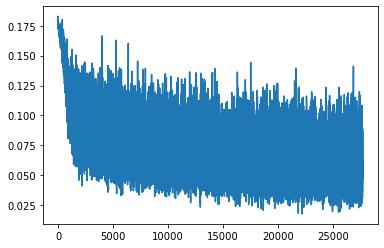

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1705782413482666
Loss:  0.15975117683410645
Loss:  0.15434274077415466
0 **********
Epoch:  55.017860889434814  fold:  7  kers:  64
epoch:  1
29460 461
Loss:  0.145676851272583
Loss:  0.12438148260116577
Loss:  0.1279979795217514
1 **********
Epoch:  109.98585605621338  fold:  7  kers:  64
epoch:  2
29460 461
Loss:  0.11768711358308792
Loss:  0.12049291282892227
Loss:  0.13756030797958374
2 **********
Epoch:  153.98917436599731  fold:  7  kers:  64
epoch:  3
Eval Loss:  0.9309371709823608
Eval Loss:  0.08805225789546967
Eval Loss:  2.207895517349243


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1767  360]
 [ 736  568]]
              precision    recall  f1-score   support

           0       0.71      0.83      0.76      2127
           1       0.61      0.44      0.51      1304

    accuracy                           0.68      3431
   macro avg       0.66      0.63      0.64      3431
weighted avg       0.67      0.68      0.67      3431

acc:  0.6805596036141067
pre:  0.6120689655172413
rec:  0.43558282208588955
ma F1:  0.6361217554208567
mi F1:  0.6805596036141067
we F1:  0.6666241316202268
update!  Acc:  0.6805596036141067
Eval Loss:  0.3554474711418152
Eval Loss:  0.32568126916885376
Eval Loss:  0.40896210074424744
Eval Loss:  0.424270898103714
Eval Loss:  0.5055083632469177
Eval Loss:  0.4714595377445221
Eval Loss:  0.4939807951450348
Eval Loss:  0.37413865327835083
Eval Loss:  0.4309181869029999
Eval Loss:  0.48400115966796875
Eval Loss:  0.42381495237350464
Eval Loss:  0.3110499978065491
Eval Loss:  0.3413785994052887
Eval Loss:  0.47662603855133057
Eval Loss:  0.33

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16122  1915]
 [ 3320  8103]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     18037
           1       0.81      0.71      0.76     11423

    accuracy                           0.82     29460
   macro avg       0.82      0.80      0.81     29460
weighted avg       0.82      0.82      0.82     29460

acc:  0.8223014256619144
pre:  0.8088440806548213
rec:  0.7093583121771864
ma F1:  0.8080816960310142
mi F1:  0.8223014256619144
we F1:  0.8198100027748443
29460 461
Loss:  0.09684086591005325
Loss:  0.09095034748315811
Loss:  0.07995390146970749
3 **********
Epoch:  234.82100009918213  fold:  7  kers:  64
epoch:  4
29460 461
Loss:  0.07627737522125244
Loss:  0.10837676376104355
Loss:  0.09714171290397644
4 **********
Epoch:  278.6637477874756  fold:  7  kers:  64
epoch:  5
29460 461
Loss:  0.07732868939638138
Loss:  0.12830254435539246
Loss:  0.06478987634181976
5 **********
Epoch:  322.3768424987793  fold:  7  kers:  64
epoch:  6
Ev

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1941  186]
 [ 784  520]]
              precision    recall  f1-score   support

           0       0.71      0.91      0.80      2127
           1       0.74      0.40      0.52      1304

    accuracy                           0.72      3431
   macro avg       0.72      0.66      0.66      3431
weighted avg       0.72      0.72      0.69      3431

acc:  0.7172835907898572
pre:  0.7365439093484419
rec:  0.3987730061349693
ma F1:  0.6587476877771079
mi F1:  0.7172835907898572
we F1:  0.6926499032447311
update!  Acc:  0.7172835907898572
Eval Loss:  0.3166077136993408
Eval Loss:  0.28302785754203796
Eval Loss:  0.3876919150352478
Eval Loss:  0.4059666693210602
Eval Loss:  0.4860115349292755
Eval Loss:  0.4134645462036133
Eval Loss:  0.4631373882293701
Eval Loss:  0.33612188696861267
Eval Loss:  0.3675241470336914
Eval Loss:  0.4855504035949707
Eval Loss:  0.40371081233024597
Eval Loss:  0.2875390648841858
Eval Loss:  0.328980952501297
Eval Loss:  0.42514705657958984
Eval Loss:  0.25699

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16672  1365]
 [ 3253  8170]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     18037
           1       0.86      0.72      0.78     11423

    accuracy                           0.84     29460
   macro avg       0.85      0.82      0.83     29460
weighted avg       0.84      0.84      0.84     29460

acc:  0.843245078071962
pre:  0.8568432092291557
rec:  0.7152236715398756
ma F1:  0.8290032917181951
mi F1:  0.843245078071962
we F1:  0.8400824701401914
29460 461
Loss:  0.10572240501642227
Loss:  0.10770263522863388
Loss:  0.10603398829698563
6 **********
Epoch:  403.3064064979553  fold:  7  kers:  64
epoch:  7
29460 461
Loss:  0.07156259566545486
Loss:  0.06837295740842819
Loss:  0.07728736847639084
7 **********
Epoch:  446.90381050109863  fold:  7  kers:  64
epoch:  8
29460 461
Loss:  0.07693037390708923
Loss:  0.0973646491765976
Loss:  0.06214519590139389
8 **********
Epoch:  490.68372654914856  fold:  7  kers:  64
epoch:  9
Eval

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1936  191]
 [ 692  612]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.81      2127
           1       0.76      0.47      0.58      1304

    accuracy                           0.74      3431
   macro avg       0.75      0.69      0.70      3431
weighted avg       0.75      0.74      0.73      3431

acc:  0.7426406295540658
pre:  0.7621419676214197
rec:  0.46932515337423314
ma F1:  0.6976107382282382
mi F1:  0.742640629554066
we F1:  0.7256013730931598
update!  Acc:  0.7426406295540658
Eval Loss:  0.27239304780960083
Eval Loss:  0.25864270329475403
Eval Loss:  0.30910351872444153
Eval Loss:  0.3951628506183624
Eval Loss:  0.3545987606048584
Eval Loss:  0.30017560720443726
Eval Loss:  0.38582104444503784
Eval Loss:  0.2714822590351105
Eval Loss:  0.2977287769317627
Eval Loss:  0.4154055118560791
Eval Loss:  0.3762589991092682
Eval Loss:  0.22686250507831573
Eval Loss:  0.30877745151519775
Eval Loss:  0.34524789452552795
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16477  1560]
 [ 2473  8950]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     18037
           1       0.85      0.78      0.82     11423

    accuracy                           0.86     29460
   macro avg       0.86      0.85      0.85     29460
weighted avg       0.86      0.86      0.86     29460

acc:  0.8631025118805159
pre:  0.851569933396765
rec:  0.7835069596428259
ma F1:  0.8535417574009125
mi F1:  0.8631025118805159
we F1:  0.8619428242440237
29460 461
Loss:  0.10919072479009628
Loss:  0.09001120924949646
Loss:  0.08052137494087219
9 **********
Epoch:  571.387894153595  fold:  7  kers:  64
epoch:  10
29460 461
Loss:  0.07781152427196503
Loss:  0.07613284140825272
Loss:  0.07285884022712708
10 **********
Epoch:  614.8995263576508  fold:  7  kers:  64
epoch:  11
29460 461
Loss:  0.06124359741806984
Loss:  0.09717652201652527
Loss:  0.07876964658498764
11 **********
Epoch:  658.4660136699677  fold:  7  kers:  64
epoch:  12


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1945  182]
 [ 631  673]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      2127
           1       0.79      0.52      0.62      1304

    accuracy                           0.76      3431
   macro avg       0.77      0.72      0.73      3431
weighted avg       0.77      0.76      0.75      3431

acc:  0.763042844651705
pre:  0.7871345029239766
rec:  0.5161042944785276
ma F1:  0.7252841972007067
mi F1:  0.763042844651705
we F1:  0.7497145170530428
update!  Acc:  0.763042844651705
Eval Loss:  0.26455458998680115
Eval Loss:  0.25703704357147217
Eval Loss:  0.3103227913379669
Eval Loss:  0.3897656798362732
Eval Loss:  0.3291264772415161
Eval Loss:  0.2900650203227997
Eval Loss:  0.3928872346878052
Eval Loss:  0.26646050810813904
Eval Loss:  0.29700422286987305
Eval Loss:  0.4014212489128113
Eval Loss:  0.36684364080429077
Eval Loss:  0.19449737668037415
Eval Loss:  0.2884591817855835
Eval Loss:  0.3268820345401764
Eval Loss:  0.19315

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16565  1472]
 [ 2302  9121]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18037
           1       0.86      0.80      0.83     11423

    accuracy                           0.87     29460
   macro avg       0.87      0.86      0.86     29460
weighted avg       0.87      0.87      0.87     29460

acc:  0.8718940936863544
pre:  0.8610403096384405
rec:  0.7984767574192418
ma F1:  0.8631569390127243
mi F1:  0.8718940936863544
we F1:  0.8709199079825508
29460 461
Loss:  0.06947563588619232
Loss:  0.048380207270383835
Loss:  0.06641491502523422
12 **********
Epoch:  739.136271238327  fold:  7  kers:  64
epoch:  13
29460 461
Loss:  0.0543854795396328
Loss:  0.07191358506679535
Loss:  0.09543345868587494
13 **********
Epoch:  782.7197124958038  fold:  7  kers:  64
epoch:  14
29460 461
Loss:  0.0794551819562912
Loss:  0.13524501025676727
Loss:  0.09488556534051895
14 **********
Epoch:  826.3600022792816  fold:  7  kers:  64
epoch:  15

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2009  118]
 [ 745  559]]
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      2127
           1       0.83      0.43      0.56      1304

    accuracy                           0.75      3431
   macro avg       0.78      0.69      0.69      3431
weighted avg       0.77      0.75      0.72      3431

acc:  0.7484698338676771
pre:  0.8257016248153619
rec:  0.42868098159509205
ma F1:  0.6937767012391123
mi F1:  0.7484698338676772
we F1:  0.7248197689310494
Eval Loss:  0.23870477080345154
Eval Loss:  0.2622704803943634
Eval Loss:  0.33811745047569275
Eval Loss:  0.3884817957878113
Eval Loss:  0.33087968826293945
Eval Loss:  0.2878417670726776
Eval Loss:  0.3725249171257019
Eval Loss:  0.2700757086277008
Eval Loss:  0.3098783791065216
Eval Loss:  0.4129374027252197
Eval Loss:  0.3546132743358612
Eval Loss:  0.20300909876823425
Eval Loss:  0.2808251976966858
Eval Loss:  0.33893993496894836
Eval Loss:  0.2107565701007843
Eval Loss:  0.35845

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16937  1100]
 [ 2698  8725]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     18037
           1       0.89      0.76      0.82     11423

    accuracy                           0.87     29460
   macro avg       0.88      0.85      0.86     29460
weighted avg       0.87      0.87      0.87     29460

acc:  0.8710794297352342
pre:  0.8880407124681934
rec:  0.7638098573054364
ma F1:  0.8602180908546055
mi F1:  0.8710794297352343
we F1:  0.8689658861975765
29460 461
Loss:  0.09039179980754852
Loss:  0.07152542471885681
Loss:  0.07488758116960526
15 **********
Epoch:  907.0212833881378  fold:  7  kers:  64
epoch:  16
29460 461
Loss:  0.05309058725833893
Loss:  0.08369912207126617
Loss:  0.05459174886345863
16 **********
Epoch:  950.7154288291931  fold:  7  kers:  64
epoch:  17
29460 461
Loss:  0.0385737344622612
Loss:  0.07868856191635132
Loss:  0.05565458908677101
17 **********
Epoch:  994.1991369724274  fold:  7  kers:  64
epoch:  1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2002  125]
 [ 704  600]]
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      2127
           1       0.83      0.46      0.59      1304

    accuracy                           0.76      3431
   macro avg       0.78      0.70      0.71      3431
weighted avg       0.77      0.76      0.74      3431

acc:  0.7583794812008161
pre:  0.8275862068965517
rec:  0.4601226993865031
ma F1:  0.7099476379992693
mi F1:  0.758379481200816
we F1:  0.7383780281240004
Eval Loss:  0.22309578955173492
Eval Loss:  0.2503300607204437
Eval Loss:  0.3172564208507538
Eval Loss:  0.3969467282295227
Eval Loss:  0.32439517974853516
Eval Loss:  0.2640947103500366
Eval Loss:  0.3505845069885254
Eval Loss:  0.26219913363456726
Eval Loss:  0.2649509012699127
Eval Loss:  0.389666348695755
Eval Loss:  0.3310501277446747
Eval Loss:  0.1882597655057907
Eval Loss:  0.2492079883813858
Eval Loss:  0.2902078628540039
Eval Loss:  0.19270408153533936
Eval Loss:  0.333905458

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16855  1182]
 [ 2394  9029]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     18037
           1       0.88      0.79      0.83     11423

    accuracy                           0.88     29460
   macro avg       0.88      0.86      0.87     29460
weighted avg       0.88      0.88      0.88     29460

acc:  0.8786150712830957
pre:  0.8842424835961218
rec:  0.790422831130176
ma F1:  0.8693986602716611
mi F1:  0.8786150712830957
we F1:  0.8771877405718947
29460 461
Loss:  0.06177579611539841
Loss:  0.08052756637334824
Loss:  0.08478820323944092
18 **********
Epoch:  1074.5971229076385  fold:  7  kers:  64
epoch:  19
29460 461
Loss:  0.057358432561159134
Loss:  0.0751514881849289
Loss:  0.1004781499505043
19 **********
Epoch:  1118.0628790855408  fold:  7  kers:  64
epoch:  20
29460 461
Loss:  0.05889911204576492
Loss:  0.07499899715185165
Loss:  0.04831184819340706
20 **********
Epoch:  1161.5266406536102  fold:  7  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1968  159]
 [ 639  665]]
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      2127
           1       0.81      0.51      0.62      1304

    accuracy                           0.77      3431
   macro avg       0.78      0.72      0.73      3431
weighted avg       0.77      0.77      0.75      3431

acc:  0.7674147478869134
pre:  0.8070388349514563
rec:  0.5099693251533742
ma F1:  0.7282160963244613
mi F1:  0.7674147478869136
we F1:  0.7529747227526256
update!  Acc:  0.7674147478869134
Eval Loss:  0.216678649187088
Eval Loss:  0.25514161586761475
Eval Loss:  0.29038098454475403
Eval Loss:  0.38258296251296997
Eval Loss:  0.3135909140110016
Eval Loss:  0.25464025139808655
Eval Loss:  0.3179977238178253
Eval Loss:  0.27240973711013794
Eval Loss:  0.2588973641395569
Eval Loss:  0.37819886207580566
Eval Loss:  0.34045544266700745
Eval Loss:  0.1703004539012909
Eval Loss:  0.25110799074172974
Eval Loss:  0.2766833007335663
Eval Loss:  0.1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16849  1188]
 [ 2190  9233]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     18037
           1       0.89      0.81      0.85     11423

    accuracy                           0.89     29460
   macro avg       0.89      0.87      0.88     29460
weighted avg       0.89      0.89      0.88     29460

acc:  0.8853360488798371
pre:  0.8859994242395164
rec:  0.8082815372494091
ma F1:  0.8771239204607988
mi F1:  0.8853360488798371
we F1:  0.8842556191692441
29460 461
Loss:  0.050427526235580444
Loss:  0.07078904658555984
Loss:  0.07361472398042679
21 **********
Epoch:  1244.8857071399689  fold:  7  kers:  64
epoch:  22
29460 461
Loss:  0.052401892840862274
Loss:  0.060001224279403687
Loss:  0.06598290055990219
22 **********
Epoch:  1288.4561834335327  fold:  7  kers:  64
epoch:  23
29460 461
Loss:  0.08644967526197433
Loss:  0.09636779129505157
Loss:  0.07085131853818893
23 **********
Epoch:  1332.118413925171  fold:  7  kers:  64
epo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2009  118]
 [ 679  625]]
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      2127
           1       0.84      0.48      0.61      1304

    accuracy                           0.77      3431
   macro avg       0.79      0.71      0.72      3431
weighted avg       0.78      0.77      0.75      3431

acc:  0.767706208102594
pre:  0.8411843876177658
rec:  0.47929447852760737
ma F1:  0.7225626642032689
mi F1:  0.767706208102594
we F1:  0.7494074161029398
update!  Acc:  0.767706208102594
Eval Loss:  0.22724409401416779
Eval Loss:  0.2478126436471939
Eval Loss:  0.29189854860305786
Eval Loss:  0.37247711420059204
Eval Loss:  0.3213559091091156
Eval Loss:  0.2715314030647278
Eval Loss:  0.3123759627342224
Eval Loss:  0.26900404691696167
Eval Loss:  0.25531038641929626
Eval Loss:  0.3714640736579895
Eval Loss:  0.30719858407974243
Eval Loss:  0.16725903749465942
Eval Loss:  0.25254136323928833
Eval Loss:  0.2671668529510498
Eval Loss:  0.18

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17060   977]
 [ 2376  9047]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     18037
           1       0.90      0.79      0.84     11423

    accuracy                           0.89     29460
   macro avg       0.89      0.87      0.88     29460
weighted avg       0.89      0.89      0.88     29460

acc:  0.8861846571622539
pre:  0.9025339185953711
rec:  0.7919985993171671
ma F1:  0.8770916803932468
mi F1:  0.8861846571622539
we F1:  0.8845971026258954
29460 461
Loss:  0.058850087225437164
Loss:  0.03805256262421608
Loss:  0.08919616043567657
24 **********
Epoch:  1412.7647352218628  fold:  7  kers:  64
epoch:  25
29460 461
Loss:  0.05579371005296707
Loss:  0.07327955961227417
Loss:  0.05828917399048805
25 **********
Epoch:  1456.3431904315948  fold:  7  kers:  64
epoch:  26
29460 461
Loss:  0.049801867455244064
Loss:  0.08544305711984634
Loss:  0.05264469236135483
26 **********
Epoch:  1499.991458415985  fold:  7  kers:  64
epoc

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1938  189]
 [ 591  713]]
              precision    recall  f1-score   support

           0       0.77      0.91      0.83      2127
           1       0.79      0.55      0.65      1304

    accuracy                           0.77      3431
   macro avg       0.78      0.73      0.74      3431
weighted avg       0.78      0.77      0.76      3431

acc:  0.7726610317691636
pre:  0.7904656319290465
rec:  0.5467791411042945
ma F1:  0.7394465422325243
mi F1:  0.7726610317691636
we F1:  0.761761256427344
update!  Acc:  0.7726610317691636
Eval Loss:  0.21306577324867249
Eval Loss:  0.26060086488723755
Eval Loss:  0.23260223865509033
Eval Loss:  0.35186171531677246
Eval Loss:  0.304707795381546
Eval Loss:  0.2508930265903473
Eval Loss:  0.273986279964447
Eval Loss:  0.24875639379024506
Eval Loss:  0.24475020170211792
Eval Loss:  0.32111024856567383
Eval Loss:  0.29633989930152893
Eval Loss:  0.13814713060855865
Eval Loss:  0.21226072311401367
Eval Loss:  0.22672119736671448
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16718  1319]
 [ 1742  9681]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     18037
           1       0.88      0.85      0.86     11423

    accuracy                           0.90     29460
   macro avg       0.89      0.89      0.89     29460
weighted avg       0.90      0.90      0.90     29460

acc:  0.8960964019008826
pre:  0.8800909090909091
rec:  0.8475006565700779
ma F1:  0.8898092376743902
mi F1:  0.8960964019008826
we F1:  0.8957184751611063
29460 461
Loss:  0.051775481551885605
Loss:  0.08223174512386322
Loss:  0.07412891089916229
27 **********
Epoch:  1580.7205584049225  fold:  7  kers:  64
epoch:  28
29460 461
Loss:  0.05180800333619118
Loss:  0.033721357583999634
Loss:  0.0995074138045311
28 **********
Epoch:  1624.2601175308228  fold:  7  kers:  64
epoch:  29
29460 461
Loss:  0.10263916105031967
Loss:  0.06873426586389542
Loss:  0.0770195797085762
29 **********
Epoch:  1667.8555269241333  fold:  7  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1970  157]
 [ 607  697]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      2127
           1       0.82      0.53      0.65      1304

    accuracy                           0.78      3431
   macro avg       0.79      0.73      0.74      3431
weighted avg       0.78      0.78      0.76      3431

acc:  0.7773243952200525
pre:  0.8161592505854801
rec:  0.5345092024539877
ma F1:  0.7417767616777943
mi F1:  0.7773243952200525
we F1:  0.7647584603465125
update!  Acc:  0.7773243952200525
Eval Loss:  0.18576647341251373
Eval Loss:  0.251980185508728
Eval Loss:  0.23505555093288422
Eval Loss:  0.34474509954452515
Eval Loss:  0.31121543049812317
Eval Loss:  0.23757442831993103
Eval Loss:  0.278600811958313
Eval Loss:  0.2570330500602722
Eval Loss:  0.24143439531326294
Eval Loss:  0.3242757320404053
Eval Loss:  0.2926754653453827
Eval Loss:  0.13138127326965332
Eval Loss:  0.22926466166973114
Eval Loss:  0.21139824390411377
Eval Loss:  0.1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16892  1145]
 [ 1886  9537]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     18037
           1       0.89      0.83      0.86     11423

    accuracy                           0.90     29460
   macro avg       0.90      0.89      0.89     29460
weighted avg       0.90      0.90      0.90     29460

acc:  0.8971147318397827
pre:  0.8928103351432316
rec:  0.8348945110741487
ma F1:  0.8902755645974114
mi F1:  0.8971147318397827
we F1:  0.8964257008504426
29460 461
Loss:  0.07501594722270966
Loss:  0.060058388859033585
Loss:  0.06752646714448929
30 **********
Epoch:  1748.3562376499176  fold:  7  kers:  64
epoch:  31
29460 461
Loss:  0.05611556023359299
Loss:  0.03515072166919708
Loss:  0.06677982956171036
31 **********
Epoch:  1792.0753161907196  fold:  7  kers:  64
epoch:  32
29460 461
Loss:  0.0766599252820015
Loss:  0.07495232671499252
Loss:  0.08144663274288177
32 **********
Epoch:  1835.6976540088654  fold:  7  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[2035   92]
 [ 782  522]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      2127
           1       0.85      0.40      0.54      1304

    accuracy                           0.75      3431
   macro avg       0.79      0.68      0.68      3431
weighted avg       0.77      0.75      0.72      3431

acc:  0.7452637714951909
pre:  0.8501628664495114
rec:  0.4003067484662577
ma F1:  0.6837685307983303
mi F1:  0.745263771495191
we F1:  0.7172190153280833
Eval Loss:  0.2141675055027008
Eval Loss:  0.2853122353553772
Eval Loss:  0.2910327613353729
Eval Loss:  0.37313660979270935
Eval Loss:  0.32974615693092346
Eval Loss:  0.290177583694458
Eval Loss:  0.3229244649410248
Eval Loss:  0.2465784251689911
Eval Loss:  0.2634302079677582
Eval Loss:  0.3819446861743927
Eval Loss:  0.2986949682235718
Eval Loss:  0.17785340547561646
Eval Loss:  0.26726973056793213
Eval Loss:  0.2800288200378418
Eval Loss:  0.2006690949201584
Eval Loss:  0.297880560

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17373   664]
 [ 2783  8640]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     18037
           1       0.93      0.76      0.83     11423

    accuracy                           0.88     29460
   macro avg       0.90      0.86      0.87     29460
weighted avg       0.89      0.88      0.88     29460

acc:  0.8829938900203665
pre:  0.9286328460877042
rec:  0.756368729755756
ma F1:  0.8717215198775777
mi F1:  0.8829938900203665
we F1:  0.880258730014347
29460 461
Loss:  0.04514765366911888
Loss:  0.05018574371933937
Loss:  0.04576302319765091
33 **********
Epoch:  1919.1744055747986  fold:  7  kers:  64
epoch:  34
29460 461
Loss:  0.05122877657413483
Loss:  0.05485473573207855
Loss:  0.10788773000240326
34 **********
Epoch:  1963.1029243469238  fold:  7  kers:  64
epoch:  35
29460 461
Loss:  0.06639352440834045
Loss:  0.10039995610713959
Loss:  0.06241505965590477
35 **********
Epoch:  2006.6594378948212  fold:  7  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1859  268]
 [ 426  878]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2127
           1       0.77      0.67      0.72      1304

    accuracy                           0.80      3431
   macro avg       0.79      0.77      0.78      3431
weighted avg       0.80      0.80      0.79      3431

acc:  0.7977266103176917
pre:  0.7661431064572426
rec:  0.6733128834355828
ma F1:  0.7797182082261735
mi F1:  0.7977266103176917
we F1:  0.7948261745068254
update!  Acc:  0.7977266103176917
Eval Loss:  0.19022639095783234
Eval Loss:  0.23454804718494415
Eval Loss:  0.20303213596343994
Eval Loss:  0.3399873971939087
Eval Loss:  0.2466823011636734
Eval Loss:  0.21349738538265228
Eval Loss:  0.26501601934432983
Eval Loss:  0.23197540640830994
Eval Loss:  0.23919910192489624
Eval Loss:  0.309988409280777
Eval Loss:  0.3035045564174652
Eval Loss:  0.14230795204639435
Eval Loss:  0.22038958966732025
Eval Loss:  0.19702979922294617
Eval Loss:  0

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16425  1612]
 [ 1266 10157]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     18037
           1       0.86      0.89      0.88     11423

    accuracy                           0.90     29460
   macro avg       0.90      0.90      0.90     29460
weighted avg       0.90      0.90      0.90     29460

acc:  0.9023082145281738
pre:  0.863029994052171
rec:  0.8891709708482886
ma F1:  0.8976762085139232
mi F1:  0.9023082145281738
we F1:  0.9025639059897135
29460 461
Loss:  0.06428240239620209
Loss:  0.053430959582328796
Loss:  0.04863521084189415
36 **********
Epoch:  2087.402500629425  fold:  7  kers:  64
epoch:  37
29460 461
Loss:  0.07575877755880356
Loss:  0.07247801125049591
Loss:  0.050800953060388565
37 **********
Epoch:  2131.0328166484833  fold:  7  kers:  64
epoch:  38
29460 461
Loss:  0.05569247528910637
Loss:  0.043334055691957474
Loss:  0.03630087524652481
38 **********
Epoch:  2174.633213043213  fold:  7  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1977  150]
 [ 603  701]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      2127
           1       0.82      0.54      0.65      1304

    accuracy                           0.78      3431
   macro avg       0.80      0.73      0.75      3431
weighted avg       0.79      0.78      0.77      3431

acc:  0.7805304575925386
pre:  0.8237367802585194
rec:  0.5375766871165644
ma F1:  0.7453027701744501
mi F1:  0.7805304575925386
we F1:  0.7680240764010071
Eval Loss:  0.17606082558631897
Eval Loss:  0.2274041771888733
Eval Loss:  0.22983701527118683
Eval Loss:  0.3168872892856598
Eval Loss:  0.270648717880249
Eval Loss:  0.2361987978219986
Eval Loss:  0.2912727892398834
Eval Loss:  0.23533807694911957
Eval Loss:  0.2368754744529724
Eval Loss:  0.31935328245162964
Eval Loss:  0.2739555835723877
Eval Loss:  0.1402837187051773
Eval Loss:  0.23776817321777344
Eval Loss:  0.23091329634189606
Eval Loss:  0.18035374581813812
Eval Loss:  0.26920

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17190   847]
 [ 2033  9390]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18037
           1       0.92      0.82      0.87     11423

    accuracy                           0.90     29460
   macro avg       0.91      0.89      0.89     29460
weighted avg       0.90      0.90      0.90     29460

acc:  0.9022403258655805
pre:  0.9172609162840676
rec:  0.8220257375470542
ma F1:  0.8948706625449971
mi F1:  0.9022403258655805
we F1:  0.9011197591093993
29460 461
Loss:  0.08170522749423981
Loss:  0.06432172656059265
Loss:  0.056562673300504684
39 **********
Epoch:  2255.3204247951508  fold:  7  kers:  64
epoch:  40
29460 461
Loss:  0.06158309802412987
Loss:  0.07353642582893372
Loss:  0.07418908178806305
40 **********
Epoch:  2299.035514354706  fold:  7  kers:  64
epoch:  41
29460 461
Loss:  0.06502881646156311
Loss:  0.05568410083651543
Loss:  0.0747651755809784
41 **********
Epoch:  2342.6917610168457  fold:  7  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1963  164]
 [ 572  732]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      2127
           1       0.82      0.56      0.67      1304

    accuracy                           0.79      3431
   macro avg       0.80      0.74      0.75      3431
weighted avg       0.79      0.79      0.77      3431

acc:  0.7854852812591081
pre:  0.8169642857142857
rec:  0.5613496932515337
ma F1:  0.7537911937911939
mi F1:  0.7854852812591081
we F1:  0.7749806608798157
Eval Loss:  0.1585531085729599
Eval Loss:  0.21625541150569916
Eval Loss:  0.19989228248596191
Eval Loss:  0.3356698155403137
Eval Loss:  0.27491122484207153
Eval Loss:  0.23438124358654022
Eval Loss:  0.25450119376182556
Eval Loss:  0.21482804417610168
Eval Loss:  0.2234935611486435
Eval Loss:  0.32060733437538147
Eval Loss:  0.2799195647239685
Eval Loss:  0.11810754984617233
Eval Loss:  0.21947166323661804
Eval Loss:  0.194346085190773
Eval Loss:  0.17343778908252716
Eval Loss:  0.26

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17097   940]
 [ 1801  9622]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     18037
           1       0.91      0.84      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.91      0.90      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9069585879158181
pre:  0.9110017042226851
rec:  0.8423356386238291
ma F1:  0.9005563160256791
mi F1:  0.9069585879158181
we F1:  0.9062211489730208
29460 461
Loss:  0.043820418417453766
Loss:  0.08490216732025146
Loss:  0.06529568880796432
42 **********
Epoch:  2423.3829624652863  fold:  7  kers:  64
epoch:  43
29460 461
Loss:  0.06566343456506729
Loss:  0.10214212536811829
Loss:  0.09577073901891708
43 **********
Epoch:  2466.9364840984344  fold:  7  kers:  64
epoch:  44
29460 461
Loss:  0.06294149905443192
Loss:  0.1152581125497818
Loss:  0.03994171321392059
44 **********
Epoch:  2510.5298988819122  fold:  7  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1877  250]
 [ 502  802]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      2127
           1       0.76      0.62      0.68      1304

    accuracy                           0.78      3431
   macro avg       0.78      0.75      0.76      3431
weighted avg       0.78      0.78      0.78      3431

acc:  0.7808219178082192
pre:  0.7623574144486692
rec:  0.6150306748466258
ma F1:  0.7569631737950606
mi F1:  0.7808219178082192
we F1:  0.7752289843279252
Eval Loss:  0.14556974172592163
Eval Loss:  0.20679552853107452
Eval Loss:  0.20131231844425201
Eval Loss:  0.3135034143924713
Eval Loss:  0.27364838123321533
Eval Loss:  0.24090950191020966
Eval Loss:  0.2551722228527069
Eval Loss:  0.21445389091968536
Eval Loss:  0.22750170528888702
Eval Loss:  0.29347750544548035
Eval Loss:  0.27579939365386963
Eval Loss:  0.10864443331956863
Eval Loss:  0.19573663175106049
Eval Loss:  0.18452778458595276
Eval Loss:  0.17441125214099884
Eval Loss:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16939  1098]
 [ 1546  9877]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18037
           1       0.90      0.86      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.91      0.90      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9102511880515954
pre:  0.8999544419134397
rec:  0.8646590212728705
ma F1:  0.9047795124400394
mi F1:  0.9102511880515954
we F1:  0.9099040752402137
29460 461
Loss:  0.05311688780784607
Loss:  0.09402955323457718
Loss:  0.06599650532007217
45 **********
Epoch:  2591.0425777435303  fold:  7  kers:  64
epoch:  46
29460 461
Loss:  0.050268299877643585
Loss:  0.07311713695526123
Loss:  0.078162282705307
46 **********
Epoch:  2634.7117898464203  fold:  7  kers:  64
epoch:  47
29460 461
Loss:  0.057698480784893036
Loss:  0.052242644131183624
Loss:  0.04450192302465439
47 **********
Epoch:  2678.4228897094727  fold:  7  kers:  64
epoc

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1859  268]
 [ 465  839]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      2127
           1       0.76      0.64      0.70      1304

    accuracy                           0.79      3431
   macro avg       0.78      0.76      0.77      3431
weighted avg       0.78      0.79      0.78      3431

acc:  0.7863596619061498
pre:  0.7579042457091237
rec:  0.6434049079754601
ma F1:  0.7656473396058524
mi F1:  0.7863596619061497
we F1:  0.7823593408344258
Eval Loss:  0.14722657203674316
Eval Loss:  0.19915451109409332
Eval Loss:  0.20673589408397675
Eval Loss:  0.30101150274276733
Eval Loss:  0.23825430870056152
Eval Loss:  0.22159749269485474
Eval Loss:  0.259162575006485
Eval Loss:  0.20145903527736664
Eval Loss:  0.22974801063537598
Eval Loss:  0.27656126022338867
Eval Loss:  0.2655598223209381
Eval Loss:  0.11555688828229904
Eval Loss:  0.21271690726280212
Eval Loss:  0.17516177892684937
Eval Loss:  0.1655244380235672
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16908  1129]
 [ 1443  9980]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18037
           1       0.90      0.87      0.89     11423

    accuracy                           0.91     29460
   macro avg       0.91      0.91      0.91     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9126951799049559
pre:  0.8983706904311819
rec:  0.8736759170095422
ma F1:  0.9075842955856892
mi F1:  0.9126951799049559
we F1:  0.9124635376306703
29460 461
Loss:  0.08161025494337082
Loss:  0.05905000865459442
Loss:  0.04451489821076393
48 **********
Epoch:  2759.0811791419983  fold:  7  kers:  64
epoch:  49
29460 461
Loss:  0.06373047083616257
Loss:  0.03531891852617264
Loss:  0.0444423146545887
49 **********
Epoch:  2802.63370347023  fold:  7  kers:  64
epoch:  50
29460 461
Loss:  0.037377312779426575
Loss:  0.0755273699760437
Loss:  0.07656102627515793
50 **********
Epoch:  2846.1483290195465  fold:  7  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1903  224]
 [ 478  826]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      2127
           1       0.79      0.63      0.70      1304

    accuracy                           0.80      3431
   macro avg       0.79      0.76      0.77      3431
weighted avg       0.79      0.80      0.79      3431

acc:  0.7953949285922471
pre:  0.7866666666666666
rec:  0.6334355828220859
ma F1:  0.7730305191412755
mi F1:  0.7953949285922471
we F1:  0.7901204996223801
Eval Loss:  0.1470361053943634
Eval Loss:  0.19778481125831604
Eval Loss:  0.16159456968307495
Eval Loss:  0.26732221245765686
Eval Loss:  0.24613240361213684
Eval Loss:  0.21787934005260468
Eval Loss:  0.246684730052948
Eval Loss:  0.1934499740600586
Eval Loss:  0.22303597629070282
Eval Loss:  0.2737084925174713
Eval Loss:  0.2571706771850586
Eval Loss:  0.11621664464473724
Eval Loss:  0.2039431929588318
Eval Loss:  0.17198219895362854
Eval Loss:  0.15607662498950958
Eval Loss:  0.227

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16966  1071]
 [ 1458  9965]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18037
           1       0.90      0.87      0.89     11423

    accuracy                           0.91     29460
   macro avg       0.91      0.91      0.91     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9141547861507129
pre:  0.902953968829286
rec:  0.8723627768537162
ma F1:  0.9090165122467834
mi F1:  0.9141547861507129
we F1:  0.9138707535838194
29460 461
Loss:  0.04804212599992752
Loss:  0.050929199904203415
Loss:  0.06288623064756393
51 **********
Epoch:  2926.86546087265  fold:  7  kers:  64
epoch:  52
29460 461
Loss:  0.037892650812864304
Loss:  0.05273269861936569
Loss:  0.08255558460950851
52 **********
Epoch:  2970.40003323555  fold:  7  kers:  64
epoch:  53
29460 461
Loss:  0.0818360447883606
Loss:  0.07993218302726746
Loss:  0.04999120905995369
53 **********
Epoch:  3021.3906650543213  fold:  7  kers:  64
epoch:  5

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1978  149]
 [ 637  667]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      2127
           1       0.82      0.51      0.63      1304

    accuracy                           0.77      3431
   macro avg       0.79      0.72      0.73      3431
weighted avg       0.78      0.77      0.76      3431

acc:  0.7709122704750802
pre:  0.8174019607843137
rec:  0.5115030674846626
ma F1:  0.7317462180594129
mi F1:  0.77091227047508
we F1:  0.7563332974935045
Eval Loss:  0.15246202051639557
Eval Loss:  0.21332897245883942
Eval Loss:  0.20292071998119354
Eval Loss:  0.2993334233760834
Eval Loss:  0.2676408290863037
Eval Loss:  0.2562563121318817
Eval Loss:  0.2613048553466797
Eval Loss:  0.20722444355487823
Eval Loss:  0.21965771913528442
Eval Loss:  0.2890263795852661
Eval Loss:  0.2682205140590668
Eval Loss:  0.11161653697490692
Eval Loss:  0.22069944441318512
Eval Loss:  0.17726950347423553
Eval Loss:  0.15707993507385254
Eval Loss:  0.2289

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17298   739]
 [ 1934  9489]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     18037
           1       0.93      0.83      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.91      0.89      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9092668024439918
pre:  0.92774736018772
rec:  0.8306924625755056
ma F1:  0.9024098464554682
mi F1:  0.9092668024439918
we F1:  0.9082174923650718
29460 461
Loss:  0.0588022917509079
Loss:  0.0409291535615921
Loss:  0.048339467495679855
54 **********
Epoch:  3102.3720903396606  fold:  7  kers:  64
epoch:  55
29460 461
Loss:  0.04029092192649841
Loss:  0.05933684483170509
Loss:  0.03516579046845436
55 **********
Epoch:  3145.904667854309  fold:  7  kers:  64
epoch:  56
29460 461
Loss:  0.06462293118238449
Loss:  0.07568571716547012
Loss:  0.0646185576915741
56 **********
Epoch:  3189.411314725876  fold:  7  kers:  64
epoch:  57


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1970  157]
 [ 585  719]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      2127
           1       0.82      0.55      0.66      1304

    accuracy                           0.78      3431
   macro avg       0.80      0.74      0.75      3431
weighted avg       0.79      0.78      0.77      3431

acc:  0.7837365199650248
pre:  0.8207762557077626
rec:  0.5513803680981595
ma F1:  0.7505768725824846
mi F1:  0.7837365199650248
we F1:  0.77239173253119
Eval Loss:  0.14181342720985413
Eval Loss:  0.21976080536842346
Eval Loss:  0.18290600180625916
Eval Loss:  0.27029943466186523
Eval Loss:  0.26459723711013794
Eval Loss:  0.23033633828163147
Eval Loss:  0.25299951434135437
Eval Loss:  0.19300948083400726
Eval Loss:  0.20203231275081635
Eval Loss:  0.2850803732872009
Eval Loss:  0.2525194585323334
Eval Loss:  0.10943661630153656
Eval Loss:  0.19735120236873627
Eval Loss:  0.17999482154846191
Eval Loss:  0.15021218359470367
Eval Loss:  0.

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17303   734]
 [ 1799  9624]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     18037
           1       0.93      0.84      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.92      0.90      0.91     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9140190088255261
pre:  0.9291368990152539
rec:  0.8425107239779392
ma F1:  0.9077513728940946
mi F1:  0.9140190088255261
we F1:  0.9131497508144603
29460 461
Loss:  0.08107192069292068
Loss:  0.054822877049446106
Loss:  0.06301172822713852
57 **********
Epoch:  3269.900057554245  fold:  7  kers:  64
epoch:  58
29460 461
Loss:  0.058769937604665756
Loss:  0.051292918622493744
Loss:  0.04803590849041939
58 **********
Epoch:  3313.4595634937286  fold:  7  kers:  64
epoch:  59
29460 461
Loss:  0.06843995302915573
Loss:  0.047114789485931396
Loss:  0.06791049987077713
59 **********
Epoch:  3357.1237885951996  fold:  7  kers:  64
Ev

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


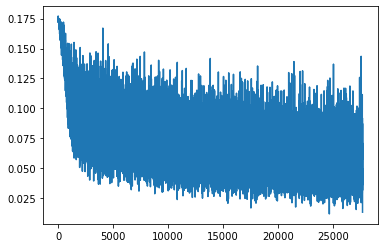

------
*********
29817 3074
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.16980449855327606
Loss:  0.1665620505809784
Loss:  0.15601572394371033
0 **********
Epoch:  55.79179096221924  fold:  8  kers:  64
epoch:  1
29817 466
Loss:  0.14757829904556274
Loss:  0.1285192370414734
Loss:  0.12564262747764587
1 **********
Epoch:  99.9965705871582  fold:  8  kers:  64
epoch:  2
29817 466
Loss:  0.11754000931978226
Loss:  0.11868410557508469
Loss:  0.09904203563928604
2 **********
Epoch:  144.24024605751038  fold:  8  kers:  64
epoch:  3
Eval Loss:  0.33971908688545227
Eval Loss:  0.9116443395614624
Eval Loss:  0.2084716558456421
[[1929  144]
 [ 403  598]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2073
   

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.46300095319747925
Eval Loss:  0.4452303946018219
Eval Loss:  0.3805944323539734
Eval Loss:  0.5024667978286743
Eval Loss:  0.36080873012542725
Eval Loss:  0.35007360577583313
Eval Loss:  0.6010146737098694
Eval Loss:  0.4807504117488861
Eval Loss:  0.38771292567253113
Eval Loss:  0.32094231247901917
Eval Loss:  0.4460615813732147
Eval Loss:  0.2889973521232605
Eval Loss:  0.45876920223236084
Eval Loss:  0.4069001078605652
Eval Loss:  0.41377875208854675
Eval Loss:  0.4088120460510254
Eval Loss:  0.5094278454780579
Eval Loss:  0.4165491759777069
Eval Loss:  0.46064502000808716
Eval Loss:  0.500719428062439
Eval Loss:  0.47303733229637146
Eval Loss:  0.4578824043273926
Eval Loss:  0.4260675013065338
Eval Loss:  0.4432089030742645
Eval Loss:  0.42661288380622864
Eval Loss:  0.5439872741699219
Eval Loss:  0.2639428973197937
Eval Loss:  0.41035038232803345
Eval Loss:  0.5041157007217407


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16092  1999]
 [ 3279  8447]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     18091
           1       0.81      0.72      0.76     11726

    accuracy                           0.82     29817
   macro avg       0.82      0.80      0.81     29817
weighted avg       0.82      0.82      0.82     29817

acc:  0.8229868866753866
pre:  0.808634884166188
rec:  0.7203650008528057
ma F1:  0.8105312884595026
mi F1:  0.8229868866753866
we F1:  0.820901449694833
29817 466
Loss:  0.08978157490491867
Loss:  0.06972751021385193
Loss:  0.11046573519706726
3 **********
Epoch:  225.55777287483215  fold:  8  kers:  64
epoch:  4
29817 466
Loss:  0.09962190687656403
Loss:  0.09539991617202759
Loss:  0.09030798822641373
4 **********
Epoch:  269.740611076355  fold:  8  kers:  64
epoch:  5
29817 466
Loss:  0.10922671854496002
Loss:  0.08876129239797592
Loss:  0.06571333110332489
5 **********
Epoch:  313.9942605495453  fold:  8  kers:  64
epoch:  6
Eval 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.48519226908683777
Eval Loss:  0.3884720504283905
Eval Loss:  0.3811891973018646
Eval Loss:  0.5355774164199829
Eval Loss:  0.3479037284851074
Eval Loss:  0.3239153325557709
Eval Loss:  0.6202802658081055
Eval Loss:  0.4695989787578583
Eval Loss:  0.38397571444511414
Eval Loss:  0.2797660827636719
Eval Loss:  0.4561220109462738
Eval Loss:  0.26624658703804016
Eval Loss:  0.45674991607666016
Eval Loss:  0.39181050658226013
Eval Loss:  0.41318202018737793
Eval Loss:  0.40415871143341064
Eval Loss:  0.4643635153770447
Eval Loss:  0.4406943619251251
Eval Loss:  0.4779861271381378
Eval Loss:  0.46682119369506836
Eval Loss:  0.5062246918678284
Eval Loss:  0.3922576606273651
Eval Loss:  0.3839099407196045
Eval Loss:  0.42454826831817627
Eval Loss:  0.42882075905799866
Eval Loss:  0.5200049877166748
Eval Loss:  0.22252462804317474
Eval Loss:  0.40044263005256653
Eval Loss:  0.511348307132721


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17099   992]
 [ 3915  7811]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     18091
           1       0.89      0.67      0.76     11726

    accuracy                           0.84     29817
   macro avg       0.85      0.81      0.82     29817
weighted avg       0.84      0.84      0.83     29817

acc:  0.8354294529966126
pre:  0.8873111439282063
rec:  0.6661265563704588
ma F1:  0.8177448041309662
mi F1:  0.8354294529966126
we F1:  0.8298639675708714
29817 466


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss:  0.1157737523317337
Loss:  0.08512555062770844
Loss:  0.09795285761356354
6 **********
Epoch:  397.9557161331177  fold:  8  kers:  64
epoch:  7
29817 466
Loss:  0.09362906962633133
Loss:  0.06952272355556488
Loss:  0.05543984845280647
7 **********
Epoch:  442.08370089530945  fold:  8  kers:  64
epoch:  8
29817 466
Loss:  0.08344782888889313
Loss:  0.10986915230751038
Loss:  0.07321186363697052
8 **********
Epoch:  486.3553020954132  fold:  8  kers:  64
epoch:  9
Eval Loss:  0.2987867295742035
Eval Loss:  1.26542329788208
Eval Loss:  0.13194996118545532
[[1978   95]
 [ 437  564]]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2073
           1       0.86      0.56      0.68      1001

    accuracy                           0.83      3074
   macro avg       0.84      0.76      0.78      3074
weighted avg       0.83      0.83      0.82      3074

acc:  0.8269355888093689
pre:  0.8558421851289834
rec:  0.5634365634365635
ma F1:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.3801625072956085
Eval Loss:  0.3310106694698334
Eval Loss:  0.2373848855495453
Eval Loss:  0.3706516921520233
Eval Loss:  0.2869434952735901
Eval Loss:  0.2428005039691925
Eval Loss:  0.4791567027568817
Eval Loss:  0.40680813789367676
Eval Loss:  0.3035827577114105
Eval Loss:  0.1755567044019699
Eval Loss:  0.3302232027053833
Eval Loss:  0.23686997592449188
Eval Loss:  0.36968863010406494
Eval Loss:  0.2860374450683594
Eval Loss:  0.3432169556617737
Eval Loss:  0.3528493046760559
Eval Loss:  0.29563066363334656
Eval Loss:  0.3405039608478546
Eval Loss:  0.40354472398757935
Eval Loss:  0.2858629822731018
Eval Loss:  0.3495695888996124
Eval Loss:  0.309695839881897
Eval Loss:  0.30848121643066406
Eval Loss:  0.373585969209671
Eval Loss:  0.33659619092941284
Eval Loss:  0.43774160742759705
Eval Loss:  0.17531321942806244
Eval Loss:  0.2915947735309601
Eval Loss:  0.41365787386894226


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16815  1276]
 [ 2663  9063]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90     18091
           1       0.88      0.77      0.82     11726

    accuracy                           0.87     29817
   macro avg       0.87      0.85      0.86     29817
weighted avg       0.87      0.87      0.87     29817

acc:  0.8678941543414831
pre:  0.8765838088790019
rec:  0.7728978338734437
ma F1:  0.8583174518369544
mi F1:  0.8678941543414831
we F1:  0.8661806757070941
29817 466
Loss:  0.06822392344474792
Loss:  0.06628279387950897
Loss:  0.06746764481067657
9 **********
Epoch:  567.8324019908905  fold:  8  kers:  64
epoch:  10
29817 466
Loss:  0.06224671006202698
Loss:  0.07582543790340424
Loss:  0.10986818373203278
10 **********
Epoch:  612.0760774612427  fold:  8  kers:  64
epoch:  11
29817 466
Loss:  0.06199260801076889
Loss:  0.07237851619720459
Loss:  0.11202730238437653
11 **********
Epoch:  656.2180254459381  fold:  8  kers:  64
epoch:  1

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.36575251817703247
Eval Loss:  0.34126409888267517
Eval Loss:  0.2659735679626465
Eval Loss:  0.4000394344329834
Eval Loss:  0.2678951919078827
Eval Loss:  0.2442958652973175
Eval Loss:  0.5047838091850281
Eval Loss:  0.392598420381546
Eval Loss:  0.3319946229457855
Eval Loss:  0.1930931806564331
Eval Loss:  0.35173964500427246
Eval Loss:  0.2177525758743286
Eval Loss:  0.3638625741004944
Eval Loss:  0.31150418519973755
Eval Loss:  0.3656562268733978
Eval Loss:  0.3744315207004547
Eval Loss:  0.2896108329296112
Eval Loss:  0.33391058444976807
Eval Loss:  0.4386676847934723
Eval Loss:  0.28216901421546936
Eval Loss:  0.3825104236602783
Eval Loss:  0.29027941823005676
Eval Loss:  0.33454176783561707
Eval Loss:  0.37030673027038574
Eval Loss:  0.36064159870147705
Eval Loss:  0.44326820969581604
Eval Loss:  0.17561525106430054
Eval Loss:  0.3064882159233093
Eval Loss:  0.4366101622581482


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17148   943]
 [ 3064  8662]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     18091
           1       0.90      0.74      0.81     11726

    accuracy                           0.87     29817
   macro avg       0.88      0.84      0.85     29817
weighted avg       0.87      0.87      0.86     29817

acc:  0.8656135761478351
pre:  0.9018219677251431
rec:  0.7387003240661777
ma F1:  0.8537690566883014
mi F1:  0.8656135761478351
we F1:  0.8626531441688496
29817 466
Loss:  0.08267085254192352
Loss:  0.0858263298869133
Loss:  0.11064861714839935
12 **********
Epoch:  737.3909380435944  fold:  8  kers:  64
epoch:  13
29817 466
Loss:  0.07119642943143845
Loss:  0.0755489394068718
Loss:  0.09416446089744568
13 **********
Epoch:  781.5947210788727  fold:  8  kers:  64
epoch:  14
29817 466
Loss:  0.08037911355495453
Loss:  0.09164934605360031
Loss:  0.08854521811008453
14 **********
Epoch:  825.7616016864777  fold:  8  kers:  64
epoch:  15

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.3347768485546112
Eval Loss:  0.32473549246788025
Eval Loss:  0.2798561155796051
Eval Loss:  0.37311851978302
Eval Loss:  0.2746454179286957
Eval Loss:  0.26435041427612305
Eval Loss:  0.4811020791530609
Eval Loss:  0.3711138367652893
Eval Loss:  0.3509056866168976
Eval Loss:  0.18755903840065002
Eval Loss:  0.3215023875236511
Eval Loss:  0.21104371547698975
Eval Loss:  0.3836503326892853
Eval Loss:  0.3067854046821594
Eval Loss:  0.36916983127593994
Eval Loss:  0.35605791211128235
Eval Loss:  0.2679685056209564
Eval Loss:  0.34222784638404846
Eval Loss:  0.4626310467720032
Eval Loss:  0.31442463397979736
Eval Loss:  0.36837977170944214
Eval Loss:  0.2716520428657532
Eval Loss:  0.3442198932170868
Eval Loss:  0.386919230222702
Eval Loss:  0.35919827222824097
Eval Loss:  0.44803881645202637
Eval Loss:  0.17378993332386017
Eval Loss:  0.3042096793651581
Eval Loss:  0.42195820808410645


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17290   801]
 [ 3169  8557]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     18091
           1       0.91      0.73      0.81     11726

    accuracy                           0.87     29817
   macro avg       0.88      0.84      0.85     29817
weighted avg       0.87      0.87      0.86     29817

acc:  0.8668544789884965
pre:  0.9144047873477239
rec:  0.7297458638922053
ma F1:  0.8543612099683533
mi F1:  0.8668544789884965
we F1:  0.8634668617848209
29817 466
Loss:  0.10117192566394806
Loss:  0.09968528896570206
Loss:  0.07854104042053223
15 **********
Epoch:  906.8696882724762  fold:  8  kers:  64
epoch:  16
29817 466
Loss:  0.10963842272758484
Loss:  0.043680448085069656
Loss:  0.07778101414442062
16 **********
Epoch:  951.0285911560059  fold:  8  kers:  64
epoch:  17
29817 466
Loss:  0.084233358502388
Loss:  0.097991943359375
Loss:  0.0822303295135498
17 **********
Epoch:  995.1336376667023  fold:  8  kers:  64
epoch:  18
E

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.26279523968696594
Eval Loss:  0.286528080701828
Eval Loss:  0.19349466264247894
Eval Loss:  0.2861221134662628
Eval Loss:  0.2474118024110794
Eval Loss:  0.19080303609371185
Eval Loss:  0.34346556663513184
Eval Loss:  0.3327453136444092
Eval Loss:  0.2721235752105713
Eval Loss:  0.17875848710536957
Eval Loss:  0.2693445086479187
Eval Loss:  0.17596864700317383
Eval Loss:  0.2891891896724701
Eval Loss:  0.26630130410194397
Eval Loss:  0.2640605866909027
Eval Loss:  0.3210657238960266
Eval Loss:  0.22243982553482056
Eval Loss:  0.25187432765960693
Eval Loss:  0.313956618309021
Eval Loss:  0.23025746643543243
Eval Loss:  0.30227354168891907
Eval Loss:  0.2668420076370239
Eval Loss:  0.29504406452178955
Eval Loss:  0.34996744990348816
Eval Loss:  0.2937967777252197
Eval Loss:  0.4071200489997864
Eval Loss:  0.16497495770454407
Eval Loss:  0.21988826990127563
Eval Loss:  0.34668147563934326


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16487  1604]
 [ 1757  9969]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     18091
           1       0.86      0.85      0.86     11726

    accuracy                           0.89     29817
   macro avg       0.88      0.88      0.88     29817
weighted avg       0.89      0.89      0.89     29817

acc:  0.8872790689874903
pre:  0.8614015380627322
rec:  0.8501620330888624
ma F1:  0.8816222688668327
mi F1:  0.8872790689874904
we F1:  0.8871462843267878
29817 466
Loss:  0.07197413593530655
Loss:  0.07748105376958847
Loss:  0.07627241313457489
18 **********
Epoch:  1076.2786252498627  fold:  8  kers:  64
epoch:  19
29817 466
Loss:  0.10260958224534988
Loss:  0.0809795930981636
Loss:  0.04688184708356857
19 **********
Epoch:  1120.4644560813904  fold:  8  kers:  64
epoch:  20
29817 466
Loss:  0.1089172512292862
Loss:  0.09010134637355804
Loss:  0.07346556335687637
20 **********
Epoch:  1164.45281457901  fold:  8  kers:  64
epoch:  2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2554692327976227
Eval Loss:  0.2685253918170929
Eval Loss:  0.2115272879600525
Eval Loss:  0.2797043025493622
Eval Loss:  0.2418622374534607
Eval Loss:  0.199376180768013
Eval Loss:  0.3645336329936981
Eval Loss:  0.3152610957622528
Eval Loss:  0.277701199054718
Eval Loss:  0.16281747817993164
Eval Loss:  0.27027827501296997
Eval Loss:  0.17347972095012665
Eval Loss:  0.30874505639076233
Eval Loss:  0.25831159949302673
Eval Loss:  0.2781784236431122
Eval Loss:  0.3157127797603607
Eval Loss:  0.20204633474349976
Eval Loss:  0.2557482123374939
Eval Loss:  0.3421729505062103
Eval Loss:  0.22889618575572968
Eval Loss:  0.2934809625148773
Eval Loss:  0.23182928562164307
Eval Loss:  0.299543172121048
Eval Loss:  0.3383569121360779
Eval Loss:  0.30359357595443726
Eval Loss:  0.40756499767303467
Eval Loss:  0.16580845415592194
Eval Loss:  0.2285717874765396
Eval Loss:  0.34194663166999817


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16927  1164]
 [ 2166  9560]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     18091
           1       0.89      0.82      0.85     11726

    accuracy                           0.89     29817
   macro avg       0.89      0.88      0.88     29817
weighted avg       0.89      0.89      0.89     29817

acc:  0.8883187443404769
pre:  0.8914584110406565
rec:  0.8152822786969128
ma F1:  0.8810578657295425
mi F1:  0.8883187443404769
we F1:  0.8873311781170269
29817 466
Loss:  0.06021564453840256
Loss:  0.04368758946657181
Loss:  0.07104956358671188
21 **********
Epoch:  1245.844143629074  fold:  8  kers:  64
epoch:  22
29817 466
Loss:  0.08339007943868637
Loss:  0.09173684567213058
Loss:  0.0765678659081459
22 **********
Epoch:  1289.980107307434  fold:  8  kers:  64
epoch:  23
29817 466
Loss:  0.044834867119789124
Loss:  0.06691787391901016
Loss:  0.07372736930847168
23 **********
Epoch:  1334.1021087169647  fold:  8  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.24976103007793427
Eval Loss:  0.26637783646583557
Eval Loss:  0.18961669504642487
Eval Loss:  0.27539175748825073
Eval Loss:  0.2216823846101761
Eval Loss:  0.18512125313282013
Eval Loss:  0.33235999941825867
Eval Loss:  0.28503042459487915
Eval Loss:  0.2712682783603668
Eval Loss:  0.17847822606563568
Eval Loss:  0.2511548101902008
Eval Loss:  0.15803666412830353
Eval Loss:  0.27096590399742126
Eval Loss:  0.2612859010696411
Eval Loss:  0.27336373925209045
Eval Loss:  0.3076685965061188
Eval Loss:  0.20676009356975555
Eval Loss:  0.21888768672943115
Eval Loss:  0.311607301235199
Eval Loss:  0.2296351045370102
Eval Loss:  0.2891426980495453
Eval Loss:  0.23245404660701752
Eval Loss:  0.3016498386859894
Eval Loss:  0.3183304965496063
Eval Loss:  0.27067050337791443
Eval Loss:  0.40042105317115784
Eval Loss:  0.16922014951705933
Eval Loss:  0.2162875384092331
Eval Loss:  0.32616087794303894


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16759  1332]
 [ 1792  9934]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     18091
           1       0.88      0.85      0.86     11726

    accuracy                           0.90     29817
   macro avg       0.89      0.89      0.89     29817
weighted avg       0.89      0.90      0.89     29817

acc:  0.8952275547506456
pre:  0.8817681519616546
rec:  0.8471772130308716
ma F1:  0.8894346489004541
mi F1:  0.8952275547506456
we F1:  0.8948371171402298
29817 466
Loss:  0.04880771040916443
Loss:  0.06294913589954376
Loss:  0.08340420573949814
24 **********
Epoch:  1415.3897149562836  fold:  8  kers:  64
epoch:  25
29817 466
Loss:  0.03964350000023842
Loss:  0.09764254838228226
Loss:  0.04263355955481529
25 **********
Epoch:  1464.7267694473267  fold:  8  kers:  64
epoch:  26
29817 466
Loss:  0.09085873514413834
Loss:  0.05372926592826843
Loss:  0.060397032648324966
26 **********
Epoch:  1509.253687620163  fold:  8  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.23747001588344574
Eval Loss:  0.2570236921310425
Eval Loss:  0.1938750296831131
Eval Loss:  0.2663672864437103
Eval Loss:  0.22685159742832184
Eval Loss:  0.1720731109380722
Eval Loss:  0.3298797309398651
Eval Loss:  0.2886318564414978
Eval Loss:  0.261157363653183
Eval Loss:  0.17759905755519867
Eval Loss:  0.24705374240875244
Eval Loss:  0.15768764913082123
Eval Loss:  0.2768195867538452
Eval Loss:  0.2471293956041336
Eval Loss:  0.24976760149002075
Eval Loss:  0.32041600346565247
Eval Loss:  0.21400366723537445
Eval Loss:  0.210147887468338
Eval Loss:  0.3000151515007019
Eval Loss:  0.2182670533657074
Eval Loss:  0.2819043695926666
Eval Loss:  0.23861876130104065
Eval Loss:  0.284347265958786
Eval Loss:  0.29161369800567627
Eval Loss:  0.26971548795700073
Eval Loss:  0.4016910493373871
Eval Loss:  0.16780218482017517
Eval Loss:  0.21166977286338806
Eval Loss:  0.31744322180747986


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16711  1380]
 [ 1674 10052]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     18091
           1       0.88      0.86      0.87     11726

    accuracy                           0.90     29817
   macro avg       0.89      0.89      0.89     29817
weighted avg       0.90      0.90      0.90     29817

acc:  0.8975752087735185
pre:  0.8792862141357592
rec:  0.8572403206549548
ma F1:  0.8921985204676011
mi F1:  0.8975752087735185
we F1:  0.8973378238265385
29817 466
Loss:  0.07037535309791565
Loss:  0.04899298772215843
Loss:  0.07024618983268738
27 **********
Epoch:  1590.5183551311493  fold:  8  kers:  64
epoch:  28
29817 466
Loss:  0.09821173548698425
Loss:  0.07954884320497513
Loss:  0.03718436509370804
28 **********
Epoch:  1634.5845057964325  fold:  8  kers:  64
epoch:  29
29817 466
Loss:  0.05722297355532646
Loss:  0.033470943570137024
Loss:  0.08436997979879379
29 **********
Epoch:  1678.7633547782898  fold:  8  kers:  64
epoc

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.25450438261032104
Eval Loss:  0.2515919804573059
Eval Loss:  0.20832769572734833
Eval Loss:  0.30284738540649414
Eval Loss:  0.20637741684913635
Eval Loss:  0.18766829371452332
Eval Loss:  0.3487807512283325
Eval Loss:  0.2635982632637024
Eval Loss:  0.2869306206703186
Eval Loss:  0.1725827306509018
Eval Loss:  0.25661391019821167
Eval Loss:  0.14575256407260895
Eval Loss:  0.2750042676925659
Eval Loss:  0.24439018964767456
Eval Loss:  0.2441716343164444
Eval Loss:  0.3196087181568146
Eval Loss:  0.2189030647277832
Eval Loss:  0.22686538100242615
Eval Loss:  0.2923734784126282
Eval Loss:  0.2546902000904083
Eval Loss:  0.2784667909145355
Eval Loss:  0.241460919380188
Eval Loss:  0.27231988310813904
Eval Loss:  0.2802993953227997
Eval Loss:  0.2708249092102051
Eval Loss:  0.4086344838142395
Eval Loss:  0.1440432369709015
Eval Loss:  0.22064657509326935
Eval Loss:  0.29355260729789734


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16856  1235]
 [ 1888  9838]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     18091
           1       0.89      0.84      0.86     11726

    accuracy                           0.90     29817
   macro avg       0.89      0.89      0.89     29817
weighted avg       0.90      0.90      0.89     29817

acc:  0.8952610926652581
pre:  0.888467443330624
rec:  0.8389902780146683
ma F1:  0.8891184069743462
mi F1:  0.8952610926652581
we F1:  0.8946895375560867
29817 466
Loss:  0.061207085847854614
Loss:  0.0662173256278038
Loss:  0.10628322511911392
30 **********
Epoch:  1759.948235988617  fold:  8  kers:  64
epoch:  31
29817 466
Loss:  0.07260418683290482
Loss:  0.11944952607154846
Loss:  0.05265916883945465
31 **********
Epoch:  1804.1260876655579  fold:  8  kers:  64
epoch:  32
29817 466
Loss:  0.03892504423856735
Loss:  0.04301327094435692
Loss:  0.05907657742500305
32 **********
Epoch:  1849.1915657520294  fold:  8  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2407120317220688
Eval Loss:  0.24928247928619385
Eval Loss:  0.20112712681293488
Eval Loss:  0.29166555404663086
Eval Loss:  0.2198473960161209
Eval Loss:  0.1920822709798813
Eval Loss:  0.33405715227127075
Eval Loss:  0.26238614320755005
Eval Loss:  0.27144673466682434
Eval Loss:  0.17433814704418182
Eval Loss:  0.21820542216300964
Eval Loss:  0.1434827744960785
Eval Loss:  0.2525138258934021
Eval Loss:  0.2386794537305832
Eval Loss:  0.26099780201911926
Eval Loss:  0.31708821654319763
Eval Loss:  0.2258499711751938
Eval Loss:  0.20747646689414978
Eval Loss:  0.2813960015773773
Eval Loss:  0.2202526330947876
Eval Loss:  0.2722035050392151
Eval Loss:  0.2194022536277771
Eval Loss:  0.2717018127441406
Eval Loss:  0.2654561698436737
Eval Loss:  0.27264589071273804
Eval Loss:  0.3847411870956421
Eval Loss:  0.14855289459228516
Eval Loss:  0.21695367991924286
Eval Loss:  0.2916759252548218


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16970  1121]
 [ 1876  9850]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     18091
           1       0.90      0.84      0.87     11726

    accuracy                           0.90     29817
   macro avg       0.90      0.89      0.89     29817
weighted avg       0.90      0.90      0.90     29817

acc:  0.8994868699064292
pre:  0.8978215294868289
rec:  0.8400136448916937
ma F1:  0.8934089816971018
mi F1:  0.8994868699064292
we F1:  0.8988423747381649
29817 466
Loss:  0.060266174376010895
Loss:  0.0667736753821373
Loss:  0.04389895498752594
33 **********
Epoch:  1930.3485214710236  fold:  8  kers:  64
epoch:  34
29817 466
Loss:  0.08077563345432281
Loss:  0.06190215051174164
Loss:  0.0506078377366066
34 **********
Epoch:  1974.5892055034637  fold:  8  kers:  64
epoch:  35
29817 466
Loss:  0.08661861717700958
Loss:  0.07247336208820343
Loss:  0.04835854470729828
35 **********
Epoch:  2018.8548226356506  fold:  8  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.25003883242607117
Eval Loss:  0.25472062826156616
Eval Loss:  0.1900317668914795
Eval Loss:  0.24828404188156128
Eval Loss:  0.21346382796764374
Eval Loss:  0.1772702932357788
Eval Loss:  0.27766498923301697
Eval Loss:  0.2740077078342438
Eval Loss:  0.24831977486610413
Eval Loss:  0.1778940111398697
Eval Loss:  0.22576682269573212
Eval Loss:  0.1676815301179886
Eval Loss:  0.26643437147140503
Eval Loss:  0.23258285224437714
Eval Loss:  0.25339019298553467
Eval Loss:  0.32123863697052
Eval Loss:  0.2167230248451233
Eval Loss:  0.19824501872062683
Eval Loss:  0.2660753130912781
Eval Loss:  0.2104397565126419
Eval Loss:  0.25113892555236816
Eval Loss:  0.22641000151634216
Eval Loss:  0.2769131362438202
Eval Loss:  0.2811315953731537
Eval Loss:  0.27642732858657837
Eval Loss:  0.36814993619918823
Eval Loss:  0.16300123929977417
Eval Loss:  0.19669903814792633
Eval Loss:  0.2828404903411865


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16565  1526]
 [ 1420 10306]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     18091
           1       0.87      0.88      0.87     11726

    accuracy                           0.90     29817
   macro avg       0.90      0.90      0.90     29817
weighted avg       0.90      0.90      0.90     29817

acc:  0.9011973035516652
pre:  0.8710277214334009
rec:  0.8789015862186594
ma F1:  0.8966430007244048
mi F1:  0.9011973035516652
we F1:  0.9012744334605466
29817 466
Loss:  0.031401004642248154
Loss:  0.04278719425201416
Loss:  0.058793723583221436
36 **********
Epoch:  2100.1085197925568  fold:  8  kers:  64
epoch:  37
29817 466
Loss:  0.049160752445459366
Loss:  0.05441827327013016
Loss:  0.053452372550964355
37 **********
Epoch:  2144.3641633987427  fold:  8  kers:  64
epoch:  38
29817 466
Loss:  0.08924398571252823
Loss:  0.05904031917452812
Loss:  0.05049322918057442
38 **********
Epoch:  2198.8933317661285  fold:  8  kers:  64
e

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.25766822695732117
Eval Loss:  0.25269460678100586
Eval Loss:  0.17550142109394073
Eval Loss:  0.2745269536972046
Eval Loss:  0.20736011862754822
Eval Loss:  0.17712384462356567
Eval Loss:  0.28453752398490906
Eval Loss:  0.28803014755249023
Eval Loss:  0.27321702241897583
Eval Loss:  0.1998104602098465
Eval Loss:  0.2309693992137909
Eval Loss:  0.17710506916046143
Eval Loss:  0.2637517750263214
Eval Loss:  0.24518772959709167
Eval Loss:  0.2722429931163788
Eval Loss:  0.3325323462486267
Eval Loss:  0.2397422045469284
Eval Loss:  0.20737555623054504
Eval Loss:  0.24778185784816742
Eval Loss:  0.21362413465976715
Eval Loss:  0.2377285361289978
Eval Loss:  0.26603826880455017
Eval Loss:  0.29125046730041504
Eval Loss:  0.29203474521636963
Eval Loss:  0.2732800245285034
Eval Loss:  0.3698923885822296
Eval Loss:  0.176069438457489
Eval Loss:  0.1988574117422104
Eval Loss:  0.2870223820209503


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16129  1962]
 [ 1106 10620]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     18091
           1       0.84      0.91      0.87     11726

    accuracy                           0.90     29817
   macro avg       0.89      0.90      0.89     29817
weighted avg       0.90      0.90      0.90     29817

acc:  0.8971056779689439
pre:  0.844062947067239
rec:  0.9056796861674911
ma F1:  0.8934690969933858
mi F1:  0.8971056779689439
we F1:  0.8976707375650735
29817 466
Loss:  0.06387285143136978
Loss:  0.08718638867139816
Loss:  0.0745757520198822
39 **********
Epoch:  2280.673620700836  fold:  8  kers:  64
epoch:  40
29817 466
Loss:  0.07569772005081177
Loss:  0.04530543088912964
Loss:  0.0340392105281353
40 **********
Epoch:  2324.8574562072754  fold:  8  kers:  64
epoch:  41
29817 466
Loss:  0.07839266955852509
Loss:  0.09833606332540512
Loss:  0.05425866320729256
41 **********
Epoch:  2369.048273563385  fold:  8  kers:  64
epoch:  42

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.29278767108917236
Eval Loss:  0.27933958172798157
Eval Loss:  0.2200712114572525
Eval Loss:  0.28354018926620483
Eval Loss:  0.22577348351478577
Eval Loss:  0.220547616481781
Eval Loss:  0.2763534486293793
Eval Loss:  0.3310111165046692
Eval Loss:  0.2945563495159149
Eval Loss:  0.22470855712890625
Eval Loss:  0.23086947202682495
Eval Loss:  0.22624178230762482
Eval Loss:  0.28187209367752075
Eval Loss:  0.2838989198207855
Eval Loss:  0.2938265800476074
Eval Loss:  0.3551586866378784
Eval Loss:  0.2721817195415497
Eval Loss:  0.21564596891403198
Eval Loss:  0.24164146184921265
Eval Loss:  0.21995389461517334
Eval Loss:  0.23847071826457977
Eval Loss:  0.31965741515159607
Eval Loss:  0.3195688724517822
Eval Loss:  0.3128838837146759
Eval Loss:  0.29881221055984497
Eval Loss:  0.3820333778858185
Eval Loss:  0.19983506202697754
Eval Loss:  0.22303979098796844
Eval Loss:  0.2919284403324127


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[15539  2552]
 [  834 10892]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     18091
           1       0.81      0.93      0.87     11726

    accuracy                           0.89     29817
   macro avg       0.88      0.89      0.88     29817
weighted avg       0.89      0.89      0.89     29817

acc:  0.8864406211221786
pre:  0.8101755429931567
rec:  0.9288760020467337
ma F1:  0.8836136624712401
mi F1:  0.8864406211221787
we F1:  0.887485750229627
29817 466
Loss:  0.07636183500289917
Loss:  0.07537286728620529
Loss:  0.05631202459335327
42 **********
Epoch:  2450.276039838791  fold:  8  kers:  64
epoch:  43
29817 466
Loss:  0.05856044590473175
Loss:  0.10130812227725983
Loss:  0.05642518028616905
43 **********
Epoch:  2494.3681211471558  fold:  8  kers:  64
epoch:  44
29817 466
Loss:  0.08053947240114212
Loss:  0.0425446517765522
Loss:  0.06664245575666428
44 **********
Epoch:  2538.360469341278  fold:  8  kers:  64
epoch:  4

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2463400661945343
Eval Loss:  0.23042598366737366
Eval Loss:  0.1905059814453125
Eval Loss:  0.24434567987918854
Eval Loss:  0.1877930909395218
Eval Loss:  0.17550650238990784
Eval Loss:  0.27196016907691956
Eval Loss:  0.2610164284706116
Eval Loss:  0.24342991411685944
Eval Loss:  0.18497711420059204
Eval Loss:  0.21139512956142426
Eval Loss:  0.16920319199562073
Eval Loss:  0.21742472052574158
Eval Loss:  0.24700701236724854
Eval Loss:  0.25074759125709534
Eval Loss:  0.3210597634315491
Eval Loss:  0.2415158897638321
Eval Loss:  0.19390632212162018
Eval Loss:  0.24101951718330383
Eval Loss:  0.20831356942653656
Eval Loss:  0.23872488737106323
Eval Loss:  0.22541208565235138
Eval Loss:  0.2690246105194092
Eval Loss:  0.26800498366355896
Eval Loss:  0.27133142948150635
Eval Loss:  0.35408326983451843
Eval Loss:  0.1512109637260437
Eval Loss:  0.18844088912010193
Eval Loss:  0.2624755799770355


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16573  1518]
 [ 1269 10457]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     18091
           1       0.87      0.89      0.88     11726

    accuracy                           0.91     29817
   macro avg       0.90      0.90      0.90     29817
weighted avg       0.91      0.91      0.91     29817

acc:  0.9065298319750478
pre:  0.8732359081419624
rec:  0.8917789527545625
ma F1:  0.9024245042787529
mi F1:  0.9065298319750478
we F1:  0.9066969717063063
29817 466
Loss:  0.06682782620191574
Loss:  0.07573995739221573
Loss:  0.10759463161230087
45 **********
Epoch:  2619.7657606601715  fold:  8  kers:  64
epoch:  46
29817 466
Loss:  0.11192636936903
Loss:  0.08036529272794724
Loss:  0.07653951644897461
46 **********
Epoch:  2663.800994157791  fold:  8  kers:  64
epoch:  47
29817 466
Loss:  0.07298664003610611
Loss:  0.04085645079612732
Loss:  0.06754713505506516
47 **********
Epoch:  2707.9399497509003  fold:  8  kers:  64
epoch:  4

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2256747931241989
Eval Loss:  0.24174778163433075
Eval Loss:  0.1708204448223114
Eval Loss:  0.23393113911151886
Eval Loss:  0.1877773255109787
Eval Loss:  0.15772858262062073
Eval Loss:  0.27799347043037415
Eval Loss:  0.2461482733488083
Eval Loss:  0.23937614262104034
Eval Loss:  0.17137840390205383
Eval Loss:  0.202399343252182
Eval Loss:  0.1606498658657074
Eval Loss:  0.21538273990154266
Eval Loss:  0.22120094299316406
Eval Loss:  0.2566540241241455
Eval Loss:  0.291187047958374
Eval Loss:  0.23525464534759521
Eval Loss:  0.19933995604515076
Eval Loss:  0.23566807806491852
Eval Loss:  0.19930624961853027
Eval Loss:  0.2169860303401947
Eval Loss:  0.2072940170764923
Eval Loss:  0.25784748792648315
Eval Loss:  0.24485649168491364
Eval Loss:  0.22849571704864502
Eval Loss:  0.35282737016677856
Eval Loss:  0.1462927758693695
Eval Loss:  0.1980372965335846
Eval Loss:  0.26011157035827637


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16788  1303]
 [ 1385 10341]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     18091
           1       0.89      0.88      0.88     11726

    accuracy                           0.91     29817
   macro avg       0.91      0.90      0.91     29817
weighted avg       0.91      0.91      0.91     29817

acc:  0.9098500855216822
pre:  0.8880968739264857
rec:  0.8818864062766502
ma F1:  0.9054288236288612
mi F1:  0.9098500855216822
we F1:  0.9097938510753955
29817 466
Loss:  0.05517154932022095
Loss:  0.07402870059013367
Loss:  0.05479656904935837
48 **********
Epoch:  2789.152756214142  fold:  8  kers:  64
epoch:  49
29817 466
Loss:  0.05404730141162872
Loss:  0.06551659852266312
Loss:  0.05971064046025276
49 **********
Epoch:  2833.2588000297546  fold:  8  kers:  64
epoch:  50
29817 466
Loss:  0.04453665763139725
Loss:  0.0368618406355381
Loss:  0.08167505264282227
50 **********
Epoch:  2877.400747537613  fold:  8  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.23321393132209778
Eval Loss:  0.24679315090179443
Eval Loss:  0.15315602719783783
Eval Loss:  0.23569658398628235
Eval Loss:  0.20174212753772736
Eval Loss:  0.15835808217525482
Eval Loss:  0.27047449350357056
Eval Loss:  0.24750111997127533
Eval Loss:  0.24789229035377502
Eval Loss:  0.17459821701049805
Eval Loss:  0.18775510787963867
Eval Loss:  0.15532492101192474
Eval Loss:  0.21872255206108093
Eval Loss:  0.2269885092973709
Eval Loss:  0.280947744846344
Eval Loss:  0.29013124108314514
Eval Loss:  0.23837222158908844
Eval Loss:  0.1852862387895584
Eval Loss:  0.2189110517501831
Eval Loss:  0.17831313610076904
Eval Loss:  0.2179279923439026
Eval Loss:  0.2288053184747696
Eval Loss:  0.2681591510772705
Eval Loss:  0.24959886074066162
Eval Loss:  0.24069182574748993
Eval Loss:  0.34178704023361206
Eval Loss:  0.14711424708366394
Eval Loss:  0.18872223794460297
Eval Loss:  0.25699880719184875


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16714  1377]
 [ 1268 10458]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     18091
           1       0.88      0.89      0.89     11726

    accuracy                           0.91     29817
   macro avg       0.91      0.91      0.91     29817
weighted avg       0.91      0.91      0.91     29817

acc:  0.9112922158500184
pre:  0.8836501901140684
rec:  0.891864233327648
ma F1:  0.9072073365353103
mi F1:  0.9112922158500184
we F1:  0.9113633878201755
29817 466
Loss:  0.05430741235613823
Loss:  0.09898710250854492
Loss:  0.038679372519254684
51 **********
Epoch:  2970.13175034523  fold:  8  kers:  64
epoch:  52
29817 466
Loss:  0.039351798593997955
Loss:  0.05915672332048416
Loss:  0.08011055737733841
52 **********
Epoch:  3014.6297459602356  fold:  8  kers:  64
epoch:  53
29817 466
Loss:  0.054683197289705276
Loss:  0.027111627161502838
Loss:  0.070844866335392
53 **********
Epoch:  3058.681934118271  fold:  8  kers:  64
epoch: 

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.24423418939113617
Eval Loss:  0.21911324560642242
Eval Loss:  0.17243395745754242
Eval Loss:  0.24446985125541687
Eval Loss:  0.1979217380285263
Eval Loss:  0.1608773022890091
Eval Loss:  0.276692271232605
Eval Loss:  0.21872928738594055
Eval Loss:  0.22914543747901917
Eval Loss:  0.1699417680501938
Eval Loss:  0.20695677399635315
Eval Loss:  0.14644192159175873
Eval Loss:  0.22997115552425385
Eval Loss:  0.2160072922706604
Eval Loss:  0.26331278681755066
Eval Loss:  0.2901974618434906
Eval Loss:  0.23667408525943756
Eval Loss:  0.2064571976661682
Eval Loss:  0.23936627805233002
Eval Loss:  0.1708957850933075
Eval Loss:  0.2268340140581131
Eval Loss:  0.19082877039909363
Eval Loss:  0.2781599164009094
Eval Loss:  0.2298300564289093
Eval Loss:  0.23577627539634705
Eval Loss:  0.33043786883354187
Eval Loss:  0.14177127182483673
Eval Loss:  0.1801423877477646
Eval Loss:  0.2645193934440613


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17084  1007]
 [ 1609 10117]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     18091
           1       0.91      0.86      0.89     11726

    accuracy                           0.91     29817
   macro avg       0.91      0.90      0.91     29817
weighted avg       0.91      0.91      0.91     29817

acc:  0.91226481537378
pre:  0.9094750089895721
rec:  0.8627835579055091
ma F1:  0.9071981729283877
mi F1:  0.91226481537378
we F1:  0.9118270202320942
29817 466
Loss:  0.0412619411945343
Loss:  0.05478929355740547
Loss:  0.05585366114974022
54 **********
Epoch:  3139.8817751407623  fold:  8  kers:  64
epoch:  55
29817 466
Loss:  0.07595161348581314
Loss:  0.06257867813110352
Loss:  0.061173636466264725
55 **********
Epoch:  3183.952912092209  fold:  8  kers:  64
epoch:  56
29817 466
Loss:  0.05923108011484146
Loss:  0.032826147973537445
Loss:  0.06913571804761887
56 **********
Epoch:  3228.1287693977356  fold:  8  kers:  64
epoch:  5

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2323034107685089
Eval Loss:  0.225608691573143
Eval Loss:  0.1561887115240097
Eval Loss:  0.23497875034809113
Eval Loss:  0.1857570856809616
Eval Loss:  0.1543518453836441
Eval Loss:  0.2678050100803375
Eval Loss:  0.21919040381908417
Eval Loss:  0.24215450882911682
Eval Loss:  0.1572452336549759
Eval Loss:  0.19829386472702026
Eval Loss:  0.13197772204875946
Eval Loss:  0.21799910068511963
Eval Loss:  0.2245289832353592
Eval Loss:  0.2767285704612732
Eval Loss:  0.27045926451683044
Eval Loss:  0.24425846338272095
Eval Loss:  0.20250685513019562
Eval Loss:  0.22179017961025238
Eval Loss:  0.1713142991065979
Eval Loss:  0.2027815878391266
Eval Loss:  0.21886633336544037
Eval Loss:  0.26488161087036133
Eval Loss:  0.23591431975364685
Eval Loss:  0.2308860570192337
Eval Loss:  0.31795862317085266
Eval Loss:  0.1424504965543747
Eval Loss:  0.17682084441184998
Eval Loss:  0.2451273798942566


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16880  1211]
 [ 1357 10369]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     18091
           1       0.90      0.88      0.89     11726

    accuracy                           0.91     29817
   macro avg       0.91      0.91      0.91     29817
weighted avg       0.91      0.91      0.91     29817

acc:  0.9138746352751785
pre:  0.8954231433506045
rec:  0.8842742623230428
ma F1:  0.9095622531843843
mi F1:  0.9138746352751785
we F1:  0.9137779361836018
29817 466
Loss:  0.031872786581516266
Loss:  0.040794648230075836
Loss:  0.04378161579370499
57 **********
Epoch:  3309.5759489536285  fold:  8  kers:  64
epoch:  58
29817 466
Loss:  0.07279279828071594
Loss:  0.04556392878293991
Loss:  0.05024639517068863
58 **********
Epoch:  3353.8266060352325  fold:  8  kers:  64
epoch:  59
29817 466
Loss:  0.05991344526410103
Loss:  0.053390417248010635
Loss:  0.039686042815446854
59 **********
Epoch:  3398.0323836803436  fold:  8  kers:  64
E

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


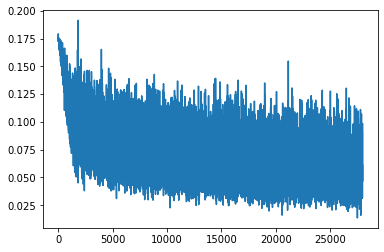

------
*********
29483 3408
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.16933757066726685
Loss:  0.16366198658943176
Loss:  0.16504643857479095
0 **********
Epoch:  55.33800458908081  fold:  9  kers:  64
epoch:  1
29483 461
Loss:  0.1438739001750946
Loss:  0.14106883108615875
Loss:  0.10990576446056366
1 **********
Epoch:  99.09498190879822  fold:  9  kers:  64
epoch:  2
29483 461
Loss:  0.11816724389791489
Loss:  0.11179859936237335
Loss:  0.09029839932918549
2 **********
Epoch:  142.95568180084229  fold:  9  kers:  64
epoch:  3
Eval Loss:  0.2122759371995926
Eval Loss:  1.1628899574279785
Eval Loss:  0.3027991056442261


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1549  193]
 [ 370 1296]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1742
           1       0.87      0.78      0.82      1666

    accuracy                           0.83      3408
   macro avg       0.84      0.83      0.83      3408
weighted avg       0.84      0.83      0.83      3408

acc:  0.8348004694835681
pre:  0.8703828072531901
rec:  0.7779111644657863
ma F1:  0.8338849854832558
mi F1:  0.8348004694835681
we F1:  0.834159992534733
update!  Acc:  0.8348004694835681
Eval Loss:  0.352383553981781
Eval Loss:  0.3913528025150299
Eval Loss:  0.464670866727829
Eval Loss:  0.4237552881240845
Eval Loss:  0.4285367727279663
Eval Loss:  0.4597533047199249
Eval Loss:  0.5486626029014587
Eval Loss:  0.4914785623550415
Eval Loss:  0.4358963370323181
Eval Loss:  0.3655625879764557
Eval Loss:  0.4594227075576782
Eval Loss:  0.4185841381549835
Eval Loss:  0.4170342981815338
Eval Loss:  0.46230795979499817
Eval Loss:  0.3997502028

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16247  2175]
 [ 3155  7906]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     18422
           1       0.78      0.71      0.75     11061

    accuracy                           0.82     29483
   macro avg       0.81      0.80      0.80     29483
weighted avg       0.82      0.82      0.82     29483

acc:  0.819217854356748
pre:  0.7842475944846742
rec:  0.71476358376277
ma F1:  0.8034896821484759
mi F1:  0.819217854356748
we F1:  0.8173699214033722
29483 461
Loss:  0.0797167494893074
Loss:  0.09421608597040176
Loss:  0.10006570816040039
3 **********
Epoch:  224.3410267829895  fold:  9  kers:  64
epoch:  4
29483 461
Loss:  0.08239247649908066
Loss:  0.09638401120901108
Loss:  0.1025347039103508
4 **********
Epoch:  268.12792444229126  fold:  9  kers:  64
epoch:  5
29483 461
Loss:  0.0758436843752861
Loss:  0.07237379997968674
Loss:  0.09179043024778366
5 **********
Epoch:  311.99760007858276  fold:  9  kers:  64
epoch:  6
Eval Los

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1618  124]
 [ 444 1222]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1742
           1       0.91      0.73      0.81      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.83      0.83      3408
weighted avg       0.84      0.83      0.83      3408

acc:  0.8333333333333334
pre:  0.9078751857355126
rec:  0.7334933973589436
ma F1:  0.8310522368988819
mi F1:  0.8333333333333334
we F1:  0.8314900230832715
Eval Loss:  0.3083013594150543
Eval Loss:  0.32394424080848694
Eval Loss:  0.4245242178440094
Eval Loss:  0.3394688665866852
Eval Loss:  0.36977440118789673
Eval Loss:  0.35821977257728577
Eval Loss:  0.47043612599372864
Eval Loss:  0.45243093371391296
Eval Loss:  0.4055093824863434
Eval Loss:  0.32234275341033936
Eval Loss:  0.41601866483688354
Eval Loss:  0.343241810798645
Eval Loss:  0.4070439636707306
Eval Loss:  0.4596516489982605
Eval Loss:  0.3845331072807312
Eval Loss:  0.35902

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17161  1261]
 [ 3131  7930]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     18422
           1       0.86      0.72      0.78     11061

    accuracy                           0.85     29483
   macro avg       0.85      0.82      0.83     29483
weighted avg       0.85      0.85      0.85     29483

acc:  0.8510327985618831
pre:  0.8628005657708628
rec:  0.7169333694964289
ma F1:  0.8348425992029284
mi F1:  0.8510327985618831
we F1:  0.8477530160029789
29483 461
Loss:  0.10622762888669968
Loss:  0.10450451076030731
Loss:  0.07583785802125931
6 **********
Epoch:  392.9939856529236  fold:  9  kers:  64
epoch:  7
29483 461
Loss:  0.12392933666706085
Loss:  0.07270247489213943
Loss:  0.10288819670677185
7 **********
Epoch:  436.924498796463  fold:  9  kers:  64
epoch:  8
29483 461
Loss:  0.08772192895412445
Loss:  0.08166623115539551
Loss:  0.08324796706438065
8 **********
Epoch:  480.81013226509094  fold:  9  kers:  64
epoch:  9
Eva

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1675   67]
 [ 521 1145]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1742
           1       0.94      0.69      0.80      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.82      0.82      3408
weighted avg       0.85      0.83      0.82      3408

acc:  0.8274647887323944
pre:  0.9447194719471947
rec:  0.6872749099639855
ma F1:  0.8231885398097192
mi F1:  0.8274647887323944
we F1:  0.8238017377684425
Eval Loss:  0.33114326000213623
Eval Loss:  0.3519512414932251
Eval Loss:  0.39540040493011475
Eval Loss:  0.3472023010253906
Eval Loss:  0.40392160415649414
Eval Loss:  0.35647082328796387
Eval Loss:  0.45290496945381165
Eval Loss:  0.42128586769104004
Eval Loss:  0.42133432626724243
Eval Loss:  0.3210940957069397
Eval Loss:  0.41615644097328186
Eval Loss:  0.3305235803127289
Eval Loss:  0.437404602766037
Eval Loss:  0.42433810234069824
Eval Loss:  0.40520766377449036
Eval Loss:  0.35

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17553   869]
 [ 3520  7541]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     18422
           1       0.90      0.68      0.77     11061

    accuracy                           0.85     29483
   macro avg       0.86      0.82      0.83     29483
weighted avg       0.86      0.85      0.85     29483

acc:  0.851134552114778
pre:  0.8966706302021403
rec:  0.6817647590633759
ma F1:  0.8317299288552125
mi F1:  0.851134552114778
we F1:  0.8459965520886985
29483 461
Loss:  0.0852973461151123
Loss:  0.07267338782548904
Loss:  0.05861125513911247
9 **********
Epoch:  570.6777920722961  fold:  9  kers:  64
epoch:  10
29483 461
Loss:  0.0895085334777832
Loss:  0.0908873900771141
Loss:  0.06666875630617142
10 **********
Epoch:  614.65119099617  fold:  9  kers:  64
epoch:  11
29483 461
Loss:  0.08448383957147598
Loss:  0.08049143850803375
Loss:  0.0881420373916626
11 **********
Epoch:  658.563752412796  fold:  9  kers:  64
epoch:  12
Eval Lo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1619  123]
 [ 423 1243]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1742
           1       0.91      0.75      0.82      1666

    accuracy                           0.84      3408
   macro avg       0.85      0.84      0.84      3408
weighted avg       0.85      0.84      0.84      3408

acc:  0.8397887323943662
pre:  0.9099560761346999
rec:  0.7460984393757503
ma F1:  0.8378145447851529
mi F1:  0.8397887323943664
we F1:  0.8382135827061641
update!  Acc:  0.8397887323943662
Eval Loss:  0.3002412021160126
Eval Loss:  0.328177809715271
Eval Loss:  0.34432193636894226
Eval Loss:  0.2880963981151581
Eval Loss:  0.27636614441871643
Eval Loss:  0.2340846210718155
Eval Loss:  0.39230942726135254
Eval Loss:  0.39081263542175293
Eval Loss:  0.30518239736557007
Eval Loss:  0.29317766427993774
Eval Loss:  0.3209449052810669
Eval Loss:  0.31175029277801514
Eval Loss:  0.3555947542190552
Eval Loss:  0.3513951003551483
Eval Loss:  0.30

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17100  1322]
 [ 2316  8745]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     18422
           1       0.87      0.79      0.83     11061

    accuracy                           0.88     29483
   macro avg       0.87      0.86      0.87     29483
weighted avg       0.88      0.88      0.88     29483

acc:  0.8766068581894652
pre:  0.8686798450382438
rec:  0.7906156767019257
ma F1:  0.8658323521313755
mi F1:  0.8766068581894652
we F1:  0.8753250079175632
29483 461
Loss:  0.0659358873963356
Loss:  0.06141843646764755
Loss:  0.09238410741090775
12 **********
Epoch:  739.4913215637207  fold:  9  kers:  64
epoch:  13
29483 461
Loss:  0.07668264955282211
Loss:  0.08453460782766342
Loss:  0.10005505383014679
13 **********
Epoch:  783.3290829658508  fold:  9  kers:  64
epoch:  14
29483 461
Loss:  0.05739709734916687
Loss:  0.06282801926136017
Loss:  0.051903244107961655
14 **********
Epoch:  826.9723641872406  fold:  9  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1688   54]
 [ 572 1094]]
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      1742
           1       0.95      0.66      0.78      1666

    accuracy                           0.82      3408
   macro avg       0.85      0.81      0.81      3408
weighted avg       0.85      0.82      0.81      3408

acc:  0.8163145539906104
pre:  0.9529616724738676
rec:  0.6566626650660264
ma F1:  0.8105595389938294
mi F1:  0.8163145539906104
we F1:  0.8112958708789394
Eval Loss:  0.34014952182769775
Eval Loss:  0.3357207775115967
Eval Loss:  0.3529350757598877
Eval Loss:  0.3219676613807678
Eval Loss:  0.39325541257858276
Eval Loss:  0.2792273461818695
Eval Loss:  0.41503384709358215
Eval Loss:  0.38261672854423523
Eval Loss:  0.3657490611076355
Eval Loss:  0.2764766812324524
Eval Loss:  0.3779360055923462
Eval Loss:  0.3038631081581116
Eval Loss:  0.37996935844421387
Eval Loss:  0.3550707995891571
Eval Loss:  0.36546096205711365
Eval Loss:  0.33048

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17793   629]
 [ 3449  7612]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     18422
           1       0.92      0.69      0.79     11061

    accuracy                           0.86     29483
   macro avg       0.88      0.83      0.84     29483
weighted avg       0.87      0.86      0.86     29483

acc:  0.8616830037648815
pre:  0.9236743113699794
rec:  0.6881837085254497
ma F1:  0.8429564611517182
mi F1:  0.8616830037648815
we F1:  0.8564960034536037
29483 461
Loss:  0.08680261671543121
Loss:  0.09180372208356857
Loss:  0.08058790862560272
15 **********
Epoch:  907.8460774421692  fold:  9  kers:  64
epoch:  16
29483 461
Loss:  0.06143805757164955
Loss:  0.07838770747184753
Loss:  0.07489736378192902
16 **********
Epoch:  951.6698763370514  fold:  9  kers:  64
epoch:  17
29483 461
Loss:  0.09520038217306137
Loss:  0.07318291068077087
Loss:  0.09346344321966171
17 **********
Epoch:  995.2622938156128  fold:  9  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1640  102]
 [ 424 1242]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1742
           1       0.92      0.75      0.83      1666

    accuracy                           0.85      3408
   macro avg       0.86      0.84      0.84      3408
weighted avg       0.86      0.85      0.84      3408

acc:  0.8456572769953051
pre:  0.9241071428571429
rec:  0.7454981992797118
ma F1:  0.8435231659052065
mi F1:  0.8456572769953051
we F1:  0.8439306846058283
update!  Acc:  0.8456572769953051
Eval Loss:  0.30013060569763184
Eval Loss:  0.2977951765060425
Eval Loss:  0.2923782169818878
Eval Loss:  0.27549850940704346
Eval Loss:  0.27449965476989746
Eval Loss:  0.21229606866836548
Eval Loss:  0.3813435137271881
Eval Loss:  0.345480740070343
Eval Loss:  0.273468017578125
Eval Loss:  0.2848028540611267
Eval Loss:  0.3154054284095764
Eval Loss:  0.3073323667049408
Eval Loss:  0.32133424282073975
Eval Loss:  0.31460681557655334
Eval Loss:  0.3062

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17286  1136]
 [ 2254  8807]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     18422
           1       0.89      0.80      0.84     11061

    accuracy                           0.89     29483
   macro avg       0.89      0.87      0.87     29483
weighted avg       0.89      0.89      0.88     29483

acc:  0.8850184852287759
pre:  0.8857487679774716
rec:  0.7962209565138776
ma F1:  0.8746511724365567
mi F1:  0.8850184852287759
we F1:  0.8836515014215226
29483 461
Loss:  0.10215020179748535
Loss:  0.06008293107151985
Loss:  0.06765071302652359
18 **********
Epoch:  1076.1360070705414  fold:  9  kers:  64
epoch:  19
29483 461
Loss:  0.0763702243566513
Loss:  0.03762789070606232
Loss:  0.06172402948141098
19 **********
Epoch:  1119.9199125766754  fold:  9  kers:  64
epoch:  20
29483 461
Loss:  0.06686142086982727
Loss:  0.05908115208148956
Loss:  0.07848069816827774
20 **********
Epoch:  1163.7965698242188  fold:  9  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1658   84]
 [ 468 1198]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1742
           1       0.93      0.72      0.81      1666

    accuracy                           0.84      3408
   macro avg       0.86      0.84      0.84      3408
weighted avg       0.86      0.84      0.84      3408

acc:  0.8380281690140845
pre:  0.9344773790951638
rec:  0.7190876350540216
ma F1:  0.8350224996106241
mi F1:  0.8380281690140845
we F1:  0.835519088468587
Eval Loss:  0.2986576557159424
Eval Loss:  0.28742608428001404
Eval Loss:  0.28512296080589294
Eval Loss:  0.2616412341594696
Eval Loss:  0.2799041271209717
Eval Loss:  0.20601460337638855
Eval Loss:  0.3477705419063568
Eval Loss:  0.32218390703201294
Eval Loss:  0.26646775007247925
Eval Loss:  0.28399601578712463
Eval Loss:  0.32385915517807007
Eval Loss:  0.2610989511013031
Eval Loss:  0.31917592883110046
Eval Loss:  0.283765971660614
Eval Loss:  0.28878143429756165
Eval Loss:  0.2876

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17541   881]
 [ 2461  8600]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     18422
           1       0.91      0.78      0.84     11061

    accuracy                           0.89     29483
   macro avg       0.89      0.86      0.88     29483
weighted avg       0.89      0.89      0.88     29483

acc:  0.8866465420750941
pre:  0.9070773125197764
rec:  0.7775065545610704
ma F1:  0.8751660193028759
mi F1:  0.8866465420750941
we F1:  0.8846177728121364
29483 461
Loss:  0.07713992148637772
Loss:  0.04400823637843132
Loss:  0.08249003440141678
21 **********
Epoch:  1244.5137016773224  fold:  9  kers:  64
epoch:  22
29483 461
Loss:  0.09082132577896118
Loss:  0.061599910259246826
Loss:  0.08227764815092087
22 **********
Epoch:  1288.2706792354584  fold:  9  kers:  64
epoch:  23
29483 461
Loss:  0.08882954716682434
Loss:  0.07285749912261963
Loss:  0.06463266164064407
23 **********
Epoch:  1332.122403383255  fold:  9  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1632  110]
 [ 401 1265]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1742
           1       0.92      0.76      0.83      1666

    accuracy                           0.85      3408
   macro avg       0.86      0.85      0.85      3408
weighted avg       0.86      0.85      0.85      3408

acc:  0.8500586854460094
pre:  0.92
rec:  0.7593037214885955
ma F1:  0.8482994657996346
mi F1:  0.8500586854460094
we F1:  0.8486637728653689
update!  Acc:  0.8500586854460094
Eval Loss:  0.27360469102859497
Eval Loss:  0.2849917411804199
Eval Loss:  0.263112872838974
Eval Loss:  0.2546662390232086
Eval Loss:  0.24565638601779938
Eval Loss:  0.18382596969604492
Eval Loss:  0.31576621532440186
Eval Loss:  0.3103906810283661
Eval Loss:  0.2478659600019455
Eval Loss:  0.2748967111110687
Eval Loss:  0.3040817975997925
Eval Loss:  0.2500022053718567
Eval Loss:  0.32323339581489563
Eval Loss:  0.28012773394584656
Eval Loss:  0.2687685787677765


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17344  1078]
 [ 2054  9007]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     18422
           1       0.89      0.81      0.85     11061

    accuracy                           0.89     29483
   macro avg       0.89      0.88      0.88     29483
weighted avg       0.89      0.89      0.89     29483

acc:  0.8937692907777364
pre:  0.893108577094695
rec:  0.8143025042943676
ma F1:  0.88453677769868
mi F1:  0.8937692907777364
we F1:  0.8926884544139173
29483 461
Loss:  0.049217067658901215
Loss:  0.04041558876633644
Loss:  0.1131807416677475
24 **********
Epoch:  1412.9312896728516  fold:  9  kers:  64
epoch:  25
29483 461
Loss:  0.0634959489107132
Loss:  0.08814581483602524
Loss:  0.03526785969734192
25 **********
Epoch:  1456.6623365879059  fold:  9  kers:  64
epoch:  26
29483 461
Loss:  0.06365730613470078
Loss:  0.05561717599630356
Loss:  0.07092918455600739
26 **********
Epoch:  1500.3784234523773  fold:  9  kers:  64
epoch:  2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1665   77]
 [ 496 1170]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1742
           1       0.94      0.70      0.80      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.83      0.83      3408
weighted avg       0.85      0.83      0.83      3408

acc:  0.8318661971830986
pre:  0.9382518043303929
rec:  0.7022809123649459
ma F1:  0.8282427127670944
mi F1:  0.8318661971830986
we F1:  0.8287990457279353
Eval Loss:  0.2827680706977844
Eval Loss:  0.28021132946014404
Eval Loss:  0.27428627014160156
Eval Loss:  0.2520894408226013
Eval Loss:  0.2650924623012543
Eval Loss:  0.20085309445858002
Eval Loss:  0.33578208088874817
Eval Loss:  0.3080066442489624
Eval Loss:  0.268891304731369
Eval Loss:  0.2682272493839264
Eval Loss:  0.3137153685092926
Eval Loss:  0.23195478320121765
Eval Loss:  0.30670249462127686
Eval Loss:  0.27932560443878174
Eval Loss:  0.273746520280838
Eval Loss:  0.267616

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17656   766]
 [ 2451  8610]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     18422
           1       0.92      0.78      0.84     11061

    accuracy                           0.89     29483
   macro avg       0.90      0.87      0.88     29483
weighted avg       0.89      0.89      0.89     29483

acc:  0.8908862734457145
pre:  0.91830204778157
rec:  0.778410631950095
ma F1:  0.879546936170263
mi F1:  0.8908862734457145
we F1:  0.8887740931108553
29483 461
Loss:  0.05996298789978027
Loss:  0.10158059746026993
Loss:  0.0544770285487175
27 **********
Epoch:  1581.1025369167328  fold:  9  kers:  64
epoch:  28
29483 461
Loss:  0.04664403572678566
Loss:  0.0519639328122139
Loss:  0.06329169124364853
28 **********
Epoch:  1625.0230765342712  fold:  9  kers:  64
epoch:  29
29483 461
Loss:  0.05824394151568413
Loss:  0.04671414569020271
Loss:  0.0753185823559761
29 **********
Epoch:  1675.1619863510132  fold:  9  kers:  64
epoch:  30
E

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1619  123]
 [ 378 1288]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1742
           1       0.91      0.77      0.84      1666

    accuracy                           0.85      3408
   macro avg       0.86      0.85      0.85      3408
weighted avg       0.86      0.85      0.85      3408

acc:  0.8529929577464789
pre:  0.9128277817150957
rec:  0.773109243697479
ma F1:  0.8515930121270905
mi F1:  0.8529929577464789
we F1:  0.8519144497919652
update!  Acc:  0.8529929577464789
Eval Loss:  0.25000596046447754
Eval Loss:  0.2565986216068268
Eval Loss:  0.25860071182250977
Eval Loss:  0.2365422397851944
Eval Loss:  0.23584410548210144
Eval Loss:  0.17817887663841248
Eval Loss:  0.3096783459186554
Eval Loss:  0.2893301844596863
Eval Loss:  0.230220228433609
Eval Loss:  0.27514082193374634
Eval Loss:  0.28375303745269775
Eval Loss:  0.25246432423591614
Eval Loss:  0.2779127359390259
Eval Loss:  0.27985233068466187
Eval Loss:  0.23

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17283  1139]
 [ 1825  9236]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     18422
           1       0.89      0.84      0.86     11061

    accuracy                           0.90     29483
   macro avg       0.90      0.89      0.89     29483
weighted avg       0.90      0.90      0.90     29483

acc:  0.8994674897398501
pre:  0.8902168674698795
rec:  0.8350058765030287
ma F1:  0.8913755578854698
mi F1:  0.8994674897398502
we F1:  0.8987776593369539
29483 461
Loss:  0.06607276201248169
Loss:  0.09645097702741623
Loss:  0.0749773308634758
30 **********
Epoch:  1755.8821105957031  fold:  9  kers:  64
epoch:  31
29483 461
Loss:  0.05269633233547211
Loss:  0.08249229192733765
Loss:  0.06227884069085121
31 **********
Epoch:  1799.5602984428406  fold:  9  kers:  64
epoch:  32
29483 461
Loss:  0.07020948082208633
Loss:  0.08789411187171936
Loss:  0.09123551100492477
32 **********
Epoch:  1843.2145509719849  fold:  9  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1655   87]
 [ 437 1229]]
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1742
           1       0.93      0.74      0.82      1666

    accuracy                           0.85      3408
   macro avg       0.86      0.84      0.84      3408
weighted avg       0.86      0.85      0.84      3408

acc:  0.846244131455399
pre:  0.9338905775075987
rec:  0.7376950780312125
ma F1:  0.8438035621134212
mi F1:  0.846244131455399
we F1:  0.8442389688504878
Eval Loss:  0.2538558542728424
Eval Loss:  0.26147717237472534
Eval Loss:  0.2398311197757721
Eval Loss:  0.24487386643886566
Eval Loss:  0.24285103380680084
Eval Loss:  0.19062376022338867
Eval Loss:  0.2963911294937134
Eval Loss:  0.28337380290031433
Eval Loss:  0.2305212914943695
Eval Loss:  0.27445071935653687
Eval Loss:  0.31494322419166565
Eval Loss:  0.22783905267715454
Eval Loss:  0.2937797009944916
Eval Loss:  0.2850910723209381
Eval Loss:  0.25732696056365967
Eval Loss:  0.2521

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17548   874]
 [ 2098  8963]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18422
           1       0.91      0.81      0.86     11061

    accuracy                           0.90     29483
   macro avg       0.90      0.88      0.89     29483
weighted avg       0.90      0.90      0.90     29483

acc:  0.8991961469321303
pre:  0.9111517739148114
rec:  0.8103245637826598
ma F1:  0.8898573066880344
mi F1:  0.8991961469321302
we F1:  0.8978646687191106
29483 461
Loss:  0.053498275578022
Loss:  0.08268290013074875
Loss:  0.08478386700153351
33 **********
Epoch:  1923.9486374855042  fold:  9  kers:  64
epoch:  34
29483 461
Loss:  0.05425291135907173
Loss:  0.057074956595897675
Loss:  0.04768422618508339
34 **********
Epoch:  1967.5540206432343  fold:  9  kers:  64
epoch:  35
29483 461
Loss:  0.05635664612054825
Loss:  0.056367479264736176
Loss:  0.07762686908245087
35 **********
Epoch:  2011.351888179779  fold:  9  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1636  106]
 [ 435 1231]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1742
           1       0.92      0.74      0.82      1666

    accuracy                           0.84      3408
   macro avg       0.86      0.84      0.84      3408
weighted avg       0.85      0.84      0.84      3408

acc:  0.841255868544601
pre:  0.9207180254300673
rec:  0.7388955582232893
ma F1:  0.8389818940566383
mi F1:  0.841255868544601
we F1:  0.8394086151951202
Eval Loss:  0.25147777795791626
Eval Loss:  0.24613291025161743
Eval Loss:  0.23936763405799866
Eval Loss:  0.24730324745178223
Eval Loss:  0.22441096603870392
Eval Loss:  0.17698541283607483
Eval Loss:  0.3128756284713745
Eval Loss:  0.2970370948314667
Eval Loss:  0.242900088429451
Eval Loss:  0.26739606261253357
Eval Loss:  0.2946336567401886
Eval Loss:  0.23191571235656738
Eval Loss:  0.29988038539886475
Eval Loss:  0.2917886972427368
Eval Loss:  0.23974919319152832
Eval Loss:  0.2591

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17464   958]
 [ 1961  9100]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18422
           1       0.90      0.82      0.86     11061

    accuracy                           0.90     29483
   macro avg       0.90      0.89      0.89     29483
weighted avg       0.90      0.90      0.90     29483

acc:  0.9009937930332734
pre:  0.9047524358719428
rec:  0.8227104240122954
ma F1:  0.8923284519805548
mi F1:  0.9009937930332734
we F1:  0.8999546566062199
29483 461
Loss:  0.0627608671784401
Loss:  0.0517883226275444
Loss:  0.051652245223522186
36 **********
Epoch:  2092.072012424469  fold:  9  kers:  64
epoch:  37
29483 461
Loss:  0.09055059403181076
Loss:  0.06487934291362762
Loss:  0.053082648664712906
37 **********
Epoch:  2135.7492027282715  fold:  9  kers:  64
epoch:  38
29483 461
Loss:  0.0788552537560463
Loss:  0.05580717697739601
Loss:  0.07273553311824799
38 **********
Epoch:  2179.414426088333  fold:  9  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1662   80]
 [ 491 1175]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1742
           1       0.94      0.71      0.80      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.83      0.83      3408
weighted avg       0.85      0.83      0.83      3408

acc:  0.8324530516431925
pre:  0.9362549800796812
rec:  0.7052821128451381
ma F1:  0.8289603987591074
mi F1:  0.8324530516431925
we F1:  0.829505453418636
Eval Loss:  0.26110002398490906
Eval Loss:  0.2707540690898895
Eval Loss:  0.2532615661621094
Eval Loss:  0.2387140393257141
Eval Loss:  0.24195347726345062
Eval Loss:  0.1897597312927246
Eval Loss:  0.3106149137020111
Eval Loss:  0.28201955556869507
Eval Loss:  0.2486836463212967
Eval Loss:  0.2808402180671692
Eval Loss:  0.2993951141834259
Eval Loss:  0.22539068758487701
Eval Loss:  0.302914023399353
Eval Loss:  0.2845052480697632
Eval Loss:  0.24040870368480682
Eval Loss:  0.26344093

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17653   769]
 [ 2174  8887]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     18422
           1       0.92      0.80      0.86     11061

    accuracy                           0.90     29483
   macro avg       0.91      0.88      0.89     29483
weighted avg       0.90      0.90      0.90     29483

acc:  0.9001797646101143
pre:  0.9203603976801988
rec:  0.8034535756260736
ma F1:  0.8904997821359006
mi F1:  0.9001797646101144
we F1:  0.898628273008897
29483 461
Loss:  0.05363279581069946
Loss:  0.08715791255235672
Loss:  0.03605526685714722
39 **********
Epoch:  2259.962011575699  fold:  9  kers:  64
epoch:  40
29483 461
Loss:  0.04736051335930824
Loss:  0.09337864071130753
Loss:  0.0946613997220993
40 **********
Epoch:  2303.629228591919  fold:  9  kers:  64
epoch:  41
29483 461
Loss:  0.05180928111076355
Loss:  0.08546459674835205
Loss:  0.10798140615224838
41 **********
Epoch:  2354.0862877368927  fold:  9  kers:  64
epoch:  4

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1615  127]
 [ 357 1309]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1742
           1       0.91      0.79      0.84      1666

    accuracy                           0.86      3408
   macro avg       0.87      0.86      0.86      3408
weighted avg       0.86      0.86      0.86      3408

acc:  0.857981220657277
pre:  0.9115598885793872
rec:  0.7857142857142857
ma F1:  0.8568269572291158
mi F1:  0.857981220657277
we F1:  0.8571136370348029
update!  Acc:  0.857981220657277
Eval Loss:  0.2536115348339081
Eval Loss:  0.2580123841762543
Eval Loss:  0.22644510865211487
Eval Loss:  0.22229328751564026
Eval Loss:  0.17535412311553955
Eval Loss:  0.16843757033348083
Eval Loss:  0.27307549118995667
Eval Loss:  0.27578455209732056
Eval Loss:  0.2087109088897705
Eval Loss:  0.2573496699333191
Eval Loss:  0.27668336033821106
Eval Loss:  0.23112988471984863
Eval Loss:  0.28663915395736694
Eval Loss:  0.2664528787136078
Eval Loss:  0.23

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17325  1097]
 [ 1628  9433]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     18422
           1       0.90      0.85      0.87     11061

    accuracy                           0.91     29483
   macro avg       0.90      0.90      0.90     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.9075738561204763
pre:  0.8958214624881291
rec:  0.8528162010668113
ma F1:  0.9004401530490299
mi F1:  0.9075738561204763
we F1:  0.90709387685908
29483 461
Loss:  0.07107000052928925
Loss:  0.06763246655464172
Loss:  0.04512221738696098
42 **********
Epoch:  2435.429744720459  fold:  9  kers:  64
epoch:  43
29483 461
Loss:  0.08559875935316086
Loss:  0.08423734456300735
Loss:  0.06798089295625687
43 **********
Epoch:  2479.2495539188385  fold:  9  kers:  64
epoch:  44
29483 461
Loss:  0.06417904049158096
Loss:  0.04075351729989052
Loss:  0.0791652724146843
44 **********
Epoch:  2523.040441274643  fold:  9  kers:  64
epoch:  45

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1617  125]
 [ 330 1336]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1742
           1       0.91      0.80      0.85      1666

    accuracy                           0.87      3408
   macro avg       0.87      0.87      0.87      3408
weighted avg       0.87      0.87      0.87      3408

acc:  0.8664906103286385
pre:  0.9144421629021219
rec:  0.801920768307323
ma F1:  0.8655767329781805
mi F1:  0.8664906103286385
we F1:  0.8658239026530374
update!  Acc:  0.8664906103286385
Eval Loss:  0.21368801593780518
Eval Loss:  0.23053988814353943
Eval Loss:  0.2224803864955902
Eval Loss:  0.23916253447532654
Eval Loss:  0.1768285632133484
Eval Loss:  0.17825523018836975
Eval Loss:  0.28826746344566345
Eval Loss:  0.2750210762023926
Eval Loss:  0.20549967885017395
Eval Loss:  0.26489368081092834
Eval Loss:  0.2586924433708191
Eval Loss:  0.25323286652565
Eval Loss:  0.26835155487060547
Eval Loss:  0.2768510580062866
Eval Loss:  0.220

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17275  1147]
 [ 1563  9498]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18422
           1       0.89      0.86      0.88     11061

    accuracy                           0.91     29483
   macro avg       0.90      0.90      0.90     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.9080826238849506
pre:  0.8922498825739784
rec:  0.8586927040954706
ma F1:  0.901208787871729
mi F1:  0.9080826238849506
we F1:  0.9077149350870208
29483 461
Loss:  0.05299995839595795
Loss:  0.05432560294866562
Loss:  0.08171388506889343
45 **********
Epoch:  2603.9969325065613  fold:  9  kers:  64
epoch:  46
29483 461
Loss:  0.05159152299165726
Loss:  0.040664296597242355
Loss:  0.037332404404878616
46 **********
Epoch:  2647.7190034389496  fold:  9  kers:  64
epoch:  47
29483 461
Loss:  0.04063314199447632
Loss:  0.0523047000169754
Loss:  0.040883079171180725
47 **********
Epoch:  2691.461020708084  fold:  9  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1641  101]
 [ 477 1189]]
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1742
           1       0.92      0.71      0.80      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.83      0.83      3408
weighted avg       0.85      0.83      0.83      3408

acc:  0.8303990610328639
pre:  0.9217054263565891
rec:  0.7136854741896759
ma F1:  0.8273622806341014
mi F1:  0.8303990610328639
we F1:  0.8278728897276987
Eval Loss:  0.2420978546142578
Eval Loss:  0.2733110785484314
Eval Loss:  0.21574002504348755
Eval Loss:  0.21508926153182983
Eval Loss:  0.19958148896694183
Eval Loss:  0.15864476561546326
Eval Loss:  0.2799875736236572
Eval Loss:  0.2878461182117462
Eval Loss:  0.20657776296138763
Eval Loss:  0.2425069361925125
Eval Loss:  0.29239675402641296
Eval Loss:  0.21842718124389648
Eval Loss:  0.2964402735233307
Eval Loss:  0.30061474442481995
Eval Loss:  0.23158963024616241
Eval Loss:  0.23

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17491   931]
 [ 1787  9274]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18422
           1       0.91      0.84      0.87     11061

    accuracy                           0.91     29483
   macro avg       0.91      0.89      0.90     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.907811281077231
pre:  0.9087702106810387
rec:  0.8384413705813217
ma F1:  0.9000474300392577
mi F1:  0.907811281077231
we F1:  0.9070024875408423
29483 461
Loss:  0.060807690024375916
Loss:  0.07431165128946304
Loss:  0.07278404384851456
48 **********
Epoch:  2772.376622200012  fold:  9  kers:  64
epoch:  49
29483 461
Loss:  0.07359709590673447
Loss:  0.07667044550180435
Loss:  0.0859009400010109
49 **********
Epoch:  2816.174490213394  fold:  9  kers:  64
epoch:  50
29483 461
Loss:  0.06412745267152786
Loss:  0.06195342168211937
Loss:  0.06217322126030922
50 **********
Epoch:  2859.7888486385345  fold:  9  kers:  64
epoch:  5

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1632  110]
 [ 418 1248]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1742
           1       0.92      0.75      0.83      1666

    accuracy                           0.85      3408
   macro avg       0.86      0.84      0.84      3408
weighted avg       0.86      0.85      0.84      3408

acc:  0.8450704225352113
pre:  0.9189985272459499
rec:  0.7490996398559424
ma F1:  0.8430781595338557
mi F1:  0.8450704225352113
we F1:  0.8434724615862075
Eval Loss:  0.22833369672298431
Eval Loss:  0.2400437444448471
Eval Loss:  0.20577426254749298
Eval Loss:  0.2087215930223465
Eval Loss:  0.17700961232185364
Eval Loss:  0.1563640832901001
Eval Loss:  0.28771525621414185
Eval Loss:  0.28178828954696655
Eval Loss:  0.18795549869537354
Eval Loss:  0.25146597623825073
Eval Loss:  0.24345694482326508
Eval Loss:  0.2418317198753357
Eval Loss:  0.2639943063259125
Eval Loss:  0.30220451951026917
Eval Loss:  0.21919813752174377
Eval Loss:  0.2

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17389  1033]
 [ 1577  9484]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18422
           1       0.90      0.86      0.88     11061

    accuracy                           0.91     29483
   macro avg       0.91      0.90      0.90     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.9114744089814469
pre:  0.9017780735951317
rec:  0.8574269957508363
ma F1:  0.9046174877484738
mi F1:  0.9114744089814469
we F1:  0.911002534832081
29483 461
Loss:  0.047099530696868896
Loss:  0.06317723542451859
Loss:  0.07162055373191833
51 **********
Epoch:  2940.4999969005585  fold:  9  kers:  64
epoch:  52
29483 461
Loss:  0.1053868979215622
Loss:  0.041189420968294144
Loss:  0.08067870885133743
52 **********
Epoch:  2984.1043825149536  fold:  9  kers:  64
epoch:  53
29483 461
Loss:  0.03342408686876297
Loss:  0.11160153895616531
Loss:  0.06602581590414047
53 **********
Epoch:  3027.722730398178  fold:  9  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1535  207]
 [ 377 1289]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1742
           1       0.86      0.77      0.82      1666

    accuracy                           0.83      3408
   macro avg       0.83      0.83      0.83      3408
weighted avg       0.83      0.83      0.83      3408

acc:  0.8286384976525821
pre:  0.8616310160427807
rec:  0.7737094837935174
ma F1:  0.827740959194208
mi F1:  0.8286384976525821
we F1:  0.828018247498421
Eval Loss:  0.231770321726799
Eval Loss:  0.24547366797924042
Eval Loss:  0.2134435772895813
Eval Loss:  0.21021440625190735
Eval Loss:  0.16595777869224548
Eval Loss:  0.15652887523174286
Eval Loss:  0.3018951714038849
Eval Loss:  0.28564006090164185
Eval Loss:  0.21158654987812042
Eval Loss:  0.2599063217639923
Eval Loss:  0.26287731528282166
Eval Loss:  0.23456670343875885
Eval Loss:  0.2845127582550049
Eval Loss:  0.31045281887054443
Eval Loss:  0.21569812297821045
Eval Loss:  0.2462

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17309  1113]
 [ 1542  9519]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18422
           1       0.90      0.86      0.88     11061

    accuracy                           0.91     29483
   macro avg       0.91      0.90      0.90     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.9099481056880236
pre:  0.8953160270880361
rec:  0.860591266612422
ma F1:  0.9031895514600281
mi F1:  0.9099481056880236
we F1:  0.9095759080289978
29483 461
Loss:  0.036635369062423706
Loss:  0.03523356467485428
Loss:  0.06753186136484146
54 **********
Epoch:  3108.7919220924377  fold:  9  kers:  64
epoch:  55
29483 461
Loss:  0.05243277922272682
Loss:  0.07711419463157654
Loss:  0.048954933881759644
55 **********
Epoch:  3152.4840717315674  fold:  9  kers:  64
epoch:  56
29483 461
Loss:  0.06875955313444138
Loss:  0.04104361683130264
Loss:  0.06679673492908478
56 **********
Epoch:  3196.246036052704  fold:  9  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[1639  103]
 [ 415 1251]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1742
           1       0.92      0.75      0.83      1666

    accuracy                           0.85      3408
   macro avg       0.86      0.85      0.85      3408
weighted avg       0.86      0.85      0.85      3408

acc:  0.8480046948356808
pre:  0.9239290989660266
rec:  0.7509003601440576
ma F1:  0.846008695106037
mi F1:  0.8480046948356808
we F1:  0.8463996641252456
Eval Loss:  0.22152116894721985
Eval Loss:  0.2661381959915161
Eval Loss:  0.20111632347106934
Eval Loss:  0.2065497487783432
Eval Loss:  0.18331557512283325
Eval Loss:  0.1556621789932251
Eval Loss:  0.2766307592391968
Eval Loss:  0.27943742275238037
Eval Loss:  0.2149740308523178
Eval Loss:  0.22569163143634796
Eval Loss:  0.2504729628562927
Eval Loss:  0.23920564353466034
Eval Loss:  0.25929534435272217
Eval Loss:  0.2940625250339508
Eval Loss:  0.2316148281097412
Eval Loss:  0.24038

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17492   930]
 [ 1681  9380]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18422
           1       0.91      0.85      0.88     11061

    accuracy                           0.91     29483
   macro avg       0.91      0.90      0.90     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.911440491130482
pre:  0.9097963142580019
rec:  0.8480245909049815
ma F1:  0.904187182622453
mi F1:  0.9114404911304821
we F1:  0.9107689878403525
29483 461
Loss:  0.028926454484462738
Loss:  0.03962203860282898
Loss:  0.060472242534160614
57 **********
Epoch:  3276.87540268898  fold:  9  kers:  64
epoch:  58
29483 461
Loss:  0.05250108614563942
Loss:  0.06654893606901169
Loss:  0.049735091626644135
58 **********
Epoch:  3320.6064496040344  fold:  9  kers:  64
epoch:  59
29483 461
Loss:  0.03900938481092453
Loss:  0.0700133889913559
Loss:  0.05120348185300827
59 **********
Epoch:  3364.2148241996765  fold:  9  kers:  64
Eval Lo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


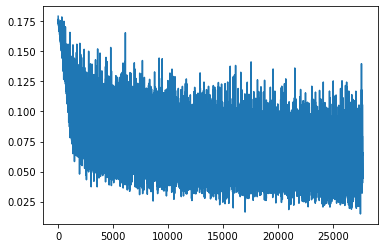

------
*********
29871 3020
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.172388955950737
Loss:  0.16524218022823334
Loss:  0.1627196967601776
0 **********
Epoch:  55.80974292755127  fold:  10  kers:  64
epoch:  1
29871 467
Loss:  0.14277054369449615
Loss:  0.13484476506710052
Loss:  0.1416940838098526
1 **********
Epoch:  106.0902738571167  fold:  10  kers:  64
epoch:  2
29871 467
Loss:  0.08869536966085434
Loss:  0.09843582659959793
Loss:  0.10216537117958069
2 **********
Epoch:  150.26513361930847  fold:  10  kers:  64
epoch:  3
Eval Loss:  0.41792115569114685
Eval Loss:  0.3026937246322632
Eval Loss:  0.17015713453292847
[[1513  238]
 [ 150 1119]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1751


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.4063091278076172
Eval Loss:  0.43297433853149414
Eval Loss:  0.36483561992645264
Eval Loss:  0.3835512399673462
Eval Loss:  0.37253516912460327
Eval Loss:  0.46660101413726807
Eval Loss:  0.41427794098854065
Eval Loss:  0.5078815817832947
Eval Loss:  0.4543619453907013
Eval Loss:  0.4060426652431488
Eval Loss:  0.328112930059433
Eval Loss:  0.38744020462036133
Eval Loss:  0.5235945582389832
Eval Loss:  0.46307358145713806
Eval Loss:  0.4494014382362366
Eval Loss:  0.3868210017681122
Eval Loss:  0.28128716349601746
Eval Loss:  0.40368521213531494
Eval Loss:  0.33520373702049255
Eval Loss:  0.4257708191871643
Eval Loss:  0.34038498997688293
Eval Loss:  0.2912253439426422
Eval Loss:  0.4097656011581421
Eval Loss:  0.3822580873966217
Eval Loss:  0.41880613565444946
Eval Loss:  0.4094700515270233
Eval Loss:  0.4422249495983124
Eval Loss:  0.37876349687576294
Eval Loss:  0.4955805838108063


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16051  2362]
 [ 2900  8558]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     18413
           1       0.78      0.75      0.76     11458

    accuracy                           0.82     29871
   macro avg       0.82      0.81      0.81     29871
weighted avg       0.82      0.82      0.82     29871

acc:  0.8238425228482474
pre:  0.7836996336996337
rec:  0.7469017280502706
ma F1:  0.8120137984213376
mi F1:  0.8238425228482474
we F1:  0.8229932163299402
29871 467
Loss:  0.09839029610157013
Loss:  0.0879656970500946
Loss:  0.09223824739456177
3 **********
Epoch:  231.93671321868896  fold:  10  kers:  64
epoch:  4
29871 467
Loss:  0.08794444054365158
Loss:  0.11339738965034485
Loss:  0.08856785297393799
4 **********
Epoch:  276.32001543045044  fold:  10  kers:  64
epoch:  5
29871 467
Loss:  0.08128799498081207
Loss:  0.10534077137708664
Loss:  0.07389450073242188
5 **********
Epoch:  320.689355134964  fold:  10  kers:  64
epoch:  6


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.4133634567260742
Eval Loss:  0.46268725395202637
Eval Loss:  0.3979131877422333
Eval Loss:  0.4277980923652649
Eval Loss:  0.3605669140815735
Eval Loss:  0.4772806167602539
Eval Loss:  0.36176595091819763
Eval Loss:  0.47482848167419434
Eval Loss:  0.42935535311698914
Eval Loss:  0.36857232451438904
Eval Loss:  0.28177696466445923
Eval Loss:  0.34623509645462036
Eval Loss:  0.5530239343643188
Eval Loss:  0.5087838768959045
Eval Loss:  0.40567365288734436
Eval Loss:  0.3737959861755371
Eval Loss:  0.23212958872318268
Eval Loss:  0.41092222929000854
Eval Loss:  0.33511653542518616
Eval Loss:  0.4315457046031952
Eval Loss:  0.33080920577049255
Eval Loss:  0.25274789333343506
Eval Loss:  0.3647034168243408
Eval Loss:  0.3809221088886261
Eval Loss:  0.4129434823989868
Eval Loss:  0.41360241174697876
Eval Loss:  0.46459123492240906
Eval Loss:  0.3849690556526184
Eval Loss:  0.5571697354316711


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16954  1459]
 [ 3255  8203]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     18413
           1       0.85      0.72      0.78     11458

    accuracy                           0.84     29871
   macro avg       0.84      0.82      0.83     29871
weighted avg       0.84      0.84      0.84     29871

acc:  0.8421880753908473
pre:  0.8489960670668598
rec:  0.7159190085529761
ma F1:  0.8273722274986935
mi F1:  0.8421880753908473
we F1:  0.8391473642933374
29871 467
Loss:  0.07783107459545135
Loss:  0.06695336103439331
Loss:  0.07951769232749939
6 **********
Epoch:  402.24524426460266  fold:  10  kers:  64
epoch:  7
29871 467
Loss:  0.07624360173940659
Loss:  0.08486944437026978
Loss:  0.11782051622867584
7 **********
Epoch:  446.66644501686096  fold:  10  kers:  64
epoch:  8
29871 467
Loss:  0.0576966218650341
Loss:  0.07679646462202072
Loss:  0.10073090344667435
8 **********
Epoch:  490.9829263687134  fold:  10  kers:  64
epoch:  9

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.3493041694164276
Eval Loss:  0.38564613461494446
Eval Loss:  0.3271641135215759
Eval Loss:  0.37190887331962585
Eval Loss:  0.3159993886947632
Eval Loss:  0.40846219658851624
Eval Loss:  0.3113712966442108
Eval Loss:  0.415117084980011
Eval Loss:  0.36017921566963196
Eval Loss:  0.3061412274837494
Eval Loss:  0.24602577090263367
Eval Loss:  0.331174373626709
Eval Loss:  0.4703825116157532
Eval Loss:  0.4686756432056427
Eval Loss:  0.33019861578941345
Eval Loss:  0.3125065565109253
Eval Loss:  0.20520594716072083
Eval Loss:  0.36374327540397644
Eval Loss:  0.311953604221344
Eval Loss:  0.38920924067497253
Eval Loss:  0.29798874258995056
Eval Loss:  0.19809143245220184
Eval Loss:  0.33276891708374023
Eval Loss:  0.33931443095207214
Eval Loss:  0.3506452441215515
Eval Loss:  0.362874835729599
Eval Loss:  0.36786773800849915
Eval Loss:  0.33054542541503906
Eval Loss:  0.48748815059661865


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[16915  1498]
 [ 2728  8730]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     18413
           1       0.85      0.76      0.81     11458

    accuracy                           0.86     29871
   macro avg       0.86      0.84      0.85     29871
weighted avg       0.86      0.86      0.86     29871

acc:  0.8585249907937464
pre:  0.8535393038717247
rec:  0.7619130738348752
ma F1:  0.8470404269464042
mi F1:  0.8585249907937464
we F1:  0.85679914918932
29871 467
Loss:  0.09383340924978256
Loss:  0.08860620111227036
Loss:  0.0767405703663826
9 **********
Epoch:  572.2595617771149  fold:  10  kers:  64
epoch:  10
29871 467
Loss:  0.07413215190172195
Loss:  0.12419702112674713
Loss:  0.09421034157276154
10 **********
Epoch:  616.5880110263824  fold:  10  kers:  64
epoch:  11
29871 467
Loss:  0.06486470997333527
Loss:  0.09392223507165909
Loss:  0.0686553493142128
11 **********
Epoch:  660.9294254779816  fold:  10  kers:  64
epoch:  12

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.31797143816947937
Eval Loss:  0.3760485053062439
Eval Loss:  0.32448217272758484
Eval Loss:  0.3633856475353241
Eval Loss:  0.31909069418907166
Eval Loss:  0.3875417709350586
Eval Loss:  0.3014543056488037
Eval Loss:  0.40374311804771423
Eval Loss:  0.36460810899734497
Eval Loss:  0.2978321611881256
Eval Loss:  0.22696462273597717
Eval Loss:  0.3180479407310486
Eval Loss:  0.4289557635784149
Eval Loss:  0.43720853328704834
Eval Loss:  0.34061041474342346
Eval Loss:  0.31319165229797363
Eval Loss:  0.1931397169828415
Eval Loss:  0.36713817715644836
Eval Loss:  0.29490581154823303
Eval Loss:  0.3848744332790375
Eval Loss:  0.2900766432285309
Eval Loss:  0.1941283941268921
Eval Loss:  0.3071153163909912
Eval Loss:  0.34750035405158997
Eval Loss:  0.3248494267463684
Eval Loss:  0.35356876254081726
Eval Loss:  0.38031506538391113
Eval Loss:  0.34055206179618835
Eval Loss:  0.4746168255805969


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17143  1270]
 [ 2871  8587]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     18413
           1       0.87      0.75      0.81     11458

    accuracy                           0.86     29871
   macro avg       0.86      0.84      0.85     29871
weighted avg       0.86      0.86      0.86     29871

acc:  0.8613705600749891
pre:  0.8711575530080146
rec:  0.7494327107697678
ma F1:  0.8489804489047632
mi F1:  0.8613705600749891
we F1:  0.8590521206192234
29871 467
Loss:  0.08343201875686646
Loss:  0.11698941886425018
Loss:  0.08562099933624268
12 **********
Epoch:  742.2868454456329  fold:  10  kers:  64
epoch:  13
29871 467
Loss:  0.09064122289419174
Loss:  0.12673786282539368
Loss:  0.07986070215702057
13 **********
Epoch:  792.3559417724609  fold:  10  kers:  64
epoch:  14
29871 467
Loss:  0.08169076591730118
Loss:  0.11206620931625366
Loss:  0.06194432079792023
14 **********
Epoch:  837.2059955596924  fold:  10  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.299998015165329
Eval Loss:  0.3697787821292877
Eval Loss:  0.3191004991531372
Eval Loss:  0.3429451286792755
Eval Loss:  0.3281906545162201
Eval Loss:  0.3679819405078888
Eval Loss:  0.2824185788631439
Eval Loss:  0.3929755389690399
Eval Loss:  0.3696568012237549
Eval Loss:  0.2721903622150421
Eval Loss:  0.2123672366142273
Eval Loss:  0.3109763562679291
Eval Loss:  0.4255063235759735
Eval Loss:  0.40056467056274414
Eval Loss:  0.3333152234554291
Eval Loss:  0.3084964454174042
Eval Loss:  0.19312599301338196
Eval Loss:  0.3482678234577179
Eval Loss:  0.2959403097629547
Eval Loss:  0.40075916051864624
Eval Loss:  0.2768212854862213
Eval Loss:  0.18930146098136902
Eval Loss:  0.2911887764930725
Eval Loss:  0.3299078345298767
Eval Loss:  0.3239825963973999
Eval Loss:  0.33232587575912476
Eval Loss:  0.362000972032547
Eval Loss:  0.33688753843307495
Eval Loss:  0.48768240213394165


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17287  1126]
 [ 2808  8650]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     18413
           1       0.88      0.75      0.81     11458

    accuracy                           0.87     29871
   macro avg       0.87      0.85      0.86     29871
weighted avg       0.87      0.87      0.87     29871

acc:  0.8683003582069566
pre:  0.8848199672667758
rec:  0.7549310525397103
ma F1:  0.8562852508191016
mi F1:  0.8683003582069566
we F1:  0.8659604935981373
29871 467
Loss:  0.11801522970199585
Loss:  0.05819762125611305
Loss:  0.06387296319007874
15 **********
Epoch:  918.3031115531921  fold:  10  kers:  64
epoch:  16
29871 467
Loss:  0.0836627334356308
Loss:  0.06023256480693817
Loss:  0.06720834970474243
16 **********
Epoch:  962.5747125148773  fold:  10  kers:  64
epoch:  17
29871 467
Loss:  0.06727501004934311
Loss:  0.09638833999633789
Loss:  0.05866486579179764
17 **********
Epoch:  1006.7854764461517  fold:  10  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.27698439359664917
Eval Loss:  0.3504679799079895
Eval Loss:  0.2923511266708374
Eval Loss:  0.33319199085235596
Eval Loss:  0.32718631625175476
Eval Loss:  0.3429854214191437
Eval Loss:  0.27096959948539734
Eval Loss:  0.3596300482749939
Eval Loss:  0.3534889221191406
Eval Loss:  0.25172579288482666
Eval Loss:  0.20326368510723114
Eval Loss:  0.29662007093429565
Eval Loss:  0.40395766496658325
Eval Loss:  0.40009626746177673
Eval Loss:  0.31189408898353577
Eval Loss:  0.2944392263889313
Eval Loss:  0.1748078316450119
Eval Loss:  0.3344651460647583
Eval Loss:  0.2958191931247711
Eval Loss:  0.3857497572898865
Eval Loss:  0.26040104031562805
Eval Loss:  0.19833499193191528
Eval Loss:  0.296044260263443
Eval Loss:  0.32030943036079407
Eval Loss:  0.3015602231025696
Eval Loss:  0.31427091360092163
Eval Loss:  0.35493260622024536
Eval Loss:  0.3186156451702118
Eval Loss:  0.4326551854610443


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17329  1084]
 [ 2647  8811]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     18413
           1       0.89      0.77      0.83     11458

    accuracy                           0.88     29871
   macro avg       0.88      0.86      0.86     29871
weighted avg       0.88      0.88      0.87     29871

acc:  0.8750962471962773
pre:  0.8904497220818596
rec:  0.7689823703962297
ma F1:  0.8640405773912274
mi F1:  0.8750962471962773
we F1:  0.8730676005767313
29871 467
Loss:  0.09464436024427414
Loss:  0.0970521867275238
Loss:  0.07917068898677826
18 **********
Epoch:  1087.9893066883087  fold:  10  kers:  64
epoch:  19
29871 467
Loss:  0.0615728497505188
Loss:  0.0685981884598732
Loss:  0.07500728219747543
19 **********
Epoch:  1132.2230093479156  fold:  10  kers:  64
epoch:  20
29871 467
Loss:  0.06077587604522705
Loss:  0.05661509558558464
Loss:  0.04553313925862312
20 **********
Epoch:  1176.6342368125916  fold:  10  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.26482897996902466
Eval Loss:  0.3164137601852417
Eval Loss:  0.2801680862903595
Eval Loss:  0.31328752636909485
Eval Loss:  0.3119949996471405
Eval Loss:  0.3074265122413635
Eval Loss:  0.26586422324180603
Eval Loss:  0.3061864376068115
Eval Loss:  0.33245009183883667
Eval Loss:  0.23161759972572327
Eval Loss:  0.19247113168239594
Eval Loss:  0.2911633849143982
Eval Loss:  0.32322973012924194
Eval Loss:  0.34435170888900757
Eval Loss:  0.30680403113365173
Eval Loss:  0.2731810510158539
Eval Loss:  0.19514574110507965
Eval Loss:  0.30212104320526123
Eval Loss:  0.2864527106285095
Eval Loss:  0.3299012780189514
Eval Loss:  0.2537819743156433
Eval Loss:  0.16308830678462982
Eval Loss:  0.2853948175907135
Eval Loss:  0.29953184723854065
Eval Loss:  0.2606184482574463
Eval Loss:  0.2639266550540924
Eval Loss:  0.2984301447868347
Eval Loss:  0.2822328805923462
Eval Loss:  0.41964852809906006


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17276  1137]
 [ 2346  9112]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     18413
           1       0.89      0.80      0.84     11458

    accuracy                           0.88     29871
   macro avg       0.88      0.87      0.87     29871
weighted avg       0.88      0.88      0.88     29871

acc:  0.8833986140403736
pre:  0.889062347546102
rec:  0.7952522255192879
ma F1:  0.873985648303639
mi F1:  0.8833986140403736
we F1:  0.8820046557385961
29871 467
Loss:  0.042742110788822174
Loss:  0.06274295598268509
Loss:  0.07620255649089813
21 **********
Epoch:  1258.1971077919006  fold:  10  kers:  64
epoch:  22
29871 467
Loss:  0.09095603227615356
Loss:  0.09643286466598511
Loss:  0.06922675669193268
22 **********
Epoch:  1302.3998925685883  fold:  10  kers:  64
epoch:  23
29871 467
Loss:  0.05142604559659958
Loss:  0.06569983065128326
Loss:  0.08623628318309784
23 **********
Epoch:  1346.6685013771057  fold:  10  kers:  64
epo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2649080753326416
Eval Loss:  0.31925201416015625
Eval Loss:  0.28961312770843506
Eval Loss:  0.32361283898353577
Eval Loss:  0.3183279037475586
Eval Loss:  0.2730069160461426
Eval Loss:  0.2761467397212982
Eval Loss:  0.28940337896347046
Eval Loss:  0.29843568801879883
Eval Loss:  0.24478934705257416
Eval Loss:  0.18597756326198578
Eval Loss:  0.33432140946388245
Eval Loss:  0.33434200286865234
Eval Loss:  0.3765208125114441
Eval Loss:  0.2952985167503357
Eval Loss:  0.2621966302394867
Eval Loss:  0.1799517571926117
Eval Loss:  0.2929006516933441
Eval Loss:  0.27265217900276184
Eval Loss:  0.3449212312698364
Eval Loss:  0.22926123440265656
Eval Loss:  0.17992663383483887
Eval Loss:  0.2691977620124817
Eval Loss:  0.3237359821796417
Eval Loss:  0.2588924169540405
Eval Loss:  0.27465519309043884
Eval Loss:  0.3076796233654022
Eval Loss:  0.28203174471855164
Eval Loss:  0.364805668592453


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17313  1100]
 [ 2341  9117]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     18413
           1       0.89      0.80      0.84     11458

    accuracy                           0.88     29871
   macro avg       0.89      0.87      0.88     29871
weighted avg       0.89      0.88      0.88     29871

acc:  0.8848046600381642
pre:  0.8923363022413624
rec:  0.7956886018502356
ma F1:  0.8754262103704786
mi F1:  0.8848046600381642
we F1:  0.883384619037969
29871 467
Loss:  0.05773100629448891
Loss:  0.08485837280750275
Loss:  0.08483988791704178
24 **********
Epoch:  1428.1216650009155  fold:  10  kers:  64
epoch:  25
29871 467
Loss:  0.09052278846502304
Loss:  0.09845852851867676
Loss:  0.07456110417842865
25 **********
Epoch:  1472.3344235420227  fold:  10  kers:  64
epoch:  26
29871 467
Loss:  0.0669674277305603
Loss:  0.0393526591360569
Loss:  0.057493552565574646
26 **********
Epoch:  1516.7177259922028  fold:  10  kers:  64
epoc

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.25117355585098267
Eval Loss:  0.3162466585636139
Eval Loss:  0.26200246810913086
Eval Loss:  0.3199543356895447
Eval Loss:  0.34549829363822937
Eval Loss:  0.27319371700286865
Eval Loss:  0.28543996810913086
Eval Loss:  0.2865316867828369
Eval Loss:  0.287688672542572
Eval Loss:  0.235911026597023
Eval Loss:  0.17979420721530914
Eval Loss:  0.29322412610054016
Eval Loss:  0.32910796999931335
Eval Loss:  0.36819401383399963
Eval Loss:  0.2964795231819153
Eval Loss:  0.2526414394378662
Eval Loss:  0.18455970287322998
Eval Loss:  0.2998298704624176
Eval Loss:  0.2685430645942688
Eval Loss:  0.33463945984840393
Eval Loss:  0.2494421899318695
Eval Loss:  0.1846766173839569
Eval Loss:  0.2998718321323395
Eval Loss:  0.29944804310798645
Eval Loss:  0.2469044029712677
Eval Loss:  0.23591817915439606
Eval Loss:  0.2971671521663666
Eval Loss:  0.2844735383987427
Eval Loss:  0.4114847481250763


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17491   922]
 [ 2463  8995]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     18413
           1       0.91      0.79      0.84     11458

    accuracy                           0.89     29871
   macro avg       0.89      0.87      0.88     29871
weighted avg       0.89      0.89      0.88     29871

acc:  0.8866793880352181
pre:  0.9070283351820106
rec:  0.7850410193751091
ma F1:  0.8767052826373541
mi F1:  0.8866793880352181
we F1:  0.8848702900575688
29871 467
Loss:  0.04840695858001709
Loss:  0.08989019691944122
Loss:  0.0558566115796566
27 **********
Epoch:  1598.3204894065857  fold:  10  kers:  64
epoch:  28
29871 467
Loss:  0.06147952750325203
Loss:  0.08993810415267944
Loss:  0.07168697565793991
28 **********
Epoch:  1642.5432212352753  fold:  10  kers:  64
epoch:  29
29871 467
Loss:  0.09716810286045074
Loss:  0.050834137946367264
Loss:  0.10007300972938538
29 **********
Epoch:  1686.7769236564636  fold:  10  kers:  64
ep

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.24883678555488586
Eval Loss:  0.2673724591732025
Eval Loss:  0.20661482214927673
Eval Loss:  0.29375606775283813
Eval Loss:  0.2969319224357605
Eval Loss:  0.2502213418483734
Eval Loss:  0.28440654277801514
Eval Loss:  0.29342377185821533
Eval Loss:  0.25706982612609863
Eval Loss:  0.20381399989128113
Eval Loss:  0.1853971630334854
Eval Loss:  0.27378255128860474
Eval Loss:  0.2721063792705536
Eval Loss:  0.3063177764415741
Eval Loss:  0.27192431688308716
Eval Loss:  0.22418877482414246
Eval Loss:  0.15809763967990875
Eval Loss:  0.2528972625732422
Eval Loss:  0.23777496814727783
Eval Loss:  0.2824418842792511
Eval Loss:  0.2296663075685501
Eval Loss:  0.16505111753940582
Eval Loss:  0.2851635813713074
Eval Loss:  0.276576966047287
Eval Loss:  0.23270390927791595
Eval Loss:  0.21871256828308105
Eval Loss:  0.2597743272781372
Eval Loss:  0.26302579045295715
Eval Loss:  0.3474081754684448


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17177  1236]
 [ 1856  9602]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     18413
           1       0.89      0.84      0.86     11458

    accuracy                           0.90     29871
   macro avg       0.89      0.89      0.89     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.89648823273409
pre:  0.8859568186012179
rec:  0.8380171059521732
ma F1:  0.8893740894315155
mi F1:  0.89648823273409
we F1:  0.8959059530182356
29871 467
Loss:  0.05798213556408882
Loss:  0.040697019547224045
Loss:  0.0711786076426506
30 **********
Epoch:  1775.9683921337128  fold:  10  kers:  64
epoch:  31
29871 467
Loss:  0.06821256130933762
Loss:  0.07799636572599411
Loss:  0.061267558485269547
31 **********
Epoch:  1820.5671184062958  fold:  10  kers:  64
epoch:  32
29871 467
Loss:  0.05517810955643654
Loss:  0.06266190856695175
Loss:  0.05610860884189606
32 **********
Epoch:  1865.0421760082245  fold:  10  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.21507632732391357
Eval Loss:  0.2721000909805298
Eval Loss:  0.2270171046257019
Eval Loss:  0.3034243881702423
Eval Loss:  0.317927747964859
Eval Loss:  0.24684207141399384
Eval Loss:  0.28036195039749146
Eval Loss:  0.2803356945514679
Eval Loss:  0.24938490986824036
Eval Loss:  0.23906777799129486
Eval Loss:  0.15967576205730438
Eval Loss:  0.30047136545181274
Eval Loss:  0.3048608899116516
Eval Loss:  0.32940903306007385
Eval Loss:  0.26839494705200195
Eval Loss:  0.22665584087371826
Eval Loss:  0.1626155823469162
Eval Loss:  0.2594778537750244
Eval Loss:  0.23636366426944733
Eval Loss:  0.30670762062072754
Eval Loss:  0.2174336463212967
Eval Loss:  0.15928995609283447
Eval Loss:  0.28495490550994873
Eval Loss:  0.28260117769241333
Eval Loss:  0.2254808396100998
Eval Loss:  0.2526284456253052
Eval Loss:  0.26958179473876953
Eval Loss:  0.2628743052482605
Eval Loss:  0.31907060742378235


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17348  1065]
 [ 2106  9352]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     18413
           1       0.90      0.82      0.86     11458

    accuracy                           0.89     29871
   macro avg       0.89      0.88      0.89     29871
weighted avg       0.89      0.89      0.89     29871

acc:  0.8938435271668174
pre:  0.8977632715753096
rec:  0.8161982894047827
ma F1:  0.8856497699844192
mi F1:  0.8938435271668174
we F1:  0.8927767811404446
29871 467
Loss:  0.09278823435306549
Loss:  0.059807710349559784
Loss:  0.06613517552614212
33 **********
Epoch:  1946.298864364624  fold:  10  kers:  64
epoch:  34
29871 467
Loss:  0.07161986827850342
Loss:  0.07106965035200119
Loss:  0.05999011918902397
34 **********
Epoch:  1990.7390146255493  fold:  10  kers:  64
epoch:  35
29871 467
Loss:  0.06886434555053711
Loss:  0.08199723064899445
Loss:  0.07701908051967621
35 **********
Epoch:  2035.0215866565704  fold:  10  kers:  64
ep

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.21266941726207733
Eval Loss:  0.26170435547828674
Eval Loss:  0.2328948825597763
Eval Loss:  0.3098914325237274
Eval Loss:  0.29990580677986145
Eval Loss:  0.23954257369041443
Eval Loss:  0.29706260561943054
Eval Loss:  0.2528712749481201
Eval Loss:  0.2436012327671051
Eval Loss:  0.22883296012878418
Eval Loss:  0.1651257574558258
Eval Loss:  0.3042951822280884
Eval Loss:  0.2811708152294159
Eval Loss:  0.3154844641685486
Eval Loss:  0.2839335501194
Eval Loss:  0.22649610042572021
Eval Loss:  0.16807244718074799
Eval Loss:  0.2497180551290512
Eval Loss:  0.23391331732273102
Eval Loss:  0.29867905378341675
Eval Loss:  0.23105143010616302
Eval Loss:  0.16755713522434235
Eval Loss:  0.27426841855049133
Eval Loss:  0.2950974702835083
Eval Loss:  0.2448260635137558
Eval Loss:  0.22508662939071655
Eval Loss:  0.2658802568912506
Eval Loss:  0.271144837141037
Eval Loss:  0.31088170409202576


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17378  1035]
 [ 2124  9334]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     18413
           1       0.90      0.81      0.86     11458

    accuracy                           0.89     29871
   macro avg       0.90      0.88      0.89     29871
weighted avg       0.89      0.89      0.89     29871

acc:  0.8942452545947575
pre:  0.9001832384993731
rec:  0.8146273346133706
ma F1:  0.8859765232989971
mi F1:  0.8942452545947575
we F1:  0.8931258303803016
29871 467
Loss:  0.07706771790981293
Loss:  0.06124211847782135
Loss:  0.048026423901319504
36 **********
Epoch:  2116.422888994217  fold:  10  kers:  64
epoch:  37
29871 467
Loss:  0.10167050361633301
Loss:  0.0676320344209671
Loss:  0.0798373743891716
37 **********
Epoch:  2160.791231393814  fold:  10  kers:  64
epoch:  38
29871 467
Loss:  0.06519470363855362
Loss:  0.060856204479932785
Loss:  0.053541149944067
38 **********
Epoch:  2205.26828289032  fold:  10  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2121867537498474
Eval Loss:  0.26294630765914917
Eval Loss:  0.21245506405830383
Eval Loss:  0.26612940430641174
Eval Loss:  0.2684362828731537
Eval Loss:  0.2322012335062027
Eval Loss:  0.28859037160873413
Eval Loss:  0.2806234061717987
Eval Loss:  0.1989637017250061
Eval Loss:  0.21200260519981384
Eval Loss:  0.1626269668340683
Eval Loss:  0.2572898864746094
Eval Loss:  0.27256613969802856
Eval Loss:  0.30126720666885376
Eval Loss:  0.25704795122146606
Eval Loss:  0.21718862652778625
Eval Loss:  0.15784509479999542
Eval Loss:  0.23884786665439606
Eval Loss:  0.19822365045547485
Eval Loss:  0.26777029037475586
Eval Loss:  0.2142743468284607
Eval Loss:  0.15062911808490753
Eval Loss:  0.2797134220600128
Eval Loss:  0.24965988099575043
Eval Loss:  0.21616670489311218
Eval Loss:  0.23092450201511383
Eval Loss:  0.24653272330760956
Eval Loss:  0.2419501692056656
Eval Loss:  0.3033384680747986


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17182  1231]
 [ 1701  9757]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     18413
           1       0.89      0.85      0.87     11458

    accuracy                           0.90     29871
   macro avg       0.90      0.89      0.90     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.9018445984399585
pre:  0.887968693119767
rec:  0.8515447722115552
ma F1:  0.8953805306050695
mi F1:  0.9018445984399585
we F1:  0.9014354251224638
29871 467
Loss:  0.10511119663715363
Loss:  0.06923401355743408
Loss:  0.044622570276260376
39 **********
Epoch:  2286.5628707408905  fold:  10  kers:  64
epoch:  40
29871 467
Loss:  0.08352427929639816
Loss:  0.053276535123586655
Loss:  0.04930836707353592
40 **********
Epoch:  2330.885335922241  fold:  10  kers:  64
epoch:  41
29871 467
Loss:  0.05641378462314606
Loss:  0.056715499609708786
Loss:  0.056077368557453156
41 **********
Epoch:  2375.199821949005  fold:  10  kers:  64
e

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.22580233216285706
Eval Loss:  0.2655809223651886
Eval Loss:  0.2359238564968109
Eval Loss:  0.2899286448955536
Eval Loss:  0.2863079607486725
Eval Loss:  0.2340945452451706
Eval Loss:  0.27747634053230286
Eval Loss:  0.25867578387260437
Eval Loss:  0.22895658016204834
Eval Loss:  0.2273314893245697
Eval Loss:  0.16586419939994812
Eval Loss:  0.3063296675682068
Eval Loss:  0.305417001247406
Eval Loss:  0.338802307844162
Eval Loss:  0.2769109010696411
Eval Loss:  0.2675307095050812
Eval Loss:  0.15806661546230316
Eval Loss:  0.22949881851673126
Eval Loss:  0.22703607380390167
Eval Loss:  0.29233962297439575
Eval Loss:  0.21662260591983795
Eval Loss:  0.16905906796455383
Eval Loss:  0.24973464012145996
Eval Loss:  0.3138321340084076
Eval Loss:  0.24178621172904968
Eval Loss:  0.21231545507907867
Eval Loss:  0.2671620547771454
Eval Loss:  0.264114648103714
Eval Loss:  0.310014009475708


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17576   837]
 [ 2243  9215]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18413
           1       0.92      0.80      0.86     11458

    accuracy                           0.90     29871
   macro avg       0.90      0.88      0.89     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.89688996016203
pre:  0.916732988460008
rec:  0.8042415779368127
ma F1:  0.8881249994528013
mi F1:  0.89688996016203
we F1:  0.8954160294411623
29871 467
Loss:  0.08042770624160767
Loss:  0.07715056836605072
Loss:  0.05688665807247162
42 **********
Epoch:  2456.6460044384003  fold:  10  kers:  64
epoch:  43
29871 467
Loss:  0.04392752796411514
Loss:  0.06025392562150955
Loss:  0.03832264244556427
43 **********
Epoch:  2501.021327972412  fold:  10  kers:  64
epoch:  44
29871 467
Loss:  0.07647901773452759
Loss:  0.038798753172159195
Loss:  0.09451774507761002
44 **********
Epoch:  2553.996652364731  fold:  10  kers:  64
epoch:  

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.209517702460289
Eval Loss:  0.274839848279953
Eval Loss:  0.21598783135414124
Eval Loss:  0.2828349471092224
Eval Loss:  0.30097395181655884
Eval Loss:  0.24563336372375488
Eval Loss:  0.29138419032096863
Eval Loss:  0.2594752311706543
Eval Loss:  0.24736593663692474
Eval Loss:  0.20374730229377747
Eval Loss:  0.16394059360027313
Eval Loss:  0.25603845715522766
Eval Loss:  0.29397252202033997
Eval Loss:  0.30543220043182373
Eval Loss:  0.27800795435905457
Eval Loss:  0.22738559544086456
Eval Loss:  0.14395219087600708
Eval Loss:  0.23062574863433838
Eval Loss:  0.2527165710926056
Eval Loss:  0.3024336099624634
Eval Loss:  0.23256780207157135
Eval Loss:  0.14425604045391083
Eval Loss:  0.2522561252117157
Eval Loss:  0.2839130163192749
Eval Loss:  0.23176607489585876
Eval Loss:  0.219869002699852
Eval Loss:  0.2489505559206009
Eval Loss:  0.2536314129829407
Eval Loss:  0.3509919345378876


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17665   748]
 [ 2286  9172]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     18413
           1       0.92      0.80      0.86     11458

    accuracy                           0.90     29871
   macro avg       0.91      0.88      0.89     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.8984299153024673
pre:  0.9245967741935484
rec:  0.8004887414906615
ma F1:  0.8894969199566216
mi F1:  0.8984299153024673
we F1:  0.8968122364090362
29871 467
Loss:  0.06599073112010956
Loss:  0.05500522255897522
Loss:  0.04974425956606865
45 **********
Epoch:  2635.957458257675  fold:  10  kers:  64
epoch:  46
29871 467
Loss:  0.04740313068032265
Loss:  0.06979620456695557
Loss:  0.07776722311973572
46 **********
Epoch:  2680.184179544449  fold:  10  kers:  64
epoch:  47
29871 467
Loss:  0.06108583137392998
Loss:  0.05171326920390129
Loss:  0.09362409263849258
47 **********
Epoch:  2724.501657962799  fold:  10  kers:  64
epoch

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.22628286480903625
Eval Loss:  0.27417901158332825
Eval Loss:  0.2101588249206543
Eval Loss:  0.28939399123191833
Eval Loss:  0.2669118046760559
Eval Loss:  0.21755212545394897
Eval Loss:  0.27797046303749084
Eval Loss:  0.24080133438110352
Eval Loss:  0.2158520519733429
Eval Loss:  0.2075536549091339
Eval Loss:  0.16574527323246002
Eval Loss:  0.23140370845794678
Eval Loss:  0.2674170136451721
Eval Loss:  0.31487733125686646
Eval Loss:  0.24778246879577637
Eval Loss:  0.21590188145637512
Eval Loss:  0.14291734993457794
Eval Loss:  0.22980710864067078
Eval Loss:  0.21852834522724152
Eval Loss:  0.2713220417499542
Eval Loss:  0.23392321169376373
Eval Loss:  0.14371266961097717
Eval Loss:  0.279736191034317
Eval Loss:  0.2664867043495178
Eval Loss:  0.21555183827877045
Eval Loss:  0.2288951724767685
Eval Loss:  0.2478974312543869
Eval Loss:  0.23057009279727936
Eval Loss:  0.296994686126709


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17474   939]
 [ 1947  9511]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18413
           1       0.91      0.83      0.87     11458

    accuracy                           0.90     29871
   macro avg       0.90      0.89      0.90     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.9033845535803957
pre:  0.9101435406698565
rec:  0.830075056728923
ma F1:  0.8959933527210132
mi F1:  0.9033845535803957
we F1:  0.9024489350363473
29871 467
Loss:  0.05287856236100197
Loss:  0.06945058703422546
Loss:  0.06368403881788254
48 **********
Epoch:  2805.902960062027  fold:  10  kers:  64
epoch:  49
29871 467
Loss:  0.058010298758745193
Loss:  0.06887129694223404
Loss:  0.053127042949199677
49 **********
Epoch:  2850.108737230301  fold:  10  kers:  64
epoch:  50
29871 467
Loss:  0.050298240035772324
Loss:  0.04358293488621712
Loss:  0.04198447987437248
50 **********
Epoch:  2894.270631790161  fold:  10  kers:  64
epo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.21829108893871307
Eval Loss:  0.2618352770805359
Eval Loss:  0.17226825654506683
Eval Loss:  0.2901756167411804
Eval Loss:  0.26185083389282227
Eval Loss:  0.21130259335041046
Eval Loss:  0.2773829698562622
Eval Loss:  0.24040205776691437
Eval Loss:  0.16505283117294312
Eval Loss:  0.19359077513217926
Eval Loss:  0.16293156147003174
Eval Loss:  0.23689492046833038
Eval Loss:  0.24231816828250885
Eval Loss:  0.3187904357910156
Eval Loss:  0.2384864240884781
Eval Loss:  0.18678690493106842
Eval Loss:  0.1512693166732788
Eval Loss:  0.22080720961093903
Eval Loss:  0.19888511300086975
Eval Loss:  0.27947014570236206
Eval Loss:  0.22706101834774017
Eval Loss:  0.16056151688098907
Eval Loss:  0.25449222326278687
Eval Loss:  0.2619750499725342
Eval Loss:  0.21637949347496033
Eval Loss:  0.20414970815181732
Eval Loss:  0.22798746824264526
Eval Loss:  0.24060864746570587
Eval Loss:  0.26414626836776733


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17406  1007]
 [ 1755  9703]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18413
           1       0.91      0.85      0.88     11458

    accuracy                           0.91     29871
   macro avg       0.91      0.90      0.90     29871
weighted avg       0.91      0.91      0.91     29871

acc:  0.9075357370024438
pre:  0.9059757236227824
rec:  0.8468319078373189
ma F1:  0.9009488568085262
mi F1:  0.9075357370024438
we F1:  0.9068961178430189
29871 467
Loss:  0.05673325061798096
Loss:  0.0555628165602684
Loss:  0.08790453523397446
51 **********
Epoch:  2975.657971382141  fold:  10  kers:  64
epoch:  52
29871 467
Loss:  0.03674045950174332
Loss:  0.09117383509874344
Loss:  0.07175203412771225
52 **********
Epoch:  3019.806900501251  fold:  10  kers:  64
epoch:  53
29871 467
Loss:  0.05857103317975998
Loss:  0.0617029182612896
Loss:  0.06485342234373093
53 **********
Epoch:  3064.1303629875183  fold:  10  kers:  64
epoch:

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.22518891096115112
Eval Loss:  0.2852615416049957
Eval Loss:  0.20770275592803955
Eval Loss:  0.24613457918167114
Eval Loss:  0.2728096544742584
Eval Loss:  0.21996191143989563
Eval Loss:  0.2741874158382416
Eval Loss:  0.25533244013786316
Eval Loss:  0.19780333340168
Eval Loss:  0.1869649887084961
Eval Loss:  0.15775549411773682
Eval Loss:  0.22830048203468323
Eval Loss:  0.25716716051101685
Eval Loss:  0.29224857687950134
Eval Loss:  0.25377535820007324
Eval Loss:  0.19592538475990295
Eval Loss:  0.15666742622852325
Eval Loss:  0.2135782539844513
Eval Loss:  0.20443275570869446
Eval Loss:  0.2583393156528473
Eval Loss:  0.22752465307712555
Eval Loss:  0.13377435505390167
Eval Loss:  0.25296056270599365
Eval Loss:  0.2779567837715149
Eval Loss:  0.18563342094421387
Eval Loss:  0.21325726807117462
Eval Loss:  0.22485436499118805
Eval Loss:  0.20439384877681732
Eval Loss:  0.2857595980167389


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17543   870]
 [ 1956  9502]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     18413
           1       0.92      0.83      0.87     11458

    accuracy                           0.91     29871
   macro avg       0.91      0.89      0.90     29871
weighted avg       0.91      0.91      0.90     29871

acc:  0.9053931907200964
pre:  0.9161203239490937
rec:  0.829289579333217
ma F1:  0.8980020394892838
mi F1:  0.9053931907200965
we F1:  0.9043949578837998
29871 467
Loss:  0.06491563469171524
Loss:  0.05390450730919838
Loss:  0.06743325293064117
54 **********
Epoch:  3145.376081228256  fold:  10  kers:  64
epoch:  55
29871 467
Loss:  0.07163204997777939
Loss:  0.10095447301864624
Loss:  0.037518154829740524
55 **********
Epoch:  3189.6975491046906  fold:  10  kers:  64
epoch:  56
29871 467
Loss:  0.033948902040719986
Loss:  0.050190623849630356
Loss:  0.0681251659989357
56 **********
Epoch:  3233.876398086548  fold:  10  kers:  64
epo

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Eval Loss:  0.2379566729068756
Eval Loss:  0.27950018644332886
Eval Loss:  0.2048884630203247
Eval Loss:  0.2506338953971863
Eval Loss:  0.26763013005256653
Eval Loss:  0.22672508656978607
Eval Loss:  0.28266817331314087
Eval Loss:  0.25038421154022217
Eval Loss:  0.1853514015674591
Eval Loss:  0.18656378984451294
Eval Loss:  0.15120024979114532
Eval Loss:  0.21065735816955566
Eval Loss:  0.23716799914836884
Eval Loss:  0.2848965525627136
Eval Loss:  0.2341795116662979
Eval Loss:  0.1822873055934906
Eval Loss:  0.1306251883506775
Eval Loss:  0.22125636041164398
Eval Loss:  0.21799175441265106
Eval Loss:  0.28315606713294983
Eval Loss:  0.2527869641780853
Eval Loss:  0.14660412073135376
Eval Loss:  0.24403132498264313
Eval Loss:  0.2659587562084198
Eval Loss:  0.20756754279136658
Eval Loss:  0.20732243359088898
Eval Loss:  0.23101980984210968
Eval Loss:  0.23756715655326843
Eval Loss:  0.28672119975090027


C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[17663   750]
 [ 2011  9447]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     18413
           1       0.93      0.82      0.87     11458

    accuracy                           0.91     29871
   macro avg       0.91      0.89      0.90     29871
weighted avg       0.91      0.91      0.91     29871

acc:  0.9075692142881056
pre:  0.9264489555751692
rec:  0.8244894396927911
ma F1:  0.9000043254274079
mi F1:  0.9075692142881056
we F1:  0.9064081474851188
29871 467
Loss:  0.06545984745025635
Loss:  0.0738978236913681
Loss:  0.045426737517118454
57 **********
Epoch:  3315.322580575943  fold:  10  kers:  64
epoch:  58
29871 467
Loss:  0.054260142147541046
Loss:  0.031990375369787216
Loss:  0.045390356332063675
58 **********
Epoch:  3359.564261674881  fold:  10  kers:  64
epoch:  59
29871 467
Loss:  0.058571092784404755
Loss:  0.07995766401290894
Loss:  0.04360439255833626
59 **********
Epoch:  3403.934598684311  fold:  10  kers:  64
E

C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Talha\miniconda3\envs\srop\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


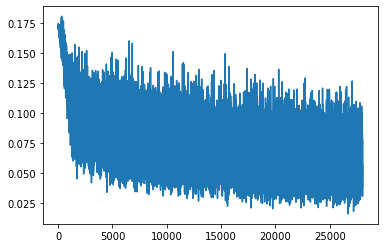

------


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time
for kers in [64]:
    print("  ")
    print("kernel:",kers)
    print("  ")
    for fold in range(1,11):
        begin=time()
        #train_rec,test_rec=reclist[train_idx],reclist[test_idx]
        train_dtlist,test_dtlist=getTrainTestList(reclist,opt='kfold',fold = fold)#fold 1-10   
        print('*********')

        train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
        np.random.shuffle(train_dtlist)
        test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
        print(len(train_dtlist),len(test_dtlist))
        model = MyLSTM(2,kers).to(device)

        #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                    # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                    #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    print(m,'init')
                else:
                    print('Not initializing')
        criterion=nn.CrossEntropyLoss().to(device)

        opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
        loss_list=[]

        opt.zero_grad()
        epoch_flag=0
        best_acc=0
        for epoch in range(60):
            print('epoch: ', epoch)
            if epoch_flag%3==0 and epoch_flag!=0:
                model.eval()
                prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
                if tmp_acc>best_acc:
                    best_acc=tmp_acc                   
                    res_file_name="./weights/new2_fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,38)
                    res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
                    res_file.to_csv(res_file_name,index=False)
                    torch.save(model.state_dict(), "./weights/new2_fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,38))
                    print("update! ",'Acc: ',best_acc)
                #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
                _,_,_,_=eval(model,train_dtlist,criterion,device)
                model.train()
            train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
            train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True, sampler=None, num_workers=0)

            print(len(train_dataset),len(train_loader)) #,len(test_dataset)
            flag=0
            accum_flag=0
            for fe, label,seg_id in train_loader:
                del seg_id
                fe=fe.float().to(device)

                label=label.long().to(device)
                pred_prob_no_softmax=model(fe)
                loss=criterion(pred_prob_no_softmax,label)/4#/256
                del label
                del fe
                
                loss_list.append(loss.item())
                loss.backward()
                accum_flag+=1
                if accum_flag%4==0:
                    opt.step()
                    accum_flag=0
                    opt.zero_grad()
                flag+=1
                if flag%128==0:
                    print("Loss: ", loss.item())
                #print('step')
            print(epoch_flag,'*'*10)
            epoch_flag+=1
            #scheduler.step()
            print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
            
        model.eval()

        prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
        if tmp_acc>best_acc:
            best_acc=tmp_acc                   
            res_file_name="./weights/new2_fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,38)
            res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
            res_file.to_csv(res_file_name,index=False)
            torch.save(model.state_dict(), "./weights/new2_fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,38))
        print("update! ",'Acc: ',best_acc)

        print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
        plt.plot(loss_list)
        plt.show()
        plt.close('all')
        print('------')

In [ ]:
# Maybe I should not print so many loss items..